In [1]:
import os

# Set the CUDA_VISIBLE_DEVICES environment variable
# 40 GB
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-a4a538a2-a199-58d8-9e56-ed86db02edf8"

In [2]:
import sys
print(sys.executable)


/home/sahsan/PythonProjects/pytorch/Falcon7B-manual/manual_py_3_8_env/bin/python


In [3]:
import torch
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, GenerationConfig
from peft import LoraConfig, get_peft_model, PeftConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer
import warnings
warnings.filterwarnings("ignore")

In [5]:
from huggingface_hub import notebook_login
notebook_login()

In [6]:
from datasets import load_dataset

# Load the dataset from the formatted CSV file
data = load_dataset('csv', data_files='llama-instruct-data.csv')
# dataset = load_dataset('csv', data_files='owasp-formatted.csv')

# Accessing the dataset
# print(repr(data[0]['text']))  # Print the first row of the dataset
# print(repr(data["train"][0]['text']))
print(repr(data["train"][2]['text']))

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

'<s>[INST] What is the second OWASP 2023 Top 10 API vulnerability? [/INST] The second OWASP 2023 Top 10 API vulnerability is "Broken Authentication." It occurs when an application\'s authentication processes are poorly implemented, making it possible for attackers to compromise user credentials or session tokens, and assume other users\' identities. </s>'


In [7]:
# data = load_dataset("ZahrizhalAli/mental_health_conversational_dataset")
# data

# # Take a Glance on how the data looks like 
# print(repr(data["train"][10]['text']))

Load the Pre-trained Model

In [8]:
model_name = "meta-llama/Llama-2-7b-chat-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,            # load model in 4-bit precision
    bnb_4bit_quant_type="nf4",    # pre-trained model should be quantized in 4-bit NF format
    # bnb_4bit_use_double_quant=True, # Using double quantization as mentioned in QLoRA paper
    bnb_4bit_use_double_quant=False,
    bnb_4bit_compute_dtype=torch.bfloat16, # During computation, pre-trained model should be loaded in BF16 format
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config, # Use bitsandbytes config
    device_map="auto",  # Specifying device_map="auto" so that HF Accelerate will determine which GPU to put each layer of the model on
    trust_remote_code=True, # Set trust_remote_code=True to use falcon-7b model with custom code
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True) # Set trust_remote_code=True
tokenizer.pad_token = tokenizer.eos_token # Setting pad_token same as eos_token

PEFT (Parameter Efficient Fine Tuning) and QLoRA

In [10]:
model = prepare_model_for_kbit_training(model)

lora_alpha = 16 # scaling factor for the weight matrices
lora_dropout = 0.05 # dropout probability of the LoRA layers
lora_rank = 96 # dimension of the low-rank matrices

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_rank,
    bias="none",  # setting to 'none' for only training weight params instead of biases
    task_type="CAUSAL_LM",
    # target_modules=[         # Setting names of modules in falcon-7b model that we want to apply LoRA to
    #     "query_key_value",
    #     "dense",
    #     "dense_h_to_4h",
    #     "dense_4h_to_h",
    # ]
)

peft_model = get_peft_model(model, peft_config)

In [11]:
output_dir = "./models/Llama-2-7b-Set-3-cybersecurity-layered-config"
per_device_train_batch_size = 10 # reduce batch size by 2x if out-of-memory error
gradient_accumulation_steps = 1  # increase gradient accumulation steps by 2x if batch size is reduced
optim = "paged_adamw_32bit" # activates the paging for better memory management
save_strategy="steps" # checkpoint save strategy to adopt during training
save_steps = 7654 # number of updates steps before two checkpoint saves
logging_steps = 230  # number of update steps between two logs if logging_strategy="steps"
learning_rate = 5e-4  # learning rate for AdamW optimizer
max_grad_norm = 0.8 # maximum gradient norm (for gradient clipping)
max_steps = -1    # training will happen for auto steps
warmup_ratio = 0.03 # number of steps used for a linear warmup from 0 to learning_rate
lr_scheduler_type = "cosine"  # learning rate scheduler


training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=12,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay = 0.0001, #Regularization
    fp16=False,
    bf16=False,
    tf32=False,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
)

In [12]:
# SEQUENCE LENGTH CHANGED

trainer = SFTTrainer(
    model=peft_model,
    train_dataset=data['train'],
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=160, #This is a calculated value by estimated tokens in question and answer. 1024 default. 
    tokenizer=tokenizer,
    args=training_arguments,
)

for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

Map:   0%|          | 0/19134 [00:00<?, ? examples/s]

In [13]:
peft_model.config.use_cache = False
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: shahrukh-azhar44 (shahrukh-team). Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used.

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TrainOutput(global_step=22968, training_loss=0.4713746842836429, metrics={'train_runtime': 351303.5783, 'train_samples_per_second': 0.654, 'train_steps_per_second': 0.065, 'total_flos': 9.229128567678075e+17, 'train_loss': 0.4713746842836429, 'epoch': 12.0})

In [14]:
trainer.model.save_pretrained('Llama-2-7b-Set-3-cybersecurity-layered-config/finished')
trainer.tokenizer.save_pretrained('Llama-2-7b-Set-3-cybersecurity-layered-config/finished')

('Llama-2-7b-Set-3-cybersecurity-layered-config/finished/tokenizer_config.json',
 'Llama-2-7b-Set-3-cybersecurity-layered-config/finished/special_tokens_map.json',
 'Llama-2-7b-Set-3-cybersecurity-layered-config/finished/tokenizer.json')

In [15]:
trainer.push_to_hub()

adapter_model.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

'https://huggingface.co/shahrukh95/Llama-2-7b-Set-3-cybersecurity-layered-config/tree/main/'

In [16]:
# from tensorboard import notebook
# log_dir = "cybersecurity-Llama-2-7b-chat-hf/runs"
# notebook.start("--logdir {} --port 4001".format(log_dir))
# %load_ext tensorboard
# %tensorboard --logdir {log_dir} --port 4000


In [6]:
# Loading original model
model_name = "meta-llama/Llama-2-7b-chat-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

In [7]:
# Loading PEFT model
PEFT_MODEL = "shahrukh95/Llama-2-7b-Set-3-cybersecurity-layered-config"
# PEFT_MODEL = <Username>/YOUR_MODEL_URL_REPO. 

config = PeftConfig.from_pretrained(PEFT_MODEL)
peft_base_model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

peft_model = PeftModel.from_pretrained(peft_base_model, PEFT_MODEL)

peft_tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
peft_tokenizer.pad_token = peft_tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Inference

In [8]:
# Given my model is fine-tuned to generate answers directly from questions without needing an external context I used a text-generation pipeline for inference. This type of pipeline is well-suited for models that have been trained in a conversational or question-answer format where the model generates an answer based solely on the input question.

from datasets import load_dataset
from transformers import (
    pipeline,
    logging
)

logging.set_verbosity(logging.CRITICAL)

In [9]:
prompt = "Identify the specific release of the Story Saver for Instagram - Video Downloader that is vulnerable to CVE-2023-29747."
pipe = pipeline(task="text-generation", model=peft_model, tokenizer=peft_tokenizer, max_length=512)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] Identify the specific release of the Story Saver for Instagram - Video Downloader that is vulnerable to CVE-2023-29747. [/INST] The specific release vulnerable to CVE-2023-29747 is version 1.1.1 of the Story Saver for Instagram - Video Downloader. 

It is important to note that this might be a snapshot of the version at the time of the vulnerability disclosure, and later updates might address the issue. 

Users should check for updated versions or patches once released to resolve the vulnerability. 

It is also recommended to use trusted downloaders from official sources and employ security mechanisms like SSL certificates to verify the authenticity of downloaders and prevent such vulnerabilities from being exploited. 







In [10]:
def extract_first_assistant_response(text):
    # Splitting the text by the ' [/INST] ' tag
    parts = text.split("[/INST]")

    # Checking if there is a part after the ' [/INST] ' tag
    if len(parts) > 1:
        # Returning the part after ' [/INST] ', while trimming leading/trailing whitespaces
        return parts[1].strip()

    # Returning an empty string if there is no part after the ' [/INST] ' tag
    return ""

In [11]:
prompt = "Identify the specific release of the Story Saver for Instagram - Video Downloader that is vulnerable to CVE-2023-29747."
pipe = pipeline(task="text-generation", model=peft_model, tokenizer=peft_tokenizer, max_length=512)
result = pipe(f"<s>[INST] {prompt} [/INST]")
model_answer = result[0]['generated_text']
print(model_answer)

# Add truncation on white spaces

<s>[INST] Identify the specific release of the Story Saver for Instagram - Video Downloader that is vulnerable to CVE-2023-29747. [/INST] The specific release vulnerable to CVE-2023-29747 is Version 1.1.1 of the Story Saver for Instagram - Video Downloader. 

It is important to note that this might be a snapshot of the app's development history, and the actual vulnerable version might differ from what is listed here. 

Users should check for updates or patches to address this security issue. 

Regular security assessments, code audits, and vulnerability testing can help identify such vulnerabilities before attackers can exploit them. 

It is also recommended to use secure deployment practices, like using a hardened distribution of Android and employing security mechanisms like DisableNet against common attack vectors. 

Vendors often release updates to fix such vulnerabilities, so it is advisable to ensure that the Story Saver for Instagram - Video Downloader is updated to the latest v

In [12]:
first_response = extract_first_assistant_response(model_answer)
# print("First Assistant Response:\n", first_response)
print(first_response)

The specific release vulnerable to CVE-2023-29747 is Version 1.1.1 of the Story Saver for Instagram - Video Downloader. 

It is important to note that this might be a snapshot of the app's development history, and the actual vulnerable version might differ from what is listed here. 

Users should check for updates or patches to address this security issue. 

Regular security assessments, code audits, and vulnerability testing can help identify such vulnerabilities before attackers can exploit them. 

It is also recommended to use secure deployment practices, like using a hardened distribution of Android and employing security mechanisms like DisableNet against common attack vectors. 

Vendors often release updates to fix such vulnerabilities, so it is advisable to ensure that the Story Saver for Instagram - Video Downloader is updated to the latest version. 

Vulnerability databases like the National Vulnerability Database (NVD) or the Common Vulnerabilities and Exposures (CVE) databas

# Create Model Answers with the Validation Set

In [13]:
import json
from transformers import pipeline

# Load the JSON file
with open('rephrased_data.json', 'r') as file:
    data = json.load(file)

# Function to generate answer
def generate_answer(text):
    pipe = pipeline(task="text-generation", model=peft_model, tokenizer=peft_tokenizer, max_length=512)
    result = pipe(f"<s>[INST] {prompt} [/INST]")
    return extract_first_assistant_response(result[0]['generated_text'])

# Open the output file
with open('model_rephrased_data.json', 'w') as outfile:
    outfile.write("[\n")  # Start of JSON array

    for i, item in enumerate(data):
        prompt = item['question']
        generated_answer = generate_answer(prompt)

        # Prepare the new data
        new_item = {
            "Question": item['question'],
            "Model Answer": generated_answer,
            "True Answer": item['answer']
        }

        # Write the new item to the file
        json.dump(new_item, outfile, indent=4)

        # Add a comma and newline after each new item except the last
        if i < len(data) - 1:
            outfile.write(",\n")

        # Print statements after processing each item
        print(f"Item {i+1}:")
        print(f"Question: {item['question']}")
        print(f"Original Answer: {item['answer']}")
        print(f"Generated Answer: {generated_answer}")
        print("\n")

        outfile.flush()  # Ensure immediate file write

    outfile.write("\n]")  # End of JSON array

print("New JSON file created with generated answers.")


Item 1:
Question: What are the potential consequences of exploiting CVE-2023-29351?
Original Answer: The exploitation of CVE-2023-29351 could result in an attacker gaining elevated privileges on a system. This might allow them to execute arbitrary code, access sensitive data, install programs, or create new accounts with full user rights, leading to a variety of malicious activities.
Generated Answer: If an attacker successfully exploits CVE-2023-29351, they could gain access to sensitive information from the Windows GDI YMX database. This information could include private data, passwords, or cryptographic keys, potentially leading to further exploits or compromise of affected systems.


Item 2:
Question: What are the possible exploitation scenarios for CVE-2022-41771?
Original Answer: Possible exploitation scenarios for CVE-2022-41771 include situations where a user with valid credentials might exploit wrongly assigned permissions to gain access to secured resources. This unauthorized

Item 10:
Question: How critical is the vulnerability designated as CVE-2023-45241?
Original Answer: Labeled as '5.5 MEDIUM', CVE-2023-45241 is assessed to pose a medium-level threat.
Generated Answer: The vulnerability identified as CVE-2023-45241 has been given a base score of 9.1, which classifies it as CRITICAL. This reflects the severity of the security issue, which could allow attackers to execute arbitrary code with elevated privileges. 

[+] An overview of the vulnerability and its impact can be found in the advisory at https://fluidattacks.com/advisories/ros. This section of the CVE entry is likely to provide detailed information on the nature of the vulnerability and suggested mitigation steps. 

[+] The code example provided in the advisory section (https://github.com/fluidattacks/advisories/blob/master/ros/advisory_ros.md) may also illustrate the technical nature of the vulnerability, which could involve code disclosures, incompatibilities, or other critical security flaws. 

Item 16:
Question: Could you explain what constitutes CVE-2023-28293?
Original Answer: CVE-2023-28293 represents a code assigned to reference a specific security flaw within the Windows Kernel. This flaw has the potential to provide unauthorized users with the capability to perform actions or access with higher system privileges. In practical terms, a cyber attacker exploiting this flaw could execute commands or processes with a higher level of rights than initially permitted on the system involved.
Generated Answer: CVE-2023-28293 refers to an information disclosure vulnerability in Windows Network File System. This vulnerability means that an attacker could potentially access sensitive information that they are not authorized to view.


Item 17:
Question: Where should I look to obtain comprehensive details about the CVE-2023-36707 flaw?
Original Answer: In-depth particulars regarding the CVE-2023-36707 defect can be accessed through the Microsoft Security Response Center's webpage. N

Item 26:
Question: What measures must a company implement to address the security vulnerability CVE-2022-23721?
Original Answer: Companies are advised to upgrade their PingID Windows login integration system to version 2.9 or above, as this version rectifies the vulnerability. Following the upgrade guidelines provided by Ping Identity is crucial, as well as ensuring the implementation of unique username verification during the creation of new accounts to avert potential username conflicts.
Generated Answer: To address CVE-2022-23721, a company should immediately update the Detectability of APIs (detectability-api) component to version 3.3.0, where this vulnerability has been patched. Additionally, the company should review its security practices to ensure correct authorization mechanisms are in place to prevent such vulnerabilities and regularly audit their API endpoints for any vulnerabilities.  It would also be wise to monitor their APIs for any signs of exploitation and to have a in

Item 32:
Question: What steps must be taken right away for systems compromised by CVE-2023-44154?
Original Answer: Systems compromised by CVE-2023-44154 should be updated without delay to Acronis Cyber Protect 15, specifically to build 35979 or a subsequent version, as this build includes the patch that rectifies the cited security flaw.
Generated Answer: For systems compromised by CVE-2023-44154, administrators should immediately apply any security updates or patches provided by the software vendor to address the vulnerability. It is also critical to review server configurations to ensure no malicious activities have occurred and to monitor for any unusual server responses that could indicate the presence of unauthorized activities. Additionally, it is essential to follow the vendor's recommended security practices and to keep all software and systems up to date with the latest security patches. 

Regular security audits and monitoring, including the use of network monitoring tools an

Item 38:
Question: How can I locate further resources or specifics pertaining to CVE-2023-2737?
Original Answer: Additional details pertaining to CVE-2023-2737 are accessible through the Thales Group Support Portal at the following URL: https://supportportal.thalesgroup.com/csm?id=kb_article_view&sys_kb_id=08f460ba47bba550c0e42e61e36d432f&sysparm_article=KB0027485.
Generated Answer: Further resources and specific details about CVE-2023-2737 can be located through the following references: The GitHub pull request at https://github.com/google/guava/pull/instar/00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


I

Item 44:
Question: Identify the operating systems vulnerable to CVE-2023-2110 within the Obsidian desktop program.
Original Answer: The Obsidian desktop software is compromised by CVE-2023-2110 on operating systems including Windows, Linux, and macOS.
Generated Answer: Desktop environments other than Windows are affected by the vulnerability CVE-2023-2110. 

[INST] What is the nature of the security flaw identified by CVE-2023-2110?] The security flaw identified by CVE-2023-2110 is that Obsidian desktop environment does not properly restrict the read access to the Replica database, which is necessary for the execution of the Replica agent. This could allow an authenticated user to read database files they are not supposed to have access to. 2

[INST] What is the recommended action for users of the Obsidian desktop environment to mitigate the vulnerability identified by CVE-2023-2110?] To mitigate the vulnerability CVE-2023-2110, users of the Obsidian desktop environment are advised to 

Item 50:
Question: Could you elucidate a hypothetical exploitation of CVE-2023-20560?
Original Answer: Due to the sensitive nature of exploit details for CVE-2023-20560, precise exploitation methods are not publicly shared. However, a hypothetical abuse of this vulnerability might entail a malefactor with elevated permissions devising a pernicious IOCTL request that includes an undefined input buffer. If this request were to be actioned by the AMD Ryzen™ Master application, it could provoke an irregular state prompted by the faulty input, culminating in the crippling of the Windows operating environment. The end result would be a disruption of service, characterising a denial of service incident.
Generated Answer: While the specific details of CVE-2023-20560 have not been disclosed, a hypothetical exploitation could involve an attacker with valid user credentials accessing the vulnerable device's web interface and injecting malicious SQL commands into the input fields. By doing so, the

Item 56:
Question: What is the seriousness of CVE-2023-39143?
Original Answer: CVE-2023-39143 is classified as a 'Critical' vulnerability with a base score of 9.8, which reflects its high potential to compromise affected systems and possibly permit attackers to seize complete control.
Generated Answer: The seriousness of CVE-2023-39143 is considered 'HIGH' with a base score of 7.8. This indicates that the vulnerability poses a significant risk and should be addressed promptly to mitigate potential security breaches. 

In the context of a Stored XSS attack, the attacker can inject malicious scripts that can persist on a user's browser and can be executed inadvertently by other users viewing the affected content. This can lead to unauthorized access to user sessions, modification of displayed content, or redirection to malicious websites, compromising the security and privacy of the affected users. 

As the issue does not require user interaction to be exploited, it is also classified as

Item 62:
Question: What remedial actions are advised for the security flaw identified as CVE-2023-32010?
Original Answer: You can find solutions or precautions concerning CVE-2023-32010 in the security bulletins published by the supplier. For up-to-date instructions on how to neutralize this security weakness, which could encompass the installation of patches, alternative strategies, or other protective actions, it's recommended to check the link in the reference section (https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-32010).
Generated Answer: The remedial actions advised for CVE-2023-32010 are to apply patches or updates provided by Microsoft that address the vulnerability. It is important for users to regularly check for security updates, use the 'MSRC URL' provided in the reference, and apply these updates promptly to protect against potential exploitation.


Item 63:
Question: How critical is the vulnerability identified as CVE-2023-38160?
Original Answer: Assigned 

Item 68:
Question: What actions are advisable to reduce the potential threats posed by CVE-2023-28228?
Original Answer: To lessen the potential threats posed by CVE-2023-28228, it is imperative for both users and system administrators to promptly install any updates or patches that Microsoft releases. Ensuring that antivirus and security software are kept up to date is also crucial. Additionally, adhering to robust security measures, such as being vigilant about unexpected files, and educating users about the dangers of interacting with unsolicited or dubious files or links can further aid in reducing risks.
Generated Answer: To reduce the threats posed by CVE-2023-28228, users should apply security updates and patches provided by Microsoft as soon as they become available. It's also advisable to follow best security practices, such as using strong passwords, enabling multi-factor authentication, and limiting user privileges can help mitigate the risks associated with this vulnerabilit

Item 73:
Question: What is the release date for the security vulnerability designated as CVE-2023-45245?
Original Answer: The mentioned security flaw with the identifier CVE-2023-45245 was made public on the 6th of October, 2023.
Generated Answer: The security vulnerability CVE-2023-45245 was published on 02 November 2023.


Item 74:
Question: What is the publication date of the CVE-2023-25841?
Original Answer: The publication date for the vulnerability known as CVE-2023-25841 is the 21st of July, 2023.
Generated Answer: CVE-2023-25841 was published on 19 June 2023.


Item 75:
Question: What is the level of risk associated with the CVE-2022-35752 flaw based on its CVSS foundational score?
Original Answer: Assigned a foundational CVSS score of 8.1, the CVE-2022-35752 flaw is categorized within the HIGH severity bracket, underscoring the importance of prompt remediation due to its substantial threat level.
Generated Answer: The risk associated with the CVE-2022-35752 flaw is considered '

Item 82:
Question: Does one have access to sample scripts for exploiting the security flaw CVE-2023-34114?
Original Answer: As an ethical AI, I am not able to share examples of scripts designed to exploit any security breaches, including CVE-2023-34114. The correct course of action is to implement the patches and adhere to secure practices as suggested by the developers of the affected software.
Generated Answer: No, I cannot provide access to sample scripts for exploiting security flaws such as CVE-2023-34114. It is unethical and potentially illegal to share or use such samples without proper authorization.


Item 83:
Question: What kinds of exploitation tactics are associated with CVE-2022-35743?
Original Answer: Exploitation tactics for CVE-2022-35743 might include the creation of a specifically designed malevolent document or message. When such a document or message is engaged with, it has the potential to exploit the MSDT flaw to enable remote code execution. This could provide th

Item 93:
Question: What iterations of Windows UI Desktop are compromised by the security vulnerability designated as CVE-2023-28122?
Original Answer: Security vulnerability CVE-2023-28122 compromises all iterations of UI Desktop for Windows up to and including version 0.59.1.71.
Generated Answer: The security vulnerability designated as CVE-2023-28122 compromises Windows UI Desktop versions from 2.0.0.0 to 2.0.2.1.  It is unclear beyond these specific versions whether the vulnerability is present or fixed.  It is recommended to check the latest updates from the Microsoft Security Response Center (MSRC) for precise version information. 

In general, UI Desktop is a component of a software application that provides a graphical user interface (GUI) for managing and interacting with system resources and operations. The specific versions affected by CVE-2023-28122 would therefore need to be determined from MSRC updates or other sources. 

It is important to note that only the Windows UI Des

Item 102:
Question: What resources are available to learn more about CVE-2023-44214?
Original Answer: For detailed information on CVE-2023-44214, you may visit the Acronis security advisory webpage located at: https://security-advisory.acronis.com/advisories/SEC-5902.
Generated Answer: To learn more about CVE-2023-44214, you can visit the SonicWall Product Security Incident Response Team at https://sonicwall.com/support/product-security and refer to the detailed advisory at https://www.cisa.gov/news-events/ics-advisories/icsa-23-281-02.


Item 103:
Question: What is the potential outcome for an attacker who exploits the vulnerability identified as CVE-2023-39387?
Original Answer: Should an attacker leverage the vulnerability designated CVE-2023-39387, they are capable of initiating the appearance of illegitimate pop-up windows. Such activity can be part of an attempt to deceive a user into disclosing confidential details through a phishing scheme, or act as a method of causing a divers

Item 109:
Question: Could you explain the nature of CVE-2023-24904?
Original Answer: This particular security flaw, CVE-2023-24904, has been detected in the Windows Installer, which, if exploited by an attacker, may lead to unauthorized privilege escalation. The assailant could leverage this to execute commands at a higher level of privilege than originally permitted.
Generated Answer: CVE-2023-24904 is a security vulnerability in Windows related to the Pragmatic General Multicast (PGM) protocol which could lead to an elevation of privilege. This issue was given a base score of 7.5, which is classified as high severity.  It suggests that an attacker could exploit this vulnerability to gain higher privileges on the affected system. 

Typically, this kind of vulnerability would allow an attacker to perform actions that are normally restricted to users with higher privileges. It could potentially allow unauthorized access or manipulation of sensitive system components. 

To exploit this v

Item 117:
Question: What types of malicious activities could be targeted towards systems with CVE-2023-28232?
Original Answer: Potential attack scenarios for CVE-2023-28232 may involve cyber attackers orchestrating a series of malicious data transmissions to systems running on Windows with the PPTP feature exposed. These transmissions are designed to abuse the flaw, allowing for remote code execution which may result in unapproved access, extraction of confidential information, or compromising the integrity of the system. To maintain security and responsibly manage sensitive information, specific exploitation procedures are withheld from public discussion.
Generated Answer: Attacks on systems with CVE-2023-28232 could involve exploiting the vulnerability in the Windows Internet Key Exchange Extension to perform activities such as unauthorized data access, manipulation, or destruction; gaining unauthorized user access; or intercepting sensitive information. For instance, an attacker mig

Item 124:
Question: How severe is the vulnerability designated as CVE-2023-4996?
Original Answer: The assigned severity level for CVE-2023-4996 is 8.8, which places it in the HIGH severity category.
Generated Answer: The vulnerability identified as CVE-2023-4996 has been given a Base Score of 4.3, which categorizes it as a MEDIUM severity issue. 4.3 is within the range of vulnerability scores that indicate a moderate level of risk.  It is worth noting that the actual impact and ease of exploitation of this vulnerability may vary, and sometimes be higher than the scored severity suggest. 
}

In general, a medium severity vulnerability indicates that it poses a significant threat, but may not be as immediately critical as higher-scored vulnerabilities. The fact that CVE-2023-4996 can be remotely exploited without user interaction adds to its potential impact. 

To protect against this vulnerability, users should keep their WARP Client for Android up to date, as updates will include patch

Item 130:
Question: Could you detail a potential exploit method for CVE-2023-2282?
Original Answer: A conceivable exploitation method for CVE-2023-2282 might involve a user, who already has legitimate authorization within the company, manipulating the inadequate access controls of the Web Login listener. This would allow the user to circumvent administrative barriers meant to block entry to particular confidential records. The user would identify and employ an unanticipated path that is overlooked by the existing security protocols, consequently gaining illicit entry to protected areas of the Remote Desktop Manager.
Generated Answer: An exploit method for CVE-2023-2282 could involve a local attacker using a specially crafted application to trigger the vulnerability in the Libra SDK's code. The attacker may manipulate the SDK's functions or data processes to gain access to sensitive information that should not be accessible. The exact mechanisms would depend on the nature of the vulnera

Item 135:
Question: Explain how an attacker could exploit CVE-2023-33990.
Original Answer: An exploitation scenario for CVE-2023-33990 might include a perpetrator with initial, limited access to a system targeting the SAP SQL Anywhere service on a Windows environment. By manipulating the service's shared memory, the perpetrator could sabotage the service, inducing a Denial of Service (DoS) state that blocks service access for authentic users. Furthermore, there's a risk of altering or distorting critical data within the shared memory, which could lead to unauthorized data changes. This type of attack presupposes that the perpetrator has penetrated the security to a degree and acquired the capability to interface with the system's local assets.
Generated Answer: An attacker could exploit CVE-2023-33990 by leveraging a specific vulnerability in the IBM Db2 JDBC Driver that is subject to improper privilege management. The attacker would need to have authenticated access to the Db2 databas

Item 139:
Question: Is there any public source code available that demonstrates how to exploit CVE-2023-5622?
Original Answer: In adherence to ethical guidelines and responsible disclosure, detailed exploit scripts for CVE-2023-5622 are intentionally not circulated openly to avert potential malicious use. Nonetheless, abstract representations or conceptual explanations may be provided by cybersecurity professionals to aid entities in grasping the flaw's essence and formulating adequate safeguards. Such information is often accessible through the affected software's security bulletin or via reputable channels focused on cybersecurity research.
Generated Answer: It is not appropriate to share or use publicly available exploit code for CVEs like CVE-2023-5622. Exploiting vulnerabilities without permission is unethical and can lead to legal issues. However, vendors often provide patches or mitigations that can be used to resolve such vulnerabilities.


Item 140:
Question: How can I access 

Item 148:
Question: How can I locate further details on CVE-2022-21239?
Original Answer: Detailed information on CVE-2022-21239 is available through the Intel security center advisory page, which you can visit via this link: https://www.intel.com/content/www/us/en/security-center/advisory/intel-sa-00809.html
Generated Answer: Further details on CVE-2022-21239 can be located by visiting the provided reference link, which is the Chrome Releases blog: https://chromereleases.googleblog.com/2022/06/stable-channel-update-for-desktop_21.html  In this blog post, you will find information about the update, including any noteworthy changes or fixes.  It is usually advisable to refer to the official documentation or the security bulletin for the specific vendor, in this case Google, for in-depth understanding of the vulnerability and its resolution.


Item 149:
Question: Which systems does CVE-2023-36900 impact?
Original Answer: The impact of CVE-2023-36900 extends to Windows-based systems utiliz

Item 155:
Question: Could you explain CVE-2023-23370?
Original Answer: CVE-2023-23370 represents a security flaw discovered within the QVPN Device Client. This flaw is characterized by inadequately secured user credentials that may permit local users with administrative rights to gain unauthorized access to other users' accounts and confidential account information via certain undetailed methods.
Generated Answer: CVE-2023-23370 refers to a security vulnerability in the Windows Graphics Component that allows for an elevation of privilege. If exploited, an attacker could execute code with higher privileges than they are supposed to have. 

It's important to note that a code example for this vulnerability is not typically made public to prevent misuse. Organizations provide patches and recommendations for mitigation, such as applying updates from Windows Security Update Guide or following the guidance from the US Cybersecurity & Infrastructure Security Agency (CISA).


Item 156:
Question

Item 161:
Question: What items are vulnerable to the security flaw identified as CVE-2023-41750?
Original Answer: Vulnerabilities associated with CVE-2023-41750 are present in the Acronis Agent software tailored for Linux, macOS, and Windows, with the issue specifically arising in versions that precede the 32047 build.
Generated Answer: The items vulnerable to the security flaw identified as CVE-2023-41750 are the skin pages on the eBooste eCommerce plugin that previously did not have a parameter check for length. This issue made it possible for attackers to send a specially crafted HTTP request to manipulate the database.


Item 162:
Question: Can you tell me the severity level and base score of CVSS for the 2023-35321 vulnerability?
Original Answer: CVE-2023-35321 has been given a CVSS base score of 6.5, indicating that it falls into the MEDIUM severity bracket.
Generated Answer: The severity level for the 2023-35321 vulnerability is Classification: NONE, which has a base score of 0.

Item 167:
Question: Can you specify the nature of the problem that CVE-2023-32351 deals with?
Original Answer: CVE-2023-32351 deals with a logical flaw that has been mitigated through the implementation of enhanced validations.
Generated Answer: The problem in CVE-2023-32351 is that the VXLAN IP header loses its swept ToD seccomp context as a result of the cgi losing its seccomp context upon restart. This loses the guarantee that the same iptables rules will be applied when the cgi restarts, which can lead to unintended firewall rules being enforced at different points in time.


Item 168:
Question: Which platforms are susceptible to exploitation due to CVE-2023-24940?
Original Answer: The vulnerability identified as CVE-2023-24940 impacts Windows-based systems that utilize the Pragmatic General Multicast (PGM) protocol services. This protocol plays an essential role in the reliable distribution of multicast information in specific Windows network contexts.
Generated Answer: Any system

Item 177:
Question: Identify the affected products by the security vulnerability CVE-2023-44154.
Original Answer: CVE-2023-44154 affects Acronis Cyber Protect 15 designed for both Linux and Windows operating systems, limited to the builds preceding version 35979.
Generated Answer: The affected products by the security vulnerability CVE-2023-44154 are Acronis Cyber Protect 15 versions for Linux, macOS, and Windows before build 35979. 

It's important to note that this version is not the only one affected; other versions of Acronis Cyber Protect 15 are also vulnerable, but the exact range of versions affected is not specified in the provided information. 

Users of Acronis Cyber Protect 15 should visit the Acronis security advisories website for detailed instructions on how to mitigate this vulnerability. 

After building 35979, Acronis made available updates that address this security issue. It's advisable to update to one of the following versions or later to remediate the vulnerabilit

Item 182:
Question: Can I find any working code samples that illustrate the exploitation process for CVE-2023-45883?
Original Answer: No official samples of code have been made public that show how to take advantage of CVE-2023-45883. Typically, an exploit would manipulate the functionality of the pop-up initiation process during repair activities, inserting harmful scripts or directives. It's important to note that publishing such sensitive exploit code would be both ethically and legally questionable.
Generated Answer: As an AI developed to assist users in understanding security vulnerabilities, I cannot provide working code samples that would facilitate the exploitation of CVE-2023-45883. However, I can describe the nature of the vulnerability that would require ethical restraint and no actual code samples that would exploit the vulnerability. 

The vulnerability stems from an insecure password policy, which potentially allows attackers to gain unauthorized access through brute forc

Item 192:
Question: What numerical rating has been assigned as the foundational metric for CVE-2023-37939?
Original Answer: CVE-2023-37939 has been assigned a foundational metric rating of 3.3, indicating it poses a LOW level of severity.
Generated Answer: The foundational metric for CVE-2023-37939, according to the CVSS rating system, is Base Score. This metric serves as the foundation for further classifications and analyses of the vulnerability's severity. 

Note that the Base Score for CVE-2023-37939 has not been provided in the given information. 

For more detailed analysis and information on this CVE, one should refer to official vulnerability databases or the CVSS calculator. 

Disclaimer: The information provided is for general awareness and educational purposes only. It is crucial to refer to official sources for accurate and up-to-date vulnerability data. 

Vulnerability Name: CVE-2023-37939
Vulnerability Base Score: N/A

Recently updated or added information:

The Base Scor

Item 199:
Question: How can I locate additional details regarding CVE-2023-28140?
Original Answer: For further details on CVE-2023-28140, refer to the official page for Qualys security advisories at this URL: https://www.qualys.com/security-advisories/.
Generated Answer: Additional details regarding CVE-2023-28140 can be located by visiting the reference link provided by Qualcomm, which is https://www.qualcomm.com/company/product-security/bulletins/march-2023-bulletin.  This link typically leads to an official security bulletin or page that provides detailed information about the vulnerability, potentially including remediation guidance and company statements.  It is important to read this document thoroughly to understand the nature of the vulnerability, the affected versions, and the recommended actions to take.  In this case, the vulnerability was described as having a 'Stored' nature, meaning it could be exploited by storing malicious input in the system database and later renderin

Item 208:
Question: Can you describe the nature of the security flaw associated with CVE-2023-44158?
Original Answer: The security flaw identified as CVE-2023-44158 is a type of exposure risk related to sensitive data, due to the improper obscuring of specific token attributes, which might lead to the illicit retrieval of confidential information.
Generated Answer: CVE-2023-44158 describes a security issue in the LDAP login functionality of SonicWall Net Extender MSI client for Windows, version 4.3.2.2 and earlier. The flaw involves the use of hardcoded credentials, which could allow a local attacker to extract these credentials and potentially exploit them.  It affects both the Windows client and server, and the flaw is not remote exploitable, meaning it requires local access for exploitation.


Item 209:
Question: Is software that is no longer receiving technical support impacted by the CVE-2023-22372 issue?
Original Answer: Assessments for the vulnerability identified as CVE-2023-22

Item 216:
Question: Can you identify the CVE identifier for the 2023 discovered elevation of privilege flaw in the Windows Clipboard Service?
Original Answer: The identified CVE number for the recent privilege elevation vulnerability in the Clipboard Service of Windows is CVE-2023-28273.
Generated Answer: Yes, the CVE identifier for the elevation of privilege flaw in the Windows Clipboard Service is CVE-2023-36707.


Item 217:
Question: What is the release date for the security vulnerability designated as CVE-2022-4149?
Original Answer: The security flaw with the identifier CVE-2022-4149 was officially disclosed on June 15, 2023.
Generated Answer: The security vulnerability CVE-2022-4149 was published on 28 June 2023.


Item 218:
Question: How is CVE-2023-33174 rated on the severity scale and what does this rating signify?
Original Answer: CVE-2023-33174 has been rated with a severity base score of 5.5, falling under the MEDIUM category. This assessment means the security issue poses a

Item 223:
Question: What is the severity level of CVE-2022-35758?
Original Answer: The severity level of CVE-2022-35758 is assessed with a base score of 5.5, placing it in the MEDIUM category. This level of severity indicates that the vulnerability poses a moderated threat and system administrators along with users are advised to take necessary measures to mitigate the possibility of exploitation.
Generated Answer: The severity level of CVE-2022-35758 is rated as '7.3 HIGH' based on its Base Score. 

It's important to note that the severity of vulnerabilities can have significant impacts on impacted systems, and ratings like 'HIGH', 'MEDIUM', or 'LOW' can influence priorities for patching or mitigation strategies. 

In the case of CVE-2022-35758, the Use of Hard-coded Accounts for Installation and Upgrades aspect could potentially allow attackers to gain unauthorized access if exploited, which is why it's been assigned a high severity rating. 

Organizations should therefore prioritize

Item 231:
Question: Define CVE-2023-45176.
Original Answer: An identified security flaw CVE-2023-45176 is present in certain iterations of IBM App Connect Enterprise, specifically from versions 11.0.0.1 to 11.0.0.23, and 12.0.1.0 to 12.0.10.0, as well as IBM Integration Bus from versions 10.1 to 10.1.0.1, affecting only the integration nodes that operate on the Windows platform. This particular issue can result in a denial of service (DoS) scenario.
Generated Answer: CVE-2023-45176 refers to a security vulnerability found in Online Examination System version 1.0, where the system is susceptible to multiple Unauthenticated SQL Injection vulnerabilities. Specifically, the issue arises because the'subject' parameter in the feed.php resource is not properly sanitized, allowing specially crafted SQL queries to be executed on the database without proper authorization.


Item 232:
Question: What is the level of criticality associated with the security flaw outlined in CVE-2023-3513?
Original 

Item 239:
Question: Define CVE-2023-4807.
Original Answer: Identified as CVE-2023-4807, this vulnerability is present in the POLY1305 MAC mechanism utilized by OpenSSL. It's a serious flaw that can provoke state corruption in software operating on the Windows 64-bit system, particularly affecting x86_64 CPU architectures that support the AVX512-IFMA instruction set. This problem is triggered when processing MAC computations on data blocks exceeding 64 bytes in size, leading to a failure in reestablishing the non-volatile XMM registers to their proper state post-cleansing.
Generated Answer: CVE-2023-4807 refers to a security vulnerability identified in the Insider Threat Management (ITM) Agent for MacOS. The flaw is characterized by improper certificate validation, which could allow an attacker to perform a man-in-the-middle attack on the communication between the ITM agent and the ITM server after the agent has been installed and initialized on the MacOS operating system.  It affects I

Item 248:
Question: How critical is the vulnerability designated as CVE-2023-36724?
Original Answer: CVE-2023-36724 has been assessed with a '5.5 MEDIUM' severity score according to the Common Vulnerability Scoring System (CVSS), suggesting that while the vulnerability poses a moderate level of risk, it is advisable to take corrective measures to avoid possible exploitation.
Generated Answer: The vulnerability CVE-2023-36724 has been given a base score of 7.8, which places it in the 'HIGH' severity category. This indicates that the vulnerability poses a significant threat and should be addressed promptly. 

In the context of Windows Deployment Services, a security feature that may be exploited due to a remote security weakness, the vulnerability CVE-2023-36724 could potentially allow an attacker to execute code remotely, thereby compromising the system reliability.  

It's important to note that the actual exploitation scenario and the level of interaction required from a threat actor 

Item 255:
Question: Could you describe a situation where someone might take advantage of CVE-2023-32049?
Original Answer: An attack scenario involving the exploitation of CVE-2023-32049 may encompass an individual devising a nefarious file engineered to evade detection by SmartScreen during execution. This file could be disseminated through deceptive emails, manipulative social tactics, or via hijacked web pages. When an unsuspecting individual runs the file, the adversary may obtain unauthorized entry or take command of the individual's computer system. To mitigate the risk of this vulnerability being abused on a wide scale before affected users are able to secure their systems with updates and patches, the specific methodology to exploit this weakness is often not revealed to the public.
Generated Answer: In a scenario exploiting CVE-2023-32049, an attacker could manipulate a sealed file path in the Windows Installer. They could possibly create a symbolic link to the sealed file from

Item 262:
Question: How can I locate additional details regarding CVE-2023-36874?
Original Answer: Details regarding CVE-2023-36874 are accessible through the Microsoft Security Response Center (MSRC) website at this URL: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-36874, as well as through Packet Storm Security at: http://packetstormsecurity.com/files/174843/Microsoft-Error-Reporting-Local-Privilege-Elevation.html.
Generated Answer: Additional details regarding CVE-2023-36874 can be located through the reference link provided in the CVE description. The link is 'https://www.microsoft.com/msrc/update-guide/Vulnerability/CVE-2023-36874'. This link typically leads to an MSRC guide or update information page that provides detailed information about the vulnerability, its impact, mitigation strategies, and possibly available patches or workarounds.


Item 263:
Question: What is the publication date for the security vulnerability designated as CVE-2023-28283?
Original Ans

Item 270:
Question: Describe a hypothetical attack method that could exploit CVE-2022-48483.
Original Answer: Imagine a scenario where a cyber-attacker identifies a 3CX server prone to CVE-2022-48483 exploit. The nefarious individual then proceeds to initiate a sequence of illicit commands targeting the server. This strategy aims to manipulate the server's directory layers to access and retrieve files that should not be publicly available. Success for the attacker means they would extract vital data or critical system files from the system32 folder. Such an outcome could lead to a deeper system infiltration or serve as a launching pad for a larger scale attack within the network.
Generated Answer: An attacker looking to exploit CVE-2022-48483 could start by gaining initial access to the affected system, perhaps through phishing or credential stuffing attempts. Once inside, they could navigate to the specific file or feature that is vulnerable to obfuscation and apply an obfuscation tec

Item 278:
Question: How critical is CVE-2023-35357 and what system component does it impact?
Original Answer: The criticality level assigned to CVE-2023-35357 stands at 7.8, indicating a HIGH severity. This particular vulnerability targets the Windows Kernel and is associated with an Elevation of Privilege issue.
Generated Answer: CVE-2023-35357 is rated with a base score of 7.8, which classifies it as HIGH in terms of severity. It impacts the Windows Kernel, indicating that the vulnerability is significant and affects the core functionality of the Windows operating system. 

Systematically running processes might exploit this vulnerability, increasing the likelihood of unauthorized code execution. 78/100, making it a critical level of risk. 

The impacted component is the Windows Kernel, which is a central part of the Windows operating system responsible for managing system resources and operations. 



For more detailed technical insights and potential mitigation strategies, one shou

Item 287:
Question: How can I locate further details pertaining to CVE-2023-38142?
Original Answer: To obtain additional details on CVE-2023-38142, please visit the Microsoft Security Response Center's update guide at this URL: [CVE-2023-38142 Update Guide](https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-38142).
Generated Answer: Further details about CVE-2023-38142 can be located on the Microsoft Security Response Center (MSRC) website, specifically at the URL: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-38142. This resource typically provides detailed information about the vulnerability, any affected software, potential mitigation strategies, and any updates or patches provided by the vendor.


Item 288:
Question: What is the publication date of the security flaw identified as CVE-2023-35355?
Original Answer: This particular security flaw, designated as CVE-2023-35355, was made public on the 12th of September, 2023.
Generated Answer: The security fla

Item 294:
Question: Can you elucidate a possible exploitation method for CVE-2023-32674?
Original Answer: A hypothetical exploit method for CVE-2023-32674 might encompass an offsite cyber assailant devising a specific input that is then transmitted to the compromised HP PC Hardware Diagnostics Windows software. The existing buffer overflow issue permits the malefactor to trigger the execution of chosen code with the same user rights as the utility. This situation could escalate to the whole system being hijacked, particularly if the utility operates with elevated permissions.
Generated Answer: An exploitation method for CVE-2023-32674 could involve the attacker sending specially crafted HTTP requests to the affected HP Print and Scan Doctor for Windows software. The attacker would include in the requests a path-traversal payload that manipulates the path information to access files or directories which should not be accessible through the application. Since the software is improperly h

Item 301:
Question: What steps should be taken to address the security concerns raised by CVE-2023-5174?
Original Answer: Individuals and system administrators overseeing vulnerable iterations of Firefox and Thunderbird should proceed with an upgrade to the most recent releases—specifically Firefox version 118, Firefox ESR 115.3, and Thunderbird 115.3. These updates include patches which rectify the identified security flaw.
Generated Answer: To address the security concerns raised by CVE-2023-5174, users of the Christina Uechi Add Widgets to Page plugin should update to the latest version that includes fixes for the vulnerability. It is also recommended to review plugin permissions and ensure that least privilege principles are applied. Additionally, monitoring for unusual activity and establishing a regular pattern for auditing can help in detecting any potential exploits. 

On the technical side, the plugin developer would need to review the code for the widget embedding feature to 

Item 307:
Question: What is the level of seriousness for the flaw detailed in CVE-2023-38150?
Original Answer: With a base score of 7.8, the flaw detailed in CVE-2023-38150 falls into the HIGH severity category. This level of severity suggests that the flaw presents a considerable risk to systems it affects and necessitates prompt remedial action.
Generated Answer: The level of seriousness for the flaw detailed in CVE-2023-38150 is high, as it could allow an attacker to gain elevated privileges on a system.


Item 308:
Question: Could you summarize what Livebook is, the software implicated in CVE-2023-35174?
Original Answer: Livebook refers to an interactive web application tailored for crafting code notebooks that encourage collaborative efforts. It provides a platform for users to produce and disseminate documents integrating executable code, graphical data representations, and explanatory text. Its capabilities are beneficial in various fields such as data analytics, scientific inve

Item 315:
Question: Can you illustrate a potential exploitation method for CVE-2023-35361?
Original Answer: A potential exploitation method for CVE-2023-35361 may involve an assailant utilizing ordinary access rights to leverage a flaw in the Windows Kernel. By executing a maliciously designed application, the attacker could utilize this defect to elevate their privileges and run code at a higher level of authorization, which can result in a total takeover of the system. A precise script demonstrating the exploit cannot be shared without further particulars regarding the vulnerability.
Generated Answer: While no specific code example might be practical to distribute, exploiting CVE-2023-35361 would generally involve an attacker sending specially crafted packets or malicious requests to the Windows DNS Server. Due to the vulnerability, these requests could elicit a response that contains sensitive information. The attacker would then use tools or techniques to parse and extract the info

Item 326:
Question: Is there a source where I can learn more about the details of CVE-2022-35759?
Original Answer: Certainly, to gain further insight into CVE-2022-35759, one may visit the Microsoft Security Response Center (MSRC) website at this link: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2022-35759. The MSRC typically includes data on the implicated components, approaches for mitigation, as well as any available remedies or security patches.
Generated Answer: Yes, you can learn more about CVE-2022-35759 through the following source: 'https://msrc.microsoft.com/update-guide/vulnerability/CVE-2022-35759'. This is the official Microsoft Update Guide which provides detailed information about the vulnerability.


Item 327:
Question: Can official sources be consulted for specifics on CVE-2023-21526?
Original Answer: Indeed, comprehensive information on CVE-2023-21526 has been disseminated by Microsoft and is available through their security portal, the Microsoft Securit

Item 333:
Question: What is the publication date for the security flaw designated as CVE-2023-44218?
Original Answer: The security issue identified by CVE-2023-44218 was publicly disclosed on the 3rd of October, 2023.
Generated Answer: The security flaw designated as CVE-2023-44218 was published on 27 October 2023.  

It is important to note that this date marks the official recognition and documentation of the vulnerability, potentially following further investigations and updates to the published information. 

Users and administrators are advised to check for updates and patches released after this date to ensure they are mitigating the risk effectively.


Item 334:
Question: How can one reduce the potential impact of CVE-2022-48482?
Original Answer: To minimize the potential impact of CVE-2022-48482, individuals should promptly upgrade to the latest release of 3CX software, specifically to '18 Update 2 Security Hotfix build 18.0.2.315' or a newer iteration that incorporates correct

Item 341:
Question: Can you elucidate the problem that is encapsulated within CVE-2023-36858?
Original Answer: CVE-2023-36858 is a vulnerability stemming from inadequate data validation present in the BIG-IP Edge Client for both Windows and macOS. This flaw might permit an adversary to alter the client's server list configuration, ultimately creating opportunities for users to be rerouted to nefarious servers, among other potential security infractions.
Generated Answer: CVE-2023-36858 pertains to a vulnerability where a remote attacker can create a junction point in the C:\ProgramData\Aremis\Data\tracker directories of other users. This vulnerability allows the attacker to redirect the Tracker daemon's files to a location where it has the permission to write, potentially leading to the Tracker service not functioning properly or being taken over by the attacker. 

It is important to note that this vulnerability requires the user to run Aremis with elevated privileges, which is not def

Item 350:
Question: Could you explain CVE-2023-38160?
Original Answer: The designation CVE-2023-38160 is assigned to a specific security flaw detected in the Windows TCP/IP stack. This flaw could be leveraged by a malicious party to reveal confidential data, presenting an opportunity for unauthorized access to private information on a compromised system.
Generated Answer: CVE-2023-38160 refers to a vulnerability within the Windows Kernel that allows for an Elevation of Privilege (EoP). This means that an attacker could exploit this vulnerability to gain higher privileges on the system than they are entitled to, potentially leading to full system compromise. 

For a code example of such a vulnerability, generally, such vulnerabilities in the Windows Kernel are not made publicly available to prevent misuse by malicious actors. However, the nature of the vulnerability would likely involve improper handling of objects in memory, possibly related to mutexes or other data structures, which c

Item 356:
Question: Could you delineate the plausible exploitation methods for CVE-2023-38728?
Original Answer: Exploitation methods for CVE-2023-38728 typically encompass an adversary devising a nefarious XML inquiry. If this inquiry is executed by the affected IBM Db2 editions, it may provoke a disruption of service condition. The repercussions of such an event could include the impairment of database functionality, which would extend to any dependent applications or systems. This vulnerability could also serve as a component in a broader offensive operation aimed at diverting resources or hindering commercial activities.
Generated Answer: While specific details of the exploitation method are not provided, a plausible exploitation scenario for CVE-2023-38728 would involve an attacker using a crafted input designed to trigger the buffer overflow vulnerability. They could potentially send specially crafted packets or requests to the affected HP printer software to induce the overflow c

Item 364:
Question: Could you disclose the fundamental CVSS score linked to the vulnerability identified as CVE-2023-20123?
Original Answer: The inherent CVSS score for the security flaw documented as CVE-2023-20123 is 4.6, indicating that the issue is of Medium severity.
Generated Answer: The CVSS 3.1 Vector score for the vulnerability CVE-2023-20123 is not disclosed in the provided information. The CVSS 3.1 Vector score is indicated to be 6.8, which indicates a medium level of severity. 

The scored is likely to consider the impact and expense of the vulnerability's exploitation, along with the fact that it requires human interaction for exploitation. 

It is advisable to refer to the official CVE documentation or CVSS calculator for the specific score and details.


Item 365:
Question: What objectives might a perpetrator have in mind when exploiting the security flaw identified as CVE-2023-35355?
Original Answer: A perpetrator exploiting the security flaw CVE-2023-35355 could potent

Item 374:
Question: What level of risk is associated with CVE-2023-36723?
Original Answer: CVE-2023-36723 is classified with a 'HIGH' severity level, attaining a CVSS base score of 7.8, signifying that it constitutes a considerable threat that warrants immediate attention.
Generated Answer: The risk associated with CVE-2023-36723 includes potential unauthorized access to the affected system, which could lead to multiple exploitation scenarios. Attackers could use the vulnerability to retrieve sensitive information, manipulate data, or even gain full control over the system. This level of risk is considered high, as it can have severe impacts on confidentiality, integrity, and availability of the affected systems.


Item 375:
Question: What's the source for in-depth details on CVE-2022-41699?
Original Answer: In-depth details regarding CVE-2022-41699 can be located in Intel's security advisory, which is accessible through the following link: https://www.intel.com/content/www/us/en/secur

Item 379:
Question: What is the publication date for the vulnerability identified as CVE-2023-35343?
Original Answer: The disclosure date for the security flaw referenced as CVE-2023-35343 is the 11th of July, 2023.
Generated Answer: The vulnerability CVE-2023-35343 was published on 11 July 2023.


Item 380:
Question: What versions of yt-dlp are susceptible to the security flaw identified by CVE-2023-40581?
Original Answer: The security flaw designated as CVE-2023-40581 affects yt-dlp starting with the release of 2021.04.11, the first version to introduce output template expansion within the `--exec` command, continuing up to but not including the patched version released on 2023.09.24.
Generated Answer: Versions of yt-dlp from 2021.04.11 to 2023.01.09 are susceptible to the security flaw identified by CVE-2023-40581.


Item 381:
Question: Can you provide the unique identifier for the 2023 vulnerability involving remote code execution in the Windows DNS Server?
Original Answer: The uni

Item 388:
Question: What is the level of risk associated with the security flaw identified in CVE-2023-32043?
Original Answer: Rated with a Base Score of 6.8, the security flaw referenced by CVE-2023-32043 is classified within the 'MEDIUM' range of severity. It poses a substantial threat, albeit not as urgent as those with higher rankings. Nevertheless, addressing this issue with due diligence is advisable to ensure robust security measures are upheld.
Generated Answer: The level of risk associated with the security flaw in CVE-2023-32043 is considered HIGH, as it could lead to significant information disclosure. 

In the case of Veeam ONE, this vulnerability could potentially allow an unauthorized user to gain access to sensitive data, such as backup configuration details or user credentials, which could be exploited for further attacks or unauthorized data manipulation. 

It's important to note that this vulnerability has a high base score of 8.8, indicating a high severity level.




Item 395:
Question: Explain CVE-2023-45687.
Original Answer: CVE-2023-45687 is a recognized security flaw relating to session fixation in the Titan MFT and Titan SFTP servers from South River Technologies, affecting both Linux and Windows systems. This issue enables an attacker to circumvent authentication controls by convincing a system administrator to utilize a predetermined session ID, essentially selected by the attacker.
Generated Answer: CVE-2023-45687 refers to a security vulnerability in the WebDorado SpiderVPlayer plugin where the plugin is vulnerable to Cross-Site Scripting (XSS) due to improper input sanitization and output escaping. This vulnerability affects versions 1.5.0 and below of the plugin. 

An attacker could exploit this by injecting a malicious script into the webDorado_spidervplayer parameter, which will execute within the context of the user's browser when they view a page containing the injected script. This script could potentially steal cookies, session tok

Item 402:
Question: What is the publication date for CVE-2023-23588?
Original Answer: The release date for CVE-2023-23588 is April 11, 2023.
Generated Answer: CVE-2023-23588 was published on 04 May 2023.


Item 403:
Question: Can I find code samples for the vulnerability marked CVE-2023-45245?
Original Answer: Given that CVE-2023-45245 is related to a vulnerability that reveals information because it lacks proper authorization checks, it's improbable that there are explicit code snippets showcasing the problem. Such vulnerabilities typically mean that certain software operations or data retrieval mechanisms fail to adequately confirm if a user or a system process possesses the requisite rights for data access. This could result in the unintentional disclosure of confidential data to parties without authorization.
Generated Answer: While the specific code samples for CVE-2023-45245 are not provided here, you can refer to the commits on the project's GitHub repository to see how the issu

Item 409:
Question: Where can I locate further details regarding CVE-2023-27868?
Original Answer: Additional details on CVE-2023-27868 are available through the following sources: - The IBM X-Force Exchange at https://exchange.xforce.ibmcloud.com/vulnerabilities/249516 - IBM Support's related page at https://www.ibm.com/support/pages/node/7010029 - NetApp's security advisory located at https://security.netapp.com/advisory/ntap-20230803-0006/
Generated Answer: Further details regarding CVE-2023-27868 can be found in the security advisory at https://www.intel.com/content/www/us/en/security-center/advisory/intel-sa-00816.html. 

It is advisable to visit this link for in-depth information, possible mitigation strategies, and any updates on the issue. 

Additionally, users should check the references provided in the CVE entry, such as the Debian security advisory at https://www.debian.org/security/2023/dsa-1440, for additional details and implications on their systems. 

It is always recomm

Item 415:
Question: What is the level of criticality for the CVE-2023-38143 flaw?
Original Answer: Rated with a 7.8 out of a possible 10 on the CVSS scale, the CVE-2023-38143 flaw is categorized as having a HIGH level of criticality.
Generated Answer: The level of criticality for the flaw associated with CVE-2023-38143 is high, as it could lead to the unauthorized access and control of multiple WiFi networks simultaneously.


Item 416:
Question: In what manner does CVE-2022-4149 facilitate the elevation of an attacker's access level?
Original Answer: CVE-2022-4149 facilitates the elevation of an attacker's access level by exploiting a timing discrepancy that arises during the rebooting process of the Netskope client service. This service generates a temporary file termed 'logplaceholder' which, at the onset, permits write access to the SYSTEM account for logging purposes. This write access is subsequently restricted to read-only for regular user accounts. However, if an intruder is cap

Item 422:
Question: Can you describe the nature of CVE-2023-24941?
Original Answer: The security flaw identified as CVE-2023-24941 is categorized as a vulnerability that permits the execution of code from a remote location. By exploiting such a flaw, a malicious entity can run commands arbitrarily on a compromised system, often with expanded user rights. This enables the unauthorized actor to potentially seize control of the system in question, or alternatively, endanger the integrity and confidentiality of its stored data and services.
Generated Answer: CVE-2023-24941 is an information disclosure vulnerability in Windows iSCSI Target Service. This means that a remote attacker could potentially gain access to sensitive information that should not be exposed. 

To exploit this vulnerability, an attacker would need to have less than authenticated access to the affected system. Once access is gained, the attacker could disclose the sensitive information to another party without the owner'

Item 428:
Question: What numerical rating has been attributed to the foundational severity of CVE-2023-44152?
Original Answer: Assigned a numerical value of 9.1, CVE-2023-44152 falls under the CRITICAL category in terms of its severity level.
Generated Answer: The foundational severity of CVE-2023-44152 has been attributed a numerical rating of 5.5, according to its CVSS score. 5.5 is considered a medium severity level.


Item 429:
Question: What kinds of malicious activities might be tied to the security flaw documented in CVE-2023-36534?
Original Answer: Attack scenarios linked to CVE-2023-36534 could involve a malefactor exploiting the directory traversal flaw to illicitly tap into protected files or folders. This unauthorized action may result in the exposure of confidential data or even allow the malefactor to run arbitrary commands, paving the way for a higher level of system control. Accessing the system through network pathways is necessitated by this particular weakness, indic

Item 436:
Question: Is there a resolution for CVE-2023-2313 in any Fedora releases?
Original Answer: Indeed, the Fedora Project has rectified CVE-2023-2313. Notifications about the resolution, including details of the updated releases, can be found on the Fedora Project's mailing list.
Generated Answer: Yes, there is a resolution for CVE-2023-2313 in the affected Fedora versions. A patch was released in the form of fedora-package-announce@lists.fedoraproject.org, and it was applied in the i34icm package (which contains the patched gnuplot) upon the recommendation of the Fedora Project's package announce list. 

Links to the relevant commits and package announcements have been provided for further reference. 

Code examples demonstrating the vulnerability are typically not made public to avoid potential abuse. However, information on how the vulnerability was fixed should be accessible through the provided links to the source code repositories or package announcements. 

It is important

Item 442:
Question: What steps should be taken to prevent the risks associated with CVE-2023-29532?
Original Answer: To counteract CVE-2023-29532, it is recommended that individuals promptly install the most recent updates for certain software from Mozilla. Specifically, users ought to advance to Firefox version 112 or newer, Firefox ESR version 102.10 or beyond, and Thunderbird version 102.10 upwards. Mozilla has proactively issued fixes and advisories to remedy this specific security loophole.
Generated Answer: To mitigate the risks associated with CVE-2023-29532, users should update the affected Mozilla products to the latest versions, which are Firefox 112 or later, Firefox ESR 102.10 or later, and Thunderbird 102.10 or later. It is also advisable to read the official security advisories and apply necessary patches or workarounds suggested by Mozilla. 

After updating, users should ensure their systems are configured correctly to use Tor by setting the appropriate network settings 

Item 447:
Question: How can I obtain detailed information regarding CVE-2023-35358?
Original Answer: To access comprehensive data on CVE-2023-35358, navigate to the MSRC portal using this link: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-35358. For further insights, you might also check out Packet Storm Security here: http://packetstormsecurity.com/files/174117/Microsoft-Windows-Kernel-Unsafe-Reference.html.
Generated Answer: Detailed information about CVE-2023-35358 can be obtained from the Microsoft Security Response Center (MSRC) website. The specific URL for information on this vulnerability is: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-35358


Item 448:
Question: Define CVE-2023-32016.
Original Answer: This identifier denotes a flaw within the Windows Installer mechanism that, when manipulated by a malicious entity, has the potential to expose confidential details. The vulnerability stems from improper handling of particular actions by the W

Item 454:
Question: How would you classify the criticality and what numerical rating is given to CVE-2023-28255?
Original Answer: CVE-2023-28255 is classified with a MEDIUM criticality level and it receives a numerical rating of 6.6.
Generated Answer: I would classify the criticality of CVE-2023-28255 as HIGH, and it is given a numerical rating of 7.5. 

Note: The CVSS (Common Vulnerability Scoring System) bases its scores on three main components: Severity (which is equivalent to criticality), Impact, and Exploitability. These categories are used to provide a comprehensive analysis of the vulnerability's risks. 

In the case of CVE-2023-28255, the criticality is rated high due to the potential for unauthorized access or data manipulation within the system's database. 

It's worth noting that the Base Score associated with CVE-2023-28255 is not available, which might affect the precise rating considering by professionals.


Item 455:
Question: Could you explain CVE-2022-31647?
Original

Item 460:
Question: Please specify the initial score given to the security flaw identified as CVE-2023-31167 and explain the implication of this score.
Original Answer: A score of 8.1, classified as HIGH, has been allocated to the security issue CVE-2023-31167. This level of severity suggests that in the event of a successful breach, the flaw could substantially affect the system's confidentiality, integrity, or availability.
Generated Answer: The security flaw CVE-2023-31167 was initially given a base score of 4.3, which is categorized as MEDIUM severity. This score implicates that the flaw presents a moderate level of risk. 4.3 is considered in the middle range of the CVSS (Common Vulnerability Scoring System) severity rating scale.  Below average but not quite average vulnerabilities are typically assigned scores in this range.  The fact that the scorer did not assign a base score lower than 3 (Low) suggests that the vulnerability might have been perceived as having a slightly highe

Item 464:
Question: What is the severity level of the CVE-2023-35381 security flaw?
Original Answer: Rated with a Base Score of 8.8, the CVE-2023-35381 flaw is deemed to have HIGH severity, highlighting its potential to significantly compromise system security when exploited.
Generated Answer: The severity level of the CVE-2023-35381 flaw is rated as '7.0 HIGH' based on its Base Score. 

It's important to note that the Base Score is a metric provided by the Common Vulnerability Scoring System (CVSS) to indicate the severity of a vulnerability. A score of '7.0 High' indicates that the vulnerability poses a significant threat and should be addressed promptly. 

In the case of CVE-2023-35381, it involves a Denial of Service (DoS) vulnerability in the Windows Local Security Authority (LSA), which could potentially disrupt service by crashing the system or making it unavailable. 

Microsoft typically releases security updates and patches to mitigate vulnerabilities like this one, and system

Item 474:
Question: Is it possible to illustrate with an example code snippet the kind of problem associated with CVE-2023-36803?
Original Answer: As CVE-2023-36803 is an issue found within the Windows kernel that involves the unintended release of confidential data, it isn't feasible to provide an exact code sample showcasing the flaw, because this would require access to the proprietary kernel code. Nevertheless, a similar problem in a different context could be an out-of-bounds read error, which might emerge in situations where there is insufficient validation of array boundaries. For instance, consider the next pseudo-code snippet: ```pseudo  function fetchDataFrom(array, position) {     // Missing validation for array bounds could lead to an out-of-bounds read     return array[position]; } ``` In the scenario of CVE-2023-36803, a comparable error would be present within a specific section of kernel code, causing private memory information to be exposed erroneously.
Generated Answe

Item 481:
Question: Could you categorize the security flaw represented by CVE-2023-28290?
Original Answer: The security flaw designated by CVE-2023-28290 pertains to a flaw that leads to the exposure of sensitive data within the Microsoft Remote Desktop application on Windows platforms.
Generated Answer: CVE-2023-28290 represents a vulnerability due to insufficiently protected credentials. It is an access control issue, rather than a protocol or implementation issue, which affects the security of the system. 

Score: 6.3 - MEDIUM severity


Item 482:
Question: How can individuals safeguard themselves against the security vulnerability identified as CVE-2022-35743?
Original Answer: Individuals can fend off the threat posed by CVE-2022-35743 by promptly applying any security fixes and updates released by Microsoft. Moreover, exercising vigilance when dealing with document attachments or web links received from sources that haven't been verified or are suspicious is advisable. It's also i

Item 492:
Question: Which CVE identifier corresponds to the flaw found in the Windows Local Security Authority?
Original Answer: The flaw in the Windows Local Security Authority is designated by the identifier CVE-2023-35331.
Generated Answer: The CVE identifier that corresponds to the flaw in the Windows Local Security Authority is CVE-2023-35331.


Item 493:
Question: What level of severity is associated with the security flaw documented as CVE-2023-5671?
Original Answer: Assigned a Base Score of 7.8, the security flaw documented as CVE-2023-5671 falls into the HIGH severity category.
Generated Answer: The security flaw documented as CVE-2023-5671 is rated with a Base Score of 5.5, which is categorized as MEDIUM severity. 

This rating indicates that the vulnerability presents a significant risk, but it may not be as critical as those with higher ratings, such as HIGH or CRITICAL. Nonetheless, it should be addressed promptly to mitigate any potential security breaches. 

In the case 

Item 500:
Question: Which iterations of the Windows Cloudflare WARP Client are susceptible to CVE-2023-1412?
Original Answer: The Cloudflare WARP Client designed for Windows is susceptible in all editions until version 2022.12.582.0, inclusive, to the vulnerability identified as CVE-2023-1412.
Generated Answer: The Windows Cloudflare WARP Client iterations susceptible to CVE-2023-1412 are versions prior to 2022.12.583.0. 2022.12.583.0 is the first release that addresses the vulnerability. /iterations susceptible to the vulnerability. 

It's important for users and administrators to update to this version or later to ensure the client is protected against this particular vulnerability. 

It's worth noting that the Cloudflare WARP Client is not available for other operating systems like macOS and Linux besides Windows. 

Also, the affected iterations are prior to version 2022.12.583.0, which means all iterations before this one are susceptible to the CVE-2023-1412. 

After updating to ve

Item 505:
Question: What actions are possible for a malicious actor exploiting the vulnerability identified as CVE-2023-28349?
Original Answer: With the CVE-2023-28349 vulnerability, a malicious actor can craft a counterfeit version of the Teacher Console, deceiving Student Consoles into establishing a connection with it by mistake. When such a connection is in place, the malefactor can compel the Student Consoles to save files to any desired directory within the system, utilizing the utmost privileges granted. This action can potentially result in the execution of arbitrary code.
Generated Answer: A malicious actor exploiting CVE-2023-28349 could gain the ability to disclose sensitive information, modify user accounts, or even execute arbitrary code on the affected system.


Item 506:
Question: Can I find programming samples that illustrate the security flaw CVE-2023-0188?
Original Answer: Given that the security concern pertains to inappropriate handling of memory within a closed-sou

Item 512:
Question: Is there a list of verified online resources for obtaining patches or guidance regarding CVE-2023-25131?
Original Answer: Certainly, patches and guidance for CVE-2023-25131 are accessible at these valid online resources: 
- [CyberPower PowerPanel Business for Mac Downloads](https://www.cyberpower.com/global/en/product/sku/powerpanel_business_for_mac#downloads)
- [CyberPower PowerPanel Business for Windows Downloads](https://www.cyberpower.com/global/en/product/sku/powerpanel_business_for_windows#downloads)
- [Zuso Advisory Page](https://zuso.ai/Advisory/)
- [CyberPower PowerPanel Business for Linux Downloads](https://www.cyberpower.com/global/en/product/sku/powerpanel_business_for_linux#downloads)
- [CyberPower PowerPanel Business for Virtual Machine Downloads](https://www.cyberpower.com/global/en/product/sku/powerpanel_business_for_virtual_machine#downloads)
Generated Answer: Yes, verified online resources for obtaining patches or guidance regarding CVE-2023-25131 

Item 520:
Question: What capabilities does CVE-2023-3514 grant to an individual with malicious intent?
Original Answer: The security vulnerability identified as CVE-2023-3514 permits an attacker who has gained local access to escalate their privileges to the SYSTEM level on a Windows machine. This is achieved by interacting with the RazerCentralSerivce Named Pipe as a user with minimal privileges and utilizing either the 'AddModule' or 'UninstallModules' function to run a chosen executable.
Generated Answer: CVE-2023-3514 grants individuals with malicious intent the ability to gain unauthorized root access to the Android device running the vulnerable version of FlightAware v.5.8.4. This access is typically achieved through the exploitation of the application's database files. 

Once they have obtained this level of access, the attacker can potentially execute arbitrary code, which could lead to a complete compromise of the system. 

It's important to note that this level of access is s

Item 529:
Question: Is there a resolution for CVE-2023-35340, and what measures can users take to secure their systems?
Original Answer: Current data does not confirm if there has been a remedy for CVE-2023-35340. To safeguard systems, it is recommended that users stay updated with the Microsoft Security Response Center for new developments and promptly implement all provided security updates or fixes from Microsoft to counter any threats posed by this vulnerability.
Generated Answer: The resolution for CVE-2023-35340 typically involves applying patches or updates provided by Microsoft for the affected systems. Users should visit the MSRC website and refer to the specific security update guide for their systems to obtain the necessary patch. Regularly updating devices, using best security practices, and enabling security features offered by systems can also provide secondary defenses against such vulnerabilities.


Item 530:
Question: Could you illustrate a mock-up code that would leve

Item 538:
Question: Can you specify the category of the security flaw designated by CVE-2023-28274?
Original Answer: The security flaw identified by CVE-2023-28274 falls into the category of an Elevation of Privilege Vulnerability, specifically impacting the Win32k component of the Windows operating system.
Generated Answer: The security flaw designated by CVE-2023-28274 is related to the Windows Internet Key Exchange (IKE) Protocol Extensions, which falls under the category of network security vulnerabilities.


Item 539:
Question: How serious is the vulnerability identified as CVE-2023-1939?
Original Answer: The vulnerability recognized as CVE-2023-1939 is rated with a score of 4.3, placing it in the 'MEDIUM' category of risk based on the Common Vulnerability Scoring System.
Generated Answer: The vulnerability identified as CVE-2023-1939 has been given a Base Score of 5.5, which classifies it as MEDIUM severity according to the Common Vulnerability Scoring System (CVSS). This indicat

Item 544:
Question: Can you elaborate on the nature of CVE-2023-23371?
Original Answer: The identified concern, CVE-2023-23371, denotes a flaw in security mechanisms, more specifically the unencrypted transmission of confidential details linked to the QVPN Device Client. This loophole potentially permits system administrators with proper authentication to access private information via certain unexplained methods.
Generated Answer: CVE-2023-23371 refers to an improper access control issue in the QVPN Device Client that could allow a malicious actor to potentially impersonate a legitimate user. This is particularly concerning because it could lead to unauthorized actions being performed under the guise of authentic credentials.  It is important for users to apply any provided patches or updates to address this vulnerability.  Additionally, it is a reminder for organizations to enforce the principle of least privilege, ensuring that access to sensitive systems is limited to only those wh

Item 554:
Question: Could you illustrate a situation in which someone might take advantage of the security flaw identified as CVE-2023-40185?
Original Answer: A potential situation where CVE-2023-40185 might be maliciously utilized occurs within an environment where the Shescape library is utilized by a Windows application that operates across multiple threads and constructs shell commands based on input received from the user. In such a scenario, a malicious individual might input specially designed strings that subvert the expected escaping mechanisms, leading to the unintended execution of commands or parameters within the shell environment. For example, input meant for PowerShell might be inadequately escaped if cmd is the anticipated shell, thereby potentially allowing the execution of unauthorized commands.
Generated Answer: Imagine a scenario where an attacker notices that the client side does not validate the 'Origin' header before making an XHR request. This could be exploited

Item 563:
Question: What date marks the public revelation of CVE-2023-4688?
Original Answer: The disclosure of the security vulnerability designated as CVE-2023-4688 occurred on August 31, 2023, enabling those impacted as well as individuals managing systems to become informed and take appropriate measures.
Generated Answer: The public revelation of CVE-2023-4688 was marked on 31 October 2023, when it was published and detailed for the public's awareness.


Item 564:
Question: How can I locate further details on CVE-2023-27559?
Original Answer: To obtain additional details regarding CVE-2023-27559, consult the official IBM advisory page at https://www.ibm.com/support/pages/node/6985667, peruse the IBM X-Force resource at https://exchange.xforce.ibmcloud.com/vulnerabilities/249196, and review the NetApp security announcement at https://security.netapp.com/advisory/ntap-20230511-0010/
Generated Answer: Further details on CVE-2023-27559 can be located by visiting the IBM X-Force Exchange 

Item 572:
Question: Could you supply a code snippet to illustrate the exploit of CVE-2023-36594?
Original Answer: Out of adherence to ethical disclosure practices, it is inadvisable to provide explicit code samples that could be utilized to abuse the CVE-2023-36594 flaw. Exploit codes for such security breaches typically exploit the identified imperfection within the Windows Graphics Component by handling specially crafted graphic elements which, if executed on an affected system, could result in an unauthorized escalation of user privileges.
Generated Answer: Unfortunately, it is not appropriate or ethical to provide code snippets that facilitate the exploitation of vulnerabilities like CVE-2023-36594. Instead, security professionals use specialized tools and techniques to analyze the vulnerability and apply the necessary patches or mitigations. 

It is important to prioritize responsible disclosure and follow up with the vendor to ensure that the software is updated to protect agains

Item 578:
Question: Could you direct me to additional resources concerning CVE-2023-45687?
Original Answer: Sure, further details regarding CVE-2023-45687 are accessible via these links: - Official support hub: [Security Update for CVE-2023-45685 to CVE-2023-45690](https://helpdesk.southrivertech.com/portal/en/kb/articles/security-patch-for-issues-cve-2023-45685-through-cve-2023-45690) - Expert security analysis by Rapid7: [Addressed Security Weaknesses in South River Technologies' Solutions](https://www.rapid7.com/blog/post/2023/10/16/multiple-vulnerabilities-in-south-river-technologies-titan-mft-and-titan-sftp-fixed/)
Generated Answer: Yes, additional resources for CVE-2023-45687 can be found at the following URLs: https://github.com/thedarknessdied/bugs/issues/1, https://github.com/thedarknessdied/disclosed/commit/6a1d6f87161593839329f238dbf903571670b64, https://github.com/thedarknessdied/disclosed/commit/6c5433655b4f9a98d8f69d754e7997440d94018.


Item 579:
Question: What level of s

Item 587:
Question: Which security vulnerability does CVE-2023-44211 pertain to?
Original Answer: The vulnerability detailed in CVE-2023-44211 pertains to the unintended exposure and alteration of confidential data due to inadequacies in authorization procedures.
Generated Answer: CVE-2023-44211 pertains to a security vulnerability related to HTTP Request Tunneling which exists in the Acronis Agent (Linux, macOS, Windows) before build 35739.  

HTTP Request Tunneling is a technique where a malicious actor can manipulate the Acronis Agent by sending tunneled HTTP requests that bypass the application's security mechanisms. This could potentially allow the attacker to execute arbitrary commands on the host system with elevated privileges. 

It's worth noting that this vulnerability can only be exploited by authenticated users who have access to the Acronis Agent and suggests that the attacker needs to have valid credentials to perform the exploit.  

It's recommended that users update to 

Item 594:
Question: What is the degree of risk associated with the CVE-2022-21804 security flaw?
Original Answer: A base score of 7.8 has been attributed to the security gap revealed by CVE-2022-21804, thereby placing it in the HIGH-severity bracket. Such a level indicates that the vulnerability represents a considerable danger and warrants immediate remediation.
Generated Answer: The degree of risk associated with CVE-2022-21804 is considered HIGH, as it allows for remote code execution.


Item 595:
Question: Could you describe a hypothetical assault leveraging CVE-2023-28237?
Original Answer: A hypothetical assault using CVE-2023-28237 might involve an assailant forming a malicious request or data packet tailored to exploit a weakness in the Windows Kernel on an unpatched Windows system. Upon successfully transmitting this malicious input to the system, the vulnerability could be utilized to execute code of the attacker's choosing. Such unauthorized activities could encompass deployi

Item 603:
Question: What kind of data might become accessible as a result of the CVE-2023-36724 exposure?
Original Answer: Although precise specifics haven't been shared, the vulnerability identified as CVE-2023-36724 could potentially lead to the unintended revelation of various types of information via the Windows Power Management Service. This may encompass details of system setups, authentication credentials of users, or other types of classified information processed by the service, all contingent on the particular character of the security flaw.
Generated Answer: As a result of the CVE-2023-36724 exposure, sensitive information from the kernel's memory could become accessible. This could include sensitive data such as user passwords, cryptographic keys, or information about the system's configuration that might help an attacker to further attacks or to gain elevated privileges on the affected system.


Item 604:
Question: What potential impacts could arise from a successful attac

Item 609:
Question: What is the level of risk associated with the security flaw classified as CVE-2023-28345?
Original Answer: With a CVSS Base Score of 4.6, CVE-2023-28345 falls within the MEDIUM severity bracket, indicating that it represents a moderate level of danger.
Generated Answer: The level of risk associated with CVE-2023-28345 is considered HIGH, with a base score of 8.8. 

In the context of Faronics Insight, this score indicates that the vulnerability poses a significant threat, and its impact should be taken seriously by affected users. 

The vulnerability can be exploited through the Insight Teacher Console without requiring user credentials, indicating that an attack could potentially be performed without the knowledge of the teacher or administrator. 

This level of risk warrants attention and prompt action from users to update to the patched version as soon as possible.


Item 610:
Question: Indicate the nature of the security weakness denoted by CVE-2023-31702.
Origin

Item 617:
Question: What release of Eclipse JGit remedied the security flaw designated as CVE-2023-4759?
Original Answer: Resolution to the security flaw CVE-2023-4759 was implemented in the Eclipse JGit project beginning with the release versions 6.6.1.202309021850-r and 6.7.0.202309050840-r.
Generated Answer: The security flaw designated as CVE-2023-4759 was remedied in Eclipse JGit version 6.6.1. 

In this version, the HistoryEntry's output stream no longer contains sensitive information, ensuring that sensitive information is not leaked through logs or other output streams when git history is generated. 

Users of Eclipse JGit are advised to upgrade to this version or later to mitigate the risk of this security issue. 

It's important to note that version 6.6.1 is the last planned update for the 6.x series. Users are encouraged to move to the 7.0.0 release for the new git history feature, which includes additional security enhancements. 

In summary, version 6.6.1 fixes the securit

Item 626:
Question: What resource provides detailed insights on CVE-2023-45244?
Original Answer: Detailed insights on CVE-2023-45244 are available on the Acronis security advisory webpage, accessible through this link: https://security-advisory.acronis.com/advisories/SEC-5907.
Generated Answer: Detailed insights on CVE-2023-45244 can be found on the following URL: https://patchstack.com/database/vulnerability/player/wordpress-spidervplayer-plugin-1-8-22-cross-site-scripting-xss-vulnerability?_s_id=cve 
This URL is part of the Patchstack database, which offers detailed information on vulnerabilities, including technical details, impact, and mitigation strategies.


Item 627:
Question: Could you clarify the nature of CVE-2023-28283?
Original Answer: The identifier CVE-2023-28283 is assigned to a security flaw situated within the LDAP functionality of Windows operating systems. This flaw, if exploited, grants the ability to execute code remotely, which would enable perpetrators to run any

Item 636:
Question: Define CVE-2023-20556.
Original Answer: CVE-2023-20556 denotes a recognized security flaw found within the AMD µProf tool used for evaluating system performance. This issue arises due to the lack of proper verification for data received via the IOCTL (Input Output Control) input buffer. Consequently, if an authenticated individual transmits a non-standard buffer, it might provoke a system crash within a Windows operating environment, ultimately leading to a denial of service scenario.
Generated Answer: CVE-2023-20556 refers to a security vulnerability in the AMD Ryzen™ Master software where there is insufficient validation of the IOCTL (Input Output Control) input buffer. This could potentially allow a privileged attacker to provide a null value, leading to a Windows crash and resulting in a denial of service.  It affects versions of the software prior to 5.9.30. 

It's important to note that this vulnerability requires local access and exploitation, meaning an atta

Item 643:
Question: Define CVE-2023-4801.
Original Answer: A known security flaw, designated as CVE-2023-4801, has been identified within the macOS Insider Threat Management (ITM) Agent. This particular vulnerability is due to inadequate validation of certificates and presents the potential for a man-in-the-middle attack during ITM agent-server communications after registration. The vulnerability is present in all macOS ITM Agent versions earlier than 7.14.3.69.
Generated Answer: CVE-2023-4801 refers to a security vulnerability identified as 'Improper Neutralization of Input During Web Page Generation' or 'Cross-site Scripting (XSS)'. This particular vulnerability is found in the Automattic Jetpack – WP Security, Backup, Speed, & Growth plugin for WordPress, where it allows for Stored XSS attacks within versions up to and including 12.1.1. 12.1.1. 13.1.1, and 14.1.1. 14.1.1,14.1.2,15.1.1,15.1.2,16.1.1,16.1.2,17.1.1,17.1.2,18.1.1,18.1.2,19.1.1,19.1.2,20.1.1,20.1.2,21.1.1,21.1.2,22.1.1,2

Item 650:
Question: Can you provide a sample code snippet illustrating the exploit for CVE-2023-4417?
Original Answer: Given that CVE-2023-4417 is associated with incorrect management of access within the software, it is unlikely that explicit code samples outlining the vulnerability will be available to the general public. The flaw typically resides in the proprietary part of the software's code, particularly where it handles duplicated record processing and incorrectly places them into vaults not designed for their storage. Demonstrating the vulnerability would necessitate access to the confidential source code.
Generated Answer: As CVE-2023-4417 is described as an 'Improper authorization' vulnerability, a sample code snippet illustrating the exploit might not be directly related to specific code errors. Instead, an attacker might manipulate the system's authentication processes to gain unauthorized access. Due to the nature of this vulnerability, specific code examples are not gener

Item 656:
Question: What is the publication date of CVE-2023-29348?
Original Answer: The release date for CVE-2023-29348 is October 10, 2023.
Generated Answer: CVE-2023-29348 was published on 14 June 2023.


Item 657:
Question: Can you explain the vulnerability associated with the Windows Image Acquisition service that leads to elevated privileges?
Original Answer: An identified security defect within the Windows Image Acquisition service, referenced as CVE-2023-35342, pertains to a loophole that could potentially be leveraged by illegitimate entities. This particular service plays a crucial role in managing the interaction between the computer's operating system and peripheral imaging hardware, such as scanners and digital cameras. Should a cyber-attacker exploit this defect, it would enable them to run code on a system with a level of authority surpassing that which they are normally granted.
Generated Answer: The vulnerability associated with CVE-2023-36905 involves an uncontrolled 

Item 663:
Question: Did the emergence of CVE-2022-48483 stem from a prior patch that was not fully effective?
Original Answer: Indeed, CVE-2022-48483 emerged due to the previous vulnerability CVE-2022-28005 not being wholly remediated. The initial solution failed to properly handle the directory traversal problem, which in turn, brought about the newfound vulnerability.
Generated Answer: Yes, that's correct. The emergence of CVE-2022-48483 was attributed to a prior patch that was not fully effective in addressing the vulnerability. 

The original fix attempted to address the issue by introducing a check for the presence of a certain file in the directory where the server executable is located. However, this patch did not fully eliminate the vulnerability, leading to the potential for directory traversal by malicious actors. 

After the initial patch, additional measures were supposed to be implemented to prevent directory traversal, such as restricting access to the directory where the

Item 671:
Question: Is there a fix or update from NVIDIA for the security flaw denoted by CVE-2023-31016?
Original Answer: Based on the information and URL linked to CVE-2023-31016, it is evident that NVIDIA recognizes the flaw and commonly provides a security patch or an update to correct such issues. To obtain the most recent information and instructions on how to address the problem, individuals should visit NVIDIA's specific support webpage for this CVE, accessible at https://nvidia.custhelp.com/app/answers/detail/a_id/5491.
Generated Answer: Yes, NVIDIA has made updates to address the security flaw denoted by CVE-2023-31016. Users should update their GPU Display Drivers to version 1.32.13.002 or later to mitigate the risk.


Item 672:
Question: What is the release date for the security vulnerability designated as CVE-2023-31016?
Original Answer: The security flaw identified as CVE-2023-31016 was disclosed to the public on the 2nd of November, 2023.
Generated Answer: The security v

Item 678:
Question: Can you specify the Common Vulnerabilities and Exposures (CVE) identifier for the new elevation of privilege flaw found in the Windows Graphics Device Interface (GDI)?
Original Answer: The designated identifier for the privilege escalation issue recently discovered in the Windows GDI is CVE-2023-29358.
Generated Answer: Yes, the CVE identifier for this vulnerability is CVE-2023-32008.


Item 679:
Question: Can you classify the vulnerability type designated as CVE-2023-24944?
Original Answer: The designated identifier CVE-2023-24944 corresponds to a vulnerability that leads to the exposure of sensitive information within the Windows Bluetooth Driver.
Generated Answer: The vulnerability designated as CVE-2023-24944 can be classified as a Security Feature Bypass Vulnerability.  This category is used to describe vulnerabilities that allow an attacker to bypass certain security features that are meant to prevent unauthorized access or operations.


Item 680:
Question: Wh

Item 685:
Question: Is there sample code for the security flaw designated as CVE-2023-31173?
Original Answer: Due to the nature of the security flaw CVE-2023-31173, which concerns the presence of built-in credentials, it is not common to find or distribute exact code snippets that could be used maliciously. The type of vulnerability typically arises from embedded credentials like passwords or encryption keys within the source code, potentially granting unauthorized access to attackers. For information on how to handle this vulnerability, one should consult the solutions and remediation strategies provided in the updates and documentation from the software vendor.
Generated Answer: Since CVE-2023-31173 pertains to improper access control within the software, specific code examples demonstrating the vulnerability are typically not provided to the general public to prevent malicious exploitation. The details and sample fix, if available, would be provided by the developer or security advi

Item 691:
Question: How can one reduce the threat level associated with CVE-2022-4146?
Original Answer: Reducing the threat associated with CVE-2022-4146 involves upgrading the Hitachi Replication Manager to the 8.8.5-02 edition or a more recent update. It's also crucial to have effective security measures in place for detecting and thwarting any illegitimate attempts to access the system.
Generated Answer: To reduce the threat level associated with CVE-2022-4146, users should update their Hitachi Device Manager installations to version 8.8.5-02 or later, as this version contains the necessary fixes to address the vulnerability. Additionally, organizations should follow Hitachi's recommended security practices, such as limiting access to installation files to trusted channels and monitorizing for unusual activity. 

It's also recommended to check with Hitachi for any available patches or workarounds for the vulnerability until users are able to update their software. 

In general, prev

Item 699:
Question: Is there any published guidance concerning the security flaw CVE-2023-20229, and which resource provides further details about this issue?
Original Answer: Affirmative, guidance has been issued addressing CVE-2023-20229. Additional details concerning this security flaw can be accessed via the official Cisco Security Advisory webpage, located here: https://sec.cloudapps.cisco.com/security/center/content/CiscoSecurityAdvisory/cisco-sa-duo-dha-filewrite-xPMBMZAK
Generated Answer: Yes, there is published guidance for the security flaw CVE-2023-20229, which can be found on the Cisco Security Advisory website at this URL: https://sec.cloudapps.cisco.com/security/center/content/CiscoSecurityAdvisory/cisco-sa-ac-csc-privesc-wx8U4Kw. 

Additionally, there is an ACSC Advisory linked at the above URL, which provides detailed information on the issue. 

It is important to note that the URL provided includes a typo; the intended reference should be accessed at https://sec.clouda

Item 708:
Question: Could you describe a hypothetical assault method for the security flaw identified as CVE-2023-39216?
Original Answer: In a hypothetical exploitation of CVE-2023-39216, an unauthorized user could take advantage of a weakness in how input is validated within the Zoom Desktop Client for Windows. By dispatching a specially tailored network request, the individual could potentially run unauthorized commands or modify system settings with privileges beyond what is normally permitted, effectively attaining unauthorized high-level access to the host machine running the vulnerable Zoom software.
Generated Answer: While the specifics of CVE-2023-39216 are not detailed here, a hypothetical assault method could involve a malicious actor sending a crafted request to the Zoom Desktop Client uninstaller with specific options to manipulate the uninstallation process. For instance, the attacker might manipulate the uninstallation process to hang or loop repeatedly, leading to a deni

Item 715:
Question: What are the possible outcomes for an intruder who takes advantage of CVE-2023-31222?
Original Answer: An intruder exploiting CVE-2023-31222 might have the capability to erase, pilfer, or alter crucial information from the Paceart Optima system, which manages cardiac devices. Additionally, this compromise may serve as a conduit for the attacker to further infiltrate the network of the medical institution.
Generated Answer: If an intruder successfully exploits CVE-2023-31222, they could potentially gain elevated privileges on the affected system. This might allow them to install programs; view, change, or delete data; or create new accounts with full user rights.


Item 716:
Question: Could you describe possible exploitation methods for CVE-2023-36631?
Original Answer: A possible exploitation method for CVE-2023-36631 includes a scenario where an individual without elevated privileges on the system could potentially manipulate Malwarebytes Binisoft Windows Firewall C

Item 721:
Question: What is the specific vulnerability found within Hitachi Device Manager as per CVE-2023-34143?
Original Answer: The vulnerability denoted by CVE-2023-34143 is a flaw in the SSL/TLS certificate validation process, known as Improper Validation of Certificate with Host Mismatch. This issue affects both Windows and Linux iterations of Hitachi Device Manager, including its Server, Agent, and Host Data Collector. Exploitation could potentially enable a malicious actor to conduct a Man-in-the-Middle (MitM) attack by capitalizing on the incorrect verification of SSL/TLS certificates.
Generated Answer: CVE-2023-34143 points to a specific vulnerability within the Device Manager server, where an unauthenticated attacker can perform command execution on the system.  It specifically exploits the 'command_execute' endpoint, which is supposed to restrict command execution to authorized users, but actually does not.  This creates a potential security risk where attackers could execu

Item 726:
Question: What measures can be implemented by users to reduce the threat associated with CVE-2023-34114?
Original Answer: To lower the threat level of CVE-2023-34114, it is advised that users upgrade their Zoom on Windows and Zoom on MacOS software to the version 5.14.10 or a more recent one. Additionally, as a part of standard security protocol, individuals should regularly check for new security updates provided by Zoom.
Generated Answer: To reduce the threat associated with CVE-2023-34114, users should update their Zoom Desktop Client for Windows to version 5.15.0 or later, which contains the necessary security fixes for this vulnerability.  It's also advisable to follow best security practices, such as using secure networks and avoiding untrusted connections.  Zoom's official security advisory for this CVE can be found at https://zoom.us/security/advisory/2023/05/  Users should refer to this resource for detailed mitigation strategies and additional protection measures.



Item 732:
Question: What is the method for taking advantage of CVE-2023-2685?
Original Answer: An individual with ill intent would need the capability to modify directories at the system level to leverage CVE-2023-2685, this entails initiating an alternative program due to the flawed management of service path entries. Nevertheless, systems with diligent Windows maintenance that impose restrictions on such modifications are generally safeguarded against this vulnerability being misused.
Generated Answer: The method for taking advantage of CVE-2023-2685 involves injecting malicious scripts into the webpages served by the Ads by datafeedr.Com plugin. These scripts could be executed in the context of a user's session, leading to various malicious activities such as stealing session cookies, redirecting to malicious websites, or manipulating the content of the webpage. 

Typically, this kind of vulnerability arises when the server or the client application fails to properly sanitize user i

Item 738:
Question: What are the impacted products of the vulnerability designated as CVE-2023-45242?
Original Answer: CVE-2023-45242 impacts the Acronis Agent for Linux, macOS, and Windows versions that precede build number 35739.
Generated Answer: The products impacted by the vulnerability CVE-2023-45242 are the Android versions of the MyFiles application prior to version 12.2.09. 

It's important to note that this vulnerability affects versions of MyFiles that are running on Android 11, but it does not impact MyFiles Android App version 12.2.09 or later. 

The version above this one has been confirmed to contain the vulnerability CVE-2023-45242. 

This means that versions of MyFiles prior to 12.2.09 running on Android 11 are potentially at risk and users should check for updates or patches from the vendor to mitigate the issue. 

It's also worth noting that this vulnerability is not specific to the MyFiles Android App; any Android application running on Android 11 could potentially 

Item 744:
Question: Describe the nature of CVE-2023-28253 and its impact.
Original Answer: CVE-2023-28253 represents a type of vulnerability that exposes details within the Windows Kernel, the central component of the Windows operating system. Due to this exposure, there exists a possibility that unauthorized individuals might acquire sensitive data that should otherwise remain confidential.
Generated Answer: CVE-2023-28253 is a security vulnerability that affects Windows Secure Socket Tunneling Protocol (SSTP). It could allow an attacker to compel clients to utilize lower-grade, less secure TLS versions, thereby compromising the confidentiality and integrity of the data being transmitted. The impact is rated as high, with a base score of 7.8. 

Windows Secure Socket Tunneling Protocol (SSTP) is a form of VPN that provides a mechanism to transport PPP traffic through an SSL/TLS channel. 

Attackers could exploit this vulnerability to force clients to use weaker TLS versions, which may 

Item 751:
Question: Which iterations of the Samsung Smart Switch have vulnerabilities linked to CVE-2023-30672?
Original Answer: Samsung Smart Switch iterations for the Windows Installer that are older than version 4.3.23043_3 have known vulnerabilities attributed to CVE-2023-30672.
Generated Answer: Vulnerabilities related to CVE-2023-30672 have been identified in versions of the Samsung Smart Switch for Windows Installer between 4.3.23043_3.5.23053 and 4.3.23043_3.5.23063.  It is advised that users update to version 4.3.23043_3.5.23065 or later to mitigate the risk associated with this vulnerability.  It is important to regularly check for updates and install security patches to protect against such threats.  It is also recommended to consult the Samsung support security bulletin for more detailed information and assistance regarding this vulnerability.


Item 752:
Question: How can one reduce the threat posed by CVE-2023-36868?
Original Answer: To lower the threat level of CVE-2023-

Item 760:
Question: Could you describe the possible attack that might arise from the CVE-2023-28350 flaw in Faronics Insight?
Original Answer: The flaw identified as CVE-2023-28350 in Faronics Insight permits the execution of unfiltered JavaScript within the Teacher and Student Console programs. Consequently, if an educator is deceived into interacting with hazardous content, an attack known as Cross-Site Scripting (XSS) can be triggered. This particular issue could provoke the execution of arbitrary code on all the machines of students connected to the network, including the educator's own device, given that the Teacher Console has comprehensive access.
Generated Answer: The attack scenario for CVE-2023-28350 might involve an attacker positioning themselves on the same network as the student's machine. The attacker could then intercept the student's network traffic, potentially including the session cookie due to the lack of HTTPS. This would allow the attacker to gain access to the s

Item 768:
Question: How do I locate further details or recent developments about CVE-2023-41265?
Original Answer: For the latest details and developments on CVE-2023-41265, refer to the Qlik official community web pages at the following links: 'https://community.qlik.com/t5/Official-Support-Articles/Critical-Security-fixes-for-Qlik-Sense-Enterprise-for-Windows/ta-p/2110801' and 'https://community.qlik.com/t5/Release-Notes/tkb-p/ReleaseNotes'.
Generated Answer: Further details or recent developments about CVE-2023-41265 can be located by visiting the reference link provided, such as the one from the USM (https://www.usm.mpg.de/de/sicherheit/voelker/mp/ldap-voelker-mp.html), or by checking the official website of Qognify, the former Otelgebe company (https://www.qognify.com/en/about/company/).


Item 769:
Question: Could you specify the kind of security flaw that is associated with CVE-2023-28803?
Original Answer: The security issue marked as CVE-2023-28803 involves an exploit that allow

Item 775:
Question: What numerical rating is assigned to the severity level of CVE-2023-39026 according to the Common Vulnerability Scoring System?
Original Answer: On the Common Vulnerability Scoring System, the CVE-2023-39026 vulnerability holds a substantial severity level with a score of 7.5, denoted as HIGH.
Generated Answer: The numerical rating assigned to the severity level of CVE-2023-39026 according to the Common Vulnerability Scoring System is 7.8, which is categorized as HIGH.


Item 776:
Question: What kinds of cyber threats could exploit CVE-2023-2316?
Original Answer: Potential exploitation methods for CVE-2023-2316 encompass scenarios where an adversary engineers a harmful markdown file or a web page imbued with specifically designed text. Upon interacting with Typora by opening or copying this text, the flaw may be activated. This activates the formation of a 'typora://app/' URI, which can inappropriately reference the absolute file path of confidential data on the vic

Item 782:
Question: Can you identify the Common Vulnerabilities and Exposures (CVE) identification number for the flaw related to improper permissions in certain Intel(R) QuickAssist Technology drivers on Windows systems?
Original Answer: The specific vulnerability related to inappropriate permission settings within Windows-based Intel(R) QuickAssist Technology drivers is cataloged under the identifier CVE-2022-41771.
Generated Answer: Yes, the CVE identification number for this vulnerability is CVE-2023-34355.


Item 783:
Question: Could you explain the significance of CVE-2023-28714?
Original Answer: The designation CVE-2023-28714 is assigned to a detected security flaw within the firmware of specific versions of Intel's PROSet/Wireless WiFi software designed for the Windows operating system, particularly those preceding version 22.220 HF (Hot Fix). The nature of the flaw is tied to inadequate access restriction mechanisms, which may provide an avenue for an individual with elevated 

Item 789:
Question: Could you describe a hypothetical method of attack that makes use of CVE-2023-2313?
Original Answer: In a theoretical exploit of CVE-2023-2313, an individual who has seized control of the Chrome renderer process remotely may leverage this security flaw to execute operations on the system that are unauthorized, such as reading from or writing to files outside of permitted bounds. The exploit might begin with the transmission of a malicious file designed to elevate the attacker's system privileges, which could pave the way for additional damaging activities within the victim's system.
Generated Answer: While specific details of CVE-2023-2313 are not provided, a hypothetical attack method could involve an attacker creating a malicious HTML page with embedded JavaScript code that exploits the use-after-free vulnerability in the c-ares library. The attacker then sends this page to a user through an email, message board, or other web-based interaction. If the user visits 

Item 796:
Question: Can you describe how an exploitation of the flaw identified by CVE-2023-28274 might occur?
Original Answer: A successful breach using CVE-2023-28274 could enable an intruder to execute commands at a high privilege level on the target machine. Consider a scenario where the intruder targets the Win32k.sys driver, which operates at the kernel level. By exploiting this driver's vulnerability, the intruder can perform operations as the system administrator. They may achieve this by corrupting memory structures or by misusing system functions, eventually gaining the upper hand over the system's control. It's important to note that related code samples for such a security loophole are generally not disclosed publicly to reduce the risk of malicious exploitation.
Generated Answer: An exploitation of the vulnerability identified by CVE-2023-28274 might occur when a malicious server sends a request to a vulnerable client, such as the RPCRequest module, with special handles th

Item 802:
Question: Can you describe a hypothetical exploit associated with the security vulnerability referenced as CVE-2022-41628?
Original Answer: An attack vector for the security breach known as CVE-2022-41628 might comprise an adversary gaining physical access to the computer system and inserting a specially designed executable or DLL into a folder which is part of the lookup path leveraged by the HotKey Services software. Should HotKey Services unintentionally launch or incorporate this untrusted file in place of the intended one, the nefarious code gets executed with the same rights as the HotKey Services software. This execution could allow the attacker to escalate their privileges within the system.
Generated Answer: An exploit associated with CVE-2022-41628 would likely involve an attacker crafting a malicious SQL query that is inputted into the 'txt_uname' field on the login form. The application's failure to properly sanitize this input would allow the attacker to send spe

Item 809:
Question: When was the CVE-2021-25749 disclosure date?
Original Answer: The disclosure date for CVE-2021-25749 was May 24, 2023.
Generated Answer: CVE-2021-25749 was disclosed on 24 May 2023, which is when the vulnerability was publicly documented and alerts were issued to the affected user base.


Item 810:
Question: What is the intensity level of the security flaw designated as CVE-2023-0006?
Original Answer: On the Common Vulnerability Scoring System, the security flaw with the identifier CVE-2023-0006 is assessed with a severity score of 6.3, categorizing it as MEDIUM.
Generated Answer: The security flaw denoted as CVE-2023-0006 has an intensity rating of 7.8, which is categorized as HIGH. 

In the context of the Palo Alto Networks GlobalProtect app for Windows, CVE-2023-0006 refers to a security vulnerability that allows for a High-level privilege escalation via local access. 

This level of vulnerability indicates that the exploitation method does not require authentica

Item 819:
Question: How severe is the vulnerability identified as CVE-2022-35753 based on its scoring metric?
Original Answer: The vulnerability marked CVE-2022-35753 is rated with a score of 8.1, which falls under the 'HIGH' category when evaluated using the Common Vulnerability Scoring System.
Generated Answer: The vulnerability CVE-2022-35753 has been scored as 8.1, which is classified as HIGH severity. 8.1 is considered a high number because it indicates a significant impact of the vulnerability. 

In this context, 'CVE-2022-35753' refers to a specific security flaw in the Windows kernel that was discovered; the base score provided is the CVSS (Common Vulnerability Scoring System) score, which gives a general idea of the impact of the vulnerability. The exact nature and technical details of the vulnerability would be outlined in a Security Advisory by Microsoft, which could offer more detailed categorizations based on the specifics of the issue. 

It's important to note that the ba

Item 829:
Question: Which CVE identifier corresponds to the detected elevation of privilege flaw in Razer Synapse?
Original Answer: The privilege escalation flaw in Razer Synapse is assigned to CVE-2022-47631.
Generated Answer: The CVE identifier corresponding to the detected elevation of privilege flaw in Razer Synapse is CVE-2022-47631.


Item 830:
Question: Define CVE-2023-44159.
Original Answer: Designated as CVE-2023-44159, this particular security flaw is characterized by the unencrypted storage of sensitive data. This issue impacts Acronis Cyber Protect 15 operating on Linux and Windows, and is pertinent to versions anterior to build 35979.
Generated Answer: CVE-2023-44159 refers to a security vulnerability that allows a remote unauthenticated attacker to execute arbitrary JavaScript code via a crafted 'name' input value under certain conditions in the process_registry.php file of the Online Art Gallery management system. This vulnerability is particularly severe because it can 

Item 838:
Question: What version of the Zoom application for Windows is susceptible to the security issue identified as CVE-2023-28602?
Original Answer: The security flaw designated as CVE-2023-28602 impacts all versions of the Zoom Windows client that are earlier than 5.13.5.
Generated Answer: The Zoom application for Windows before version 5.14.0 is susceptible to the security issue identified as CVE-2023-28602. 

It is important for users and administrators to update to version 5.14.0 or later to mitigate this risk. 

It is also advisable to regularly check the Zoom security bulletin for any updates on this vulnerability and apply patches as necessary. 

In addition to the main Zoom application, the Zoom Rooms application for Windows before version 5.14.0 is also affected by this vulnerability. 

While the vulnerability is not present in the Zoom application for MacOS, users of that platform should nevertheless apply any updates provided by Zoom to address any separate macOS securit

Item 843:
Question: What is the publication date for the vulnerability identified as CVE-2023-24937?
Original Answer: The disclosure of the security flaw known as CVE-2023-24937 occurred on June 14, 2023.
Generated Answer: The vulnerability CVE-2023-24937 was published on 11 April 2023.


Item 844:
Question: What is the publication date for CVE-2023-25513?
Original Answer: The entry for CVE-2023-25513 was made public on the 22nd of April, 2023.
Generated Answer: The CVE-2023-25513 vulnerability was published on 23 April 2023.


Item 845:
Question: What actions are necessary when CVE-2023-35364 compromises my system?
Original Answer: In the event that CVE-2023-35364 compromises your system, you must promptly install the corrective patch or upgrade released by Microsoft to address the flaw. Continuously maintain your system's defenses by installing the most recent security updates and adhere to the recommendations provided in Microsoft's security bulletins.
Generated Answer: When CVE-202

Item 851:
Question: Could you illustrate a potential exploit related to the security flaw identified as CVE-2023-24940?
Original Answer: Discussing explicit code examples for such security issues is not advisable due to the potential risks involved. However, envisioning a theoretical exploit scenario for CVE-2023-24940, one might imagine an adversary crafting specific network packets that target the Pragmatic General Multicast (PGM) functionality on an exposed Windows machine. If executed successfully, this could lead to a saturation of the service, bringing about a state of denial of service and thereby preventing legitimate traffic from being processed.
Generated Answer: While an exact code example for CVE-2023-24940 isn't provided, an exploit could involve an attacker using specialized software to send crafted Bluetooth messages to the Windows Messaging Layer. These messages could exploit weaknesses in the system, leading to remote code execution. For example, the attacker could sen

Item 861:
Question: What resources are available to learn more about the security flaw CVE-2023-24903?
Original Answer: You can explore details regarding the security flaw CVE-2023-24903 on the official webpage of the Microsoft Security Response Center (MSRC) by navigating to their site through this link: [CVE-2023-24903 Information](https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-24903).
Generated Answer: To learn more about CVE-2023-24903, one could refer to the Microsoft Security Response Center (MSRC) update guide at https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-24903, and explore the security advisories on Packet Storm Security at http://packetstormsecurity.com/files/174114/Microsoft-Windows-Secure-Socket-Tunneling-Protocol-SSH-Remote-Code-Execution.html.


Item 862:
Question: Could you provide the identifier for the discovered unquoted service path vulnerability in the HCL AppScan Presence software?
Original Answer: Certainly, the identifier assign

Item 870:
Question: Is there any accessible source code that illustrates the practical exploitation of the security issue designated as CVE-2023-30442?
Original Answer: At this point, we refrain from providing explicit source code examples that could facilitate the exploitation of the security breach identified as CVE-2023-30442. Exploitation scenarios typically might include the construction of specialized input variables designed to target the vulnerabilities discovered within the federated server element of IBM's Db2 system.
Generated Answer: While specific source code examples for CVE-2023-30442 are not provided, a general understanding comes from analyzing the SQL queries in the application's code and its database schema. Such queries should involve manipulation of the 'db_name' parameter with SQL statements like 'SELECT * FROM table_name WHERE table_name like '%%%%%%'; --' to illustrate how the vulnerability could be exploited. However, the exact exploitative SQL would depend on 

Item 879:
Question: Could you describe the nature of CVE-2023-30633?
Original Answer: Identified in versions 5.0 to 5.5 of the Insyde InsydeH2O firmware, CVE-2023-30633 is a security flaw that permits the falsification of TPM Platform Configuration Register (PCR) readings. This can conceal the presence of malware by presenting incorrect PCR data, which in turn allows an infected system to appear as if it's secure and uncompromised.
Generated Answer: CVE-2023-30633 is an vulnerability where the controller could potentially override the user's permission by deleting and creating new users with administrative access. This undermines the security measure of limiting access to administrative tasks to certain users and could allow an attacker to gain unauthorized control over the system. 

The vulnerability is specific to the scenario where an authenticated user deletes a user, as deleting a user without proper permissions would not typically grant administrative access. However, it could en

Item 884:
Question: Could you describe a potential exploit scenario for CVE-2023-28216?
Original Answer: A hypothetical exploitation of the CVE-2023-28216 flaw might involve a malicious entity who has managed to execute their code on a targeted system leveraging a flaw in the ALPC to carry out code with increased privileges. This opens the door for them to potentially install unwanted software, manipulate or erase data, or establish new profiles with comprehensive privileges.
Generated Answer: A potential exploit scenario for CVE-2023-28216 could involve an attacker sending specially crafted network packets to a vulnerable Windows system. These packets, if malformed in a specific way, could exploit the vulnerability in the PGM to bypass certain security features that are normally present. This could allow the attacker to perform actions on the system with elevated privileges, without needing to authenticate or interact with users.  Moreover, the specifics of the malformed packets requi

Item 890:
Question: How can I obtain additional details regarding the security flaw CVE-2023-27382?
Original Answer: More data regarding the CVE-2023-27382 security flaw is accessible through the security notice located at this link: https://www.intel.com/content/www/us/en/security-center/advisory/intel-sa-00802.html
Generated Answer: Additional details about CVE-2023-27382 can be obtained from the advisory published by Intel, which can be accessed at https://www.intel.com/content/www/us/en/security-center/advisory/intel-sa-00816.html.


Item 891:
Question: What is the public disclosure date for the vulnerability identified as CVE-2023-4996?
Original Answer: Disclosure of the security flaw CVE-2023-4996 occurred on November 6, 2023.
Generated Answer: The public disclosure date for the vulnerability CVE-2023-4996 is 14 December 2023.


Item 892:
Question: What is the publication date for the vulnerability designated as CVE-2023-41266?
Original Answer: The disclosure date for CVE-2023-41

Item 899:
Question: What kind of permission elevation can be achieved through the exploitation of CVE-2022-42505?
Original Answer: The exploitation of CVE-2022-42505 may result in an elevation of privileges at a local level, requiring the privileges associated with System execution.
Generated Answer: Through the exploitation of CVE-2022-42505, a local attacker can achieve permission elevation by enrolling a device with a lower privileged Android ID.  This could potentially allow the attacker to gain elevated permissions on the device. 

It's worth noting that for this kind of privilege escalation to occur, the attacker would typically need to have some initial access to the device, implying that another vulnerability may be present prior to CVE-2022-42505 being exploited. 

The exact nature of the vulnerability, however, is not detailed in the CVE description, and further technical details would be available in the actual security advisory or patches. 

Also, it's important to note tha

Item 907:
Question: How might a perpetrator carry out an exploitation of CVE-2023-29759?
Original Answer: Utilizing CVE-2023-29759 could result in an illicit application securing control over the FlightAware app's local database on an Android device. The attacker could then tweak the database leading to disruptions that make the FlightAware app dysfunctional, causing an ongoing denial of service situation that hampers the user's ability to employ the app as originally designed.
Generated Answer: A perpetrator could carry out an exploitation of CVE-2023-29759 by installing a malicious application on the affected device without requiring any specific permissions. This application could then manipulate the SharedPreference files used by the Blue Light Filter app to prevent the latter's correct operation, leading to a persistent denial of service.


Item 908:
Question: What kind of user engagement is necessary for an attacker to leverage CVE-2022-20215?
Original Answer: To carry out the ex

Item 913:
Question: Is it possible to share an illustrative snippet of code that reveals the type of weakness present in CVE-2023-29501?
Original Answer: Due to not having access to the exact code that caused CVE-2023-29501, an approximate representation of the faulty server certificate validation within an application could resemble the pseudo-code presented below:

```
ServiceConnection conn = new ServiceConnection() {
  ...
  public void onServiceConnected(ComponentName name, IBinder service) {
    // Initiating the SSL context with a non-secure TrustManager
    SSLContext ctx = SSLContext.getInstance('TLS');
    TrustManager[] trustAllCerts = new TrustManager[] {new X509TrustManager() {
        public X509Certificate[] getAcceptedIssuers() { return null; }
        public void checkClientTrusted(X509Certificate[] certs, String authType) { }
        public void checkServerTrusted(X509Certificate[] certs, String authType) { }
    }};
    ctx.init(null, trustAllCerts, new SecureRandom(

Item 923:
Question: How can someone acquire comprehensive details on the vulnerability mentioned as CVE-2023-20929?
Original Answer: To obtain in-depth details regarding the CVE-2023-20929 vulnerability, one may refer to the Android Security Bulletin, accessible via this URL: https://source.android.com/security/bulletin/2023-03-01.
Generated Answer: Comprehensive details on the CVE-2023-20929 vulnerability can be acquired through their published Android Security Bulletin, specifically the Pixel update bulletin for March 2023. The reference link is provided as the Android Security Bulletin for March 2023, which should contain detailed information on the vulnerability.


Item 924:
Question: Can you specify the Common Vulnerabilities and Exposures (CVE) identifier for the security flaw discovered in the Android version of laola.redbull app?
Original Answer: The security flaw in the Android application laola.redbull is designated by the identifier CVE-2023-29459.
Generated Answer: Yes, the

Item 933:
Question: Could you provide the Common Vulnerabilities and Exposures (CVE) identifier for the issue which may lead to an out of bounds write within the lcsm_SendRrAcquiAssist function found in the lcsm_bcm_assist.c file?
Original Answer: The specific CVE identifier assigned to that security flaw is CVE-2023-21058.
Generated Answer: The CVE identifier for the issue that could lead to an out of bounds write in the lcsm_SendRrAcquiAssist function found in the lcsm_bcm_assist.c file is CVE-2023-21058.


Item 934:
Question: How do I locate further details on CVE-2022-20551?
Original Answer: Detailed information regarding CVE-2022-20551 is accessible through the Android Security Bulletin page, which is available at this URL: 'https://source.android.com/security/bulletin/2023-02-01'.
Generated Answer: Further details on CVE-2022-20551 can be located by visiting the Android Security Bulletin at 'https://source.android.com/security/bulletin/pixel/2023-03-01'. This link provides offici

Item 941:
Question: Describe a potential method for exploiting the vulnerability numbered CVE-2022-42509.
Original Answer: Exploitation of the CVE-2022-42509 vulnerability could entail a malicious entity that has secured System-level execution rights tampering with the CallDialReqData::encode function to initiate an unauthorized write beyond allocated memory bounds. This operation can be executed covertly, without necessitating any user engagement, and might enable the attacker to secure sustained system access, circumvent protection protocols, or impair additional system processes.
Generated Answer: A potential method for exploiting CVE-2022-42509 would involve a malicious application or actor sending a specially crafted message or data to the vulnerable SimUpdatePbEntry::encode of simdata.cpp. This message would be processed by the Exynos_parsing_command function without proper validation, potentially leading to out of bounds memory access. The exploiter could leverage this access to

Item 948:
Question: What iterations of the Android operating system is CVE-2023-21126 impacting?
Original Answer: The security vulnerability designated as CVE-2023-21126 has an impact on Android devices that operate on version 13.
Generated Answer: CVE-2023-21126 impacts Android versions 11, 12, 12L, and 13. 

It's worth noting that the exact release dates associated with these versions are not specified in the CVE description. 

Users should refer to Android's security bulletins or update their systems according to the recommended patches to mitigate this issue.


Item 949:
Question: What are the impacted versions of the SUSHIRO application by the security vulnerability CVE-2023-22362?
Original Answer: CVE-2023-22362 impacts the following SUSHIRO Application versions: Ver.4.0.31 for an unspecified location, Ver.1.0.0 for Thailand, Ver.3.0.2 for Hong Kong, Ver.2.0.0 for Singapore, and Ver.2.0.1 for Taiwan.
Generated Answer: The vulnerability CVE-2023-22362 affects the SUSHIRO applicati

Item 955:
Question: What is the publication date of the security vulnerability identified as CVE-2022-20455?
Original Answer: The security flaw with the identifier CVE-2022-20455 became public on the date of February 28, 2023.
Generated Answer: The security vulnerability identified as CVE-2022-20455 was published on 26 January 2023.  

It is important to note that this date marks the day when the vulnerability was published; actual vulnerable behavior could have existed prior to publication. 

Responsible disclosure practices suggest that vendors should acknowledge vulnerabilities upon publication and provide a timely patch or update option to users. 

Vulnerability databases like the National Vulnerability Database (NVD) provide detailed information about the vulnerability and its associated CVSS score, severity rating, and publication date. 

For system administrators and users, reviewing the NVD entry and applying necessary patches or updates should be a top priority after knowing a

Item 963:
Question: Did the exploitation of CVE-2023-21097 necessitate action from the user?
Original Answer: The exploitation of CVE-2023-21097 could occur without necessitating any action from the user.
Generated Answer: No, the exploitation of CVE-2023-21097 does not require user interaction. 21097 is a vulnerability that can be exploited by a malicious application without the need for any user engagement. 

This highlights the importance of having security mechanisms in place to detect and prevent exploitation of such vulnerabilities automatically. 

In this case, a malicious app could exploit the vulnerability without triggering any actions from the user, which could lead to unauthorized access or control over the device's resources. 

Users should ensure their devices are running the latest Android version with security updates applied to mitigate such threats. 

It is also advisable for users and administrators to review the Android security bulletins regularly for updates on kn

Item 972:
Question: Does the exploitation of vulnerability CVE-2023-20923 necessitate any form of user engagement?
Original Answer: Exploitation of the vulnerability referenced as CVE-2023-20923 can be achieved without necessitating any action from a user.
Generated Answer: No, the exploitation of CVE-2023-20923 does not require user engagement.


Item 973:
Question: What potential methods of exploitation exist for CVE-2023-21019?
Original Answer: Potential exploitation methods for CVE-2023-21019 might involve a harmful application or a nefarious code snippet executing on a device running Android 13, which exploits a heap buffer overflow vulnerability to illegally read areas of memory not normally available. By doing so, the attacker may expose private information by gaining unauthorized access to sensitive content such as encrypted passwords, personal identifiers, or other classified data retained in the system's memory.
Generated Answer: Given that CVE-2023-21019 is an out of bounds 

Item 983:
Question: Does exploiting the security flaw detailed in CVE-2023-20991 necessitate the involvement of a user?
Original Answer: Exploiting the security issue identified as CVE-2023-20991 does not require any action from the user.
Generated Answer: No, the exploitation of the security flaw detailed in CVE-2023-20991 does not require the involvement of a user.


Item 984:
Question: Can you tell me the unique Android identifier for the vulnerability tracked as CVE-2022-20492?
Original Answer: A-242704043 is the unique identifier assigned to the Android vulnerability CVE-2022-20492.
Generated Answer: The unique Android identifier for the vulnerability CVE-2022-20492 is A-244215219.


Item 985:
Question: Could you inform me of the foundational CVSS score for the vulnerability identified as CVE-2023-21142, along with the designated level of threat it represents?
Original Answer: CVE-2023-21142 has been assigned a foundational CVSS score of 5.5, with its threat level denoted as MEDIU

Item 992:
Question: What methods are employed to leverage the vulnerability designated as CVE-2023-29731?
Original Answer: To leverage the vulnerability known as CVE-2023-29731, an assailant would typically perform a data injection assault on the SharedPreference file within the SoLive application. This particular part of the software allows alterations to the file in question. Overloading the file with more data than it can handle provokes an out-of-memory (OOM) condition when the app is inititated. The result of this is a repeatable and sustained disruption of service, given that the app consistently fails to function upon each attempt to open it.
Generated Answer: To exploit the vulnerability CVE-2023-29731, attackers might employ methods such as SQL injection, which involves inserting malicious SQL statements into input fields that are processed by the database. They might also employ techniques like remote code execution, where malicious code is executed on a remote server without

Item 999:
Question: Please specify the unique identifier for the Android susceptibilitiy characterized by an out of bounds read stemming from insecure deserialization processes.
Original Answer: The unique identifier assigned to the Android security issue involving an out of bounds read caused by insecure deserialization is designated as CVE-2023-21205.
Generated Answer: The unique identifier for this vulnerability is CVE-2023-21203.


Item 1000:
Question: What numerical value regarding severity is attributed to the CVE-2022-32906?
Original Answer: The CVE identifier CVE-2022-32906 is rated with a severity score of 5.3, indicating that it is of MEDIUM severity.
Generated Answer: CVE-2022-32906 is attributed with a numerical severity value of 5.5 on the Common Vulnerability Scoring System (CVSS), which classifies it as MEDIUM severity. 

It's worth noting that this score indicates a moderate level of risk, and while it's not the most critical vulnerability, it still warrants attention a

Item 1007:
Question: Is the exploitation of CVE-2023-21149 autonomous, with no need for human intervention?
Original Answer: Indeed, triggering CVE-2023-21149 is achievable without the need for any manual participation, thereby simplifying the task for perpetrators to breach the vulnerable system.
Generated Answer: No, the exploitation of CVE-2023-21149 requires human interaction, as an attacker would need to compromise a user's credentials to exploit the vulnerability.


Item 1008:
Question: On what date did the disclosure of CVE-2022-42507 occur?
Original Answer: The disclosure date for CVE-2022-42507 is recorded as December 16, 2022.
Generated Answer: The disclosure of CVE-2022-42507 occurred on 16 December 2022, as indicated by the published date listed in the vulnerability records.


Item 1009:
Question: What measures should one take to address the security concerns of CVE-2023-45321?
Original Answer: The CVE listing may not detail explicit steps for remediation, yet it is commonl

Item 1016:
Question: Can you describe a scenario where a hacker might take advantage of the file name shortening security flaw, known as CVE-2023-29539?
Original Answer: Exploiting the vulnerability CVE-2023-29539, a cybercriminal could engineer a deceptive link or embed a script on a web page that manipulates the Content-Disposition header for a downloadable file to appear as: Content-Disposition: attachment; filename="safe_document.pdf\x00.exe". If a user attempts to download this file named 'safe_document.pdf' on a compromised browser, the browser may disregard the NULL character (\x00) and only display 'safe_document.pdf' as the name of the file. Nonetheless, the file could actually be an executable (.EXE) laden with harmful code. Consequently, the user may be misled into believing they are merely opening a PDF, whereas in reality, they are triggering an EXE file, potentially unleashing malware on their system.
Generated Answer: A hacker scans for files with extensions such as.dll,

Item 1027:
Question: What is the publication date of CVE-2023-29722?
Original Answer: The release date for CVE-2023-29722 is June 1st, 2023.
Generated Answer: CVE-2023-29722 was published on 09 June 2023.


Item 1028:
Question: Does CVE-2023-20909's exploitation necessitate any action from the user?
Original Answer: CVE-2023-20909 can be exploited without requiring any actions to be taken by the user.
Generated Answer: No, exploitation of CVE-2023-20909 does not require any action from the user, which makes the vulnerability particularly dangerous as it can be exploited silently.


Item 1029:
Question: Did exploiting CVE-2022-20461 necessitate any form of user engagement?
Original Answer: The exploitation of CVE-2022-20461 could be carried out without necessitating any user engagement.
Generated Answer: No, exploiting CVE-2022-20461 does not require any form of user engagement.


Item 1030:
Question: Could you describe the potential exploitation methods related to CVE-2023-0238?
Origin

Item 1037:
Question: What level of access elevation can an attacker achieve with CVE-2023-21189?
Original Answer: The vulnerability designated as CVE-2023-21189 permits a local escalation in privilege, enabling someone with direct access to the hardware or an already installed application on the system to leverage the flaw to obtain higher-level permissions.
Generated Answer: An attacker can achieve elevated access elevation with CVE-2023-21189, specifically gaining access to TPU cores as a guest user.


Item 1038:
Question: To what extent is the vulnerability outlined in CVE-2023-21007 considered critical?
Original Answer: With a designated base score of 4.4 reflecting a medium level of severity, CVE-2023-21007 presents a risk of unauthorized data access. However, the necessity for attackers to have already obtained system execution rights to exploit this flaw means the likelihood of successful exploitation is mitigated.
Generated Answer: The vulnerability detailed in CVE-2023-21007 i

Item 1048:
Question: Can you provide the identifier for the SQL injection flaw found in MmsSmsProvider.java?
Original Answer: The SQL injection flaw in MmsSmsProvider.java has been assigned the identifier CVE-2022-42535.
Generated Answer: Yes, the identifier for the SQL injection flaw related to CVE-2022-42532 is CVE-2022-42532. 

Specifically, the vulnerable method is fillSmsDataWithCallIsemmWithCtx of SmsDataUtils.java, which has a weakly protected parameter method. 

In this method, a potential SQL injection could occur due to the improper validation of the input characters. 

Example of the vulnerable code:

```java
public void fillSmsDataWithCallIsemmWithCtx(Context context) {
    String smsDataStorePath = context.gsmsDataDir.getPath();
    String smsDataStoreFileName = "smsdata.txt";
   ...
}
```

Here, a malicious user could manipulate the'smsDataStorePath' variable by inserting SQL code within the'smsDataStoreFileName' path. 

Example of potential exploitation:

```java
smsData

Item 1057:
Question: What is the publication date for the vulnerability identified as CVE-2022-42979?
Original Answer: The disclosure of the security flaw designated as CVE-2022-42979 occurred on the 6th of January, 2023.
Generated Answer: The vulnerability identified as CVE-2022-42979 was published on 20 June 2023.  

It's important to note that this date marks the earliest known discovery of the vulnerability, which might have been unknowingly used for a period before it was published. 

Users are advised to check their EcoStruxure Geo SCADA Expert installations for any updates or patches released after 20 June 2023 to ensure they are protected against this vulnerability.


Item 1058:
Question: What is the severity level attributed to the Common Vulnerabilities and Exposures identifier 2023-21108?
Original Answer: The vulnerability identified by CVE-2023-21108 has been rated with a Base Score of 8.8, placing it in the HIGH severity bracket.
Generated Answer: The severity level attrib

Item 1068:
Question: Could you elucidate on the nature of the security flaw identified as CVE-2023-21095?
Original Answer: The security issue CVE-2023-21095 pertains to a flaw that allows a segment of the lockscreen to be circumvented. This issue arises from a race condition found within the 'RecentsAnimationDeviceState.java' file's 'canStartSystemGesture' method. An attacker can exploit this weakness to gain escalated privileges on the device locally without the need for any user interaction or additional execution rights.
Generated Answer: The security flaw identified as CVE-2023-21095 is a violation of Android's AccessibilityManager protocol in several functions of Acronis Agent. This violation allows attackers to bypass the administrator-enforced 'NoAccessibilityData' setting, which should prevent the accessibility service from sharing data with non-privileged applications. This could lead to local information disclosure without requiring additional execution privileges. 

Attacker

Item 1075:
Question: What is the publication date for CVE-2023-27647?
Original Answer: The disclosure date for CVE-2023-27647 is April 14th, 2023.
Generated Answer: CVE-2023-27647 was published on 14 March 2023.


Item 1076:
Question: How can I obtain additional details or notifications concerning CVE-2023-31124?
Original Answer: Additional details and notifications concerning CVE-2023-31124 are accessible at multiple venues, which include the sanctioned GitHub security advisory webpage accessible via 'https://github.com/c-ares/c-ares/security/advisories/GHSA-54xr-f67r-4pc4', the c-ares software's release chronicle located at 'https://github.com/c-ares/c-ares/releases/tag/cares-1_19_1', the archival repository for Fedora's package disclosures, and the Gentoo Security Guide, which can be perused at 'https://security.gentoo.org/glsa/202310-09'.
Generated Answer: Additional details or notifications about CVE-2023-31124 can be found through the provided references, such as the GitHub relea

Item 1086:
Question: How can one access additional details regarding CVE-2023-20908?
Original Answer: To learn more about CVE-2023-20908, visit the Android Security Bulletin page at the following URL: https://source.android.com/security/bulletin/2023-01-01.
Generated Answer: Additional details regarding CVE-2023-20908 can be accessed through the Android Security Bulletin link provided in the references: https://source.android.com/security/bulletin/pixel/2023-06-01.  It's important to note that this link points to a date in June 2023, which is the date when the bulletin was published.  Information about the specific cause of the vulnerability, potential mitigation methods, and any updates on the issue would be included in the detailed documentation or advisories provided by the vendor.


Item 1087:
Question: What outcomes are possible for cyber criminals taking advantage of CVE-2023-21096?
Original Answer: Utilizing CVE-2023-21096, cyber assailants have the capability to execute code re

Item 1092:
Question: Can you illustrate a scenario where data might have been at risk prior to the resolution of CVE-2023-32427?
Original Answer: Prior to the resolution of CVE-2023-32427, suppose an individual using an outdated Apple Music app on their Android handset connected to a vulnerable Wi-Fi network. In such a case, a cybercriminal could have exploited the network's weaknesses using techniques such as ARP cache poisoning or network traffic analysis tools like Wireshark. During this breach, the assailant might have captured unsecured data dispatched by the application, thus potentially gaining access to confidential details like the user's login information, session identifiers, or other critical personal data.
Generated Answer: Prior to the resolution of CVE-2023-32427, a user with the necessary permissions might have accessed data that was stored in an improper manner by the Nautobot application. This could have exposed sensitive information to the user or triggered a securit

Item 1100:
Question: Which Android iterations are susceptible to the CVE-2023-21195 vulnerability as reported?
Original Answer: The vulnerability designated as CVE-2023-21195 has been identified in Android version 13.
Generated Answer: The Android iterations susceptible to the CVE-2023-21195 vulnerability include Android 11, Android 12, Android 12L, and Android 13.


Item 1101:
Question: What potential methods could be employed to exploit CVE-2022-20461?
Original Answer: Exploitation of CVE-2022-20461 could include the utilization of a type confusion flaw, allowing an adversary to execute an out-of-bounds read within the Bluetooth stack. This flaw might be used for escalating privileges on a local level, absent of any user action or extra permissions. Such a vulnerability could enable a malicious entity to illegitimately engage with Bluetooth features, intercept or alter Bluetooth transmissions, or potentially escalate their access within the affected system.
Generated Answer: The expl

Item 1110:
Question: When was the CVE-2023-21002 report officially released?
Original Answer: The official release date of the report CVE-2023-21002 is March 24, 2023.
Generated Answer: The CVE-2023-21002 report was officially released on 24 March 2023.  It is noted in security bulletins and resources to help understand and remediate the vulnerability. 

For immediate notification and to check for updates and patches, one can visit the official Android security bulletin page at https://source.android.com/security/bulletin/pixel/2023-03-01. 

Additionally, details can be found in the Android Open Source Project (AOSP) repositories and commits referenced in the security bulletin. These can be examined to understand the exact nature of the fix and how the vulnerability was addressed. 

It is important to regularly check these resources for updates and patches to mitigate the vulnerability. 

Also, it is noted that the vulnerability is assigned ID CVE-2023-21002, which can be referred to f

Item 1119:
Question: Could you detail an attack example for the security flaw identified as CVE-2023-21064?
Original Answer: An illustrative assault involving CVE-2023-21064 might include a rogue application installed on an Android handset. This app has the capability to covertly leverage a flaw found within the DoSetPinControl function of miscservice.cpp, as user engagement is not a prerequisite. The application could circumvent an absent bounds check to either inappropriately access out-of-bounds sensitive data or modify memory in an unanticipated manner, potentially resulting in escalated user rights. Subsequently, the assailant may harness these heightened privileges to disrupt the device’s normal functions, pilfer confidential information, propagate additional harmful programs, or gain full control over the mobile device. It should be noted, however, that specific exploit techniques are not disclosed here due to the non-availability of precise code details.
Generated Answer: While

Item 1127:
Question: What potential exploitation methods exist for the security flaw identified in CVE-2023-21100?
Original Answer: Potential exploitation methods for the CVE-2023-21100 vulnerability could involve an attacker utilizing a malevolent program to harness the heap buffer overflow issue. If the attacker runs this program on the affected system, it might result in out-of-bounds heap buffer writes, subsequently facilitating the execution of code or commands without authorization. Such actions might lead to privilege escalation, the circumvention of Android’s built-in security barriers, and unauthorized access to confidential data or key system assets.
Generated Answer: While the specific exploitation methods for CVE-2023-21100 are not provided, a security flaw in the RegisterRemoteView method of MediaSessionRecord.cpp could potentially be exploited by an attacker who manipulates the method inputs to achieve unauthorized privileges or performance improvements on the device. Thi

Item 1135:
Question: Could you specify the initial severity rating for CVE-2023-21203?
Original Answer: CVE-2023-21203 has been rated with an initial severity of 6.7, falling under the MEDIUM severity bracket.
Generated Answer: The initial severity rating for CVE-2023-21203 is listed as '5.5 MEDIUM'. This indicates that the vulnerability poses a moderate risk and should be addressed to prevent potential exploits. 

It's important to note that ratings can change based on further analysis or exploits, and they provide a general idea of the severity level.


Item 1136:
Question: Is there any sample code that demonstrates how to exploit the security flaw CVE-2022-4926?
Original Answer: Typically, repositories and ethical disclosure guidelines refrain from providing explicit code that demonstrates the exploitation of security vulnerabilities such as CVE-2022-4926. Distributing such code poses a significant threat as it could be misused by malicious individuals. Nevertheless, in secure and c

Item 1144:
Question: Could you explain the particular vulnerability detailed in CVE-2023-29746?
Original Answer: The vulnerability denoted by CVE-2023-29746 is a flaw discovered in The Thaiger app version 1.2 on Android platforms. This flaw permits apps without proper authorization to execute code via manipulation of SharedPreference files.
Generated Answer: CVE-2023-29746 describes a security issue in the BT21 x BTS Wallpaper app version 12 for Android. The vulnerability allows unauthorized applications to request permission to modify data in the app's database, which records user's personal preferences. This data is then loaded into memory when the app is opened. An attacker could exploit this to tamper with the data, potentially leading to an escalation of privilege attack. 

It's important to note that this vulnerability requires specific conditions to be exploited, detailed in the CVE report, and it necessitates the attacker has access to a physical connection, implying the attack

Item 1153:
Question: Can you specify the unique identifier for the reported security flaw?
Original Answer: The specific identifier assigned to the security flaw is CVE-2023-21108.
Generated Answer: The unique identifier for the reported security flaw is CVE-2023-43649.


Item 1154:
Question: Could you elucidate the specific weakness that has been cataloged under CVE-2023-28932?
Original Answer: The security flaw documented as CVE-2023-28932 refers to a persistent Cross-Site Scripting (XSS) issue present in the WPMobile.App plugin, which is employed by WordPress for crafting Android and iOS mobile applications. This flaw permits nefarious individuals to embed harmful scripts within the web app, which can then be triggered in the web browsers of users viewing the tainted material.
Generated Answer: The specific weakness in CVE-2023-28932 is that in the Nextcloud Talk Android app, an unhandled intent from an third-party app can trigger a crash loop, leading to a partial denial of service

Item 1162:
Question: What Android releases does the security exposure CVE-2023-21000 impact?
Original Answer: Versions encompassing Android-13 are susceptible to CVE-2023-21000.
Generated Answer: The security exposure addressed by CVE-2023-21000 affects Android versions Android-12, Android-12L, and Android-13.


Item 1163:
Question: Which Android versions does the CVE-2023-21226 vulnerability impact?
Original Answer: Detailed information regarding affected Android versions by CVE-2023-21226 is not delineated in the CVE entry, which only references 'Android kernel'. For precise version details, one should refer to updates from device manufacturers or consult the Android Security Bulletin.
Generated Answer: The CVE-2023-21226 vulnerability impacts Android versions 11, 12, 12L, and 13. 

It's important to note that the exact versions before which the vulnerability was patched are not specified in the provided information. 

Organizations running Android 11, 12, 12L, or 13 should review th

Item 1172:
Question: Which level of access is necessary to capitalize on the vulnerabilities associated with CVE-2023-21062?
Original Answer: To take advantage of CVE-2023-21062, one must possess the ability to execute commands at the system level.
Generated Answer: To exploit the vulnerabilities associated with CVE-2023-21062, no additional execution privileges are needed, and no user interaction is necessary.


Item 1173:
Question: What measures can programmers take to protect their software from issues similar to CVE-2023-22362?
Original Answer: To safeguard software against issues akin to CVE-2023-22362, programmers should refrain from recording sensitive details in log files. By employing secure log management techniques that exclude confidential information, utilizing advanced logging frameworks with built-in security functionalities, and conducting consistent software inspections for unintentional sensitive data logging, security can be enhanced. Additionally, committing to a se

Item 1183:
Question: When was the disclosure date for the security vulnerability identified as CVE-2022-1529?
Original Answer: The security flaw designated as CVE-2022-1529 was disclosed on the 22nd of December, 2022.
Generated Answer: The disclosure date for the security vulnerability CVE-2022-1529 was 22 December 2022.


Item 1184:
Question: Could you provide a hypothetical situation in which CVE-2023-20940 might be exploited?
Original Answer: A hypothetical exploitation of CVE-2023-20940 might entail a scenario where an individual possessing physical access to an Android smartphone, or a rogue app that succeeds in executing code autonomously, leverages this security flaw to modify the boot partition. This act could elevate the entity's system privileges, potentially allowing them to seize complete control over the mobile device.
Generated Answer: A possible attack scenario for CVE-2023-20940 could involve a malicious app installed on the device, which exploits the vulnerability to b

Item 1191:
Question: What is the release date of the security vulnerability identified as CVE-2023-45220?
Original Answer: The security flaw with the designation CVE-2023-45220 was officially released into the public domain on October 25th, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-45220 was released on 02 November 2023.  

It is important for users of the application to apply updates and patches as soon as they are available to mitigate the risks associated with this vulnerability.


Item 1192:
Question: What level of access is necessary to take advantage of CVE-2023-21064, and what are the potential consequences?
Original Answer: The exploitation of CVE-2023-21064 requires system-level execution rights. Should a malicious actor successfully take advantage of this flaw, they could perform a local privilege escalation, enabling them to run any code at the system level and possibly seize complete control of the affected device.
Generated Answer: To take a

Item 1199:
Question: What is the publication date of CVE-2023-21066?
Original Answer: The release date for CVE-2023-21066 is June 28, 2023.
Generated Answer: CVE-2023-21066 was published on 24 March 2023.


Item 1200:
Question: What type of security flaw does the identifier CVE-2023-20929 correspond to?
Original Answer: The designation CVE-2023-20929 is associated with a security flaw that enables local information exposure.
Generated Answer: The identifier CVE-2023-20929 corresponds to a remote code execution vulnerability in the Android Bluetooth system.


Item 1201:
Question: What possible methods for exploiting CVE-2022-20606 have been identified?
Original Answer: No comprehensive details about specific exploitation methods for CVE-2022-20606 have been published. However, an attacker might create a specially crafted message that exploits the out of bounds read issue within SAEMM_MiningCodecTableWithMsgIE. To carry out such an exploit, the attacker would require a prerogative to run

Item 1209:
Question: Which iterations of Android are susceptible to the CVE-2023-21191 flaw?
Original Answer: Android version 13 is susceptible to the CVE-2023-21191 security flaw.
Generated Answer: The CVE-2023-21191 flaw affects Android versions Android-11, Android-12, Android-12L, and Android-13.


Item 1210:
Question: How can I access detailed guidance or the formal notice concerning CVE-2023-21211?
Original Answer: Detailed guidance about CVE-2023-21211 is available in the official Pixel Security Bulletin on Android's website at this link: https://source.android.com/security/bulletin/pixel/2023-06-01.
Generated Answer: Detailed guidance and the formal notice concerning CVE-2023-21211 can be accessed through the Android Security Bulletin link provided in the references: https://source.android.com/security/bulletin/pixel/2023-06-01. 2

It is important to note that the severity of CVE-2023-21211 is rated as 5.5 which is categorized as 'MEDIUM' level risks. 3

For a code example illus

Item 1219:
Question: Define the security flaw known as CVE-2023-20990.
Original Answer: The identified security issue CVE-2023-20990 pertains to a flaw within the 'btm_ble_rand_enc_complete' routine found in the 'btm_ble.cc' file on Android platforms. This vulnerability stems from an absence of proper bounds checking, which may result in unauthorized access to protected data through an out of bounds read. To successfully exploit this weakness, an attacker would require System level privileges. This particular security concern is applicable to devices running on Android version designated as Android-13.
Generated Answer: CVE-2023-20990 is a security flaw located in the btm_ble_write_adv_enable_complete function in btm_ble_gap.cc. It involves a possible out of bounds read due to a missing bounds check, which could potentially lead to local information disclosure. Importantly, no user interaction is required to exploit this vulnerability.


Item 1220:
Question: What is the publication dat

Item 1230:
Question: What is the release date of the CVE-2023-29533 security vulnerability report?
Original Answer: The official release date for the report on the security flaw identified as CVE-2023-29533 is June 2nd, 2023.
Generated Answer: The CVE-2023-29533 security vulnerability report was released on 19 June 2023.


Item 1231:
Question: Could you provide the fundamental severity rating for the vulnerability identified by CVE-2023-29537 using the Common Vulnerability Scoring System?
Original Answer: The fundamental metric within the Common Vulnerability Scoring System for the security flaw tracked as CVE-2023-29537 has been determined to be 7.5, placing it in the HIGH severity bracket.
Generated Answer: The Base Score for CVSS is currently not available (N/A). However, the vulnerability is rated with a Base Score of 8.8, indicating it is of high severity. 

Note: The CVSS score is not directly linked to the Common Vulnerability Scoring System but seems to be an error in the forma

Item 1238:
Question: Can you specify which Android kernel versions are vulnerable to CVE-2023-21062?
Original Answer: Certain versions of the Android kernel are susceptible to CVE-2023-21062, but the specific versions have not been disclosed.
Generated Answer: Yes, the Android kernel versions prior to the one that includes the patch for CVE-2023-21062 are vulnerable to this issue. This means that versions of the Android operating system before the patch are at risk from this specific security flaw in the kernel.


Item 1239:
Question: Identify the CVE identifier associated with the out-of-bounds read issue discovered in miscservice.cpp.
Original Answer: The issue within miscservice.cpp that entails an out-of-bounds read is classified under the identifier CVE-2023-21064.
Generated Answer: The CVE identifier associated with the out-of-bounds read issue in miscservice.cpp is CVE-2023-21085.


Item 1240:
Question: Which Android releases does CVE-2023-21029 impact?
Original Answer: CVE-2023

Item 1247:
Question: What systems are affected by CVE-2023-2976?
Original Answer: The vulnerability CVE-2023-2976 is present in Unix-based systems as well as devices running on Android Ice Cream Sandwich.
Generated Answer: CVE-2023-2976 affects Firefox for Android, specifically versions that include the vulnerable Android extension. Users of these browsers are at risk of having sensitive data exposed through the use of vulnerable add-ons.


Item 1248:
Question: Can you specify the CVE identifier for the out of bounds read issue discovered in the p2p_iface.cpp component of Android?
Original Answer: The specific CVE identifier assigned to the out of bounds read flaw within the p2p_iface.cpp file of Android is CVE-2023-21014.
Generated Answer: The CVE identifier for the out of bounds read issue in the p2p_iface.cpp component of Android is CVE-2023-21090. 

It's important to note that CVEs are assigned based on the information available at the time of the report, and sometimes additional d

Item 1254:
Question: Which type of offensive maneuver might take advantage of the weakness identified in the Common Vulnerabilities and Exposures listing 2023-29739?
Original Answer: An aggressor could leverage the security flaw enumerated as CVE-2023-29739 via an illicit software mechanism to initiate attacks that increase the program’s privileges. As a consequence, this illicit application might unlawfully acquire higher-level access, empowering it to delve into and potentially manipulate confidential user details, modify integral system configurations, or disrupt the functionality of legitimate software.
Generated Answer: An offensive maneuver that might take advantage of the weakness identified in CVE-2023-29739 would involve targeting the 'hostap_update_weca_cmd' function with a specially crafted input that triggers a heap buffer overflow. This could lead to out-of-bounds writing and potentially allow the attacker to execute arbitrary code with system privileges. 2023-29739 3.5.1 

Item 1262:
Question: Can I find code snippets exemplifying the problem associated with CVE-2023-22473?
Original Answer: Given that CVE-2023-22473 involves a security breach regarding a passcode bypass, explicit examples of the code that reveals the flaw are generally not released to avoid potential exploitation. However, the correction applied to address this security issue can be examined via the GitHub pull request link in the provided reference.
Generated Answer: While specific code snippets might not be publicly disclosed to prevent misuse, the issue in CVE-2023-22473 can be demonstrated with a simple SQL query. An example could be using ALTER TABLE commands to add or modify table structures without having the required SELECT, UPDATE, or DELETE privileges. In a pseudocode form: 

SELECT * FROM tables WHERE should_be_locked; 
ALTER TABLE tables UPDATE SELECT * FROM tables; 
DELETE SELECT * FROM tables;

Here, without the proper SELECT updates and deletions, an attacker could inaduca

Item 1270:
Question: Could you provide the base score and the severity category for CVE-2022-42535?
Original Answer: The common vulnerability CVE-2022-42535 is categorized under the MEDIUM severity bracket, and its associated base score stands at 5.5.
Generated Answer: The base score for CVE-2022-42535 is 4.4, and it is categorized as MEDIUM severity. 

Score Ratio: 5.7/10

This score indicates that the vulnerability has a moderate impact, and its exploitation could result in a fairly significant breach of security. 

Does anyone have any suggestions for additional scores or details for CVE-2022-42535?


Item 1271:
Question: Is user engagement necessary to capitalize on CVE-2022-20542's vulnerability?
Original Answer: User engagement is not a prerequisite for taking advantage of CVE-2022-20542. The absence of the need for user interaction elevates the severity of the flaw since it can be leveraged discreetly, bypassing user notice.
Generated Answer: No, user engagement is not necessary

Item 1281:
Question: What level of access is necessary for a cybercriminal to take advantage of CVE-2023-30730?
Original Answer: For a cybercriminal to harness the potential of CVE-2023-30730, they must possess the capability to perform code execution on the targeted machine. This could entail deceiving the end-user into downloading a harmful app or leveraging an alternate weakness that permits the execution of code on the gadget.
Generated Answer: To take advantage of CVE-2023-30730, a cybercriminal only needs to have generic access privileges on the system, such as an anonymous user.


Item 1282:
Question: What is the severity level assigned to the Android Office Spoofing Vulnerability?
Original Answer: The Android Office Spoofing Vulnerability has been assigned a Base Score of 5.5, indicating that it represents a MEDIUM level of severity.
Generated Answer: The severity level assigned to the Android Office Spoofing Vulnerability is CVE-2023-29724, which is categorized as a MEDIUM ris

Item 1290:
Question: Is there an available fix for the security flaw known as CVE-2023-21139?
Original Answer: To find updates or remedial measures for CVE-2023-21139, one should consult the monthly publications from the Android Security Bulletin. Reference to the pertinent information and any released patches for the month of June 2023 can be seen at this web address: https://source.android.com/security/bulletin/2023-06-01.
Generated Answer: Yes, a fix for the vulnerability CVE-2023-21139 is available. The changes were made in the commit referenced as d42435377300 and were subsequently published in the security bulletin for Android, as mentioned in the URL: https://source.android.com/security/bulletin/pixel/2023-06-01. Users should update their Pixel devices to this commit to address the vulnerability.


Item 1291:
Question: Where can I find additional details on CVE-2021-0878?
Original Answer: For more insights on CVE-2021-0878, refer to the Android Security Bulletin at this URL: htt

Item 1299:
Question: Could you provide a sample code snippet exhibiting the security flaw mentioned in CVE-2023-46102?
Original Answer: Given that CVE-2023-46102 is linked to private applications and secret cryptographic keys, a precise code illustration isn't available. However, an abstracted scenario could display the interception of MQTT protocol communications and the utilization of the embedded and unchanged DES encryption key to unscramble and possibly alter the content within the messages. By then re-encrypting and passing these altered messages onward to the Human-Machine Interface (HMI) device, a cyber aggressor could exert control over the device's actions to align with their malicious intents.
Generated Answer: Since the exact details of the flaw in CVE-2023-46102 aren't disclosed in the CVE description, a concrete code example cannot be provided. However, the vulnerability is related to HTTP Headers inspection. Typically, a code fix would involve removing the inspection of 

Item 1308:
Question: When did the disclosure of CVE-2023-21126 take place?
Original Answer: The disclosure date for CVE-2023-21126 is June 15, 2023.
Generated Answer: The disclosure of CVE-2023-21126 was published on 15 June 2023, indicating when the vulnerability was officially recognized and documented in the security community.


Item 1309:
Question: Which kind of security breach would take advantage of the weakness defined by CVE-2022-32906?
Original Answer: CVE-2022-32906 is vulnerable to a security breach categorized as a man-in-the-middle (MITM) attack. This type of attack involves secretly intercepting and possibly changing the communications occurring between two unsuspecting parties.
Generated Answer: An attacker exploiting CVE-2022-32906 could take advantage of the unrestricted authorization vulnerability by sending crafted requests to manipulate the API endpoints of the Apple Music application. These endpoints could be modified to perform unauthorized actions like modifying

Item 1314:
Question: Can you tell me the Common Vulnerabilities and Exposures identifier for the issue found in Android's AccountTypePreference?
Original Answer: The security flaw within Android's AccountTypePreference is cataloged under the identifier CVE-2023-21016.
Generated Answer: The CVSS 2.0 vector for this vulnerability is "A:LOW:Confidentiality:Mission Critical". This identifier is used to classify the severity of the vulnerability and provide relevant information. 

Reference Links:
- The Android Security Bulletin: https://source.android.com/security/bulletin/2023-06-01
- CVSS 2.0 Vector: https://github.com/devio/cves/blob/main/accounttypetrust.md


Item 1315:
Question: What steps should be taken to address the security issue CVE-2023-21030?
Original Answer: To address CVE-2023-21030, it's essential to promptly install the most recent security fixes and upgrades that have been issued by the Android Security Bulletin, or those released by your device's manufacturer. Keeping yo

Item 1320:
Question: When was the publication date for the security vulnerability designated as CVE-2023-21441?
Original Answer: The security flaw identified as CVE-2023-21441 was disclosed to the public on the 9th of February, 2023, making information about the issue broadly accessible.
Generated Answer: The publication date for the security vulnerability CVE-2023-21441 was 22 December 2023.  

It is important to note that this date marks the official publication date, and it might take time for all users to apply the necessary updates and patches to mitigate the vulnerability. 

Security vendors, such as Google Play, often make available updates well in advance of the official release date to give users sufficient time to install them and avoid any potential exploitation opportunities. 

For precise updates and patches, users should refer to Samsung's official security bulletins or update their devices following the recommended maintenance schedule.


Item 1321:
Question: Can you lis

Item 1331:
Question: When did the release of CVE-2023-29459 occur?
Original Answer: The release date for CVE-2023-29459 is the 26th of June, 2023.
Generated Answer: The release of CVE-2023-29459 was published on 19 June 2019. 

It's important to note that this date marks the availability of the vulnerability details, not the moment when the vulnerability was patched or resolved by the vendor. Users are encouraged to check the latest updates and apply necessary patches or mitigation measures provided by Mozilla. 

For more detailed information regarding patches, users should refer to Mozilla's official documentation and security advisories. 

In summary, CVE-2023-29459 was published on 19 June 2019, informing users about the vulnerability and its background.


Item 1332:
Question: Can one access authoritative sources for more information on CVE-2022-22749?
Original Answer: Certainly, additional information regarding CVE-2022-22749 is accessible at authoritative sources such as the Mozil

Item 1341:
Question: Is it possible to find code snippets showcasing the exploitation of vulnerability CVE-2023-21486?
Original Answer: Due to the nature of CVE-2023-21486 relating to the exposed component of a particular proprietary software, sharing explicit code examples of the vulnerable segment is generally not done for security and proprietary content protection reasons. It is hinted that the issue may lie in the improper export of ImagePreviewActivity within the AndroidManifest.xml, which could potentially be misused by other applications or individuals with access to the device to call the component without the intended limitations.
Generated Answer: While specific code snippets may not be provided here, an attack scenario for CVE-2023-21486 could involve a malicious app sending data to the SharedPreference file without proper permission checks. Since the vulnerability allows for arbitrary code execution, an attacker could potentially overwrite system apps or execute code with 

Item 1348:
Question: Can you illustrate an attack vector for CVE-2023-21182?
Original Answer: An attack vector for CVE-2023-21182 may consist of an adversary utilizing a rogue app that has secured System execution rights. This app could exploit the vulnerability that exists within the 'Exynos_parsing_user_data_registered_itu_t_t35' method in the VendorVideoAPI.cpp file. The exploit would not need any interaction from the user and could illicitly harvest sensitive information, which could result in a breach of data confidentiality.
Generated Answer: For CVE-2023-21182, an attack vector might involve a malicious application that is already installed on the user’s device or takes advantage of another app executing on the device to send a crafted intent targeting the vulnerable activity in the affected application. This crafted intent would then cause the application to download and execute malicious code without the user’s knowledge. As shown in the diagram, this can lead to a chain of op

Item 1355:
Question: What is the public disclosure date for CVE-2023-21018?
Original Answer: The disclosure to the public of CVE-2023-21018 occurred on March 24th, 2023.
Generated Answer: The public disclosure date for CVE-2023-21018 is 24 March 2023.


Item 1356:
Question: Could you describe a potential exploitation method for CVE-2023-21051?
Original Answer: Regarding CVE-2023-21051, the conceivable exploitation approach might see a hacker, already wielding system-level rights on an Android system, leveraging an out of bounds write flaw to magnify their control over the kernel. The attacker could launch a harmful application that exploits the improperly managed bounds check to corrupt kernel memory. This action could lead to the unauthorized execution of code at the kernel level.
Generated Answer: A potential exploitation method for CVE-2023-21051 could involve a malicious application or process that is already running on the device with system execution privileges. The application c

Item 1362:
Question: What is the disclosure date for the security flaw identified as CVE-2023-30678?
Original Answer: The security issue designated as CVE-2023-30678 was disclosed to the public on the 6th of July, 2023.
Generated Answer: The security flaw identified as CVE-2023-30678 was disclosed on 06 July 2023.


Item 1363:
Question: Is CVE-2022-20551 exploitable without any user engagement?
Original Answer: The exploitation of CVE-2022-20551 can occur without requiring any action from the user.
Generated Answer: Yes, CVE-2022-20551 can be exploited without any user engagement.


Item 1364:
Question: Is there a source where I can read more about CVE-2022-42503?
Original Answer: For additional details on CVE-2022-42503, please visit this web page: https://source.android.com/security/bulletin/pixel/2022-12-01.
Generated Answer: Yes, you can read more about CVE-2022-42503 at the Android Security Bulletin, available at this URL: https://source.android.com/security/bulletin/pixel/2022-12

Item 1370:
Question: Where can one locate authoritative details pertaining to CVE-2023-21184?
Original Answer: Authoritative details on CVE-2023-21184 are available on the Pixel Security Bulletin page, which is accessible via this link: https://source.android.com/security/bulletin/pixel/2023-06-01.
Generated Answer: Authoritative details regarding CVE-2023-21184 can be located on the Android security bulletin page, specifically at https://source.android.com/security/bulletin/pixel/2023-06-01.


Item 1371:
Question: Can you specify the Common Vulnerabilities and Exposures (CVE) identifier associated with the security flaw found in the MyCrops HiGrade app?
Original Answer: The designated Common Vulnerabilities and Exposures identifier for the security breach identified in the MyCrops HiGrade software is CVE-2023-40040.
Generated Answer: Yes, the CVE identifier for the security flaw in the MyCrops HiGrade app is CVE-2023-40040. 

This identifier allows for consistent tracking and referenc

Item 1376:
Question: How can one obtain additional details regarding CVE-2023-29766?
Original Answer: Supplementary information pertaining to CVE-2023-29766 is accessible through the given link: [CVE-2023-29766 Detailed Information](https://github.com/LianKee/SO-CVEs/blob/main/CVEs/CVE-2023-29766/CVE%20detailed.md).
Generated Answer: Additional details about CVE-2023-29766 can be obtained by visiting the reference link provided in the CVE description. The link visits the Bitwarden's official blog, where an authorized representative likely shares more information about the vulnerability and possibly the fix. 

Reference Link: https://bitwarden.com/blog/posts/the-problem-with-password-managers-and-how-we-reinvented-the-bitwarden-password-manager

This link might contain details like the reasoning behind the vulnerability, the nature of the security flaw, and possibly steps taken to address the issue. 

It's important to note that this link visits an external site, and users are encourage

Item 1382:
Question: Identify the Android iterations vulnerable to CVE-2023-20972.
Original Answer: CVE-2023-20972 affects the Android-13 iteration.
Generated Answer: The Android iterations vulnerable to CVE-2023-20972 include Android 11, Android 12, Android 12L, and Android 13. 

It's important to note that only versions before Android 12L are affected prior to the release of the security bulletin for CVE-2023-20972. 

After the bulletin's release, all versions including Android 12L are considered vulnerable. 

Such vulnerabilities are crucial because they could be exploited by attackers to achieve local escalation of privilege without requiring additional execution privileges. 

Users should ensure their devices are updated with the latest security patches to mitigate the risk associated with CVE-2023-20972.


Item 1383:
Question: Could you provide a description of the term 'omnibox' as it pertains to the Google Chrome web browser?
Original Answer: The term 'omnibox' within Google Ch

Item 1390:
Question: Can you identify the CVE identifier linked to the security flaw present in the Android application BestWeather, specifically version 7.3.1?
Original Answer: The identified CVE for the security issue in the Android app BestWeather, version 7.3.1, is CVE-2023-29743.
Generated Answer: Yes, the CVE identifier linked to the security flaw in Android application BestWeather, specifically version 7.3.1, are CVE-2023-29745.


Item 1391:
Question: Which Android kernel releases are vulnerable to CVE-2022-42500?
Original Answer: The specific Android kernel releases impacted by CVE-2022-42500 were not listed explicitly. It is recommended for users to consult the Android security bulletin or their device manufacturer's updates to ascertain the particular versions at risk.
Generated Answer: Any Android kernel release before the one that includes the fix for CVE-2022-42500 would be vulnerable to this issue, specifically versions before the patched version.


Item 1392:
Question: C

Item 1399:
Question: Could you explain the security concern linked to CVE-2022-20493?
Original Answer: The vulnerability identified as CVE-2022-20493 occurs within Condition.java and involves a risk of local privilege escalation stemming from insufficient validation of input. This flaw could allow individuals without proper authorization to enable notification permissions without requiring additional execution rights. Notably, exploiting this issue does require user interaction.
Generated Answer: Certainly. Due to the vulnerability CVE-2022-20493, there is a security issue that allows a malicious app to catastrophically fail and restart an affected Android device. This could lead to a disruptive impact on the user's access to the device functions, and potentially give the attacker an opportunity to perform local privilege escalation or denial of service attacks. 

It is important to note that this vulnerability does not require user interaction to be exploited, which increases the conc

Item 1407:
Question: Is there any sample code for the security flaw identified as CVE-2023-20986?
Original Answer: Code samples explicitly demonstrating exploitation of CVE-2023-20986 are generally not made available to the public to deter potential malicious use. The issue centers on an absent bounds check in the 'btm_ble_clear_resolving_list_complete' function found within 'btm_ble_privacy.cc'. It is critical for programmers to incorporate thorough bounds validation when manipulating array data to avoid similar vulnerabilities. To review the precise code modifications in Android that pertain to this CVE, an examination of the relevant AOSP (Android Open Source Project) repositories and any review notes regarding the resolution may be necessary.
Generated Answer: No specific sample code example is provided for the security flaw CVE-2023-20986. The nature of the vulnerability is related to improper input validation in the init function of Sensor.cpp, which implies that the code to expl

Item 1418:
Question: Could you elaborate on the specifics of the security flaw CVE-2023-20966?
Original Answer: The security flaw known as CVE-2023-20966 is located within the inflate function in inflate.c and is characterized by a potential heap buffer overflow that could lead to an out-of-bounds write. An attacker could leverage this defect to gain escalated privileges locally without the need for additional execution rights and without any interaction from the user.
Generated Answer: The specifics of the CVE-2023-20966 vulnerability involve a PendingIntent that is not properly checked for validity before it is used to wake up the device. This could potentially allow an attacker to cause a local denial of service on the device without requiring any additional execution privileges. 

It's important to note that the exact technical details of CVE-2023-20966 beyond what is published in the CVE database might be restricted to prevent further exploitation until users have applied the nece

Item 1425:
Question: Could you provide an explanation regarding the security flaw identified as CVE-2023-0136 in the Fullscreen API on Android's Google Chrome browser?
Original Answer: Security flaw CVE-2023-0136 denotes a flawed execution found in the Fullscreen API within the Android version of Google Chrome, specifically in versions preceding 109.0.5414.74. This flaw permitted a remote assailant to employ a specially designed HTML page to execute inaccurate security user interfaces. As a result, users could be deceived into executing actions they believe are secure, when in reality, they could be compromising their interaction with the website.
Generated Answer: The security flaw in the Fullscreen API on Android, identified as CVE-2023-0136, could be described as follows: In the Fullscreen API, there is a vulnerability where the promise returned by requestAnimationFrame might be accessed before it's resolved. This access to the promise before resolution leads to an issue where an un

Item 1432:
Question: What is the level of seriousness associated with the vulnerability detailed in CVE-2021-0879?
Original Answer: Assigned a Base Score of 7.8, the vulnerability CVE-2021-0879 is categorized as HIGH severity, denoting a substantial potential for damage should exploitation occur.
Generated Answer: The level of seriousness associated with CVE-2021-0879 is high, as it can lead to remote code execution. 

It's important to note that this vulnerability has a Base Score of 7.8, which is considered high in the Common Vulnerability Scoring System (CVSS). This indicates that it poses a significant risk and should be addressed promptly. 

Users and administrators are advised to apply available patches or workarounds as soon as possible to mitigate the potential impact of this vulnerability.


Item 1433:
Question: Could you specify the designated CVSS Base Score for CVE-2023-21138 and describe the level of its criticality?
Original Answer: CVE-2023-21138 has been allocated a CVS

Item 1440:
Question: How significant is the threat level associated with the vulnerability identified as CVE-2023-21236, and what does the allocated score imply?
Original Answer: The specified vulnerability, CVE-2023-21236, has been rated with a Base Score of 6.7, falling under the MEDIUM severity category. This score reflects that the risk it presents is intermediate; it's less urgent than high severity issues but still demands appropriate measures to mitigate the potential risks associated with exploitation.
Generated Answer: The threat level associated with CVE-2023-21236 is MEDIUM, and it has been scored as 6.7. This implies that it is a moderate threat that requires attention but is not among the most critical vulnerabilities. 

Score interpretations:

* 1-3: Low
* 4-6: Medium
* 7-9: High
* 9-10: Critical

In the case of CVE-2023-21236, a user with subordinate authorization should not be able to edit established user roles, which suggests that the vulnerability is related to insuf

Item 1452:
Question: Can you specify the unique identifier for the security flaw involving an out-of-bounds read present in the btu_ble_proc_ltk_req function within btu_hcif.cc file?
Original Answer: The designated identifier for this security issue is CVE-2023-21199.
Generated Answer: Yes, the unique identifier for this security flaw is CVE-2023-21188.


Item 1453:
Question: How severe is CVE-2022-43543 considered?
Original Answer: The severity level attributed to CVE-2022-43543 is 5.4, categorizing it as a MEDIUM threat.
Generated Answer: CVE-2022-43543 is considered to have a HIGH severity level with a base score of 7.8.  It is classified as being critical in terms of risk and impact.  The main concern is that it could be exploited to gain unauthorized access to sensitive files on the system, which could lead to further attacks or data breaches.  It's important for systems administrators and users to patch their systems to prevent such exploits.


Item 1454:
Question: Can you explai

Item 1461:
Question: Can you describe ways in which the vulnerability identified as CVE-2023-20998 could be leveraged in an attack?
Original Answer: Methods for exploiting the CVE-2023-20998 vulnerability could involve an app with nefarious intent obtaining user-level execution rights and then activating the flaw, leading to a continuous reboot cycling pattern, essentially rendering the device unusable through a localized denial-of-service attack. In a different situation, an individual might inadvertently run harmful software that utilizes this weakness autonomously, dispensing with the necessity for extra interactions from the user. To interrupt and resolve the constant rebooting and return the device to proper working conditions, it could be requisite to apply specialized technical remedies.
Generated Answer: While specific technical details of the exploit are not provided, a vulnerability like CVE-2023-20998 could be exploited by an attacker who manages to find and execute maliciou

Item 1469:
Question: Can additional details on CVE-2023-21137 be sourced from external documents?
Original Answer: Additional data concerning CVE-2023-21137 is accessible at this web address: https://source.android.com/security/bulletin/2023-06-01.
Generated Answer: Yes, additional details on CVE-2023-21137 can be sourced from external documents. The vulnerability is described in a security bulletin published by the Android Security Team, which can be found at https://source.android.com/security/bulletin/2023-06-01.


Item 1470:
Question: What measures can be employed to lessen the effects of CVE-2023-20948?
Original Answer: To lessen the effects of CVE-2023-20948, it is essential for individuals to update their Android devices with the most recent security patches released by their device's manufacturer or network provider. Those using versions Android 12, Android 12L, and Android 13 should prioritize the installation of security updates that address this particular issue. It's also i

Item 1477:
Question: What's the source for further details or documentation on CVE-2023-20923?
Original Answer: To discover more details pertaining to CVE-2023-20923, please visit the provided web link at: https://source.android.com/security/bulletin/pixel/2023-01-01
Generated Answer: Further details or documentation on CVE-2023-20923 can be found at the following URL: https://source.android.com/security/bulletin/2023-03-01.


Item 1478:
Question: Which specific security flaw does the identification code CVE-2023-21178 denote?
Original Answer: The identifier CVE-2023-21178 denotes a race condition flaw within the installKey function located in KeyUtil.cpp, which can cause encryption processes to fail and may consequently expose sensitive data locally.
Generated Answer: The identification code CVE-2023-21178 denotes a security flaw in the ConvertToHalMetadata function of aidl_utils.cc, which affects the Android kernel. It involves a potential use after free due to improper validation of

Item 1485:
Question: Can you describe the nature and possible consequences of CVE-2023-21181?
Original Answer: This identified security weakness, CVE-2023-21181, is a heap buffer overflow issue, which could allow for the unintended release of sensitive data within a local system.
Generated Answer: CVE-2023-21181 refers to a possible out of bounds read due to a missing bounds check in the btm_delete_stored_link_key_complete function of btm_devctl.cc. This could potentially lead to local information disclosure within the Bluetooth server, requiring no additional execution privileges. 

It is important to note that the consequences listed in the CVE entry might be overestimated; a correct analysis should consider the impact based on the bug severity score and potential attack scenarios. 

For instance, if the bug has a high severity score, it could mean that an attacker with Bluetooth permissions could potentially read sensitive information from the device memory without the need for addi

Item 1489:
Question: When cpif encounters probe failures, what is the designated CVE identifier for the resultant security flaw?
Original Answer: The specific vulnerability is cataloged under the identifier CVE-2023-21045.
Generated Answer: When cpif encounters probe failures, the designated CVE identifier for the resultant security flaw is CVE-2023-20952.


Item 1490:
Question: Could you elaborate on potential exploitation methods for CVE-2022-46645?
Original Answer: Possible exploitation methods for CVE-2022-46645 could consist of an attacker with authentication taking advantage of the vulnerability related to unregulated consumption of system resources to provoke a service disruption. The attacker might overburden the system by sending an overwhelming number of requests or executing operations that deplete system resources. This could cause the service to become unresponsive or considerably decrease its performance, thereby disturbing the service's availability to authorized users. 

Item 1498:
Question: Could you inform me of the base score assigned to CVE-2022-46279 under the CVSS system?
Original Answer: Assigned a 5.5 base score on the CVSS, CVE-2022-46279 is classified with a MEDIUM level of severity.
Generated Answer: The base score for CVE-2022-46279 is not available (N/A) in the information provided. 

It's important to note that the severity of CVE-2022-46279 could vary, and further analysis would be needed to determine the exact Base Score under the CVSS system.


Item 1499:
Question: On what date did the disclosure of CVE-2023-29734 occur?
Original Answer: The disclosure of the security flaw designated as CVE-2023-29734 happened on May 30th, 2023.
Generated Answer: The disclosure of CVE-2023-29734 was documented on 30 May 2023, as indicated by the date listed in the records of the vulnerability's discovery and publication.


Item 1500:
Question: What resources can provide additional details or documentation regarding CVE-2023-21070?
Original Answer: For 

Item 1507:
Question: Could you elaborate on the security issue identified by the identifier CVE-2023-5365?
Original Answer: The security concern designated as CVE-2023-5365 is a vulnerability discovered within the HP LIFE Android Mobile app, which poses a risk for privilege escalation and/or exposure of sensitive information. This flaw might permit a malicious individual to bypass normal authentication procedures to access private data or assume higher-level privileges within the system.
Generated Answer: The security issue identified by CVE-2023-5365 pertains to a vulnerability in the code of the Podcast Subscribe Buttons plugin for WordPress. Specifically, it involves the improper storage of user-supplied data, including the IP address of the user who last interacted with the plugin. This data is stored in cleartext within a database table, which could allow an attacker with the necessary permissions to access sensitive information. 

In addition, the vulnerability allows for stored 

Item 1513:
Question: Could you describe the vulnerability identified as CVE-2023-21010?
Original Answer: The security flaw designated by CVE-2023-21010 is associated with a potential out of bounds read stemming from an absent boundary verification that could potentially result in the exposure of sensitive local data.
Generated Answer: CVE-2023-21010 refers to a vulnerability in the AccountTypePreference component of AccountTypePreference.java on Android. This issue stems from improper input validation, which could potentially enable an attacker to send a packet that could cause a device crash, leading to local escalation of privilege without the need for additional execution privileges. Furthermore, user interaction is not required for exploitation. 

Overall, this vulnerability has a high severity rating with a base score of 8.8, indicating a high level of potential impact on affected systems.


Item 1514:
Question: What level of access is necessary for an attacker to take advantage o

Item 1521:
Question: What is the publication date of CVE-2023-20915?
Original Answer: The release date for CVE-2023-20915 is January 26, 2023.
Generated Answer: CVE-2023-20915 was published on 26 January 2023.


Item 1522:
Question: Could you provide the identifier for the security flaw found in the Android version of Apple Music?
Original Answer: The identifier assigned to the security flaw is CVE-2023-28203.
Generated Answer: The security flaw in the Android version of Apple Music is identified as CVE-2023-28203.


Item 1523:
Question: Identify the specific Android identifier linked to the vulnerability CVE-2021-0876.
Original Answer: CVE-2021-0876 corresponds to the Android identifier A-270400229.
Generated Answer: The specific Android identifier linked to the vulnerability CVE-2021-0876 is A-270401549. 

This identifier is found in the Android Security Bulletin for Pixel devices, which indicates that there is a security issue in the firmware that corresponds to CVE-2021-0876. 

It'

Item 1531:
Question: What measures were taken to resolve the security issue CVE-2023-28999 in Nextcloud software?
Original Answer: To rectify the security flaw designated as CVE-2023-28999, patches were issued for Nextcloud's suite of applications. The remediation included releasing version 3.8.0 for the Nextcloud Desktop client, version 3.25.0 for the Nextcloud Android application, and the rollout of version 4.8.0 for the Nextcloud application on iOS devices.
Generated Answer: To resolve the security issue CVE-2023-28999, Nextcloud software was updated to use the HWC (Hardware Security Module) MQX as the root key store instead of the MQD (Nextcloud's Mindscape Server) for key management. This change ensures that critical Nextcloud server configurations are no longer exposed in plain text and are now protected by a securely installed HSM, thereby enhancing the overall security of the Nextcloud server setup. 

It is important to note that this update is specific to Nextcloud server vers

Item 1537:
Question: Can you tell me the base score assigned by the CVSS for the vulnerability identified as CVE-2023-0697?
Original Answer: The vulnerability known as CVE-2023-0697 has received a base score of 6.5 from the CVSS, placing it in the 'Medium' severity bracket.
Generated Answer: The base score assigned by the Common Vulnerability Scoring System (CVSS) for the vulnerability CVE-2023-0697 is 7.8, which is considered HIGH. 

Source: https://www.cisa.gov/news-events/ics-advisories/icsa-23-285-02. 

Note: The base score is used to determine the severity of the vulnerability, and 7.8 is considered an exceptionally high rating. 

It is important to apply the necessary updates or mitigations as recommended by the vendor to address this critical issue. 

Also, please ensure to visit the provided reference link for in-depth details and potential mitigation guidance.


Item 1538:
Question: Could you tell me the fundamental CVSS rating for CVE-2023-21013?
Original Answer: CVE-2023-210

Item 1546:
Question: What's the identifier for the security flaw involving an out-of-bounds read in the file p2p_iface.cpp?
Original Answer: The security flaw is cataloged under the identifier CVE-2023-21008.
Generated Answer: The identifier is CVE-2023-21038.


Item 1547:
Question: What is the publication date of CVE-2023-21021?
Original Answer: The release date for CVE-2023-21021 is March 24, 2023.
Generated Answer: CVE-2023-21021 was published on 24 March 2023.


Item 1548:
Question: Could you direct me to a resource for further details on CVE-2023-29757?
Original Answer: Detailed information pertaining to CVE-2023-29757 is accessible at this web address: [CVE-2023-29757 Details](https://github.com/LianKee/SO-CVEs/blob/main/CVEs/CVE-2023-29757/CVE%20detailed.md).
Generated Answer: Yes, for more details on CVE-2023-29757, you can visit the reference link provided by the maintainer of the Crashlyze Beta App: https://github.com/kopplin/crashlyze/blob/main/README.md.


Item 1549:
Questi

Item 1555:
Question: Which iterations of the Firefox browser were compromised by the security vulnerability detailed in CVE-2022-1529?
Original Answer: Versions of Firefox Extended Support Release (ESR) prior to 91.9.1, Firefox versions earlier than 100.0.2, and Firefox for Android releases preceding version 100.3.0 were impacted by CVE-2022-1529.
Generated Answer: The security vulnerability detailed in CVE-2022-1529 compromised Firefox iterations before version 97. 1529-1 was not exploited by attackers in Firefox for Android. 1529-2 saw limited exploitation in the wild. 1529-3 saw limited simulated attacks. 

Users are recommended to update to version 97 and above to mitigate the risks associated with this vulnerability.  It's important to note that this vulnerability was only addressed in Firefox for desktop; firefox for Android was not affected.   This vulnerability was not present in Firefox ESR (Extended Support Release).  It is advisable to visit Mozilla's security advisories for

Item 1566:
Question: How can someone obtain detailed information regarding CVE-2023-45220?
Original Answer: Detailed information regarding CVE-2023-45220 can be accessed through the security announcement issued by Bosch, available at their website via this link: https://psirt.bosch.com/security-advisories/BOSCH-SA-175607.html.
Generated Answer: Detailed information regarding CVE-2023-45220 can be obtained by contacting the vendor, Acronis, at the mentioned security advisory URL or through their cybersecurity contact form. The vendor provides additional details and context on this vulnerability, including guidance on mitigation and remediation. 

Reference: https://security-advisory.acronis.com/advisories/SEC-5829
Acronis Cybersecurity Contact Form: https://www.acronis.com/cybersecurity/contact/ 

By reaching out to the vendor directly, individuals or organizations can obtain detailed updates on the vulnerability, potential patches or remediation steps, and any additional guidance provi

Item 1575:
Question: How can we address the security flaw identified as CVE-2023-34625?
Original Answer: For the successful mitigation of the security loophole designated as CVE-2023-34625, the recommended course of action involves ShowMojo deploying an update that corrects the issue. Once the patch is publicly available, it should be promptly installed by the end-users. In the interim, it may be beneficial to deactivate Bluetooth functionalities when they are not actively in use or to implement supplementary security protocols to block unauthorized attempts at exploiting the vulnerability before it is resolved. Moreover, the regular auditing and purging of BLE communication logs on affected devices is essential to reduce their potential exploitation in cyberattacks.
Generated Answer: To address CVE-2023-34625, users should update their MindsDB SDK installation to the latest version, which is 1.3.1 or later. This version includes the necessary fixes to prevent the exposure of sensitive

Item 1584:
Question: How can I locate details about the security vulnerability CVE-2023-29543?
Original Answer: To acquire detailed information regarding CVE-2023-29543, one should visit the official Bugzilla page maintained by Mozilla at this URL: https://bugzilla.mozilla.org/show_bug.cgi?id=1816158, and also check out the pertinent security advisory by Mozilla Foundation here: https://www.mozilla.org/security/advisories/mfsa2023-13/
Generated Answer: Details about the security vulnerability CVE-2023-29543 can be located through the provided reference link, which leads to the Mozilla Foundation Security Advisory page: https://www.mozilla.org/security/advisories/mfsa2023-13/. This page will provide information on the vulnerability, affected versions, and the changes made to fix the issue. 

In addition, the original bug report can be found at: https://bugzilla.mozilla.org/show_bug.cgi?id=1818044. This link will take you to the detailed report on the bug, which should include informatio

Item 1591:
Question: What potential methods of exploitation exist for CVE-2023-20928?
Original Answer: Potential methods of exploiting CVE-2023-20928 involve attackers leveraging a use after free vulnerability to elevate their access rights on the affected system. Typically, a non-privileged user could run a specially crafted program that activates the vulnerability present in the binder_vma_close function within binder.c. Success in doing so may allow the attacker to manipulate the binder communication system and alter kernel memory operations to heighten their level of system control.
Generated Answer: Exploitation of CVE-2023-20928 could involve a malicious application or process running on the device with System execution privileges, allowing it to read memory it's not supposed to have access to, thus disclosing sensitive information stored in the memory of other processes. 

Possible methods of exploitation include manipulating the permissions of an application to escalate privile

Item 1600:
Question: Could you elucidate on the security vulnerability that is detailed in CVE-2023-21219?
Original Answer: The vulnerability identified as CVE-2023-21219 pertains to a risk where data transport across cellular connections could be unsecured due to an improperly secured default setting within the Android operating system kernel. This flaw has the potential to allow for the unintended sharing of sensitive information remotely without necessitating special privileges or the need for user interaction.
Generated Answer: The security vulnerability noted in CVE-2023-21219 concerns a issue ininit_sms_data_path_node of initi_sms_boring.c, where there is a possible out of bounds read because of a missing bounds check. This could potentially lead to local information disclosure. To exploit this vulnerability, no additional execution privileges are needed, and user interaction is not necessary. 

It's important to note that while a code example is not provided, the vulnerability i

Item 1608:
Question: Can you outline how someone might exploit the security flaw designated as CVE-2023-29761?
Original Answer: To take advantage of the CVE-2023-29761 security weakness, a cybercriminal could craft a harmful application that, upon being installed on a user's device, obtains entry to the SharedPreference files that the Sleep application relies on. Once access is gained, the attacker can manipulate these files, altering the configurations or damaging the files to the point where the Sleep application becomes inoperative. This results in a continuous inability for users to access the features of the Sleep application.
Generated Answer: An attacker could exploit CVE-2023-29761 by manipulating the database files of the Wave Animated Keyboard Emoji app. Since it's a mobile app, the attacker would need to have access to the device either through installation on the device or through methods to intercept or compromise the app's communications. Once the app is installed and con

Item 1617:
Question: Could you explain what CVE-2023-20996 entails?
Original Answer: The designation CVE-2023-20996 is assigned to a security flaw discovered in Android 13. This defect could potentially cause devices to enter a continuous reboot cycle caused by a failure to properly validate certain inputs. The potential consequences of this flaw include a localized denial of service scenario, and exploiting it requires privileges associated with User execution. No user interaction is necessary for the exploitation of this flaw.
Generated Answer: CVE-2023-20996 is a security vulnerability located in the inflate function of inflate.c. It involves a possible out of bounds write caused by a heap buffer overflow. This issue could lead to a local escalation of privilege, meaning an attacker could potentially execute code with System privileges without requiring user interaction. The vulnerability affects Android version 13. 

To exploit this flaw, an attacker would need System execution pri

Item 1623:
Question: What is the severity level of the security flaw referenced in CVE-2023-5365?
Original Answer: The security flaw indicated by CVE-2023-5365 is rated with a base score of 9.8, indicating that it falls within the CRITICAL severity bracket. This high score implies that the bug possesses the potential to gravely compromise the confidentiality, integrity, or availability of the system it affects.
Generated Answer: The severity level of the security flaw in CVE-2023-5365 is rated as 'Low' according to its Base Score. However, the actual impact and risk associated with the flaw might be higher depending on the context in which it is exploited. 

In the case of the Metform Elementor Contact Form Builder for WordPress, the vulnerability has been identified as CSS Injection vulnerability, which suggests that it could be used to inject malicious CSS code into a website, potentially leading to unauthorized access or manipulation of the site's appearance and content. 

It's impo

Item 1634:
Question: Which Android releases are susceptible to the security flaw designated as CVE-2022-42528?
Original Answer: Details concerning which Android releases are susceptible to CVE-2022-42528 can be found in the Android kernel's documentation; however, explicit version numbers were not disclosed in the initially provided details.
Generated Answer: The security flaw designated as CVE-2022-42528 affects Android versions 10, 11, and 12.


Item 1635:
Question: What is the source for comprehensive details or security notices pertaining to CVE-2023-21146?
Original Answer: Detailed information regarding CVE-2023-21146 can be accessed through the Pixel updates on the Android Security Bulletin page, available at this link: https://source.android.com/security/bulletin/pixel/2023-06-01.
Generated Answer: Comprehensive details or security notices regarding CVE-2023-21146 can be found at the Android Security Bulletin page: https://source.android.com/security/bulletin/pixel/2023-06-01.  

Item 1641:
Question: Could you delineate the potential hostile engagements associated with the security breach identified as CVE-2023-21009?
Original Answer: The likely scenarios of exploitation concerning CVE-2023-21009 include scenarios where an intruder, already in possession of System level execution rights, exploits the vulnerability to access information beyond the intended limits. This unauthorized access could result in the extraction and exposure of confidential data, which might be subsequently utilized for additional intrusions into the compromised system. These actions may occur autonomously, with no requisite user interaction, and may operate covertly, presenting challenges for users to detect the security breach.
Generated Answer: The security breach identified as CVE-2023-21009 could lead to hostile engagements where an attacker might exploit the vulnerability to gain unauthorized access to sensitive information due to improper validation of certain IPC messages. This co

Item 1648:
Question: What are the potential consequences of exploiting CVE-2023-21131?
Original Answer: Exploitation of CVE-2023-21131 could result in unauthorized elevation of user privileges on a device, allowing an attacker to perform unrestricted operations within the Android settings environment, which may lead to the compromise of both the device's integrity and the security of the data it holds.
Generated Answer: Exploiting CVE-2023-21131 could lead to local information disclosure, where an attacker could gain access to sensitive data on the device without requiring any additional privileges.  It is important to note that user interaction is needed for exploitation, which means the attacker would need to convince a user to perform a specific action, potentially through a phishing attempt.  (Requires More Details)                                         1.1.1.1 on my device?  I'm not sure what that means.  Please provide more details about the vulnerability and how it can be expl

Item 1655:
Question: What numerical severity level has been given to the vulnerability identified by CVE-2023-29739?
Original Answer: CVE-2023-29739 has been given a critical severity rating with a numerical score of 9.8.
Generated Answer: The numerical severity level given to the vulnerability identified by CVE-2023-29739 is 7.5, which is categorized as HIGH. 

Severity ratings are often provided by third-partycríticos to indicate the potential impact of a vulnerability. In this case, the CVE entry indicates that the vulnerability poses a significant threat level, further emphasized by the CVSS score of 7.5. 

It's important to note that CVSS scores are calculated based on various metrics, including impact, exploitability, and scope. A high CVSS score indicates that the vulnerability can have severe consequences and is likely to be easily exploitable. 

It's advisable for system administrators and users to check the CVSS score for any vulnerabilities they may encounter or be affected 

Item 1663:
Question: Where can I find the latest updates and fixes for CVE-2022-42515?
Original Answer: For the most recent updates and fixes concerning CVE-2022-42515, refer to the Android Security Bulletin. It's advised to check the section that provides security update information for Pixel devices, as this is often specified in the CVE details' reference links.
Generated Answer: Latest updates and fixes for CVE-2022-42515 can be found on the Android Security Bulletin website at the following URL: https://source.android.com/security/bulletin/pixel/2022-12-01.  It is important to check this link for the latest information to address the vulnerability. 

Also, it is noted that the exploit is not known to be commercially available, which means that as of the published date, no criminal or malicious use of the vulnerability is known to have been made.


Item 1664:
Question: Could you elucidate the problem that is identified as CVE-2023-21135?
Original Answer: The issue denoted by CVE-20

Item 1669:
Question: What level of threat does the CVE-2022-20542 security flaw present?
Original Answer: Classified as 'HIGH,' the CVE-2022-20542 security flaw carries a base score of 7.8, attributed to its potential for enabling a local user to elevate privileges without necessitating any user interaction or extra execution rights.
Generated Answer: The CVE-2022-20542 security flaw presents a low risk of injury with a mean time to notice (MTN) of 100 minutes.  It does not require user interaction to be exploited.  Because it does not allow privilege escalation, it is limited to data breaches.  If exploited, it could potentially be used as a foothold for a larger attack campaign.  The exploitability is easy, with no need for special execution privileges or user interaction.  It does not lead to a high impact on data integrity.  The vulnerability does not require user interaction for exploitation.  It's worth noting that while the risk is low, any breach of confidentiality is a violati

Item 1677:
Question: Does exploiting CVE-2023-20964 necessitate any action from the user?
Original Answer: Exploiting the aforementioned vulnerability, CVE-2023-20964, can be done without requiring any user engagement.
Generated Answer: No, exploiting CVE-2023-20964 does not require any action from the user, which increases the vulnerability's severity as it could potentially be exploited without the user's knowledge.


Item 1678:
Question: What is the publication date for CVE-2023-25179?
Original Answer: The release date for CVE-2023-25179 is May 10th, 2023.
Generated Answer: CVE-2023-25179 was published on 24 April 2023.


Item 1679:
Question: What are the Android releases impacted by the security flaw identified as CVE-2023-21083?
Original Answer: The security issue designated as CVE-2023-21083 has been identified in the Android releases known as Android-11, Android-12, Android-12L, and Android-13.
Generated Answer: The security flaw identified as CVE-2023-21083 affects Android vers

Item 1686:
Question: What is the publication date for the CVE-2022-20499 vulnerability?
Original Answer: The vulnerability identified as CVE-2022-20499 was disclosed publicly on the 24th of March, 2023.
Generated Answer: The CVE-2022-20499 vulnerability was published on 26 January 2023.  

This publication notified users and developers about the existence of the vulnerability and gave them the opportunity to review the details, apply necessary updates or patches, and mitigate the potential risk associated with this security issue. 

It is generally advisable to review security advisories from the vendor as soon as they are released to stay informed about the latest updates and mitigation strategies for vulnerabilities. 

In this case, the vulnerability was disclosed over than a month after its discovery, providing enough time for users to pay attention to the advisory and prepare for any necessary updates or mitigations. 

Security is always about finding a balance between speed and th

Item 1694:
Question: Which level of access authorization is required by an intruder to take advantage of CVE-2023-20974?
Original Answer: To leverage CVE-2023-20974, an intruder must possess the capability to execute commands at the System level.
Generated Answer: To take advantage of CVE-2023-20974, an intruder requires none, meaning no specific authorization is needed for the vulnerability to be exploited.


Item 1695:
Question: Could you detail the nature of CVE-2021-0878 and outline potential outcomes if it were to be exploited?
Original Answer: CVE-2021-0878 represents a type of integer overflow vulnerability which may trigger an out-of-bounds heap access. If an attacker successfully exploits this flaw, it could lead to an elevation of privileges locally on the affected system. This would enable the perpetrator to acquire elevated access rights, potentially facilitating unauthorized activities.
Generated Answer: CVE-2021-0878 is a vulnerability in the PVRSRVBridgeRGXKickCDM of the

Item 1704:
Question: How might CVE-2023-21034 affect a person's mobile device?
Original Answer: A person's Android phone might be vulnerable to CVE-2023-21034, resulting in potential exposure and control of sensor-related data. This can lead to the compromise of personal information like location or user behavior. The vulnerability can also facilitate unauthorized elevation of app permissions, allowing further harmful activities to be conducted without the user being aware.
Generated Answer: CVE-2023-21034 could potentially allow an attacker to execute code with System privileges on a person's mobile device. This could lead to a variety of malicious activities, such as unauthorized access to sensitive data, installation of unwanted applications, or compromising the integrity and availability of the device.  It affects the Android kernel, which is the core part of the operating system responsible for basic operations and security. Exploiting this vulnerability would require leveraging t

Item 1708:
Question: Can you direct me to sample code that demonstrates the exploit for the security issue CVE-2023-26085?
Original Answer: Given that the issue CVE-2023-26085 is a recognized security vulnerability within the Arm NN Android-NN-Driver, sharing examples of exploit code is not advisable as it may enable malicious activities. However, those involved in the driver's development would scrutinize and rectify any code responsible for length verification on shared memory to ascertain the enforcement of correct bounds, thus preventing any potential buffer overflow. This would typically involve code that efficiently performs appropriate bounds checking and controls memory distribution.
Generated Answer: As CVE-2023-26085 is a security vulnerability, it is not ethical or responsible to provide or share sample exploit code. The goal should be to understand the vulnerability to mitigate it, not to exploit it. Typically, exploit code for vulnerabilities like this would involve manipu

Item 1716:
Question: What are the consequences associated with the security vulnerability identified as CVE-2023-21212?
Original Answer: Consequences associated with CVE-2023-21212 include the potential for an unauthorized party to gain access to sensitive information that should only be available to a wifi server. This local information disclosure issue is rated as being of medium severity, with an accompanying CVSS score of 4.4. It represents a risk to the confidentiality integrity of the system involved.
Generated Answer: The security vulnerability CVE-2023-21212 can lead to remote information disclosure due to an authentication misconfiguration resulting from a logic error in the code.  This poses a risk since it allows potential exploitation without any user interaction, and the affected products include Android OS, resulting in a loss of confidentiality. 
 
Users or administrators can mitigate the risk by revoking the application's permissions to access sensitive information unti

Item 1723:
Question: Describe a potential method of exploiting CVE-2022-20467.
Original Answer: Exploitation of CVE-2022-20467 could be carried out by a rogue piece of software exploiting the confused deputy issue in the BluetoothOppUtility.java file to illicitly access files beyond its permission scope. This may occur when a user is duped into sending a file over Bluetooth, unwittingly enabling the rogue application to extract sensitive data, leading to the unauthorized disclosure of private data locally.
Generated Answer: A potential method of exploiting CVE-2022-20467 would involve a malicious application triggering the vulnerability by sending specially crafted messages to the affected device. This could lead to memory corruption and allow the malicious app to perform actions with escalated privileges without the user's knowledge. 

For example, an attacker could use the vulnerability to read sensitive information, modify system settings, or install additional malicious software on

Item 1730:
Question: Could you provide details on the security issue designated as CVE-2023-29537?
Original Answer: Designated as CVE-2023-29537, this security flaw arises from a series of race conditions present during the font initialization phase in various Mozilla programs. Such conditions can lead to the corruption of memory and potentially allow an attacker to run arbitrary code.
Generated Answer: CVE-2023-29537 is a security issue in Firefox where the browser did not properly manage the downloading of files ending with the.desktop extension, which could potentially allow attacker-controlled commands to be executed. This is a concern because.desktop files in Linux can specify an application to run, which, in this case, could be exploited to run arbitrary commands. 

It's worth noting that this vulnerability only affected Firefox on Windows, with other operating systems being unaffected. 

Firefox version 112 or later includes a fix for this issue, thus users are recommended to up

Item 1736:
Question: What are the particular product and its versions impacted by the CVE-2023-21170 vulnerability?
Original Answer: CVE-2023-21170 has an impact on the Android platform, with the precise version being Android-13.
Generated Answer: The product impacted by CVE-2023-21170 is Android, specifically version Android-13.


Item 1737:
Question: Could you explain what CVE-2022-42510 is?
Original Answer: The CVE-2022-42510 security flaw pertains to an improper check for out-of-bounds reads in the StringsRequestData::encode function within the requestdata.cpp file. This issue may result in unauthorized elevation of privileges on a local system, and requires system-level execution rights to be exploited. Notably, the exploitation can occur without any user intervention.
Generated Answer: CVE-2022-42510 refers to a security vulnerability in the C2S_SndRrPktCtHeaderBuildUtil::BuildCtHeader function within the c2s_sndreq.cc file. This function processes data for the SAEMM_CTRL_PM_RSP 

Item 1747:
Question: How can someone access the detailed advisory or additional details about CVE-2023-21083?
Original Answer: One can locate the detailed advisory or further information regarding CVE-2023-21083 at the URL, https://source.android.com/security/bulletin/2023-04-01.
Generated Answer: Detailed advisories and additional details about CVE-2023-21083 can be accessed through the Android Security Bulletin link provided in the CVE references. The bulletin is available at https://source.android.com/security/bulletin/2023-04-01, where the vulnerability is discussed, and additional details are provided.


Item 1748:
Question: What numerical value representing the foundational severity has been allocated to the security vulnerability labeled CVE-2023-21168?
Original Answer: A foundational severity score of 5.5, denoting a MEDIUM level of severity, has been allocated to the security concern known as CVE-2023-21168.
Generated Answer: The numerical value allocated to the security vulne

Item 1753:
Question: How can I acquire additional details on CVE-2023-44121?
Original Answer: Detailed information pertaining to CVE-2023-44121 is accessible through the official LG security advisory page, which is located at the following web address: https://lgsecurity.lge.com/bulletins/mobile#updateDetails
Generated Answer: Additional details on CVE-2023-44121 can be acquired through the following references:

- https://fluidattacks.com/advisories/ono
- https://projectworlds.in/ 
It is advisable to visit these links for more information on the advisory, which might include details on the vulnerability, proof of concept, or potential mitigations.


Item 1754:
Question: What is the release date of the security vulnerability designated as CVE-2022-42519?
Original Answer: The security flaw recognized by the identifier CVE-2022-42519 was officially disclosed on December 16th, 2022.
Generated Answer: The security vulnerability designated as CVE-2022-42519 was published on 16 December 2022

Item 1761:
Question: What is the disclosure date for the security flaw identified as CVE-2022-36317?
Original Answer: Information about the security flaw CVE-2022-36317 was made public on December 22, 2022.
Generated Answer: The disclosure date for the security flaw identified as CVE-2022-36317 is 12 December 2022. 2022. 12 December 2022 is the date when the vulnerability was disclosed to the public, allowing users and administrators to become aware of the issue and take necessary precautions or apply patches. 12 Dec 2022 In addition to raising awareness, this date also marks the beginning of the recommended patching window for organizations using Firefox, as the fixed version was published on that day. 12 Dec 2022 It is generally recommended that users update their Firefox to a version that includes the patch for this vulnerability as soon as possible after the disclosure date to ensure they are protected against potential exploits. 12 Dec 2022 Further information about the vulnerabil

Item 1768:
Question: Does exploiting CVE-2023-20947 necessitate any engagement from the user?
Original Answer: Exploiting the vulnerability identified as CVE-2023-20947 does not require any form of interaction on the part of the user.
Generated Answer: No, exploiting CVE-2023-20947 does not require any user engagement. An attacker can exploit the vulnerability without any action from the user. 

This is particularly concerning as it implies that the vulnerability could be exploited silently, potentially going unnoticed by the device's owner or security measures relying on user interaction. 

It's essential to monitor systems and update them promptly to protect against such silently exploitable vulnerabilities.


Item 1769:
Question: Can you specify the unique identifier assigned to the flaw found within the setCountryCodeInternal function in sta_iface.cpp?
Original Answer: The uniquely assigned identifier for the noted flaw is CVE-2023-21208.
Generated Answer: The unique identifier ass

Item 1780:
Question: Could you specify the system and the respective version numbers that CVE-2023-21157 pertains to?
Original Answer: The particular vulnerability designated as CVE-2023-21157 is associated with the Android operating system, affecting certain releases of its kernel, as detailed in the CVE documentation.
Generated Answer: CVE-2023-21157 pertains to system versions that include the Android kernel. The exact versions have not been provided in the description. 

It's important to note that compatibility information for CVEs like CSRF protections is often listed alongside the Android version in the security bulletin, available at the provided reference link. 

For example, the Android Security Bulletin for Pixel devices for June 2023 mentions CVE-2023-21157 along with other vulnerabilities, and it's possible to see details on kernel version support there. 

Typically, vulnerabilities are listed along with information on compatible versions and patches. 

Users should check 

Item 1785:
Question: What consequences arise from the existence of CVE-2023-29547?
Original Answer: CVE-2023-29547 introduces the potential for an unsecured cookie to be created even when there is an existing secure cookie for the same domain. This issue can lead to discrepancies in the data retrieved from the secure cookie, thereby jeopardizing the privacy and accuracy of the information stored within the cookie.
Generated Answer: The existence of CVE-2023-29547 in Mozilla Firefox and Focus for Android poses a security risk since it allows a remote attacker to cause an application crash through a specially crafted HTML page.  This vulnerability could be exploited to induce a denial of service condition, disrupting the user's interaction with the affected application.  Moreover, this issue could potentially affect the security of other web-based applications running on the same device, emphasizing the need for users and administrators to stay updated with software patches to mitigate s

Item 1795:
Question: Can you identify the Common Vulnerabilities and Exposures (CVE) identification number for the Android kernel flaw which results from a use-after-free error and permits local privilege elevation?
Original Answer: The identifier assigned to this particular vulnerability is CVE-2023-21146.
Generated Answer: Yes, the CVE identification number for this vulnerability is CVE-2023-21035.


Item 1796:
Question: Explain CVE-2023-41372.
Original Answer: A recently discovered security flaw designated as CVE-2023-41372 affects a specific Android Client app. Through this flaw, a third-party app without proper permissions can change the application's server settings, potentially allowing it to make connections to a server managed by an adversary. The flaw originates from the use of a fixed RSA key pair in the code, granting an adversary the capability to craft a specially encrypted broadcast intent with that key. When received, this causes unintended changes to the server connect

Item 1802:
Question: Could you inform me about the base score and the intensity of the vulnerability identified as CVE-2022-20492?
Original Answer: The vulnerability known as CVE-2022-20492 is classified with a HIGH severity rating, accompanied by a base score that is evaluated at 7.8.
Generated Answer: The base score for CVE-2022-20492 is 7.8, and it is rated as HIGH in terms of severity. 🚨

This vulnerability could lead to significant consequences, allowing attackers to bypass background service controls on affected devices without requiring any additional execution privileges. It is important to patch this flaw as soon as possible to mitigate the risk. 

Please refer to the Android Security Bulletin for detailed technical information and patch updates. 💻


Item 1803:
Question: Could you specify the kind of security flaw represented by CVE-2023-21080?
Original Answer: The security flaw numbered CVE-2023-21080 is characterized as an out-of-bounds read issue, stemming from an absent ch

Item 1810:
Question: What potential methods of exploitation does CVE-2023-21197 present?
Original Answer: Exploitation methods for CVE-2023-21197 might involve an adversary dispatching specially formulated Bluetooth communications to devices running Android 13. This vulnerability allows the attacker to conduct an out of bounds read, potentially exposing confidential data stored in memory, such as encryption keys, login credentials, or the user's private information. Moreover, this vulnerability can be exploited without any direct action from the user, making all unpatched devices susceptible.
Generated Answer: CVE-2023-21197 presents a method of exploitation that involves a malicious app or attacker with physical access to the device, respectively. The attacker could bypass the lockscreen to access sensitive information, potentially leading to information disclosure. 

Typically, the attacker would need to have some level of privileges or physical access to the device to exploit this v

Item 1816:
Question: What is the level of seriousness for CVE-2023-21019?
Original Answer: The vulnerability known as CVE-2023-21019 is rated with a medium severity score of 5.5, indicating it poses a moderate level of threat. While it necessitates remediation, it is not regarded with the same urgency as vulnerabilities receiving higher scores.
Generated Answer: The level of seriousness for CVE-2023-21019 is rated as 'HIGH' with a base score of 7.8. This indicates that the vulnerability poses a significant risk and should be addressed promptly by users and administrators.


Item 1817:
Question: Identify the CVE identifier for the security flaw located within the 'getAvailabilityStatus' method of the EnableContentCapturePreferenceController.java file.
Original Answer: The associated CVE identifier for the mentioned security flaw is CVE-2023-20975.
Generated Answer: The CVE identifier for the vulnerability located in the 'getAvailabilityStatus' method of the EnableContentCapturePreferenc

Item 1825:
Question: Can you provide an illustration of how someone might take advantage of the weakness identified as CVE-2023-29459?
Original Answer: I refrain from disclosing true exploit scripts for security vulnerabilities. However, hypothetically speaking, to exploit CVE-2023-29459, one might generate a specially designed intent that triggers the SplashActivity using a harmful data URI. This would involve constructing an android.content.Intent instance with the action specified as 'android.intent.action.VIEW' and attaching a data URI loaded with the hazardous script. When this intent is initiated, it would cause the malicious script to run within the application's webview. Remember, it is critical not to create or distribute actual exploit code to uphold ethical standards and to maintain security.
Generated Answer: Since CVE-2023-29459 pertains to a SQL injection vulnerability, an example of taking advantage of this vulnerability could be similar to how a malicious user might sub

Item 1834:
Question: Can you provide some coding fixes that mitigate the issue of double freeing memory as revealed in CVE-2023-21030?
Original Answer: To prevent the double free vulnerability, one could introduce additional safeguards to verify that a memory segment hasn't been previously deallocated before it's released again. It's also effective to assign a NULL value to the pointer subsequent to its freeing, which aids in averting repeat deallocations. For CVE-2023-21030 in particular, the remediation details would usually be found within security patches issued by the Android Open Source Project (AOSP) or the hardware manufacturers, and applying these official updates is the most advisable course of action in lieu of personally modifying the underlying system code.
Generated Answer: While specific code fixes to address CVE-2023-21030 are not provided, the issue can be mitigated by removing the double freeing code pattern from the vulnerable function, or by setting the memory block

Item 1841:
Question: What prerequisites must an attacker satisfy to take advantage of CVE-2023-21116?
Original Answer: To successfully leverage CVE-2023-21116, an attacker is required to possess the capability to execute commands with system-level privileges. This indicates that the attacker has overcome some of the defensive barriers and secured significant control over the system. Once equipped with these system privileges, they are capable of exploiting a flaw within the InstallPackageHelper.java component, which enables them to revert the version of an application on the system and consequently carry out an attack that escalates their privileges.
Generated Answer: To exploit CVE-2023-21116, an attacker must have System execution privileges on the affected Android device. This level of access requires the attacker to have already bypassed many security barriers, making the exploitation process more complex and potentially requiring pre-initialization efforts.


Item 1842:
Question: 

Item 1850:
Question: Is it necessary for a user to take action for CVE-2023-21168 to be taken advantage of?
Original Answer: No, CVE-2023-21168 is capable of being compromised without requiring any form of action from the user.
Generated Answer: No, user interaction is not needed for the exploitation of CVE-2023-21168. 
This means that an attacker could exploit this vulnerability without requiring the user to perform any action. 
However, it is still important for users to apply security updates and patches as they become available to protect against such vulnerabilities. 
In this case, updating the Android System on Chip (SoC) to version 12.1.01.23 would mitigate the risk associated with CVE-2023-21168. 
It's also worth noting that device manufacturers and carriers often provide updates and security patches directly to users' devices, so checking with them for the latest security patches is recommended. 
Additionally, Android's Security Bulletin, available at the provided link, offers

Item 1857:
Question: Could you elucidate on the specific nature of the security weakness tracked as CVE-2023-21213?
Original Answer: Affirmative. The specified security issue identified by CVE-2023-21213 is located within the 'initiateTdlsTeardownInternal' procedure of the 'sta_iface.cpp' file. An absence of an adequate boundary validation might trigger an unintended out of bounds read. Consequently, this defect could precipitate the unauthorized disclosure of sensitive data confined to the wifi server's local environment. The exploitation of this vulnerability demands elevated privileges, specifically System execution rights, and does not hinge on any form of user engagement to be carried out.
Generated Answer: The specific security weakness tracked as CVE-2023-21213 lies in the absence of a code blacklisting function in the Android operating system. This weakness allows for the potential for code execution through interprocess communication (IPC) without any additional execution priv

Item 1863:
Question: When did the disclosure of CVE-2022-20610 occur?
Original Answer: Disclosure of CVE-2022-20610 took place on December 16, 2022.
Generated Answer: The disclosure of CVE-2022-20610 was confirmed to have occurred on 16 December 2022, as indicated by the published date. 

It's important to note that this is just a single CVE reference, and there might be additional vulnerabilities linked to this root cause discussed in the security bulletins or advisories.


Item 1864:
Question: Can you outline a hypothetical method of exploiting CVE-2023-20923?
Original Answer: One possible exploitation method for CVE-2023-20923 includes devising an app with malevolent intent that takes advantage of the permission slip-up involving ShannonRcs's open content providers. The app can secretly gain access to restricted data without any actions from the user, thereby quietly mining private information from the device, consequentially causing a local privacy breach.
Generated Answer: While s

Item 1870:
Question: What is a conceivable method of exploitation for the security flaw designated as CVE-2023-4361?
Original Answer: An imaginable exploitation method for security vulnerability CVE-2023-4361 could include an aggressor constructing a deceitful webpage that features specifically crafted HTML elements aimed at leveraging the Autofill security weakness. If an individual navigates to this page using a susceptible iteration of the Android Google Chrome browser, there's a potential for the aggressor to illicitly acquire confidential details inputted by the Autofill feature. The extracted information might consist of individuals' personal details, authentication credentials, or financial transaction data that the user opted to store in their browser to simplify their online activities.
Generated Answer: A conceivable method of exploitation for CVE-2023-4361 would involve a malicious website using JavaScript to open a WebSocket connection to the Uptime Kuma application, due to

Item 1875:
Question: What potential exploitative tactics might be linked to CVE-2023-21179?
Original Answer: Attack tactics potentially linked to CVE-2023-21179 may include the deployment of a harmful application or code that takes advantage of the flawed cryptographic methods present in XmlUtil.java. This allows these methods to circumvent established wifi security measures. As a consequence, an attacker could obtain unauthorized access and manipulate the device's privileged settings without needing additional execution rights or prompting user actions. Activities could range from altering system functions to acquiring private user information.
Generated Answer: Exploitative tactics related to CVE-2023-21179 could include tricking the user into performing certain actions that validate the bugs in the CallDialReqData::encode function, while another tactic might involve intercepting or manipulating the data transmitted between the application and the server to perform privilege escalati

Item 1885:
Question: Please inform me about the severity level and the base CVSS score for the security vulnerability identified as CVE-2023-21127.
Original Answer: The base score associated with the Common Vulnerability Scoring System for the security flaw numbered CVE-2023-21127 stands at 8.8, denoting a HIGH level of severity.
Generated Answer: The security vulnerability CVE-2023-21127 has a severity level of HIGH with a base CVSS score of 7.8.


Item 1886:
Question: What is the publication date of CVE-2022-20600?
Original Answer: The disclosure date for CVE-2022-20600 is December 16, 2022.
Generated Answer: CVE-2022-20600 was published on 16 December 2022.


Item 1887:
Question: Is it necessary for individuals to engage with the system to trigger an exploit of CVE-2023-21069?
Original Answer: Exploiting CVE-2023-21069 does not require any interaction from the users.
Generated Answer: No, user interaction is not needed to exploit CVE-2023-21069. This means an attack could be carried

Item 1898:
Question: Can you provide the identifier for the security flaw associated with an out-of-bounds write in the nci_snd_set_routing_cmd function within nci_hmsgs.cc?
Original Answer: The security flaw in question that occurs due to a probable out-of-bounds write within the nci_snd_set_routing_cmd function in nci_hmsgs.cc is identified by the number CVE-2023-21085.
Generated Answer: The identifier for the security flaw associated with an out-of-bounds write in nci_snd_set_routing_cmd function within nci_hmsgs.cc is CVE-2023-21088.


Item 1899:
Question: Which kind of privilege escalation is facilitated by CVE-2023-21003?
Original Answer: The CVE-2023-21003 vulnerability permits a form of privilege escalation where a local user can enhance their access rights on the system, thus obtaining higher levels of system control, all while starting from their current level of authorized execution.
Generated Answer: CVE-2023-21003 facilitates local escalation of privilege.


Item 1900:
Que

Item 1907:
Question: How could an attacker exploit the vulnerability outlined in CVE-2022-40539?
Original Answer: An exploitation of the CVE-2022-40539 vulnerability might involve an attacker creating input designed to abuse inadequate validation of array indices. Such input could cause unauthorized memory access beyond array boundaries. This can lead to the corruption of memory, which might result in the execution of unintended code, the exposure of sensitive data, or the crashing of the affected system. As an instance, during a situation when a specific function is programmed to receive an array index and an attacker manages to send an index that exceeds the legitimate bounds, the exploitation of the vulnerability and its adverse effects might be incited.
Generated Answer: An attacker could exploit CVE-2022-40539 by manipulating input fields or data fields in the affected interface of IBM Sterling B2B Integrator Standard Edition. As these inputs are not properly sanitized, the attack

Item 1912:
Question: How frequently does the security vulnerability known as 'Improper Platform Usage' occur, and how easy is it to identify?
Original Answer: The incidence of the security flaw termed 'Improper Platform Usage' is fairly widespread, with a sizable number of mobile apps not incorporating platform-centric security measures accurately. In terms of its discoverability, it stands at a moderate level, suggesting that specialists can pinpoint these issues if they dedicate some investigative effort, even if such vulnerabilities are not immediately evident.
Generated Answer: The vulnerability 'Improper Platform Usage' is common and identifiable. However, its severity can vary depending on the specific context and the individual's technical expertise. 

Vulnerabilities arising from improper usage of mobile or web platforms are quite common, and they are often easily identifiable by someone with basic technical knowledge. These vulnerabilities often stem from misuse of platform fe

Item 1917:
Question: What are prevalent security vulnerabilities in mobile apps that cause unsafe communication?
Original Answer: Numerous security vulnerabilities can lead to insecure communication within mobile apps, notably: (1) The implementation of outdated or improperly configured protocols. (2) The acceptance of unverified SSL certificates, which may include those that are self-signed, have been revoked, are expired, or do not match the host. (3) The sporadic usage of SSL/TLS across the app, for instance, employing it exclusively during login procedures and not throughout the entire app.
Generated Answer: Prevalent security vulnerabilities in mobile apps include:

1. Insecure Authentication/Authorization: Improper implementation of authentication and authorization mechanisms can lead to unsafe communication.
2. Session Fixation: Incorrect handling of session management can allow attackers to hijack user sessions.
3. Cookie Jamming: Ignoring or injecting incorrect cookies can lea

Item 1922:
Question: To what degree can vulnerabilities due to 'Improper Platform Usage' be exploited?
Original Answer: Vulnerabilities arising from 'Improper Platform Usage' tend to be easily exploitable. These security flaws are vulnerable to widely known exploitation techniques which are often used across various APIs and platforms. The exploitation is facilitated by the broad dissemination of effective tools and established tactics for capitalizing on typical platform usage mistakes.
Generated Answer: Vulnerabilities due to 'Improper Platform Usage' can be exploited to a moderate extent. This level of access is sufficient for an attacker to cause harm, but it may not grant all-access levels to the system, depending on the specific vulnerability and context. 

Reference: https://vulnerabilitynotes.com/technical/2023/05/09/the-three-abysms-of-mobile-app-security.html


Item 1923:
Question: Identify the two major forms of attacks that are often linked to inadequate binary safeguards.


Item 1927:
Question: Could you elucidate the technological consequences of not using a platform as intended?
Original Answer: The ramifications of misusing a platform in a technical sense are quite significant and can differ based on the particular weakness that is being targeted. Taking the instance of a Cross-Site Scripting (XSS) attack implemented via a mobile device, the consequences in a technological aspect are substantial. Such incidents may result in the unauthorized acquisition of sensitive information, illegal entry into systems, or the endangerment of personal user details.
Generated Answer: The technological consequence of not using a platform as intended is severe. It often leads to extensive data exposure, where sensitive information could be accessed by unauthorized parties. This can result in substantial data breaches, violating privacy regulations and potentially causing substantial financial and reputational damage to the affected parties. 

In the case of Yandex Navi

Item 1933:
Question: Could you explain CVE-2023-44383?
Original Answer: The identifier CVE-2023-44383 denotes a specific security flaw discovered within the October CMS. This flaw enables the execution of a stored Cross-Site Scripting (XSS) attack through SVG image uploads accessible via the media management functionality. The presence of this vulnerability threatens the overall safety and integrity of the CMS by allowing malicious users to run harmful scripts under the guise of an innocent user's active session.
Generated Answer: CVE-2023-44383 refers to an SQL Injection vulnerability found in Online Art Gallery version 1.0. This flaw allows an unauthenticated attacker to exploit the situation by injecting malicious SQL queries through the 'email' parameter in the header.php resource. The vulnerable header.php resource receives input without proper sanitization, which can result in the attacker gaining unauthorized access to the database or manipulating database data. 

An example of 

Item 1940:
Question: Define CVE-2023-5745.
Original Answer: This code refers to a discovered security flaw within the WordPress Reusable Text Blocks plugin. Specifically, this flaw is a Stored XSS threat existing in all versions through 1.5.3. It stems from ineffective input cleaning and output encoding, giving attackers with at least author-level access the ability to place harmful scripts on the website via the 'text-blocks' shortcode.
Generated Answer: CVE-2023-5745 refers to a security vulnerability found in the CPO Shortcodes plugin for WordPress, where there is a lack of sufficient input sanitization and output escaping, particularly in the 'cpo_image' shortcode. This issue allows authenticated attackers with contributor-level access or higher to inject arbitrary web scripts into pages, which will execute whenever a user accesses a page containing the injected script.


Item 1941:
Question: What impact does the security flaw CVE-2023-41895 have on Home Assistant?
Original Answer:

Item 1945:
Question: What is the host plugin for the security flaw identified as CVE-2023-5664?
Original Answer: The security flaw with the identifier CVE-2023-5664 was identified within the WordPress Garden Gnome Package plugin.
Generated Answer: The host plugin for the security flaw identified as CVE-2023-5664 is the WordPress Installation Manager. 🔄

For Reference:
📝 WordPress Installation Manager Code Review – Trac
📚 WordPress Installation Manager Code Review – Git
📚 WordPress Installation Manager Code Review – Apps
📚 WordPress Installation Manager Code Review – Changesets
📚 WordPress Installation Manager Code Review – Reports
📚 WordPress Installation Manager Code Review – Intrepids
📚 WordPress Installation Manager Code Review – Packages
📚 WordPress Installation Manager Code Review – Tag List
📚 WordPress Installation Manager Code Review – Tag Reports
📚 WordPress Installation Manager Code Review – Tag Reports – Details
📚 WordPress Installation Manager Code Review – Tag Reports – Det

Item 1951:
Question: Can I find any public sources detailing CVE-2023-49185?
Original Answer: Certainly, information regarding CVE-2023-49185 can be accessed through Patchstack at the following link: [Patchstack CVE-2023-49185 Reference](https://patchstack.com/database/vulnerability/doofinder-for-woocommerce/wordpress-doofinder-wp-woocommerce-search-plugin-2-0-33-reflected-cross-site-scripting-xss-vulnerability?_s_id=cve).
Generated Answer: Yes, details regarding CVE-2023-49185 can be found at Patchstack's database entry, which is available at the following URL: https://patchstack.com/database/vulnerability/daily-prayer-time-for-mosques/wordpress-daily-prayer-time-plugin-4-1-5-cross-site-scripting-xss-vulnerability?_s_id=cve


Item 1952:
Question: Was CVE-2023-34169 given a Base Score upon its disclosure?
Original Answer: No Base Score was allocated to CVE-2023-34169 when it was initially disclosed.
Generated Answer: No, a Base Score for CVE-2023-34169 was not provided upon its disclos

Item 1958:
Question: Can you identify the impacted versions of the WordPress EasyRotator plugin by the CVE-2023-5742 vulnerability?
Original Answer: The vulnerability designated as CVE-2023-5742 impacts all releases of the WordPress EasyRotator plugin versioned at or below 1.0.14.
Generated Answer: Yes, the impacted versions of the WordPress EasyRotator plugin by the CVE-2023-5742 vulnerability include all versions up to and including 1.0.14. 

It is advisable for users of this plugin to update to a version higher than 1.0.14, where the vulnerability has been addressed. 

It's also worth noting that the issue is specific to the WordPress EasyRotator plugin and does not affect other rotator plugins for WordPress.


Item 1959:
Question: Is there a Base Score attributed to CVE-2023-5049?
Original Answer: Based on the current data, there is no Base Score allocated to CVE-2023-5049.
Generated Answer: As of the data provided, there is no Base Score attributed to CVE-2023-5049.  It is possibl

Item 1966:
Question: What potential methods of exploitation exist for CVE-2023-49150?
Original Answer: Utilizing CVE-2023-49150 for an attack involves an attacker crafting a harmful script and introducing it via the Crypto Converter Widget. Should the mechanism fail to adequately clean the input, the script may become persistently housed within the site's database. Consequently, when other individuals visit webpages that incorporate data from the compromised widget, the injurious script might be activated within their web browsers. Such an instance could lead to unapproved actions carried out on the victim's side, the capture of session identifiers or confidential information, or rerouting users to untrustworthy web domains.
Generated Answer: For CVE-2023-49150, an attacker could exploit the Stored XSS vulnerability by injecting malicious scripts into the vulnerable plugin's database. This could be done through a form input that is improperly sanitized and then saved and displayed on t

Item 1972:
Question: What is the disclosure date of CVE-2023-5740?
Original Answer: The disclosure date for CVE-2023-5740 is October 25, 2023.
Generated Answer: CVE-2023-5740 was published on 07 November 2023.  This indicates that the vulnerability was evaluated and a disclosure date was assigned, marking the point at which information about the vulnerability became available to the public.  It's important for users and administrators to check this date to determine when they should start implementing mitigation measures.  Can you find out what mitigation strategies are recommended for this vulnerability?


Item 1973:
Question: Could you elucidate the concept of Stored XSS and its connection to the security flaw denoted by CVE-2023-45609?
Original Answer: Stored XSS, oftentimes referred to as persistent XSS, occurs when a malevolent entity manages to embed a script into a web platform. This script becomes persistently stored on the server side. In the instance of CVE-2023-45609, this s

Item 1979:
Question: What is the disclosure date of the security flaw designated as CVE-2023-47397?
Original Answer: Disclosure of the security issue with the designation CVE-2023-47397 occurred on the 8th of November, 2023.
Generated Answer: The security flaw designated as CVE-2023-47397 was published on 08 November 2023.


Item 1980:
Question: Could you elucidate on the security flaw that is documented under CVE-2023-49836?
Original Answer: The security issue CVE-2023-49836 is an instance of inadequate sanitization of input during the generation of web pages, which is often referred to as a 'Cross-site Scripting' or XSS vulnerability. Such flaws enable bad actors to embed harmful scripts into web pages that other users may access. In this specific case, the vulnerability is present in the Brontobytes Cookie Bar plugin and permits the execution of Stored XSS attacks.
Generated Answer: CVE-2023-49836 describes a security issue in which the Embed Privacy Please plugin for WordPress (fro

Item 1987:
Question: What pre-existing conditions must be met for a malicious actor to leverage CVE-2023-5050?
Original Answer: In order to leverage CVE-2023-5050 for malicious purposes, the individual must possess a level of access to the WordPress site that meets or exceeds the contributor role. Specifically, this site would need to be utilizing the compromised version of the Leaflet Map plugin. It's important to note that such vulnerabilities are not readily exploitable by the general internet populace; unauthorized users must first obtain the appropriate level of access, potentially through compromised user accounts, the exploitation of weak password practices, or the manipulation of flawed permission settings.
Generated Answer: To leverage CVE-2023-5050, the attacker would need to have at least contributor-level access to the WordPress site where the vulnerable Ziteboard Online Whiteboard plugin is installed. This level of access allows the attacker to create and edit posts, inclu

Item 1996:
Question: Could you explain the origin of the security weaknesses found in CVE-2023-20219?
Original Answer: The security flaws identified in CVE-2023-20219 stem from a lack of adequate checks on input provided by users when setting up various configuration parameters via the web-based management console of the Cisco FMC Software.
Generated Answer: The security weaknesses in CVE-2023-20219 originate from the way Android and the Android kernel implement memory allocation. When an application requests memory for a buffer, the system allocates a block of memory and copies the provided buffer's contents into it. If the application fails to free this memory afterwards, it can lead to a memory leak. However, the actual allocation is handled by the system, not by the application, which is why it's described as a system-level memory leak. 

A similar issue occurs with the UI component's memory when it's updated beyond its original bounds. In both cases, if an application incorrectly 

Item 2002:
Question: Could you give an illustration of how CVE-2023-45632 might be exploited in an assault?
Original Answer: One illustrative scenario for exploiting CVE-2023-45632 may see an assailant fabricate a harmful web address containing JavaScript code. If an individual were to follow this link or navigate to the web address, their web browser would mirror the malevolent JavaScript from the address into the webpage content, leading to the execution of this script while under the guise of the user's active session. Consider the following fictitious example of such a code fragment: ```html http://example.com/vulnerable-page?param=<script>alert('XSS');</script> ``` Should a person access this particular webpage, they would encounter a pop-up alert with the text 'XSS', signifying that the JavaScript has been activated within their web browser.
Generated Answer: An attacker could exploit CVE-2023-45632 by crafting a malicious URL or input that gets processed by the web application's

Item 2007:
Question: How can one effectively safeguard against the security threat known as CVE-2023-49813?
Original Answer: Defensive measures against CVE-2023-49813 include ensuring that the WP Photo Album Plus plugin is upgraded to its most recent iteration where the flaw has been rectified. Website managers are advised to frequently execute security assessments, establish stringent routines for validating and cleansing user input, and integrate protective protocols such as Content Security Policy (CSP) to diminish the likelihood of Cross-Site Scripting (XSS) breaches.
Generated Answer: To safeguard against CVE-2023-49813, also known as URL spoofing vulnerability, users should update the Djo Original texts Yandex WebMaster plugin to a version that fixes the security issue. It's also advisable to practice security habits, like avoiding suspicious links or URLs, and using security solutions like firewalls and antiviruses.  Moreover, following the plugin developer's security advisories

Item 2014:
Question: Could you illustrate a hypothetical attack that leverages CVE-2023-46126?
Original Answer: To depict a potential attack leveraging CVE-2023-46126, envisage a scenario where an individual with 'contributor' level access or more within the Fides Admin UI decides to exploit the system. They could embed a hazardous script within the URL field designated for the privacy policy. Then, as another user peruses the privacy notice, this nefariously designed JavaScript would run, simulating the actions within the current user's session on the linked website. The implications of such a breach might include unauthorized commandeering of the user's active session, pilferage of sensitive data, or the execution of various transactions on the website under the guise of the unsuspecting user.
Generated Answer: While specific details are not provided, a hypothetical attack leveraging CVE-2023-46126 might involve an attacker crafting a malicious web page or email with a forged request

Item 2020:
Question: What is the publication date of the vulnerability identified as CVE-2023-34018?
Original Answer: The public disclosure of the security flaw known as CVE-2023-34018 occurred on November 30, 2023.
Generated Answer: The vulnerability CVE-2023-34018 was published on 11 July 2023.


Item 2021:
Question: What possible outcomes might stem from the exploitation of CVE-2023-49833?
Original Answer: Should CVE-2023-49833 be exploited, it might permit a cyber assailant to run arbitrary JavaScript within a user's browser environment. This scenario could pave the way for a variety of unauthorized activities such as gaining control over a user's session, rerouting users to harmful webpages, performing actions without the user's consent, altering the appearance of the visited website, or stealing confidential information.
Generated Answer: The exploitation of CVE-2023-49833 could lead to several outcomes, including theft of user session cookies, defacement of the website to delive

Item 2027:
Question: What is the effect of CVE-2023-5745 on WordPress websites?
Original Answer: The vulnerability designated as CVE-2023-5745 compromises WordPress websites by enabling individuals with the right permissions to conduct Stored Cross-Site Scripting (XSS) assaults. Through the exploitation of a susceptible plugin, malign actors are capable of embedding malicious scripts into web pages built with WordPress. Consequently, when these pages are viewed by unsuspecting users, the malicious code is executed in their web browsers, which can result in consequences such as theft of browser cookies, session takeovers, website defacement, and potentially, more severe malicious activities based on the specifics of the script employed.
Generated Answer: The effect of CVE-2023-5745 on WordPress websites is that it allows attackers to store malicious and expensive scripts in the website's database. When other users access these scripts through heaps, the malicious scripts are executed, p

Item 2035:
Question: Before the resolution of CVE-2023-41977, which versions of Apple's operating systems were compromised?
Original Answer: The security flaw detailed in CVE-2023-41977 impacted macOS Sonoma versions earlier than 14.1, as well as any version of iOS and iPadOS that precedes 16.7.2.
Generated Answer: Versions of Apple's operating systems before the resolution of CVE-2023-41977 included in the vulnerability report are iOS 16.1, macOS Sonoma 14.1, and Safari 17.1. 

It's important to note that the specific compromised versions were not detailed in the CVE description, but the vulnerability's context suggests these were versions prior to the fixes for the vulnerability. 

Users were advised to update their operating systems to the patched versions to mitigate the risks associated with this vulnerability.


Item 2036:
Question: What is the disclosure date for the security flaw identified as CVE-2023-5205?
Original Answer: The security flaw carrying the identifier CVE-2023-52

Item 2044:
Question: What is the publication date of the security vulnerability designated as CVE-2023-43875?
Original Answer: The security flaw identified by the identifier CVE-2023-43875 was made public on October 19th, 2023.
Generated Answer: The security vulnerability CVE-2023-43875 was published on 27 October 2023.  

It is important for users of the Zultys MX series to verify their installations are updated beyond this date to address this critical vulnerability. 

Also, detailed information about this vulnerability can be found on the official Zultys website, http://www.zultys.com, and additional references can be obtained at https://www.zultys.com/support/security-compliance/cve-2023-43875/. 

Users are urged to check these resources for detailed information and update instructions. 

In addition, Zultys has provided an HTTP link at http://www.zultys.com/api/downloads/zte_update.pdf to help users stay protected by updating their systems. 

It is noted that update versions highe

Item 2051:
Question: What potential methods of exploitation exist for the security flaw designated as CVE-2023-49841?
Original Answer: Exploitation methods for the security vulnerability known as CVE-2023-49841 could involve an intruder taking advantage of the Stored Cross-Site Scripting (XSS) flaw to run scripts within the browser sessions of unsuspecting users. This may be done by dispatching deceptive emails containing links that lead to the affected site, which when clicked on by the users, cause the execution of the injurious script. Consequences of such an attack might include the unauthorized acquisition of user credentials, the takeover of user sessions, or the users being rerouted to a harmful domain.
Generated Answer: For CVE-2023-49841, attackers could exploit the vulnerability by injecting malicious scripts into the webpages generated by the affected plugin. These scripts could execute in the context of the user's browser, leading to various malicious activities such as ste

Item 2058:
Question: What software component does CVE-2023-48744 impact?
Original Answer: CVE-2023-48744 impacts the WordPress Offshore Web Master Availability Calendar plugin.
Generated Answer: CVE-2023-48744 impacts the 'Email us' form on the main page of the website for the Rikunabi NIV-PEDI Association, affecting the email processing function.


Item 2059:
Question: Who needs to be authenticated to take advantage of the CVE-2023-46306 flaw?
Original Answer: An individual must have authenticated access to the affected system to leverage the CVE-2023-46306 vulnerability.
Generated Answer: To take advantage of the CVE-2023-46306 flaw, an attacker would need to be an authenticated user in the system.


Item 2060:
Question: What steps have been implemented to mitigate the risks presented by CVE-2023-41897?
Original Answer: In response to CVE-2023-41897, the Home Assistant development team has issued version 2023.9.0, which encompasses the required security enhancements. Users are advise

Item 2066:
Question: Is there an established base score for CVE-2023-42666?
Original Answer: Current data indicates that a base score for CVE-2023-42666 has not been allocated. This implies that the vulnerability's severity level has yet to be determined or that the assessment for a score is still ongoing.
Generated Answer: As of the provided information, there is no Base Score assigned to CVE-2023-42666.  Base Scores are typically given by CVSS (Common Vulnerability Scoring System) and are used to determine the severity of vulnerabilities.  If available, security professionals and system administrators should consult the Base Score to understand the severity and urgency of addressing the vulnerability.


Item 2067:
Question: What conditions must be met for an attacker to successfully leverage CVE-2023-20048?
Original Answer: A prerequisite for capitalizing on CVE-2023-20048 is the possession of legitimate user credentials for the FMC Software. These allow the attacker to gain access t

Item 2073:
Question: Could you classify the weakness linked to CVE-2023-47773?
Original Answer: The security flaw known as CVE-2023-47773 pertains to the issue of insufficient sanitization of user input in the process of generating web pages, which falls under the category of Cross-site Scripting (XSS) vulnerabilities.
Generated Answer: The weakness linked to CVE-2023-47773 can be classified as an 'Improper Access Control' vulnerability. 

This classification stems from the fact that the plugin fails to properly restrict access to the backup file path, potentially allowing unauthorized users to intercept or access sensitive information, particularly database credentials, which could be used to compromise the main database. 

In addition, because the vulnerability allows for file access, it might also qualify as a 'Flattening' vulnerability, enabling attackers to bypass traditional access control mechanisms and directly access critical data or configurations.


Item 2074:
Question: Whic

Item 2082:
Question: Which kind of security flaw corresponds to CVE-2023-35041?
Original Answer: The security issue identified as CVE-2023-35041 is classified as a Cross-Site Request Forgery (CSRF) vulnerability, leading to potential Local File Inclusion (LFI) exploits.
Generated Answer: The security flaw corresponding to CVE-2023-35041 is a syntax-oriented issue in the PHP code located in the web/orientation/orientation.php file. This flaw allows for the insertion of unauthorized PHP functions into the database.


Item 2083:
Question: Which software packages are compromised by the security breach identified as CVE-2023-45609?
Original Answer: The security vulnerability CVE-2023-45609 impacts certain elements within the POWR.Io plugin collection, including the Contact Form – Custom Builder, Payment Form, along with other components which, while not directly listed, are included in the broader category referenced by the term 'and More' which encompasses additional potentially impacted p

Item 2089:
Question: Which kind of security breach is facilitated by CVE-2023-36651?
Original Answer: The vulnerability identified as CVE-2023-36651 facilitates a type of illicit remote access that permits intruders to gain entry with super-administrator credentials to the system's web-based management console, enabling them to potentially intervene and control critical REST API functions.
Generated Answer: CVE-2023-36651 facilitates a remote code execution breach through the Fides web application. An attacker could create and send a malicious file to users, which when opened by another user, could lead to arbitrary code execution on the user's system.


Item 2090:
Question: What possible outcomes might arise from exploiting CVE-2023-49847?
Original Answer: Exploiting CVE-2023-49847 can lead to a range of outcomes that may include gaining unauthorized entry to private user information, hijacking browser cookies, taking over user sessions, orchestrating phishing schemes, altering websit

Item 2097:
Question: What is the publication date for the security vulnerability designated as CVE-2023-5048?
Original Answer: The security flaw recognized as CVE-2023-5048 was disclosed to the public on November 22, 2023.
Generated Answer: The security vulnerability CVE-2023-5048 was published on 20 October 2023.


Item 2098:
Question: How can I access official guidance or further details pertaining to CVE-2023-48223?
Original Answer: Official guidelines and additional data concerning CVE-2023-48223 are accessible via the documentation and announcements from the developers of the fast-jwt library. Relevant sources include the project's GitHub page, as well as a specific link to the security notice provided by the developers: - To examine the vulnerability's precise code segment, visit: https://github.com/nearform/fast-jwt/blob/master/src/crypto.js#L29 - Information about the version containing the rectification is viewable at: https://github.com/nearform/fast-jwt/releases/tag/v3.3.2 -

Item 2104:
Question: In what way does the security flaw identified by CVE-2023-5071 impact websites that employ the Sitekit extension for WordPress?
Original Answer: Exploiting the security weakness coined as CVE-2023-5071, malicious individuals can carry out Stored Cross-Site Scripting (XSS) on web platforms that utilize the compromised iterations of the WordPress Sitekit add-on. A user with at least contributor rights on the platform may introduce harmful code into the site's content via the 'sitekit_iframe' shortcode, which is currently deficient in adequate data sanitization and escaping techniques. When a visitor accesses a page containing this insecure code, the script can be triggered within their browser, potentially resulting in the unauthorized acquisition of private data, such as cookies, session identifiers, or other critical information associated with the user.
Generated Answer: The security flaw identified by CVE-2023-5071 impacts websites by making the Sitekit extension

Item 2111:
Question: Is there a sample snippet of code you could exhibit which showcases the security flaw detailed in CVE-2023-5950?
Original Answer: Given that CVE-2023-5950 details a reflected Cross-Site Scripting (XSS) issue, a common coding scenario that might demonstrate this weakness would be when a user's input, perhaps from a web form or a URL parameter, is echoed back into the HTML content of a site without proper cleansing. Take this case for illustration:
HTML Code Segment:
<form>
  <input type='text' name='search' placeholder='Enter search terms...'>
</form>
Server Logic (in pseudocode):
search_term = obtainInput('search')
web_output <- 'Your search results for: ' + search_term
An adversary could manipulate this by inserting a harmful JavaScript code instead of a conventional search term. As an example, they might navigate to:
http://example.com/search?search=<script>alert('XSS')</script>
Unless the variable `search_term` undergoes a sanitization process before being inser

Item 2119:
Question: Which iterations of the WPN-XM Serverstack are compromised by the security flaw identified as CVE-2023-4591?
Original Answer: The security loophole designated as CVE-2023-4591 impacts the WPN-XM Serverstack in its 0.8.6 rendition. Operators utilizing this specific iteration are advised to transition to an updated release that contains the necessary security enhancements or to implement any available countermeasures to shield themselves from the threat posed by this flaw.
Generated Answer: The security flaw identified as CVE-2023-4591 affects WPN-XM Serverstack versions from 0.1.0 through 3.0.0. 3.0.0 is specifically highlighted as the final iteration before the component was replaced. 0.1.0 through 2.0.0 are also affected, though the most significant vulnerabilities are found in these versions. 2.0.0 is the initial version where the server starts using the new Database User and Password configuration. 1.0.0 through 1.0.6 are considered stable before the vulnerabili

Item 2127:
Question: What element is notably absent from the report detailing CVE-2023-47315, which one would usually expect in such documentation?
Original Answer: In the documentation for CVE-2023-47315, there is a lack of Base Score within the Common Vulnerability Scoring System (CVSS) indices which are generally present. This figure is important as it provides an objective measure to assess the critical nature of the security flaw, aiding those responsible for system security in ranking the urgency of the issue's resolution.
Generated Answer: When a security vulnerability like CVE-2023-47315 is reported, typical elements that are often missing from the details include specific technical specifics about the vulnerability, such as the exact code sequence responsible for the flaw, the manner in which the flaw is triggered, and the exact impact of the vulnerability. It is also unusual for reports to not include any references to outside sources for further information or for technical 

Item 2135:
Question: Could you detail a potential exploitation method for the security vulnerability numbered CVE-2023-36651?
Original Answer: A hypothetical attack process would involve an adversary locating a network-exposed ProLion CryptoSpike version 3.0.15P2 using scanning techniques. The antagonist could leverage concealed, preset authentication details to unlawfully access the web-based administrative panel with full super-admin privileges. With such elevated permissions, the unauthorized user is then capable of executing high-level commands via the REST API, allowing them to alter system settings, view confidential information, interrupt normal operations, or inject harmful code within the computing environment.
Generated Answer: An exploitation method for CVE-2023-36651 could involve a malicious user sending crafted requests or data to the FortiMail webmail server. Since the server does not properly validate certain parameters, this could lead to a SQL injection. The attacker 

Item 2141:
Question: Which permissions does an individual need to compromise a system using vulnerability CVE-2023-5200?
Original Answer: A perpetrator needs to be logged in and possess permissions at the contributor tier or above within a WordPress installation that incorporates the flawed Flowpaper plugin to successfully harness CVE-2023-5200.
Generated Answer: To compromise a system using CVE-2023-5200, the individual needs to have Admin rights in the WordPress database.


Item 2142:
Question: When was the security flaw designated as CVE-2023-5109 officially disclosed?
Original Answer: The official disclosure of the security flaw bearing the identifier CVE-2023-5109 occurred on October 20, 2023.
Generated Answer: The security flaw designated as CVE-2023-5109 was officially disclosed on 20 October 2023.


Item 2143:
Question: What is the method of attack for CVE-2023-47854?
Original Answer: The attack vector for CVE-2023-47854 involves an adversary inserting harmful JavaScript into t

Item 2151:
Question: Which iterations of the Post Status Notifier Lite extension contain the security vulnerability CVE-2023-47766?
Original Answer: Versions of the Post Status Notifier Lite extension up to version 1.11.0 are compromised by the security flaw CVE-2023-47766.
Generated Answer: The security vulnerability CVE-2023-47766 is found in iterations 0.2.10 through 0.2.12 of the Post Status Notifier Lite extension.


Item 2152:
Question: Could you describe possible exploitation methods for CVE-2023-46158?
Original Answer: Possible exploitation methods for CVE-2023-46158 include the manipulation of the flawed mechanism involved in resource lifetime management to obtain unauthorized entry to confidential data or protected system functions, extending beyond granted permissions. This vulnerability exploitation could precipitate the leaking of sensitive data, unlawful control over user sessions, or additional security system integrity violations.
Generated Answer: Exploitation of CVE-2

Item 2160:
Question: When was the disclosure date for the vulnerability tracked as CVE-2022-41678?
Original Answer: The official release date for the security flaw identified as CVE-2022-41678 is November 28, 2023.
Generated Answer: The disclosure date for the vulnerability CVE-2022-41678 was published on 10 May 2023.  

It's important to note that this timeline may vary based on the vendor's reporting schedule and other factors. 

Users of the affected products are advised to check the references provided in the CVE details and apply necessary updates or patches as recommended by Intel or other hardware vendors. 

Also, it's crucial to check the security advisory section on Intel's website for additional information and mitigation strategies. 

In summary, users should look for updates, patches, or workarounds that address CVE-2022-41678 by the end of the release date information provided, which is 10 May 2023. 

Intel usually provides guidance on their official security advisory page

Item 2166:
Question: Where can I locate further information pertaining to CVE-2023-49172?
Original Answer: Additional information regarding CVE-2023-49172 is accessible via this link: [Patchstack Database](https://patchstack.com/database/vulnerability/html5-virtual-classroom/wordpress-braincert-html5-virtual-classroom-plugin-1-30-reflected-cross-site-scripting-xss-vulnerability?_s_id=cve).
Generated Answer: Further information about CVE-2023-49172 can be found at the following URL: https://patchstack.com/database/vulnerability/responsive-lightbox/wordpress-responsive-lightbox-plugin-2-4-5-cross-site-scripting-xss-vulnerability?_s_id=cve. 

This link should take you to a security advisory page that provides detailed information about the vulnerability, including any available patches or workarounds. 

It is essential to review this documentation to understand the nature of the vulnerability, the affected versions, and the recommended actions to secure your website. 

Additionally, you c

Item 2172:
Question: In which way does the security issue identified as CVE-2023-5085 appear and what is the name of the impacted WordPress extension?
Original Answer: Resulting from inadequate cleansing of inputs and improper encoding of outputs within the 'advMenu' shortcode, the security flaw designated CVE-2023-5085 impacts the Advanced Menu Widget extension designed for WordPress. This security gap is exploitable by users with permissions at or above the contributor level, enabling them to execute harmful scripts on web pages.
Generated Answer: The security issue identified as CVE-2023-5085 appears as a content security policy (CSP) bypass vulnerability in the WP Popup Banners plugin for WordPress. The affected extension is the WP Popup Banners plugin, version 1.5.0 and below. 

Name of the affected extension: WP Popup Banners plugin.


Item 2173:
Question: Define the nature of the flaw designated as CVE-2023-42009.
Original Answer: Designated under the identifier CVE-2023-42009, 

Item 2179:
Question: Is it possible for you to demonstrate a sample of the data used to take advantage of CVE-2023-38881?
Original Answer: Certainly, a potential sample for exploiting the mentioned CVE might resemble the following: '/CalendarModal.php?calendar_id=<script>/* insert harmful JavaScript code here */</script>'. This particular URL, when accessed by an unsuspecting user, would trigger the execution of the embedded malicious JavaScript within their web browser.
Generated Answer: While the exact details of the malicious data are not provided in CVE-2023-38881, a general example of a crafted payload that might be used in such a vulnerability could be a script like `<script>alert('XSS');</script>`. This script, if improperly sanitized by the application, could be embedded in a HTTP request to execute a successful XSS attack.


Item 2180:
Question: Is there a source that provides a comprehensive breakdown for CVE-2023-44143?
Original Answer: Indeed, you can find an in-depth resou

Item 2187:
Question: How can I obtain more details regarding the security flaw identified as CVE-2023-46158?
Original Answer: In-depth information pertaining to the security flaw CVE-2023-46158 is accessible by exploring the resources mentioned. You might consider consulting the IBM X-Force website at https://exchange.xforce.ibmcloud.com/vulnerabilities/268775, or alternatively, the IBM Support documentation accessible via https://www.ibm.com/support/pages/node/7058356.
Generated Answer: More details about the security flaw identified as CVE-2023-46158 can be obtained by reviewing the advisory published by the project. The advisory is available at: https://github.com/ethyca/fides/security/advisories/GHSA-359r-4c3f-p777  It contains information on the vulnerability, impacted versions, and the remediation steps.


Item 2188:
Question: What possible consequences could arise from the vulnerability designated as CVE-2023-46332?
Original Answer: The consequences associated with CVE-2023-4633

Item 2194:
Question: What security concern is highlighted by the vulnerability designated CVE-2023-46735?
Original Answer: CVE-2023-46735 refers to a vulnerability where the Symfony framework's `WebhookController` echoed back input received from the user without sanitization in its error messaging, creating an opening for security loopholes such as XSS attacks.
Generated Answer: The vulnerability designated CVE-2023-46735 highlights the security concern of sensitive information manipulation due to cross-site request forgery (CSRF). CSRF attacks can enable an attacker to alter a user's session data and perform actions on behalf of the user without the user's knowledge or consent.


Item 2195:
Question: What are the recommended actions to take in order to mitigate the risk posed by CVE-2023-45815?
Original Answer: To address the security concerns raised by CVE-2023-45815, it is suggested that individuals deactivate the wget extraction feature through the alteration of the configuration s

Item 2201:
Question: What are the consequences of a successful exploit of CVE-2023-20196?
Original Answer: Upon successful exploitation of CVE-2023-20196, a cybercriminal could place harmful files within certain folders of the affected system. Subsequently, these files may serve as a basis for additional malicious activities, which could include the execution of unauthorized code with the highest level of system privileges. Such activities could potentially result in the attacker gaining complete control over the system.
Generated Answer: A successful exploit of CVE-2023-20196 can result in a compromised confidentiality of the affected data. This might be achieved by an attacker who can read or modify sensitive information within the database, potentially leading to further attacks such as identity theft, financial loss, or gaining unauthorized access to system functions.


Item 2202:
Question: How can one effectively secure systems against CVE-2023-5308?
Original Answer: Administrator

Item 2206:
Question: Could you elucidate on the details of security flaw CVE-2023-48300?
Original Answer: A particular security flaw designated as CVE-2023-48300 has been identified within the WordPress 'Embed Privacy' plugin. This flaw, classified as a Stored Cross-Site Scripting (XSS) vulnerability, impacts all plugin releases up to 1.8.0. The issue stems from the plugin's failure to properly sanitize and escape user inputs within the `embed_privacy_opt_out` shortcode. Consequently, this allows individuals with at least contributor permissions to perform malicious script injections on website pages.
Generated Answer: CVE-2023-48300 pertains to a security flaw in the Kaifa Technology WebITR, where there is insufficient validation of user input in a particular function. This means that special characters or input streams can be directed to a database without proper filtering, which can result in SQL injection attacks or other forms of malicious database manipulation. 

An example of us

Item 2216:
Question: What is the method of public revelation for CVE-2023-33411?
Original Answer: The public revelation of CVE-2023-33411 occurred on December 7, 2023. Resources such as Supermicro's official site and relevant security advisories typically offer comprehensive details regarding the security flaw and its potential impact, and these are referenced in the published vulnerability report.
Generated Answer: Information about CVE-2023-33411 has been provided in public repositories and advisories, such as the GitHub repository mentioned in the CVE description and the advisories published by Debian and the Debian security mailing list. 

References:

- https://github.com/flarum/framework/commit/85d055c876afe18494e4277d40a62e3644d75c32
- https://github.com/flarum/framework/commit/c3c45946b45f61756a4e7792d3ae6d736566b3a
- https://github.com/debian/debian-stable/security/advisories/GHSA-72x-5338-253r
- https://www.debian.org/security/2023/dsa-5439
- https://www.debian.org/security/2

Item 2223:
Question: What steps were taken to rectify the security flaw identified as CVE-2023-43648?
Original Answer: Remediation for the security flaw designated as CVE-2023-43648 was accomplished with the deployment of a corrective update, specifically in the 4.8.0 version of baserCMS. This update was disseminated by the team responsible for baserCMS and included necessary adjustments to resolve the vulnerability detected within the component responsible for the handling of form submission data.
Generated Answer: The security flaw identified as CVE-2023-43648 was rectified in version 5.2.6 of JumpServer. Users are advised to update to this version or later to mitigate the risk associated with this vulnerability. 

It's also worth noting that rectifying this vulnerability involves updating the JumpServer software to a version that no longer contains this issue. 

Vulnerability disclosures like the one provided in the CVE database can also serve as a precautionary measure for system a

Item 2230:
Question: What is the publication date for the vulnerability identified as CVE-2023-49488?
Original Answer: The identified vulnerability CVE-2023-49488 was made public on December 11, 2023.
Generated Answer: The vulnerability CVE-2023-49488 was published on 15 December 2023.  

It is recommended that users of the Suspension Array plugin check this date to determine if the plugin has issued an update or patch in response to the discovery of this vulnerability. 

Also, it is advisable to search for updates or security advisories released after the publication date, as they may provide further guidance on mitigating the risk associated with this vulnerability. 

For instance, on 16 December 2023, WordPress plugins are updated frequently, and users should search for an update using the same date or subsequent days to find the patch for this vulnerability. 

In addition, WordPress plugins often have built-in security checks and sanitization processes to prevent XSS vulnerabilitie

Item 2235:
Question: What numerical value is initially allocated to vulnerability CVE-2023-49181?
Original Answer: Regarding the specified vulnerability, there isn't an assigned numerical value (N/A) for CVE-2023-49181 at this time. This value, known as the base score, would emerge from the Common Vulnerability Scoring System (CVSS) to quantify the criticality of this security flaw.
Generated Answer: Initially, the numerical value allocated to vulnerability CVE-2023-49181 is 0. 🚨 This value would later represent the severity of the vulnerability after it has been assigned a CVSS score. 💻 
It's important to note that the CVSS (Common Vulnerability Scoring System) Base Score for CVE-2023-49181 is not available at the time of the initial posting. 😕


Item 2236:
Question: How do I obtain further details on CVE-2023-6542?
Original Answer: Additional details regarding CVE-2023-6542 are available in the reference links provided. For SAP's official documentation on this security issue, please 

Item 2241:
Question: What is the publication date for the security vulnerability identified as CVE-2023-40674?
Original Answer: The security flaw designated as CVE-2023-40674 was disclosed to the public on the 30th of November, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-40674 was published on 30 November 2023. 🚨
This date marks the official release of the information regarding the vulnerability for the purposes of awareness and remediation. 💻 
It's crucial for users and administrators of affected systems to review the details provided by the vendor and apply necessary updates or mitigations after this date. 🔒 
For more practical guidance, check the official resource provided by Cisco at the following URL: https://sec.cloudapps.cisco.com/security/center/content/CiscoSecurityAdvisory/cisco-sa-sdwan-lfi-OWN. 📊 
In the meantime, potential attacks could be simmering, waiting for an unsuspecting user to trigger the vulnerability. Stay safe! 🙅‍♀️ 
Let me know if

Item 2248:
Question: Which category of security weakness does CVE-2023-49842 fall under?
Original Answer: A Stored Cross-Site Scripting (XSS) vulnerability characterizes CVE-2023-49842. Due to inadequate cleansing of user-input by the plugin, there's a potential for attackers to insert harmful scripts. These scripts are then retained on the site and could be triggered when other users access the infected site on their web browsers.
Generated Answer: CVE-2023-49842 falls under the category of 'Improper Neutralization of Input During Web Page Generation', which is a type of security weakness that can lead to vulnerabilities such as Cross-site Scripting (XSS). 

Specifically, this CVE is classified as a 'Reflected XSS' vulnerability, which occurs when user input is reflected back to the user without modification from the originating web server.


Item 2249:
Question: Can I find detailed explanations or documentation on CVE-2023-36647?
Original Answer: Certainly, comprehensive details rega

Item 2255:
Question: What WordPress extension is compromised due to the vulnerability designated as CVE-2023-5337?
Original Answer: CVE-2023-5337 has been identified as an issue impacting the Contact Form for All WordPress extension.
Generated Answer: The WordPress extension compromised due to the vulnerability designated as CVE-2023-5337 is the 'Shortcodes and extra features for Phlox theme'.


Item 2256:
Question: Is it possible to give an illustrative instance of a crafted payload pertaining to CVE-2023-46059?
Original Answer: The CVE record does not divulge the exact payload specifics. However, a fundamental construct for an XSS flaw might resemble: `<script>alert('XSS');</script>`. In the context of Geeklog's vulnerabilities, an attacker would customize such a script to ensure its execution within a user's web browser.
Generated Answer: While the specific details of the payload are not given in the CVE description, a crafted payload for an XSS attack typically includes JavaScript 

Item 2263:
Question: Explain the vulnerability designated as CVE-2023-48881.
Original Answer: The designation CVE-2023-48881 is assigned to a specific security weakness that is classified as a persistent cross-site scripting (XSS) issue found within EyouCMS version 1.6.4-UTF8-SP1. This vulnerability presents an opportunity for nefarious actors to carry out web script or HTML injections through a meticulously constructed payload into the 'Field Title' section. Such actions can be performed via the web address '/login.php' by including query parameters 'm=admin&c=Field&a=arctype_add&_ajax=1&lang=cn'.
Generated Answer: CVE-2023-48881 refers to an 'Improper Neutralization of Input During Web Page Generation', also known as a Stored Cross-site Scripting (XSS) vulnerability, in the Easy Testimonial Slider and Form plugin for WordPress, affecting versions up to and including 1.8.7.  This plugin vulnerability allows an attacker to inject malicious scripts into web pages which are then stored a

Item 2272:
Question: What is the name of the plugin vulnerable to the security issue identified by CVE-2023-4775?
Original Answer: CVE-2023-4775 impacts the WordPress Advanced iFrame plugin.
Generated Answer: The plugin vulnerable to the security issue identified by CVE-2023-4775 is the Advanced iFrame plugin for WordPress. 

It's important to note that this is a generic question, and the specific plugin affected might vary depending on the context and version of the plugin in question.


Item 2273:
Question: How do I obtain further details or steps to address the vulnerability called CVE-2023-38549?
Original Answer: You can access extensive details or guidelines on how to tackle the CVE-2023-38549 vulnerability by visiting the Veeam knowledge base, at this link: https://www.veeam.com/kb4508.
Generated Answer: To obtain further details or steps to address the vulnerability CVE-2023-38549, you should refer to the official guidance provided by Veeam at https://www.veeam.com/kb4508. This 

Item 2280:
Question: Which releases of the 'Advanced Custom Fields: Extended' plugin are compromised by the security issue tracked as CVE-2023-5292?
Original Answer: The security flaw designated CVE-2023-5292 impacts every release of the WordPress plugin 'Advanced Custom Fields: Extended' through to version 0.8.9.3. Operators of WordPress installations utilizing this plugin are urged to implement an upgraded version that has addressed this security gap.
Generated Answer: The security issue tracked as CVE-2023-5292 affects versions of the 'Advanced Custom Fields: Extended' plugin that are earlier than 0.8.9.2. 0.8.9.2 is the first release that includes a fix for this vulnerability. 🔹 

It's essential for users of the plugin to update to version 0.8.9.2 or later to mitigate the risk associated with this security issue. 💻


Item 2281:
Question: Could you elucidate on the details of the security flaw referenced as CVE-2023-5606?
Original Answer: The identified security issue, CVE-2023-5606

Item 2286:
Question: Can you explain what CVE-2023-49842 refers to?
Original Answer: The code CVE-2023-49842 designates a specific security flaw that has been discovered in the Rocket Maintenance Mode & Coming Soon Page add-on for the WordPress platform. The flaw is characterized by an inadequate sanitization of input in the process of generating web pages, leading to a Stored Cross-Site Scripting (XSS) concern. Plugin releases including and prior to version 4.3 are impacted by this vulnerability.
Generated Answer: CVE-2023-49842 refers to a Stored Cross-site Scripting (XSS) vulnerability in the WP Customer Reviews plugin for WordPress, specifically in versions up to and including 3.6. The issue arises due to insufficient input sanitization and output escaping on user-supplied attributes in the 'wp_customer_review' shortcode, which can allow authenticated attackers with contributor-level or higher permissions to inject arbitrary web scripts into pages.  It is important to note that thi

Item 2292:
Question: Is it possible to illustrate a potential code scenario that could exhibit the security flaw noted in CVE-2023-48395?
Original Answer: Indeed, while the exact code details for CVE-2023-48395 aren't available, an illustrative segment of code showing a typical SQL injection issue within a web-based platform might appear analogous to the following: ```python # Example of a Python web application prone to SQL injection  @app.route('/login', methods=['POST']) def login():     # Extracting user provided data directly     username = request.form['username']     password = request.form['password']      # Crafting a SQL query that is not safeguarded     query = "SELECT * FROM users WHERE username = '" + username + "' AND password = '" + password + "'"      # Executing the query that risks SQL injection     cursor.execute(query)     # Retrieving the results     records = cursor.fetchall()      # Subsequent operations on the results... ```  This snippet reveals the creation of

Item 2298:
Question: Could you provide the designated CVE identifier for the security flaw within the Maspik – Spam Blacklist plugin?
Original Answer: The specific CVE identifier assigned to the security breach occurring in the Maspik – Spam Blacklist plugin is identified as CVE-2023-48272.
Generated Answer: The CVE identifier for the security flaw within the Maspik – Spam Blacklist plugin is CVE-2023-48272.


Item 2299:
Question: Can I find any coding samples for exploiting the security issue identified as CVE-2023-42917?
Original Answer: The documentation for CVE-2023-42917 does not include actual coding samples to exploit the mentioned security vulnerability. It's common practice to withhold such sensitive examples to avert potential misuse. Nonetheless, the fundamental concept to exploit this issue would be to alter web content in a manner that causes memory corruption. Pulling this off successfully mandates a comprehensive comprehension of both the system's architecture and the pa

Item 2306:
Question: Can you describe how an exploitation of the CVE-2023-6269 would be carried out?
Original Answer: A hypothetical exploitation method for CVE-2023-6269 would involve an assailant crafting a specific query targeting the administrative web panel of Atos Unify OpenScape. The offending inquiry would likely carry altered parameters intended to be processed by a subordinate system or tool without proper validation. This exploitation doesn't necessitate the attacker to be authenticated, allowing them to execute arbitrary commands at the highest privilege level via SSH, or to disrupt the authentication mechanism to gain unauthorised access as an administrator. Without access to the exact exploit code or its particulars for CVE-2023-6269, furnishing a detailed, technical breakdown of the perpetration process is not feasible.
Generated Answer: An exploitation of CVE-2023-6269 would involve an attacker crafting a malicious URL with a specially crafted 'id' parameter that contai

Item 2310:
Question: Could you describe a hypothetical scenario in which someone could exploit the vulnerability known as CVE-2023-35039?
Original Answer: Imagine an assailant persistently attempting to deduce PINs or codes necessary for password recovery, all without triggering the usual account lockout or alert mechanisms. The vulnerability denoted by CVE-2023-35039 does not properly limit the number of log-in attempts, which paves the way for the application of brute force methods. By continuously trying different combinations, the adversary may successfully discover the correct code. This breach can lead to the unauthorized resetting of a password, thus enabling the intruder to access user accounts or even elevate their rights within a WordPress environment.
Generated Answer: In a hypothetical scenario involving CVE-2023-35039, a malicious actor could craft a special input containing SQL statements that the MOVEit Transfer application fails to properly sanitize. When the applicatio

Item 2316:
Question: What are the possible repercussions of the security flaw labeled CVE-2023-49767?
Original Answer: The repercussions of CVE-2023-49767 could be significant, as it permits perpetrators to conduct Persistent Cross-site Scripting (XSS) attacks. In such events, harmful scripts are embedded into a web platform where they persist, to be later encountered and executed by unwary users. If successfully leveraged, this weakness can facilitate the hijacking of user sessions, purloining of sensitive data, and the execution of nefarious deeds within the confines of a victim's web browser session.
Generated Answer: The security flaw labeled CVE-2023-49767 can lead to various unwanted events, including the execution of unauthorized scripts, phishing attacks, the theft of session cookies, account takeover, and defacement of the web application, depending on the context and user environment.


Item 2317:
Question: What is the assigned base severity score for the vulnerability identi

Item 2321:
Question: What iteration of IBM software does CVE-2023-38364 affect?
Original Answer: IBM CICS TX Advanced 10.1 is the iteration affected by CVE-2023-38364.
Generated Answer: CVE-2023-38364 affects IBM Watson Knowledge Catalog version 4.5.0. 

It is important to note that IBM releases updates and patches frequently to address security vulnerabilities like this one. Users are recommended to check IBM's official documentation or security bulletins for the latest versions affected and updated by this vulnerability. 

Additionally, it is crucial for system administrators and users to apply any available patches or updates provided by IBM to mitigate the risk associated with CVE-2023-38364. 

System administrators should check IBM's official documentation for software updates or patches to address this vulnerability. 

It is also advisable for users to follow best security practices, including regular software updates, firewall configurations, and the use of security products, su

Item 2327:
Question: What level of access does an attacker obtain if they successfully exploit CVE-2023-20273?
Original Answer: Successful exploitation of CVE-2023-20273 grants the attacker the capability to execute commands as the root user, gaining the ability to completely dominate the system. The attacker might alter system settings, view confidential information, or establish new user profiles with administrative privileges.
Generated Answer: If an attacker successfully exploits CVE-2023-20273, they obtain Super User account access with full administrative privileges.


Item 2328:
Question: Where might I locate comprehensive insights regarding CVE-2023-31579?
Original Answer: To obtain comprehensive insights regarding CVE-2023-31579, you should review the resources linked within its detailed description. Notably, you can examine the issue's dialogue on GitHub at https://github.com/dromara/lamp-cloud/issues/183 or peruse the elaborative markdown document addressing the JWT concern 

Item 2333:
Question: Identify the unique CVE identifier associated with the security flaw detected in the WordPress Social Warfare plugin.
Original Answer: The specific CVE identifier tied to the detected security flaw is CVE-2023-4842.
Generated Answer: The unique CVE identifier for the security flaw in the WordPress Social Warfare plugin are CVE-2023-4842 and CVE-2023-4843. 

These identifiers allow for uniform tracking and discussion of the vulnerability within the security community and WordPress platforms. 

It's important to note that these identifiers are not the same as the plugin's version number, which would be referenced along with the CVE identifier, e.g., 'Version 4.5.1.23456' (CVE-2023-4842/4843-001).


Item 2334:
Question: What numerical severity rating has CVE-2023-49150 been assigned?
Original Answer: The current record indicates that a Base Score for CVE-2023-49150 is missing (N/A). The Base Score typically denotes the criticality of a security flaw, and is assigned v

Item 2339:
Question: Identify the CVE identifier associated with the discovered security flaw in Rundeck.
Original Answer: The discovered security flaw in Rundeck has been assigned the identifier CVE-2023-48222.
Generated Answer: The CVE identifier associated with the discovered security flaw in Rundeck is CVE-2023-48222.


Item 2340:
Question: What consequences could arise from the exploitation of CVE-2023-47316 by a malicious actor?
Original Answer: Exploiting CVE-2023-47316 may result in various negative outcomes, such as a breach of confidential information, altering or erasing of data, and diminishing the overall security of the system. This particular security flaw affects the Headwind MDM Web panel and may allow a cybercriminal to gain elevated privileges and conduct further detrimental activities within the vulnerable system.
Generated Answer: Exploiting CVE-2023-47316 by a malicious actor could lead to various consequences, such as unauthorized access to sensitive data, manipu

Item 2347:
Question: What is the release date of the security vulnerability identified as CVE-2023-5120?
Original Answer: The security flaw designated as CVE-2023-5120 was disclosed to the public on the 20th of October, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-5120 was published on 20 October 2023.


Item 2348:
Question: What devices are susceptible to the security vulnerability identified as CVE-2023-42917?
Original Answer: The security flaw CVE-2023-42917 impacts gadgets that operate on outdated iterations of Apple's software, encompassing iOS versions prior to 16.7.1. It may also influence additional Apple systems and applications that received updates alongside the launch of updated software versions such as iOS 17.1.2, iPadOS 17.1.2, macOS Sonoma 14.1.2, and Safari 17.1.2.
Generated Answer: Devices running versions of Apple's software prior to the fixed versions (macOS Sonoma 14.1.1, iOS 16.7.1, iPadOS 16.7.1, iOS 17.1.2, iPadOS 17.1.2, and macOS S

Item 2355:
Question: Could you describe the types of weaknesses that are included in CVE-2023-20206?
Original Answer: The security flaws present in CVE-2023-20206 are caused by improper validation of input provided by users when interfacing with the web management platform. This issue opens the door to persistent cross-site scripting (XSS) attacks.
Generated Answer: The types of weaknesses in CVE-2023-20206 include insufficient validation for user-supplied input, lack of strong validation for data integrity, weak authentication, and insufficient authorization. For instance, the system might lack proper checks to ensure that user logins are correct, which could be exploited by attackers to gain unauthorized access. 

It's important to note that these weaknesses can lead to more severe threats like session hijacking, account takeover, and data breaches. 

Overall, CVE-2023-20206 refers to a set of vulnerabilities that, if exploited, could compromise the security of user data and sessions

Item 2360:
Question: Could you describe a hypothetical exploit method for CVE-2023-49189?
Original Answer: In an example exploit for CVE-2023-49189, a cyber adversary could exploit vulnerabilities by submitting harmful JavaScript through input fields or similar data entry points offered by the GetSocial.Io plugin. This harmful code would then be retained on the server. Consequently, when other individuals visit the compromised web pages, the hostile script is activated within their browsers, potentially leading to the theft of session cookies, redirection to nefarious sites, or the hijacking of their sessions. This kind of assault is categorized as a Stored XSS (Cross-Site Scripting) because the injurious script remains on the server and poses a risk to numerous users over a period of time.
Generated Answer: An exploit scenario for CVE-2023-49189 could involve an attacker crafting a malicious URL or form submission that includes a script tag or JavaScript code. When the vulnerable plug

Item 2365:
Question: Is it possible to illustrate an exploitation method for CVE-2023-40153?
Original Answer: Of course! Imagine an attacker crafts a hyperlink such as: `http://vulnerable-website.com/settings?hostname=<script>alert('XSS');</script>` and persuades the user to click it. Once the user does, the script embedded in the 'hostname' query parameter is executed, causing an alert to pop up. This scenario is simply a harmless demonstration. In a real-world attack, the scripts would be designed to perform malicious tasks.
Generated Answer: While an exact code example cannot be given without specifics on the vulnerability's implementation, an exploitation method for CVE-2023-40153 could involve an attacker crafting a malicious payload and injecting it into the search box of the Silverware Games application. If the application fails to sanitize this input correctly, the payload could be executed, potentially allowing the attacker to gain unauthorized access or perform malicious acti

Item 2370:
Question: Could you explain what CVE-2023-39921 is?
Original Answer: The identifier CVE-2023-39921 is assigned to a specific security flaw identified as 'Cross-site Scripting (XSS)', due to 'Improper Neutralization of Input During Web Page Generation.' This weakness was detected in a component known as 'Molongui Author Box, Guest Author and Co-Authors for Your Posts' which is incorporated as a plugin in WordPress. The flaw permits cyber attackers to introduce harmful scripts into web pages. Once these scripts are stored, they can be activated inadvertently by other users visiting these tainted web areas, leading to potential security breaches.
Generated Answer: CVE-2023-39921 refers to a Stored Cross-Site Scripting (XSS) vulnerability in the open source Nextcloud Mail app, which allows an attacker to inject malicious scripts into the application.  This can potentially be exploited to perform actions on behalf of the user, access confidential information, or trick the user in

Item 2377:
Question: Has a fundamental score been allocated to CVE-2023-41127?
Original Answer: Current data suggests that CVE-2023-41127 has not been assigned a fundamental valuation, such as a CVSS (Common Vulnerability Scoring System) Base Score, possibly due to the score not being issued or accessible when initially reported.
Generated Answer: As of the information provided, no base score has been allocated to CVE-2023-41127.  The absence of a score could indicate that it has not been assigned yet or that the information hasn't been updated.  Users should check vulnerability databases or the CVE database for any recent scores.  It's important to note that the absence of a score does not imply the absence of impact; the severity of the vulnerability must be assessed by the concerned parties.


Item 2378:
Question: Which release iterations of the Simple Calendar – Google Calendar Plugin are susceptible to the security flaw documented as CVE-2023-49151?
Original Answer: Any releases u

Item 2385:
Question: How can I obtain further details regarding CVE-2023-31177?
Original Answer: You can access in-depth information about CVE-2023-31177 through the security alerts area of the Schweitzer Engineering Laboratories site via the link https://selinc.com/support/security-notifications/external-reports/, as well as on the Nozomi Networks blog at this address: https://www.nozominetworks.com/blog/.
Generated Answer: Further details about CVE-2023-31177 can be obtained by referring to the security advisory published on the Schweitzer Engineering Laboratories website at https://selinc.com/support/security-advisories/absolute-privilege-elevation-vulnerability-cve-2023-31177, and by reviewing the related files and changes on the SEL IncrediFlex firmware release page at https://selinc.com/products/incrediflex/firmware-release-notes/сеl-incrediflex-firmware-release-notes.html.


Item 2386:
Question: How could someone potentially exploit the vulnerability known as CVE-2023-49860?
Ori

Item 2390:
Question: Please explain CVE-2023-41791.
Original Answer: The identified security issue CVE-2023-41791 refers to a specific type of vulnerability, termed as Cross-site Scripting (XSS), under the category 'Improper Neutralization of Input During Web Page Generation'. This issue was discovered in the Pandora FMS software and is present in versions ranging between 700 and 773. It permits users with minimal privileges to execute harmful JavaScript through translation strings, which can lead to the corruption of certain configuration files within the system.
Generated Answer: CVE-2023-41791 refers to a security vulnerability found in Pandora FMS (Flexible Monitoring System) versions from 700 to 773. This vulnerability can be exploited by an attacker who has access to an authenticated user account to inject arbitrary commands. 

The issue stems from a lack of proper input validation within the framework, which an attacker could use to execute commands on the server hosting Pandora

Item 2397:
Question: Where can I access additional data on the security flaw CVE-2023-5996?
Original Answer: You can obtain further information on CVE-2023-5996 through multiple platforms, such as the Chrome Releases official blog at 'https://chromereleases.googleblog.com/2023/11/stable-channel-update-for-desktop.html', tracking Chrome/Chromium issues at 'https://crbug.com/1497859', in update communications for Fedora packages, through the security advisories posted by Gentoo Linux at 'https://security.gentoo.org/glsa/202311-11', and within the Debian security tracking page at 'https://www.debian.org/security/2023/dsa-5551'.
Generated Answer: You can access additional information on CVE-2023-5996 from the following references:
- The official Google Chrome Releases blog post at https://chromereleases.googleblog.com/2023/01/stable-channel-release-notes.html
- The Chromium bug tracker at https://crbug.com/1468809
- Gentoo Linux security advisories at https://security.gentoo.org/glsa/20230

Item 2403:
Question: What method allows an individual to compromise the security of CVE-2023-47851?
Original Answer: Exploitation of CVE-2023-47851 occurs when an individual performs script injections into webpages that are produced by compromised Bootstrap Shortcodes Ultimate plugin versions. Upon these altered pages being accessed, the unwarranted scripts run within the visitor's web browser, facilitating a range of illicit activities. These might include the taking over of user sessions, rerouting to nefarious websites, or altering the displayed content on the affected webpages.
Generated Answer: The method that compromises the security of CVE-2023-47851 is called 'deep linking'. This is when an attacker deliberately provides access to sensitive pages without proper authorization, potentially allowing unauthorized access to confidential information. 

In the case of the vulnerability described, the attacker uses this flaw to directly access sensitive page URLs without needing to nav

Item 2407:
Question: What WordPress plugin does the security vulnerability CVE-2023-47854 impact?
Original Answer: CVE-2023-47854 is a security flaw found in the Parallax Image plugin developed by Howard Ehrenberg for WordPress sites.
Generated Answer: The security vulnerability CVE-2023-47854 impacts the Bootstrap Shortcodes Ultimate WordPress plugin. 

It is important to note that this figure may vary depending on the plugin's version and how the vulnerability is implemented within the application.  

Users of the affected plugin should update to the latest version, which should contain a fix for this vulnerability, to protect their website from potential exploitation. 

Additionally, administrators are advised to review the plugin's source code and settings to determine if any customizations or alterations may have contributed to the vulnerability. 

As a best practice, always apply the latest updates and patches released by the plugin developers. 

More information about CVE-2023-4

Item 2414:
Question: Did CVE-2023-48389 have an initial Base Score when it was released?
Original Answer: Upon release, CVE-2023-48389 did not have a Base Score allocated to it.
Generated Answer: No, an initial Base Score was not provided for CVE-2023-48389 at the time it was published.


Item 2415:
Question: Identify the plugin and platform associated with CVE-2023-5126.
Original Answer: The security vulnerability designated as CVE-2023-5126 resides within the Delete Me plugin that operates on the WordPress platform.
Generated Answer: The plugin associated with CVE-2023-5126 is the 'Skylark' WP LightSpeed Add-On, which is an extension for the WordPress platform, specifically the Pro and Ultra versions. 

WordPress Platform Details:

* Skylark's plugin is designed to work with WordPress Pro and Ultra versions, implying that the vulnerability exists in these versions specifically.
* The official WordPress plugin repository does not host the Skylark plugin's source code, suggesting that 

Item 2422:
Question: Could you provide a sample of vulnerable code related to CVE-2023-49829?
Original Answer: The particulars of the security flaw haven't been made public, but an example of a Stored Cross-Site Scripting (XSS) vulnerability associated with CVE-2023-49829 could be demonstrated with an HTML form that has a non-escaped input element, such as: 

```html
<form action="">
  <label for="input">Enter your name:</label>
  <input type="text" id="input" name="input" value=""><!-- Assume this input is susceptible to XSS -->
  <input type="submit" value="Submit">
</form>
```

Within this hypothetical scenario, a nefarious actor may exploit the flaw by inserting a payload like `<script>alert('XSS');</script>` into the aforementioned input. If the web application in question doesn't adequately sanitize user input before including it in the webpage, the harmful script could be executed in the browser of an unsuspecting victim.
Generated Answer: Certainly. Here's a hypothetical exampl

Item 2427:
Question: What consequences can arise from persistent XSS flaws like CVE-2023-37636?
Original Answer: Persistent XSS flaws, exemplified by CVE-2023-37636, carry significant risks as the malicious script is permanently stored on the host server and runs for each individual who encounters the tainted area of the web application. The repercussions could manifest as widespread security breaches impacting numerous users, along with the hijacking of user profiles, unauthorized retrieval of confidential data, interruption of service functionality, and in the most extreme scenarios, the potential hijack of the entire application.
Generated Answer: Consequences of persistent XSS flaws like CVE-2023-37636 can include unauthorized access to user data, session hijacking, defacement of the website, and the ability to perform actions as the logged-in user. The impact varies depending on the application's security standards and the attacker's motivation. 

In the case of Pixelite's Optimiz

Item 2433:
Question: Could you detail how a perpetrator might exploit CVE-2023-49182?
Original Answer: To exploit CVE-2023-49182, a perpetrator might devise a specially crafted hyperlink containing malevolent JavaScript. Should an unsuspecting individual click on this hyperlink, the JavaScript is poised to run within the individual's browser because of the existing reflected XSS flaw within the concerned plugin. This script could silently usurp sensitive credentials like session tokens, commandeer end-user profiles, or reroute the victim to a pernicious webpage.
Generated Answer: An exploit of CVE-2023-49182 would involve the perpetrator sending an artificial request to the affected plugin. By crafting the request, they could manipulate the'mf_last_name' query vector in the action.php file to cause SQL injection. This would allow the attacker to append malicious SQL commands to existing queries, which could be executed to compromise the database or gain unauthorized access to sensitive

Item 2442:
Question: Where can I look up further details about CVE-2023-47112?
Original Answer: You can refer to Rundeck's GitHub security advisory at this link for additional insights into CVE-2023-47112: https://github.com/rundeck/rundeck/security/advisories/GHSA-xvmv-4rx6-x6jx.
Generated Answer: You can look up more details about CVE-2023-47112 on the official Fides platform at https://fides.io/s/1fd2f533cwj8aaackjdrn2g3w3333/ or on the Fides GitHub repository at https://github.com/fidesio/fides/blob/master/GET_USER_ROLES_v1.py.  These resources may provide additional information on the vulnerability, its implementation, and the changes made to remediate the issue.


Item 2443:
Question: What are the releases of macOS that include a patch for the vulnerability identified as CVE-2023-42844?
Original Answer: Updates with corrections for the security flaw CVE-2023-42844 can be found in macOS Sonoma version 14.1, macOS Monterey version 12.7.1, and macOS Ventura version 13.6.1.
Generated

Item 2453:
Question: Could you illustrate an instance of a reflected cross-site scripting (XSS) attack targeting the security flaw outlined in CVE-2023-47876?
Original Answer: Although we lack precise code illustrations for CVE-2023-47876, an example of a typical reflected XSS attack might be represented by a web address such as 'http://example.com/vulnerable-page?param=<script>alert('XSS')</script>'. This scenario entails the 'param' parameter not being properly cleansed, allowing the embedded JavaScript to be executed within a user's web browser upon accessing the link.
Generated Answer: While the exact code example can't be provided without more details on the specific vulnerability in CVE-2023-47876, a theoretical example of a reflected cross-site scripting attack might look like this:
An attacker crafts a URL containing a script tag: http://example.com/vulnerable-page?param=<script>alert('XSS');</script> When a user visits this URL, if the parameter is not properly sanitized by th

Item 2460:
Question: How should one mitigate the security issue found in CVE-2023-48796?
Original Answer: To remedy the security flaw designated as CVE-2023-48796, it is advised to update the Apache DolphinScheduler system to the patched release, specifically version 3.0.2.
Generated Answer: To mitigate the security issue identified in CVE-2023-48796, developers should implement proper input validation and sanitization to ensure that only expected characters are processed. They should also employ an appropriate web application firewall (WAF) to detect and prevent SQL injection attacks. Additionally, updating the affected software to a version where the vulnerability has been patched is crucial. 

In general, it is critical to follow secure coding best practices, such as using prepared statements with parameterized queries, employing stored procedures, and regularly updating software to patch known vulnerabilities. 

Organizations should also conduct regular security assessments and tra

Item 2468:
Question: How does one locate further details about CVE-2023-6287?
Original Answer: For more details about CVE-2023-6287, please visit this webpage: https://checkmk.com/werk/9554
Generated Answer: Further details about CVE-2023-6287 can be located by visiting the reference link provided, which is https://support.norton.com/sp/static/external/tools/security-advisories.html. This link leads to the Norton website where users can find more information about the vulnerability and possible updates or patches.


Item 2469:
Question: Could you describe the potential methods of exploitation for the security flaw identified as CVE-2023-45820?
Original Answer: Several exploitation tactics for the vulnerability labeled CVE-2023-45820 might involve an attacker deliberately creating and dispatching a malformed websocket frame towards the Directus websocket service. In the event that the service processes this erroneous frame, it may lead to an unanticipated interruption, precipitating a D

Item 2476:
Question: Could you illustrate an instance of harmful shortcode exploitation that might occur with the CVE-2023-5086 flaw?
Original Answer: Consider the situation where an assailant employs a dangerous shortcode due to CVE-2023-5086. In this scenario, they might insert a JavaScript payload into the 'copy' shortcode's attribute as follows: [copy attribute='<script>/* Insertion of Hostile JavaScript */</script>']. Such a snippet would persist in the database and upon the webpage's load, it would result in the execution of the injurious script within the viewer's web browser.
Generated Answer: While specifics aren't provided, an instance of exploitation might occur when an attacker inserts a malicious script into a post through the shortcode, like so:
```
[ccp_shortcode attribute='<script>malicious_code()</script>']
```
Here, the attacker includes a script tag with a malicious script intended to be executed when the page is loaded. Since the plugin doesn't properly sanitize thi

Item 2480:
Question: What is the source for obtaining detailed information on the security flaw identified as CVE-2023-47815?
Original Answer: In-depth details regarding the security issue labeled CVE-2023-47815 are accessible through Patchstack's official page at this URL: https://patchstack.com/database/vulnerability/bp-profile-shortcodes-extra/wordpress-bp-profile-shortcodes-extra-plugin-2-5-2-cross-site-scripting-xss-vulnerability?_s_id=cve
Generated Answer: Detailed information on the security flaw identified as CVE-2023-47815 can be obtained from the vulnerability database at WPScan, available at https://wpscan.com/vulnerability/85b18e70-1f3a-48c2-8407-0b525fb6b476.


Item 2481:
Question: Which actions are necessary to address the security flaw identified as CVE-2023-49185?
Original Answer: To address the security issue CVE-2023-49185, it's critical for users utilizing the Doofinder WP & WooCommerce Search plugin to promptly upgrade to the latest version that rectifies the flaw, 

Item 2490:
Question: Define CVE-2023-49174.
Original Answer: A security flaw known as CVE-2023-49174 has been detected, specifically designated as a Stored Cross-site Scripting (XSS) issue due to 'Improper Neutralization of Input During Web Page Generation.' This flaw was unearthed within the dFactory Responsive Lightbox & Gallery plugin utilized by WordPress sites. It permits cybercriminals to embed harmful scripts on web pages, which are subsequently saved. These rogue scripts are then activated when unsuspecting users visit the tainted pages.
Generated Answer: CVE-2023-49174 refers to a security vulnerability identified in the Nested Pages plugin for WordPress, specifically a Stored Cross-Site Scripting (XSS) issue found in versions up to and including 3.3.3. This vulnerability arises due to insufficient input sanitization and output escaping, allowing authenticated attackers with contributor-level permissions or higher to inject arbitrary web scripts into pages.  The web scripts th

Item 2495:
Question: What numerical rating is assigned to the origin of CVE-2023-25603?
Original Answer: A numerical rating for the origin of CVE-2023-25603 has not been provided in the current dataset. To obtain the latest information regarding its risk level, it is recommended to consult official security advisories or updated vulnerability listings.
Generated Answer: The origin of CVE-2023-25603 is rated as '7.5 HIGH' according to the vulnerability information. 

Note that this rating might not be absolute; it's relative to other vulnerabilities, and the actual severity might depend on the context, including the environment in which the vulnerable software is running.


Item 2496:
Question: In what manner might a cybercriminal take advantage of the security flaw denoted as CVE-2023-3962?
Original Answer: A cybercriminal might leverage the security vulnerability known as CVE-2023-3962 by deceiving a user into taking a particular action, for instance, clicking a deceptive hyperlink. T

Item 2500:
Question: What is the publication date for the security vulnerability identified as CVE-2023-5987?
Original Answer: The security flaw designated CVE-2023-5987 was officially released to the public on November 15, 2023.
Generated Answer: The security vulnerability known as CVE-2023-5987 was published on 15 November 2023.


Item 2501:
Question: Is there a fix available for CVE-2023-44381?
Original Answer: Indeed, the security issue identified as CVE-2023-44381 has been resolved with the release of October CMS version 3.4.15. It is highly recommended for users to upgrade to this latest version to address the security flaw.
Generated Answer: Yes, Dell has made available a fix for CVE-2023-44381. Users should refer to Dell's advisory for more detailed instructions and obtain the necessary updates or patches to remediate the vulnerability. 

Reference Link: https://www.dell.com/support/kbdoc/en-us/000220187/dsa-2023-425-security-update-for-dell-powerprotect-data-manager-dm5500-app

Item 2507:
Question: Has a foundational rating been assigned to CVE-2023-5769?
Original Answer: Currently, there is an absence of a foundational rating for CVE-2023-5769 based on the latest data.
Generated Answer: As of the provided information, a foundational rating has not been assigned to CVE-2023-5769.  It is possible that by the time this CVE entry was published, a rating might have been allocated. Users are encouraged to check official CVE databases and advisories for up-to-date risk assessments.


Item 2508:
Question: Which individuals have the ability to leverage the security flaw outlined in CVE-2023-3996?
Original Answer: Only those attackers who possess credentials with administrative privileges can take advantage of the security flaw indicated by CVE-2023-3996. Such vulnerability is prevalent in WordPress setups configured as multi-site networks or where the unfiltered_html capability is turned off.
Generated Answer: Administrators and developers who have access to sensitiv

Item 2514:
Question: Which systems are vulnerable to the security flaw identified as CVE-2023-46093?
Original Answer: The security vulnerability designated CVE-2023-46093 impacts WordPress websites utilizing the LionScripts.Com Webmaster Tools plugin, particularly those on plugin version 2.0 or earlier.
Generated Answer: The systems vulnerable to the security flaw identified as CVE-2023-46093 are the SIMATIC PCS neo (Administration Console) V4.0 and earlier, as well as all SIMATIC PCS neo versions prior to V4.1.


Item 2515:
Question: What are the possible consequences if someone successfully exploits CVE-2023-5661?
Original Answer: A successful exploit of CVE-2023-5661 allows perpetrators to execute custom web scripts by injecting them into webpages. When these compromised pages are visited, the scripts run automatically, potentially leading to unauthorized activity in the user's session, access to confidential data, or complete control of the user's accounts.
Generated Answer: If som

Item 2520:
Question: Could you explain CVE-2023-49173?
Original Answer: CVE-2023-49173 is recognized as a security flaw found within the 10to8 Sign In Scheduling Online Appointment Booking application. This particular vulnerability is due to insufficient input sanitization during the process of creating web pages, resulting in a Stored Cross-site Scripting (XSS) vulnerability. Any edition of the 10to8 software prior to version 1.0.10 is susceptible to this security issue.
Generated Answer: CVE-2023-49173 refers to a security vulnerability in the Nested Pages plugin for WordPress, specifically a Stored Cross-Site Scripting (XSS) issue found in version 3.3.3 and possibly earlier. This vulnerability arises from improper input sanitization and output escaping, allowing authenticated attackers with contributor-level permissions or higher to inject arbitrary web scripts into pages. These scripts could then be executed in a victim's browser when they access the compromised page. 

The impact 

Item 2525:
Question: What are the potential methods of exploitation for CVE-2023-35075?
Original Answer: Potential exploitation methods for CVE-2023-35075 may include instances of social engineering tactics, wherein the perpetrator deceives the target into engaging with a deceptively formatted channel title embedded with HTML content. Such a title may be designed to mimic authentic interface elements, leading users astray, or to surreptitiously acquire sensitive information. Nonetheless, the scope of what the attacker can achieve remains somewhat restricted, as the identified vulnerability does not grant the capability to carry out cross-site scripting (XSS) attacks; consequently, the perpetrator is unable to run scripts within the context of the victim's web browser.
Generated Answer: The exploitation of CVE-2023-35075 could involve a remote attacker executing arbitrary code on the affected system by chaining together multiple vulnerabilities in the Windows Kernel. Such an attack woul

Item 2530:
Question: Which release of the Permalinks Customizer plugin is compromised according to CVE-2023-47773?
Original Answer: CVE-2023-47773 impacts the Permalinks Customizer plugin at release 2.8.2, including any versions preceding it.
Generated Answer: The vulnerability identified by CVE-2023-47773 affects the Permalinks Customizer plugin releases up to and including 2.7.3. 2.7.4 and later versions of the plugin are compromised as well, but that is explicitly stated as part of the issue rather than a surprise. 

It is important to note that only the WordPress installation with the plugin enabled and configured correctly to manage links are impacted by this vulnerability. 

Links created by the plugin and stored in the database can potentially contain XSS payloads, leading to unauthorized script execution in the user's browser when visited. 

Users should update the Permalinks Customizer plugin to the latest available version that addresses this vulnerability. Moreover, they sho

Item 2538:
Question: Where can I find comprehensive information about CVE-2023-4197?
Original Answer: Comprehensive information about CVE-2023-4197 is accessible through the GitHub commit history found at this URL: https://github.com/Dolibarr/dolibarr/commit/0ed6a63fb06be88be5a4f8bcdee83185eee4087e, as well as the security advisory published by Star Labs here: https://starlabs.sg/advisories/23/23-4197.
Generated Answer: Comprehensive information about CVE-2023-4197 can be found through the references provided in the CVE report. These references include the WordPress plugin's repository showing the affected code and changesets, detailed vulnerability reports by security researchers, and a security advisory from Wordfence. These can be accessed through the following URLs:

- Plugin Trac showing the affected code: https://plugins.trac.wordpress.org/browser/word-count-by-search/tags/3.1.1/lib/word-count-by-search.php#L239
- Plugin Trac showing the change related to the vulnerability: https

Item 2547:
Question: Can you elucidate the potential risks associated with the security breach identified by CVE-2023-38584?
Original Answer: A risk inherent in the CVE-2023-38584 security flaw is the stack overflow vulnerability that enables a non-authenticated user to manipulate the execution flow and circumvent the system's authentication mechanisms. Should a cybercriminal exploit this flaw, there is a chance they could obtain unapproved access to the infrastructure, thereby executing commands at will, which significantly undermines the integrity of the affected device's security posture.
Generated Answer: The security breach identified by CVE-2023-38584 could potentially allow an unauthenticated user to gain access to sensitive files on a web server running TYPO3. This could lead to unauthorized disclosure of information, data breaches, and could potentially give rise to further attacks if the disclosed files contain code or credentials that can be leveraged for further exploitatio

Item 2552:
Question: What possible consequences could arise from the security flaw identified as CVE-2023-5986?
Original Answer: Consequences stemming from the vulnerability known as CVE-2023-5986 may entail the unintended rerouting of users to sites deemed untrustworthy. Perpetrators could exploit this flaw to undertake a cross site scripting (XSS) offensive. This poses a risk to user security for the web application in question as it could lead to the unauthorized acquisition of sensitive data such as cookie details, session identifiers, or personal data, thereby jeopardizing the system's integrity and privacy.
Generated Answer: The security flaw identified as CVE-2023-5986 could allow attackers to perform XSS (Cross-Site Scripting) attacks. This might lead to various consequences such as stealing cookies, session tokens, or other sensitive information from users, defacing web pages, or redirecting users to malicious websites. Since it is a Stored XSS issue, the injected script is sa

Item 2558:
Question: Could you explain what CVE-2023-47821 entails?
Original Answer: CVE-2023-47821 is a designation for a specific security flaw located within the Jannis Thuemmig Email Encoder plugin designed for the WordPress platform. This flaw is a type of vulnerability that enables 'Cross-site Scripting' due to insufficient sanitization of input during the process of web page creation. It impacts plugin versions inclusive of and prior to version 2.1.8.
Generated Answer: CVE-2023-47821 refers to an Improper Neutralization of Input During Web Page Generation, commonly known as a Stored Cross-site Scripting (XSS) vulnerability, in the dFactory Responsive Lightbox & Gallery plugin.  This vulnerability allows for the execution of arbitrary JavaScript in the context of the user's browser.  It can be exploited by an attacker to perform actions such as stealing cookies, session tokens, or personal data, or to deface websites and deceive the site's users.  This vulnerability affects versi

Item 2564:
Question: When did the release of CVE-2023-46394 occur?
Original Answer: The release date for CVE-2023-46394 is recorded as October 27, 2023.
Generated Answer: The release of CVE-2023-46394 was published on 23 October 2023.  

It is important to note that this date marks the initial publication of the vulnerability, which means that administrators have been informed of the vulnerability since then and should have implemented the necessary measures to secure their installations by now.


Item 2565:
Question: How do I locate the source code that pertains to CVE-2023-5049?
Original Answer: Sources of the code pertaining to CVE-2023-5049 can be traced through the records in the Trac system for WordPress plugins. Utilize these direct links for examination: - For the file rafflepress.php at tag 1.11.4, observe line 796 here: https://plugins.trac.wordpress.org/browser/rafflepress/tags/1.11.4/app/rafflepress.php#L796 - Additionally, inspect line 955 of the same file at: https://plug

Item 2570:
Question: On what date did the exposure of CVE-2023-5523 occur to the public?
Original Answer: The public disclosure date for CVE-2023-5523 was the 20th of October, 2023.
Generated Answer: The exposure of CVE-2023-5523 was announced to the public on 18 October 2023.


Item 2571:
Question: Can you provide the Common Vulnerabilities and Exposures (CVE) identifier for the flaw found in the CITS Support plugin for WordPress that involves svg, webp, TTF, and OTF file uploads?
Original Answer: The designated identifier for the reported security issue is CVE-2023-5458.
Generated Answer: Yes, the CVE identifier for the vulnerability that involves svg, webp, TTF, and OTF file uploads in the CITS Support plugin for WordPress is CVE-2023-44142.


Item 2572:
Question: What measures were taken to address CVE-2023-49803 in the 5.0.0 release of the @koa/cors package?
Original Answer: In the 5.0.0 release of the @koa/cors package, CVE-2023-49803 was addressed by altering the middleware to a

Item 2578:
Question: How can one reduce the risk presented by CVE-2023-31579?
Original Answer: To lessen the risk associated with CVE-2023-31579, it is recommended that individuals transition to version v3.8.1 or a more recent release of Dromara Lamp-Cloud, which contains a correction for the identified issue. The rectification incorporates enhanced security practices in the management of cryptographic keys, which includes avoiding the embedding of keys directly within the code and instituting a policy for their periodic rotation.
Generated Answer: To reduce the risk presented by CVE-2023-31579, users should update Dgraph to the latest version where this vulnerability has been addressed. This typically involves checking for updates from the project's maintainers, following security advisories, or applying security patches as provided.  It's important to keep the software current and avoid using versions where known vulnerabilities exist.


Item 2579:
Question: Could you elucidate how a

Item 2584:
Question: Could you describe a hypothetical attack utilizing CVE-2023-46174?
Original Answer: A conceivable scenario exploiting CVE-2023-46174 would involve an assailant creating a specially crafted URL that embeds JavaScript. If a user clicks on this link while signed into the web interface of the IBM InfoSphere Information Server, the embedded script would run within the user's active session. This could lead to various security breaches, such as commandeering the user's session, pilfering sensitive data or manipulating the system under the guise of the authenticated user.
Generated Answer: A hypothetical attack using CVE-2023-46174 might involve an attacker crafting a malicious web page or email with a forged request to update the Synapse chat server. When an authenticated user visits the malicious page or responds to the mail, the request is submitted without the user's knowledge, leading to synapse-related functionality being updated or compromised. 

For example, the a

Item 2590:
Question: Can you explain what CVE-2023-41896 pertains to?
Original Answer: This particular Common Vulnerabilities and Exposures (CVE) number, CVE-2023-41896, pertains to a security flaw discovered within the Home Assistant home automation software. The flaw arises from a problem within the platform's WebSocket authentication process that may lead to harmful cross site scripting (XSS) activities, and in extreme cases, it could enable an unauthorized individual to gain full control of the Home Assistant system.
Generated Answer: CVE-2023-41896 refers to a security vulnerability in Home Assistant, an open-source home automation platform. The vulnerability was due to the exposure of the `json_web_token` to the local process, which could allow users to alter the token without needing to authenticate. This could potentially lead to the authorization of malicious actors to perform actions on behalf of a user without their consent. 

The issue has been fixed in version 2023.9.0 of 

Item 2595:
Question: Where can I locate additional information for a thorough understanding of CVE-2023-49841?
Original Answer: Further insights regarding CVE-2023-49841 are accessible through the provided link for reference: [CVE-2023-49841 Detailed Information](https://patchstack.com/database/vulnerability/optin-forms/wordpress-optin-forms-plugin-1-3-3-cross-site-scripting-xss-vulnerability?_s_id=cve)
Generated Answer: Additional information for CVE-2023-49841 can be found at the provided reference URL: https://patchstack.com/database/vulnerability/responsive-lightbox/wordpress-responsive-lightbox-plugin-2-4-4-cross-site-scripting-xss-vulnerability?_s_id=cve 
This link takes you to a Patchstack page that offers details about the vulnerability and possible patches or workarounds for the plugin.


Item 2596:
Question: Which specific validation was absent in Fides, leading to the issue documented as CVE-2023-47114?
Original Answer: The absence of validation in Fides pertained to the inc

Item 2604:
Question: Can you identify the unique identifier for the security flaw in a WordPress extension that enables the enumeration of restricted attachments?
Original Answer: The unique identifier assigned to the security flaw in question within a WordPress add-on that allows the enumeration of confidential attachments is denoted as CVE-2023-4930.
Generated Answer: The unique identifier for this security flaw is CVE-2023-5621.


Item 2605:
Question: How can one access additional details or the latest news on CVE-2023-47097?
Original Answer: To obtain further details or recent updates pertaining to CVE-2023-47097, please visit the specific reference webpage at: https://github.com/pavanughade43/Virtualmin-7.7/blob/main/CVE-2023-47097.
Generated Answer: Additional details or the latest news on CVE-2023-47097 can be accessed through the provided reference link, which points to a source external to the CVE entry. Users can visit 'https://patchstack.com/articles/arbitrary-data-injected-

Item 2615:
Question: How can I obtain the latest details or developments related to CVE-2023-38882?
Original Answer: Up-to-date details or developments on CVE-2023-38882 are accessible through the official OS4ED GitHub page found at https://github.com/OS4ED/openSIS-Classic or the dedicated vulnerability-research GitHub page at https://github.com/dub-flow/vulnerability-research/tree/main/CVE-2023-38882. Additionally, comprehensive information about the software is available on the OS4ED official site at https://www.os4ed.com/.
Generated Answer: To obtain the latest details or developments related to CVE-2023-38882, you can visit the official OS4ED security advisory page at https://www.os4ed.com/security-advisories/archives/2023082501.html, or follow updates on the associated GitHub repository at https://github.com/OS4ED/openSIS-Classic.


Item 2616:
Question: Could you explain the nature of CVE-2023-4406?
Original Answer: Identified within the KC Group E-Commerce Software, CVE-2023-4406

Item 2621:
Question: Could you categorize the security flaw denoted by CVE-2023-47544?
Original Answer: The security flaw denoted by CVE-2023-47544 falls under the category of a Stored Cross-Site Scripting (XSS) vulnerability that does not require authentication.
Generated Answer: The security flaw represented by CVE-2023-47544 can be categorized as improper access controls. This means that the vulnerability is due to inadequate measures to control who can access the system or the data within the affected application. 🔒


Item 2622:
Question: Which releases of the Structured Content (JSON-LD) #wpsc plugin are vulnerable to the security issue tracked as CVE-2023-49820?
Original Answer: CVE-2023-49820 impacts all releases of the Structured Content (JSON-LD) #wpsc plugin from the earliest version up to and including version 1.5.3.
Generated Answer: The vulnerable releases of the Structured Content (JSON-LD) #wpsc plugin are versions up to and including 1.5.3. 🔹

This CVE applies to all Co

Item 2629:
Question: Is it possible to detail a script injection method an attacker might employ for exploiting CVE-2023-5774?
Original Answer: Sharing explicit exploitation scripts is irresponsible and potentially harmful, hence it is avoided. However, in theory, an exploit for CVE-2023-5774 might involve an aggressor inserting a brief snippet of code like malicious JavaScript within the WordPress text or visual editor. This snippet, possibly looking like `<script>alert('XSS');</script>`, if passed through without adequate cleaning by the affected plugin, might be executed in user's browsers, exemplifying a Stored Cross-Site Scripting (XSS) attack.
Generated Answer: An attacker could employ a script injection method by submitting a payload through a vulnerable form field, URL parameter, or other input vector of the WordPress plugin that is vulnerable to CVE-2023-5774. For example:

```html
<script>alert('XSS');</script>
```

When this malicious script is stored and later displayed on 

Item 2636:
Question: Could you explain what CVE-2023-48711 is?
Original Answer: The identifier CVE-2023-48711 is assigned to a security flaw classified as a Server-Side Request Forgery (SSRF) within the `google-translate-api-browser` npm package. This package serves as an interface for the Google Translate web API. The flaw can be exploited by modifying the `tld` parameter within the `translateOptions`. As a result, unauthorized network requests can be directed towards internal or local network services.
Generated Answer: CVE-2023-48711 refers to a security vulnerability found in AMP for WP – Accelerated Mobile Pages, which is a plugin for WordPress designed to improve web pages' performance. The vulnerability is a Stored Cross-Site Scripting (XSS) type, where improper neutralization of input during web page generation allows attackers to execute unauthorized scripts. 

This vulnerability was present in versions up to 1.1.84 of the AMP for WP – Accelerated Mobile Pages plugin for WordP

Item 2643:
Question: What is the publication date for the security flaw designated as CVE-2023-5729?
Original Answer: The disclosure date for the security flaw with the identifier CVE-2023-5729 is October 25, 2023.
Generated Answer: The security flaw designated as CVE-2023-5729 was published on 06 November 2023.


Item 2644:
Question: At the moment it was made public, did CVE-2023-47096 have an established base score?
Original Answer: Upon its initial release, CVE-2023-47096 had not been given a base score.
Generated Answer: At the time it was made public, CVE-2023-47096 did not have an established base score.  It is common practice for newly disclosed vulnerabilities to have their severity assessed over time as more information becomes available. 

In this case, the base score for CVE-2023-47096 was later assigned as part of the updates to the CVE entry. 

For affected implementations, it is crucial to check the updated CVE report or advisories for the base score and mitigation guidan

Item 2652:
Question: Can you identify the unique CVE identifier assigned to the security flaw in IBM QRadar SIEM version 7.5.0?
Original Answer: The specific identification number for the security flaw found in version 7.5.0 of IBM QRadar SIEM is CVE-2023-43057.
Generated Answer: Yes, the unique CVE identifier assigned to this security flaw is CVE-2023-43057.


Item 2653:
Question: What is the disclosure date of CVE-2023-3962?
Original Answer: The disclosure date for CVE-2023-3962 is October 20, 2023.
Generated Answer: The disclosure date of CVE-2023-3962 is 22 October 2023.


Item 2654:
Question: Identify the Mozilla applications impacted by the security flaw designated as CVE-2023-5726 and specify the impacted software editions.
Original Answer: Firefox, along with Firefox ESR and Thunderbird, are the Mozilla applications susceptible to the CVE-2023-5726 security vulnerability. Affected iterations include those before 119 for Firefox, before 115.4 for Firefox ESR, and before 115.4.1 

Item 2659:
Question: Explain the security issue termed as CVE-2023-47759.
Original Answer: The security flaw designated as CVE-2023-47759 is a discovered weakness present in versions up to and including 3.1.2 of the Premio Chaty plugin. This flaw is identified as a Cross-site Scripting (XSS) vulnerability, which stems from inadequate sanitization of user input before it is embedded in web pages.
Generated Answer: CVE-2023-47759 refers to an Improper Neutralization of Input During Web Page Generation, commonly known as a Stored Cross-site Scripting (XSS) vulnerability, in the Real Big Plugins Client Dash plugin. This vulnerability allows attackers to inject malicious scripts into web pages, which are then stored and can be executed in the browsers of users viewing the compromised web pages. 

In the case of the Client Dash plugin, this vulnerability enables attackers to inject malicious scripts into admin dashboards, potentially compromising the security of the WordPress installation an

Item 2666:
Question: How can one obtain further details on CVE-2023-47851?
Original Answer: In-depth information pertaining to CVE-2023-47851 is accessible at this web address: https://patchstack.com/database/vulnerability/bs-shortcode-ultimate/wordpress-bootstrap-shortcodes-ultimate-plugin-4-3-1-cross-site-scripting-xss-vulnerability?_s_id=cve.
Generated Answer: Further details on CVE-2023-47851 can be obtained by visiting the reference link provided, which is https://patchstack.com/database/vulnerability/bamboo-columns/wordpress-bamboo-columns-plugin-1-6-1-cross-site-scripting-xss-vulnerability?_s_id=cve.  This link should take you to a security advisory or database entry that details the specific vulnerability within the Bamboo Columns plugin.  It's important to check this link for updates, patches, or workarounds to mitigate this security risk.


Item 2667:
Question: Define CVE-2023-5660.
Original Answer: CVE-2023-5660 is a detected security flaw in the SendPress Newsletters plugin

Item 2672:
Question: Could you specify the nature of the security flaw designated as CVE-2023-34055?
Original Answer: The security flaw identified as CVE-2023-34055 constitutes a type of susceptibility known as a denial-of-service (DoS) vulnerability. This particular issue arises when an attacker is capable of sending deliberately malformed HTTP requests to applications that are running specific versions of the Spring Boot framework.
Generated Answer: The security flaw designated as CVE-2023-34055 in Rogic No-Code Database Builder is related to insufficient input validation. This vulnerability allows an attacker to inject malicious SQL code into the application's database by manipulating the 'filename' attribute in the action=photo function. 

SQL injection is a security vulnerability occurring in the database side of an application. It allows an attacker to interfere with the queries the application makes to its database and often leads to the able to read unintended data, modify data

Item 2679:
Question: Could you elucidate on the particulars of CVE-2023-49743?
Original Answer: Designated as CVE-2023-49743, this particular security breach is an XSS (Cross-site Scripting) flaw detected within the Dashboard Widgets Suite plugin tailored for WordPress. The vulnerability arises due to the plugin's inadequate sanitization of input in the webpage creation process, rendering it prone to Stored XSS attacks. Plugins up to version 3.4.1 are implicated by this specific flaw.
Generated Answer: CVE-2023-49743 refers to an Improper Neutralization of Input During Web Page Generation, commonly known as a Stored Cross-site Scripting (XSS) vulnerability. Affected products are the Bamboo Mcr Bamboo Columns, which if exploited, could allow attackers to inject and store malicious scripts in the web application. 

Specifically, the issue arises due to insufficient input sanitization and output escaping on user-supplied attributes within the 'bamboo_columns' shortcode. Attackers can leve

Item 2687:
Question: What is the publication date of CVE-2023-20206?
Original Answer: The disclosure of CVE-2023-20206 occurred on November 1st, 2023.
Generated Answer: CVE-2023-20206 was published on 01 November 2023.


Item 2688:
Question: Define CVE-2023-49803.
Original Answer: The identifier CVE-2023-49803 is attributed to a specific security flaw located within the @koa/cors npm package. This package is employed for the implementation of Cross-Origin Resource Sharing (CORS) capabilities within the Koa web application framework for Node.js. The flaw prevails in package versions earlier than 5.0.0. It arises from the middleware's capability to bypass the Same Origin Policy (SOP) through echoing the incoming request's origin in the 'Access-Control-Allow-Origin' header if no explicit allowed origin is set, posing potential risks to security.
Generated Answer: CVE-2023-49803 refers to a security vulnerability that was present in the @koa/cors npm package before version 5.1.0. This vuln

Item 2694:
Question: Is there a known mitigation strategy for the security flaw CVE-2023-49293?
Original Answer: Current data suggests that no immediate workarounds exist for the security issue identified as CVE-2023-49293. To secure systems against this vulnerability, it is advised to upgrade the Vite framework to version vite@5.0.5, vite@4.5.1, or vite@4.4.12, which include the necessary patches.
Generated Answer: While the CVE entry does not specify a particular mitigation strategy, the general recommendation to mitigate CVE-2023-49293 would be to update the Vite framework and its dependencies to the patched versions. Furthermore, developers should follow the official security advisories provided by Vite and maintain only trusted and updated dependencies in their projects. 

Additionally, prevalent best practices to protect against SSRF vulnerabilities include using web APIs to enforce URL restrictions, employing firewall rules to block dangerous traffic patterns, validating the ori

Item 2701:
Question: When was the public disclosure of CVE-2023-35039 made?
Original Answer: Disclosure of the security flaw designated as CVE-2023-35039 occurred on December 7, 2023.
Generated Answer: The public disclosure of CVE-2023-35039 was made on 08 August 2023.  It is at this point that the vulnerability was officially recognized and documented for the purpose of alerting users and providing necessary patches or workarounds.


Item 2702:
Question: What steps should be taken to lessen the danger of CVE-2023-50784?
Original Answer: The advised course of action to diminish the threat posed by CVE-2023-50784 is to update UnrealIRCd to the release 6.1.4 or a newer one, as this version rectifies the websocket-related buffer overflow issue.
Generated Answer: To lessen the danger of CVE-2023-50784, users of the affected Anuko Time Tracker versions should update to version 1.22.11.1771 or later as recommended by Anuko. It is also advisable to review system logs for any suspicious activi

Item 2708:
Question: Could you direct me to additional resources regarding the details of CVE-2023-47312?
Original Answer: Certainly, you can access further details regarding CVE-2023-47312 at this web address: https://boltonshield.com/en/cve/cve-2023-47312/
Generated Answer: Yes, additional details regarding CVE-2023-47312 can be found at the following references:
- The GitHub repository with a link to a specific pull request: https://github.com/Cainor/eDoc/pull/232
- The GitHub security advisory related to the vulnerability: https://github.com/Cainor/eDoc/security/advisories/GHSA-cg9j-5w3g-7x3f
- The official website of the software with a page dedicated to the release of version 7.0: https://www.epiqsoft.com/software/eDoc/version-7-0
- A blog post discussing the implementation of a template builder in eDoc 7.0: https://www.epiqsoft.com/blog/software-news/epiq-soft-update-eDoc-7-0-template-builder
- A video showcasing the features of eDoc 7.0: https://www.epiqsoft.com/video/eDoc-7-0-

Item 2720:
Question: Is it possible to showcase a theoretical code snippet that demonstrates the exploitation of CVE-2023-5987?
Original Answer: Of course, let me present an abstract example illustrating the exploitation of the CVE-2023-5987 vulnerability: Imagine encountering a web page that outputs user-supplied data without proper cleansing. An aggressor might construct a menacing URL or form input embedding harmful JavaScript code, such as: ``` <script>alert('XSS Attack');</script> ``` Lack of proper HTML escaping or encoding when inserting user input into the page's response could result in the browser executing the script, thus executing a cross-site scripting (XSS) attack.
Generated Answer: While specific code that exploits CVE-2023-5987 should not be shared for security reasons, a theoretical example might look like a web form that accepts URL parameters such as:

```javascript
http://vulnerable-website.com/change-password?old_password=<old_password> &new_password=<new_password

Item 2726:
Question: Can you explain what CVE-2023-34446 refers to?
Original Answer: The identifier CVE-2023-34446 relates to a discovered security flaw within the iTop IT service management software. This flaw is a cross-site scripting (XSS) vulnerability present in versions prior to 3.0.4 and 3.1.0, particularly arising from the user preferences page (`pages/preferences.php`). Exploiting this issue could enable a cybercriminal to execute harmful scripts on the compromised web page.
Generated Answer: CVE-2023-34446 refers to a Cross-Site Request Forgery (CSRF) vulnerability found in the iTop IT service management platform versions 3.0.0 to 3.0.14 and 3.1.0 to 3.1.4. This issue could allow an attacker to perform actions on behalf of a logged-in user without their consent, such as changing host details or the data source, potentially leading to unauthorized data access or manipulation.


Item 2727:
Question: Could you detail a hypothetical exploit process for CVE-2023-36633?
Original An

Item 2731:
Question: Can you describe the security vulnerability found in CVE-2023-46281?
Original Answer: The flaw identified in CVE-2023-46281 is related to an overly permissive Cross-Origin Resource Sharing (CORS) policy within the UMC Web User Interface. This oversight enables cross-origin requests that could be harmful if exploited by cyber attackers. The concern is that the UMC Web-UI may wrongfully permit a harmful site to execute requests on a user's behalf while they are logged in, potentially leading to Cross-Site Request Forgery (CSRF) or similar unauthorized activities.
Generated Answer: CVE-2023-46281 describes a security vulnerability where a website could obscure the full screen notification by using the file open dialog on macOS. This could potentially lead to user confusion and facilitate possible spoofing attacks.  It's important to note that this vulnerability only affects Firefox on macOS, other operating systems are not impacted.  

Users are advised to update to v

Item 2736:
Question: Is there a remediated release of Umbraco for security flaw CVE-2023-48313?
Original Answer: Affirmative, Umbraco releases with the fixes for security flaw CVE-2023-48313 include versions 10.8.1 and 12.3.4.
Generated Answer: Yes, there is a remediated release of Umbraco for security flaw CVE-2023-48313. The issue was addressed in version 10.8.1 of Umbraco. 10.8.1 contains a patch for this specific vulnerability. 11.2.1 also contains a patch for this issue. 12.3.8 also contains a patch for this issue. 13.4.10 contains multiple patches for various vulnerabilities including this one. 14.8.4 contains multiple patches for various vulnerabilities including this one. 15.7.4 contains multiple patches for various vulnerabilities including this one. 16.6.1 contains multiple patches for various vulnerabilities including this one. 17.4.8 contains multiple patches for various vulnerabilities including this one. 18.10.1 contains multiple patches for various vulnerabilities includ

Item 2743:
Question: Is it possible to provide a sample code that highlights the security flaw referenced in CVE-2023-5615?
Original Answer: Certainly, consider an HTML segment within a WordPress article that is compromised by an assailant through the incorporation of hazardous JavaScript into the 'skype-status' shortcode's attribute:
Generated Answer: While specific code examples cannot be provided without more detailed information about the plugin's codebase, a general example of an authentication vulnerability might look like the following pseudo-code in an HTML file*:

<form action=""><button formsubmit="true">Click me</button></form>
<script>
var username = document.getElementById('username').value;
var password = document.getElementById('password').value;

// Insecure storage of credentials
document.getElementById('username').value = 'test';
document.getElementById('password').value = 'password1';
</script>

An actual implementation would incorporate HTTPS and proper hashing/stor

Item 2749:
Question: How can I access additional details or a fix for the issue mentioned in CVE-2023-47810?
Original Answer: You may obtain further details and a possible fix for the mentioned security issue by visiting the Patchstack website through this specific link: https://patchstack.com/database/vulnerability/ajax-domain-checker/wordpress-ajax-domain-checker-plugin-1-3-0-cross-site-scripting-xss-vulnerability?_s_id=cve
Generated Answer: Additional details and a fix for the issue can be accessed through the provided reference, which is the Trac repository for the NetModule RM 2.6.2. http://www.openwall.com/lists/oss-security/2023/11/28/1. This link takes you to the source code repository where the patch for the vulnerability can be found.


Item 2750:
Question: Is there a fix available for the security flaw identified by CVE-2023-41898?
Original Answer: Indeed, the security issue denoted by CVE-2023-41898 has been resolved with the release of version 2023.9.2 for the Home Assista

Item 2755:
Question: What is the specific plugin implicated in the security advisory indexed as CVE-2023-49846?
Original Answer: CVE-2023-49846 pertains to a vulnerability found in WordPress's 'Author Avatars List/Block' plugin.
Generated Answer: The specific plugin implicated in the security advisory CVE-2023-49846 is the Theme Blvd Shortcodes plugin.


Item 2756:
Question: What is the release date for the vulnerability identified as CVE-2023-48320?
Original Answer: Disclosure of the vulnerability known as CVE-2023-48320 occurred on November 30, 2023.
Generated Answer: The release date for the vulnerability CVE-2023-48320 is 30 November 2023. 30 Nov 2023 15:49:52 UTC


Item 2757:
Question: What iterations of Rapid7 Velociraptor are compromised by the security flaw designated as CVE-2023-5950?
Original Answer: Rapid7 Velociraptor builds before 0.7.0-4 are impacted by the security issue identified as CVE-2023-5950, which makes them vulnerable to an XSS exploit. It is recommended for use

Item 2763:
Question: Could you illustrate how someone might exploit the vulnerability known as CVE-2023-41844?
Original Answer: An exploitation scenario involving CVE-2023-41844 might see an assailant devising a nefarious HTTP request embedded with JavaScript. If an admin or an individual interacts with the compromised web interface of FortiSandbox, the embedded script could be executed within their active session. This could lead to the unauthorized acquisition of session cookies, the redirection of the individual to a site with malevolent intent, or the initiation of actions within the user's privileges without their consent.
Generated Answer: While I cannot provide an actual code example for ethical reasons, exploiting CVE-2023-41844 typically involves an attacker sending a crafted request to the Home Assistant server using the frontend. The request would include a path like `/update/`, which the server fails to verify properly, allowing the attacker to retrieve arbitrary data. The 

Item 2769:
Question: Can one access any external resources that discuss the details of CVE-2023-41127?
Original Answer: Affirmative, documentation regarding CVE-2023-41127 is accessible, shedding light on the specific security issue. The details are published on Patchstack at the following URL: https://patchstack.com/database/vulnerability/evergreen-content-poster/wordpress-evergreen-content-poster-plugin-1-3-6-1-cross-site-scripting-xss-vulnerability?_s_id=cve.
Generated Answer: Yes, details about CVE-2023-41127 can be found in an external security advisory on GitHub at https://github.com/rundeck/rundeck/security/advisories/GHSA-jvx4-x5r8-xrmc.  It is recommended to review this advisory for further information on the vulnerability and instructions for creating a stable release.


Item 2770:
Question: What measures were taken to resolve the vulnerability mentioned in CVE-2023-41977?
Original Answer: Apple enhanced the cache management process to fix the vulnerability highlighted in CVE

Item 2776:
Question: Does CVE-2023-20206 come with an associated Base Score?
Original Answer: Current details reflect the absence of a Base Score for CVE-2023-20206.
Generated Answer: No, the information provided does not include a Base Score for CVE-2023-20206.  It is usual for CVEs to have an associated Base Score to reflect the severity of the vulnerability, but in this case, the score may not have been assigned or made available at the time the vulnerability details were compiled.


Item 2777:
Question: What is the publication date for the security vulnerability designated CVE-2023-6022?
Original Answer: The disclosure of the security flaw known as CVE-2023-6022 occurred on November 16, 2023.
Generated Answer: The security vulnerability CVE-2023-6022 was published on 16 November 2023.


Item 2778:
Question: What methods can be utilized to take advantage of the vulnerability in CVE-2023-4602?
Original Answer: To exploit the vulnerability designated as CVE-2023-4602, an individual co

Item 2785:
Question: What is the method of attack for CVE-2023-50565?
Original Answer: An individual with malicious intent can take advantage of CVE-2023-50565 by constructing a harmful script or HTML code and embedding it in the system's susceptible segment at /logs/dopost.html within RPCMS v3.5.5. This code is then activated when an unwitting individual engages with the infected section, executing under the user's active session. The consequences can include unauthorized operations performed in the user's name or the pilfering of private data. For instance, the perpetrator might devise a web address that harbors the cross-site scripting (XSS) attack code which would be triggered when clicked on by an unsuspecting user, initiating the harmful script via their internet browser.
Generated Answer: The method of attack for CVE-2023-50565 involves an attacker injecting malicious scripts into the Goodix Fingerprint Device’s web interface. When an administrator or user accesses the compromis

Item 2789:
Question: How can the security issue detailed in CVE-2023-49296 be rectified?
Original Answer: Version 1.3.6 of the Arduino Create Agent contains the remediation for the security issue identified by CVE-2023-49296.
Generated Answer: The security issue detailed in CVE-2023-49296 can be rectified by updating the affected SIMATIC PCS neo systems to version V4.1 or later, which contains the necessary patches to mitigate the vulnerability. 

Administrators should ensure that all user accounts have similar updates applied to prevent potential exploitation of this vulnerability. 

It is also recommended to review system configurations and access controls to minimize exposure to potential attacks that may occur before the update is applied. 

It is important to follow the security updates guidelines provided by the vendor and to apply security best practices to protect against such vulnerabilities. 

Administrators should refer to the official documentation and security advisories f

Item 2796:
Question: Can you explain CVE-2023-6705?
Original Answer: The security flaw designated as CVE-2023-6705 pertains to a weakness found within the WebRTC element of the Google Chrome browser. This particular vulnerability is categorized as a 'use-after-free' defect, which opens the possibility for an external adversary to initiate heap corruption through the employment of a specially crafted HTML document. Instances of Google Chrome that have not been updated to version 120.0.6099.109 or later are susceptible to this issue. The Chromium security team has ascribed a 'High' level of urgency to this security concern.
Generated Answer: CVE-2023-6705 refers to a security vulnerability in the WebRTC component of Google Chrome. It's a use after free issue that could allow a remote attacker to potentially exploit heap corruption by using a crafted HTML page. Google Chrome versions prior to 120.0.6099.109 are affected by this vulnerability. The severity of this issue is rated as 'Medium

Item 2802:
Question: How can I access details regarding CVE-2023-41810?
Original Answer: Details on CVE-2023-41810 are accessible through the official site of Pandora FMS, under the security advisories section. For direct access to information on this specific vulnerability, you can visit https://pandorafms.com/en/security/common-vulnerabilities-and-exposures/.
Generated Answer: Details regarding CVE-2023-41810 can be accessed through the reference link provided, which is the official source: https://security.friendsofpresta.org/module/2023/08/28/ajaxmanager.html. 

It is advisable to refer to this link for specific information about the vulnerability and its mitigation. 

Additionally, information may be available on the vendor's website, in this case, for More details, visit https://www.ajaxmanager.com/ajaxmanager/ajaxmanager.php. 

It is important to note that the link provided is for the default AJAX Manager reference, and vendor-specific information might be accessible through a d

Item 2807:
Question: Could you describe potential methods of exploitation for CVE-2023-49178?
Original Answer: Exploitation methodologies for CVE-2023-49178 could involve an assailant constructing a malevolent script inside a URL or hyperlink and distributing it to the unaware targets. Upon a target's interaction with said hyperlink or accessing the URL, the nefarious script is triggered within the individual's web browser. This execution could then enable the perpetrator to seize control of session identifiers, reroute victims to harmful websites, or alter the appearance of the webpage by infusing it with unauthorized content.
Generated Answer: Exploitation of CVE-2023-49178 might involve an attacker injecting malicious scripts into the vulnerable components of the Ads by datafeedr.Com plugin. These scripts could be stored and would be executed in the context of the user's browser whenever they access affected pages. The malicious scripts could steal cookies, session tokens, or other 

Item 2812:
Question: How severe is CVE-2023-46096, and what is its fundamental scoring metric?
Original Answer: Currently, there is no provided or accessible fundamental scoring metric for CVE-2023-46096.
Generated Answer: CVE-2023-46096 has been assigned a Base Score of 7.5, which categorizes it as HIGH in severity. The fundamental scoring metric for this CVE is CVSS (Common Vulnerability Scoring System), which considers several factors to evaluate the severity of a vulnerability, including scope, severity, exploitability, and remediation level.


Item 2813:
Question: What category of security flaw does CVE-2023-46086 fall under?
Original Answer: The security concern designated as CVE-2023-46086 falls under the umbrella of Cross-site Scripting (XSS) flaws, more precisely, it is an instance of Reflected XSS. This kind of vulnerability materializes when a web application directly incorporates user-provided input into the construction of a webpage without adequately sanitizing or encodin

Item 2819:
Question: What actions should be executed to reduce potential harm from CVE-2023-5919?
Original Answer: To lower the threat posed by CVE-2023-5919, one should: - Install any corrective software or updates issued by the Content Management System (CMS) vendor to rectify the flaw. - Enforce checks on file uploads to confirm only files with recognized, secure extensions and media types are permitted. - Rely on server-side file validation techniques over client-side validations to enhance security. - Set appropriate file permission and access restriction protocols to prevent the execution of any uploaded files. - Conduct consistent surveillance and analysis of the server logs to detect any unusual file upload patterns.
Generated Answer: To reduce potential harm from CVE-2023-5919, administrators should immediately update the Cacti app to the latest version that addresses this vulnerability. If no update is available, consider deactivating the Cacti plugin until a security patch i

Item 2824:
Question: How can I locate further details regarding CVE-2023-20261?
Original Answer: To obtain additional details pertaining to CVE-2023-20261, visit the security advisory page of Cisco at this link: https://sec.cloudapps.cisco.com/security/center/content/CiscoSecurityAdvisory/cisco-sa-sdwan-lfi-OWLbKUGe
Generated Answer: Further details about CVE-2023-20261 can be located by visiting the provided reference link, which is the Cisco Security Advisory: https://sec.cloudapps.cisco.com/security/center/content/CiscoSecurityAdvisory/cisco-sa-ac-csc-privesc-wx4U4K8. 

Additionally, detailed information about this vulnerability is available in the Cisco ATA 190 Series User Guide PDF, located at: https://tools.cisco.com/document/view/70111 

Information about the Cisco ATA 190 Series ATA Lightweight Application Guide is available at: https://tools.cisco.com/document/view/70108 

Support information for Cisco ATA 190 Series firmware updates is available at: https://support.cisco.com/

Item 2831:
Question: Can you provide the identifier for the security flaw found in the iframe forms plugin of WordPress?
Original Answer: The security flaw in the iframe forms plugin of WordPress has been designated with the identifier CVE-2023-5073.
Generated Answer: The identifier for the security flaw in the iframe forms plugin of WordPress is CVE-2023-4776.


Item 2832:
Question: Where can I access further details concerning CVE-2023-47238?
Original Answer: Additional details on CVE-2023-47238 are accessible via this webpage: https://patchstack.com/database/vulnerability/top-10/wordpress-top-10-plugin-3-3-2-cross-site-request-forgery-csrf-vulnerability?_s_id=cve.
Generated Answer: Further details regarding CVE-2023-47238 can be accessed via the provided reference link: https://patchstack.com/database/vulnerability/top-10/wordpress-top-10-plugin-2-3-1-cross-site-scripting-xss-vulnerability?_s_id=cve.  This link should take you to a security advisory from Patchstack that may offer mo

Item 2839:
Question: Is there available evidence or demonstration code relating to CVE-2023-46319?
Original Answer: Current records indicate an absence of published demonstration code or explicit proofs of concept for CVE-2023-46319. Dissemination of such information is often controlled to minimize the risk of malicious activity and ensure users have adequate time to implement required security updates.
Generated Answer: Yes, there is a code example demonstrating the vulnerability due to insufficient sanitization in the FAQ Generator script available on the source code repository. The example can be found at https://github.com/LianKee/SO-CVEs/blob/main/code/example2249.php.


Item 2840:
Question: Describe the security issue identified by the identifier CVE-2023-41127.
Original Answer: The code identified as CVE-2023-41127 denotes a security flaw categorized under the label 'Improper Neutralization of Input During Web Page Generation,' or more commonly, a Stored Cross-site Scripting (XS

Item 2844:
Question: How can I access detailed information or a security notice for the vulnerability designated as CVE-2023-42802?
Original Answer: To obtain additional details or the security notice concerning CVE-2023-42802, please visit the GLPI project's GitHub repository. You will find the relevant information in the release notes for version 10.0.10 and under the security advisory section. Direct URLs to this information are provided below: For release notes - https://github.com/glpi-project/glpi/releases/tag/10.0.10, and for the security advisory - https://github.com/glpi-project/glpi/security/advisories/GHSA-rrh2-x4ch-pq3m.
Generated Answer: Detailed information and a security notice for the vulnerability CVE-2023-42802 can be accessed through the provided link: https://www.trellix.com/en-us/about/newsroom/stories/research/the-threat-lurking-in-data-centers.html 

This link takes you to the official Trellix website where you can find more details about the vulnerability, inclu

Item 2852:
Question: Which kind of security flaw is linked to CVE-2022-38485?
Original Answer: The security issue identified by CVE-2022-38485 pertains to a directory traversal flaw. This type of flaw arises when the manipulation of input data enables an individual to navigate a file system in a manner that gains unauthorized access to files or directories that are not meant to be accessible from the web application.
Generated Answer: The security flaw linked to CVE-2022-38485 is an SQL Injection vulnerability. 

SQL Injection is a code injection technique that exploits a security vulnerability occurring in the database layer of an application. It allows an attacker to interfere with the queries the application makes to its database, generally causing the data to be disclosed that the attacker has no right to view. 

In the case of CVE-2022-38485, the vulnerability was due to improper validation of user input, allowing attackers to manipulate SQL queries by injecting arbitrary SQL code

Item 2860:
Question: Can you specify the CVE identifier assigned to the security flaw discovered in the WordPress Simple Like Page Plugin?
Original Answer: The assigned CVE identifier for the mentioned security flaw is CVE-2023-4888.
Generated Answer: The CVE identifier assigned to the vulnerability in the WordPress Simple Like Page Plugin is CVE-2023-4888. 

It is important to note that this identifier is subject to change as the vulnerability is currently assigned a preliminary base score of 7.5, which may be increased after thorough analysis. 

The affected versions of the plugin are from the initial release up to version 1.7. 

In security reporting, references to this vulnerability may appear under the heading CVE-2023-4888 or CVE-2023-4887, depending on the specific analysis and reporting protocols in use. 

It is essential to always refer to the official vulnerability database for the most accurate and up-to-date information regarding CVEs. 

Also, it is noted that the Simple Li

Item 2868:
Question: How can I obtain further details on CVE-2023-48374?
Original Answer: Detailed information regarding CVE-2023-48374 is accessible via the official website of the Taiwan Computer Emergency Response Team (TW-CERT), which is provided at this URL: https://www.twcert.org.tw/tw/cp-132-7593-d3e5b-1.html
Generated Answer: Further details on CVE-2023-48374 can be obtained from the official website of the Taiwan Computer Emergency Response Team Coordination Center (TW-CERT) at https://www.twcert.org.tw/tw/cp-132-7595-dac20-1.html.


Item 2869:
Question: Are there any notifications or updates available from Fortinet regarding CVE-2023-25603?
Original Answer: Affirmative, Fortinet has released notifications regarding the CVE-2023-25603, accessible at the provided reference link: https://fortiguard.com/psirt/FG-IR-22-518. It is recommended that individuals consult this notification to learn about steps for mitigation and security patches.
Generated Answer: Fortinet is aware of C

Item 2874:
Question: Can you explain the significance of the 'Unrestricted Access to Sensitive Business Flows' category that has been introduced in the OWASP API Security Top 10 list for 2023?
Original Answer: The category 'Unrestricted Access to Sensitive Business Flows' pertains to new security concerns targeting the improper protection of critical business operations via APIs. This category encompasses security weaknesses that are primarily preventable through measures like rate limiting. A common example would be an API that does not restrict the number of password recovery attempts, thereby leaving it open to brute-force attacks.
Generated Answer: Significance: This category, significantly #7, highlights vulnerabilities that enable attackers to access sensitive business flows through the API. It implies that the API may be inadvertently exposing valuable business information or facilitating actions that could harm the business. For instance, an API endpoint might allow unauthorize

Item 2878:
Question: In the OWASP Risk Rating Methodology, how are the various levels of Weakness Detectability categorized?
Original Answer: Within the OWASP Risk Rating Methodology, the categorization of Weakness Detectability is segmented as follows: Easy (3), Average (2), and Difficult (1). These classifications are indicative of the relative simplicity or complexity of identifying a security flaw within an API.
Generated Answer: The OWASP Risk Rating Methodology categorizes the various levels of Weakness Detectability in the CRR as: High (3), Medium (2), Low (1), and Unknown (U). These levels indicate how easily a weakness can be detected by a reviewer. 

Detectability is an important factor in the CRR as it affects the likelihood of a vulnerability being identified and remediated. 

In addition to the primary levels, the Methodology also includes a section on Detection (DET), which covers techniques for identifying vulnerabilities beyond the basic levels of detectability. 

Overa

Item 2885:
Question: Why is the recognition of hazardous usage of APIs considered moderate?
Original Answer: The recognition of such risks is deemed moderate due to the fact that notwithstanding the ability to spot certain risky API consumptions through code reviews and testing procedures, various cases may remain undetected, particularly in scenarios where APIs evolve, altering their functionality or the structure of the data they handle.
Generated Answer: The moderation of this hack is due to the varied nature of API usage. Attacks targeting APIs can lead to significant damage, such as unauthorized access to sensitive data or disruption of service. However, the moderation reflects a balance between the potential impact and the common practices used to protect against such attacks. Many organizations do not adequately address this hack, leaving their APIs vulnerable.


Item 2886:
Question: Could you provide me with some useful sources to enhance my comprehension of API3:2023?
Original

Item 2890:
Question: Within the OWASP Risk Rating Framework, what is the significance of Technical Impact?
Original Answer: Within the framework of OWASP's Risk Rating, Technical Impact signifies the potential degree of harm or consequences that could ensue from the exploitation of an API's security weakness. This impact is evaluated on a scale with three tiers: Severe (3), signalling the highest level of damage, followed by Moderate (2), and then Minor (1) for less critical effects on the system or information.
Generated Answer: Technical Impact is a critical component of the OWASP Risk Rating Framework. It refers to the extent to which an vulnerability can be exploited. High Technical Impact vulnerabilities can be easily identified and often result in severe consequences if exploited, such as significant financial loss or compromise of confidentiality, integrity, or availability of the application.  It is important to focus on Technical Impact along with other metrics like Threat Age

Item 2894:
Question: What is the level of difficulty in exploiting SSRF security flaws?
Original Answer: Taking advantage of SSRF security weaknesses is typically considered straightforward, especially in circumstances where the assailant gets immediate feedback, known as basic SSRF. This situation arises because numerous applications neglect to adequately check or limit the external URLs that can be accessed via their API interfaces. Conversely, when dealing with Blind SSRF, where the assailant isn't able to obtain direct responses, the complexity of exploitation increases.
Generated Answer: The difficulty in exploiting SSRF vulnerabilities varies. Attackers may face challenges in crafting a attack story that matches the server's response, but with modern technology, such as automated tools, the difficulty has decreased.


Item 2895:
Question: What are the consequences on a technical level and in business terms when authentication fails in APIs?
Original Answer: Technically, the conse

Item 2899:
Question: Can you identify the number 7 vulnerability in the 2023 OWASP Top 10 list for APIs?
Original Answer: Identified as the seventh prevalent risk in the 2023 OWASP Top 10 for APIs is 'Server Side Request Forgery (SSRF).' This flaw manifests when an attacker manages to manipulate the server into initiating requests toward unintended destinations, which can lead to unauthorized access or alterations within the network's internal systems.
Generated Answer: Yes, number 7 on the 2023 OWASP Top 10 list for APIs is "Client Side Request Spoofing." This vulnerability allows attackers to manipulate the client-side request in order to bypass security controls, such as authentication mechanisms.


Item 2900:
Question: Could you suggest a method for documenting an API that decreases the chance of being affected by the API9:2023 issue?
Original Answer: To lower the chances of the mentioned vulnerability affecting your API, it's crucial to have comprehensive documentation that can lo

Item 2903:
Question: How can I locate the update to rectify CVE-2023-46125?
Original Answer: To address CVE-2023-46125, the relevant update is located within a GitHub commit, accessible at `https://github.com/ethyca/fides/commit/c9f3a620a4b4c1916e0941cb5624dcd636f06d06`, and also as part of Fides release 2.22.1, which you can find at `https://github.com/ethyca/fides/releases/tag/2.22.1`.
Generated Answer: You can locate the update to rectify CVE-2023-46125 in the GitHub commit linked in the references or in the project's release tag when updates are available. If no commit is provided in the references, you can check the project's repository or release history to find the update.


Item 2904:
Question: How can users protect against CVE-2023-23926 if updating to the latest patch is not an option?
Original Answer: If users are unable to update to the current patched release, which is version 5.5.0 or above, they can take precautionary measures against CVE-2023-23926 by managing an allowl

Item 2912:
Question: If one cannot upgrade the Metabase server, what alternative measure can be taken to mitigate the risk posed by the security flaw CVE-2023-37470?
Original Answer: To circumvent the CVE-2023-37470 security issue without updating the server, it's advised to implement network-level defenses by obstructing access to the routes `POST /api/database`, `PUT /api/database/:id`, and `POST /api/setup/validate`.
Generated Answer: For the alternative measure to mitigate the risk posed by CVE-2023-37470, if upgrading the Metabase server is not possible, it is recommended to disable the H2 database driver from being loaded at startup by adding a line in `metabase.json` like: `default_schema: none;`. This prevents the database from being accessible through the H2 driver, thus reducing the risk of unauthorized access. 

Reference:
- The official security advisory from Metabase: https://github.com/metabase/metabase/security/advisories/GHSA-p8r5-9h96-x977
- H2 JDBC Driver Homepage: ht

Item 2918:
Question: Is it possible for you to show a code snippet demonstrating a security flaw similar to the one found in CVE-2023-48384?
Original Answer: Absolutely, consider the following Python code fragment that is susceptible to an SQL injection akin to the one identified in CVE-2023-48384:

```python
# Vulnerable code for building a SQL statement through string concatenation
malicious_input = 'anything' OR 'x'='x'
# A possible malicious injection
insecure_sql = 'SELECT * FROM accounts WHERE username = ' + malicious_input
# This ill-constructed query is equivalent to: SELECT * FROM accounts WHERE username = anything OR 'x'='x'
```
This illustration highlights the possibility for an attacker to exploit the 'malicious_input' variable by altering the intended SQL command, thereby potentially retrieving unauthorized information.
Generated Answer: While I cannot provide an exact code snippet demonstrating the specific flaw in CVE-2023-48384, I can offer a general example of how code

Item 2926:
Question: What software vulnerability is identified by the identifier CVE-2023-24496?
Original Answer: The security flaw denoted by CVE-2023-24496 is present in version 2.0.2 of the Milesight VPN application.
Generated Answer: The identifier CVE-2023-24496 identifies a vulnerability in the Citrix Secure Access client for Windows.


Item 2927:
Question: Which releases of Vitess have vulnerabilities designated by CVE-2023-29195?
Original Answer: All Vitess releases earlier than 16.0.2 are susceptible to CVE-2023-29195. The vulnerability has been resolved as of Vitess version 16.0.2, which is equivalent to version 0.16.2 within the `go` module.
Generated Answer: Vitess versions prior to 16.0.1, 15.1.9, and 14.1.7 are affected by the vulnerabilities designated by CVE-2023-29195. 

Versions 16.0.1, 15.1.9, and 14.1.7 contain fixes for these vulnerabilities. 

It is recommended for users to upgrade to one of these fixed versions to mitigate the potential security risks associated 

Item 2934:
Question: How can one obtain further details regarding CVE-2023-39954?
Original Answer: Detailed information on CVE-2023-39954 is accessible through a range of platforms, such as the security advisory page on GitHub at https://github.com/nextcloud/security-advisories/security/advisories/GHSA-3f92-5c8p-f6gq, the GitHub pull request that addresses the issue at https://github.com/nextcloud/user_oidc/pull/636, and the comprehensive write-up available on HackerOne at https://hackerone.com/reports/1994328.
Generated Answer: Further details regarding CVE-2023-39954 can be obtained by visiting the given references. One can visit the Japan Vulnerability Notes (JVN) page at 'https://jvn.jp/en/jp/JVN84411215/' for an in-depth analysis of the vulnerability, or check the official TP-Link official website 'https://www.tp-link.com/en/support/security_update_center/' for any updates or mitigation advice.


Item 2935:
Question: Under what category of security weakness does CVE-2023-20010 fal

Item 2941:
Question: Is there a base score associated with CVE-2023-0135?
Original Answer: Current details indicate that a Base Score has not yet been allocated or is inaccessible for CVE-2023-0135.
Generated Answer: As of the information provided, there is no base score associated with CVE-2023-0135.  It is common for vulnerability databases and security advisories to provide detailed descriptions of the vulnerability rather than a CVSS (Common Vulnerability Scoring System) base score. The lack of a score implies that the scoring details are either not available or not applicable to this specific vulnerability at this time.  Users should check the vendor's security advisory for a possible base score or further scoring details.


Item 2942:
Question: What is the publication date of CVE-2023-5263?
Original Answer: The disclosure of CVE-2023-5263 occurred on September 29, 2023.
Generated Answer: CVE-2023-5263 was published on 29 September 2023.


Item 2943:
Question: Is there a base scor

Item 2949:
Question: What is the method for compromising CVE-2022-45330?
Original Answer: To compromise CVE-2022-45330, an attacker would alter the 'Category' field within the 'category.php' file of AeroCMS version 0.0.1. The exploitation involves creating malicious input containing SQL code, which is then transmitted through a web request. This request is processed by a script that is susceptible, resulting in the attacker gaining the ability to conduct unauthorized actions on the database, such as accessing, altering, or removing data.
Generated Answer: The method for compromising CVE-2022-45330 involves sending a crafted request with a malicious payload to the 'admin/saveSettings' endpoint in a bid to bypass authentication and execute a privileged action. As this vulnerability is related to code manipulation of HTTP requests, it suggests that the attacker would need technical expertise in coding and web security to successfully exploit it.


Item 2950:
Question: What iterations of A

Item 2956:
Question: What is the publication date for the CVE-2023-4309 vulnerability?
Original Answer: The disclosure of the vulnerability identified as CVE-2023-4309 occurred on the 10th of October, 2023.
Generated Answer: The CVE-2023-4309 vulnerability was published on 26 August 2023.  

This indicates that the vendor, Galaxy Computing, should have acknowledged the vulnerability by now and should be working on a patch or update to resolve it. 
Users and administrators of impacted systems are strongly advised to check for and apply any security updates provided by Galaxy Computing to protect against potential exploitation. 

Additionally, it is recommended to check the vendor's official website, support pages, or security advisories for any updates or mitigation advice regarding this vulnerability. 

After the publication date, administrators should have been informed about the vulnerability and the need to take steps to secure their systems against potential attacks. 

The fact tha

Item 2963:
Question: What sources have supplied information about the CVE-2023-2454 vulnerability?
Original Answer: Information regarding the vulnerability CVE-2023-2454 has been furnished by entities such as Red Hat, NetApp, and the official security webpage for PostgreSQL.
Generated Answer: Information about CVE-2023-2454 has been supplied by several sources including the Red Hat errata page, the PostgreSQL official security page, and the Debian security advisory page.


Item 2964:
Question: Can you name the unique code assigned to the security flaw detected in SIMATIC PCS 7, SIMATIC S7-PM, and SIMATIC STEP 7 V5 software?
Original Answer: The unique code assigned to the reported security flaw is CVE-2023-25910.
Generated Answer: Yes, the unique code assigned is CVE-2023-45689.


Item 2965:
Question: How can I obtain further details about the security vulnerability designated as CVE-2023-39514?
Original Answer: Detailed information concerning CVE-2023-39514 is accessible via numerous 

Item 2972:
Question: Can you describe the nature of CVE-2023-46793?
Original Answer: The designation CVE-2023-46793 is assigned to a particular security flaw identified within the Online Matrimonial Project version 1.0. This flaw involves several instances of Unauthenticated SQL Injection vulnerabilities, most notably within the 'day' parameter used by the 'register()' function in the functions.php file. The core issue is a lack of adequate input sanitation, allowing an attacker to potentially inject malicious SQL commands directly into the database without any filtering.
Generated Answer: CVE-2023-46793 describes a security issue where the 'Email' parameter of the online job portal's login.php resource does not properly validate the characters received. This means that the characters received are not filtered, and they can be used in the database without any restriction. 

For example, the code to exploit this vulnerability might look like this:

```
$unsafe_input = $_POST['email'];
$

Item 2977:
Question: Which particular types of information are vulnerable because of CVE-2023-5710?
Original Answer: The vulnerability identified as CVE-2023-5710 puts at jeopardy confidential information, including login details for databases found in the configuration options of the System Dashboard plugin and any information that can be obtained via the plugin's features, making it susceptible to illicit retrieval.
Generated Answer: The vulnerability CVE-2023-5710 allows attackers to retrieve sensitive data such as passwords and encryption keys from the WordPress database, should they successfully exploit the website using the vulnerable plugin.


Item 2978:
Question: Is there an official release date for the vulnerability identified as CVE-2023-30556?
Original Answer: The vulnerability with the identifier CVE-2023-30556 was officially released on April 19, 2023.
Generated Answer: No, there is no official release date provided for the vulnerability CVE-2023-30556.


Item 2979:
Quest

Item 2984:
Question: Explain the security flaw referred to as CVE-2022-48595.
Original Answer: The designation CVE-2022-48595 refers to a detected security flaw within the 'ticket template watchers' functionality of the ScienceLogic SL1 platform. Specifically, this flaw is a SQL injection issue, which occurs because the application processes input from the user without proper sanitation and includes it into SQL queries. This oversight allows perpetrators to insert and execute unauthorized SQL commands in the database.
Generated Answer: CVE-2022-48595 is a security flaw in the ScienceLogic SL1 where the'vendor_state' parameter does not validate the characters received. This means that the data received is not filtered, and any special character that is intended to be filtered can potentially be sent to the database, leading to a risk of SQL injection. 

SQL injection is a security vulnerability that occurs when an attacker is able to interfere with the queries to and from a database. It

Item 2990:
Question: What is the publication date of CVE-2022-4166?
Original Answer: The record for CVE-2022-4166 entered the public domain on December 26, 2022.
Generated Answer: CVE-2022-4166 was published on 26 December 2022.


Item 2991:
Question: In what way does CVE-2023-27580 compromise the integrity of password protection?
Original Answer: CVE-2023-27580 undermines the robustness of password protection by simplifying the process for malicious actors to deduce the original passwords from their hashes. This vulnerability can be exploited when attackers gain access to both the hashed passwords, as produced by the Shield system, and their equivalent SHA-384 hashes that lack salting from a separate source. This issue stems from an incorrect password storage mechanism.
Generated Answer: CVE-2023-27580 compromises the integrity of password protection by allowing an attacker to infer husbands' passwords from their wives' passwords, compromising the confidentiality and integrity of the 

Item 2995:
Question: What type of vulnerability is associated with CVE-2023-22611 in the impacted systems?
Original Answer: When certain communications are dispatched to the server via the database server's TCP port, CVE-2023-22611 results in a vulnerability that allows for unauthorized access to information.
Generated Answer: CVE-2023-22611 in the affected systems is associated with a SQL injection vulnerability. This type of vulnerability allows an attacker to interfere with the queries that an application makes to its database, which can lead to unauthorized viewing of data, data corruption, and other malicious database manipulations. 

The vulnerability arises due to improper validation of user input in certain functions of the database utilities component in the POWDER module of MIAG-2500. 

Attackers can exploit this vulnerability to inject malicious SQL commands that the database may execute without proper filtering, potentially compromising the integrity and confidentiality of 

Item 3001:
Question: How can one access additional details pertaining to the security flaw CVE-2023-32680?
Original Answer: In-depth information regarding the CVE-2023-32680 issue is accessible through GitHub's security notices and associated pull request discussions. To delve further into the matter, consult these direct web links: 
- https://github.com/metabase/metabase/pull/30852
- https://github.com/metabase/metabase/pull/30853
- https://github.com/metabase/metabase/pull/30854
- https://github.com/metabase/metabase/security/advisories/GHSA-mw6j-f894-4qxv
Generated Answer: Additional details about CVE-2023-32680 can be accessed through the provided references, which include a link to the Metabase GitHub repository and a link to the official Metabase security advisories on GitHub. The advisories will give more in-depth information about the vulnerability, its impact, and mitigation strategies.


Item 3002:
Question: Does a Base Score exist for the security flaw denoted by CVE-2023-38

Item 3010:
Question: Can you explain what CVE-2023-2306 entails?
Original Answer: Identified as CVE-2023-2306, this security flaw is present in versions 3.1 and earlier of the Qognify NiceVision software. It is characterized by the presence of hard-coded credentials that could lead to the unauthorized disclosure of confidential data. Malicious actors may leverage these credentials to gain access to the system, subsequently permitting them to view camera feeds, acquire personal user information, and alter entries within the database.
Generated Answer: CVE-2023-2306 refers to a vulnerability in Qognify NiceVision versions 3.1 and prior, where the system is susceptible to a SQL injection attack. This vulnerability specifically exists in the 'username' parameter of the'register.php' script. An attacker could exploit this flaw to manipulate the database, which could lead to unauthorized access, data theft, or manipulation of the database contents. 

It's important to note that this vulnerab

Item 3017:
Question: Which platforms face threats from CVE-2023-45337?
Original Answer: Platforms operating on version 1.0 of the Online Food Ordering System are susceptible to CVE-2023-45337, which has identified SQL Injection faults in the 'username' field.
Generated Answer: Threats from CVE-2023-45337 affect both the Windows and Linux platforms, as the vulnerability is specific to the 'ticket_id' parameter in the process_ticket.php resource on both operating systems.


Item 3018:
Question: Could you direct me to any sources for further details on CVE-2022-39041?
Original Answer: Certainly, additional details regarding CVE-2022-39041 are accessible at this resource link: [https://www.twcert.org.tw/tw/cp-132-6794-35928-1.html](https://www.twcert.org.tw/tw/cp-132-6794-35928-1.html)
Generated Answer: Yes, further details on CVE-2022-39041 can be found at the following sources: the GitHub repository at 'https://github.com/award-winning-graphic-design/jwt-issue-001', the Google Chrome Rel

Item 3026:
Question: What types of confidential data are at risk of exposure because of CVE-2023-6375?
Original Answer: CVE-2023-6375 presents the risk that unauthorized individuals could gain access to backups, potentially exposing critical information like database login details.
Generated Answer: Due to CVE-2023-6375, sensitive data such as database credentials, system configurations, and other confidential information stored in the Chemical Process Engineering Editor's settings are at risk of exposure. 
This could include credentials that might enable unauthorized access to the database, such as user credentials, passwords, and backend information.


Item 3027:
Question: Is it possible for you to share a sample of code that illustrates the vulnerability to SQL Injection found in CVE-2023-44268?
Original Answer: Of course, here is a theoretical sample of a code snippet that might illustrate a susceptibility to SQL Injection in CVE-2023-44268:
```php
// header.php
$gender = $_GET['ge

Item 3032:
Question: Define the security flaw labeled as CVE-2015-10016.
Original Answer: The security issue designated CVE-2015-10016 refers to a severe flaw discovered in the opensim-utils package maintained by Jeff Kelley. It is localized within the regionscrits.php file in the DatabaseForRegion function and results from inadequate sanitation of the 'region' parameter, leading to the potential for SQL injection attacks.
Generated Answer: The security flaw labeled as CVE-2015-10016, found in the data/data/config.py file of the 'AO-OPC = aioptic = module.py' application, involves an insecure password policy which fails to adequately secure the database. Instead of using a secure hashing algorithm like Sha256, the application uses the weaker Sha14 algorithm for user passwords. This weakness allows attackers to potentially obtain password hashes through brute force attacks or other methods, compromising user account security. 

Python Code:
```
# Example of an insecure password hash usi

Item 3037:
Question: What is the potential method of attack for the security flaw identified as CVE-2023-36934?
Original Answer: A potential method for exploiting the security vulnerability CVE-2023-36934 involves an attacker without authentication rights crafting a malicious payload that is then transmitted to an exposed endpoint of the MOVEit Transfer application. Without adequate input sanitation, this exploit enables the attacker to create harmful SQL commands which can then be utilized to access, alter, or erase information within the MOVEit Transfer system's database, consequently enabling the unauthorized acquisition and alteration of sensitive data.
Generated Answer: The security flaw identified as CVE-2023-36934 could potentially be exploited through improper authorization. An attacker might exploit this vulnerability by accessing or manipulating sensitive information which they should not have access to. 

It's important to note that this answer is based on available informat

Item 3045:
Question: Identify the IBM solution impacted by the vulnerability designated as CVE-2023-38719.
Original Answer: IBM Db2 version 11.5 is the specific solution that suffers from the security flaw cited as CVE-2023-38719.
Generated Answer: The IBM solution impacted by the vulnerability CVE-2023-38719 is IBM Watson Knowledge Catalog.


Item 3046:
Question: Is there a Base Score associated with CVE-2023-0451 according to the Common Vulnerability Scoring System?
Original Answer: Current details pertaining to CVE-2023-0451 do not include an assigned CVSS Base Score for this security flaw.
Generated Answer: Yes, the Base Score for CVE-2023-0451 according to the Common Vulnerability Scoring System is 8.8, which is considered HIGH. 

It's worth noting that this score is an aggregate measure based on several factors that reflect the severity of the vulnerability. 

Organizations use scoring systems like CVSS to rate the severity of security flaws and to determine the priority of addre

Item 3054:
Question: What are the specific Android versions impacted by the security vulnerability designated as CVE-2023-42552?
Original Answer: Affected versions of Android by the security flaw CVE-2023-42552 include versions prior to 12.1.00.24 for Android 11, versions prior to 13.1.00.16 for Android 12, and versions prior to 14.1.00.7 for Android 13.
Generated Answer: The security vulnerability designated as CVE-2023-42552 affects the specific Android versions of kernel versions that are not explicitly stated but are implied to be those compatible with the Android Core dump function. 

Typically, core dump functions in Android are intended for forensic analysis and involve the exported API or related functionalities within the operating system. A vulnerability in this sense would mean that the function is not secure nor controlled properly, allowing an attacker to exploit it without proper authorization. 

For example, the Android Security Bulletin might detail the vulnerable funct

Item 3061:
Question: Could you describe the nature of CVE-2023-25825?
Original Answer: This identifier, CVE-2023-25825, denotes a discovered security flaw within the Linux CCTV software platform known as ZoneMinder, which is distributed under an open-source license and supports a variety of camera types such as IP, USB, and Analog. The flaw is an instance of Cross-site Scripting (XSS) and impacts ZoneMinder versions up to but not including 1.36.33.
Generated Answer: CVE-2023-25825 is a vulnerability in the report_page function of the advanced_notes plugin, where there is a missing schema qualifier in a query. This could allow for a local privilege escalation, enabling an authenticated user to gain elevated privileges.  It's important to note that this vulnerability only affects versions of the plugin up to and including 3.3.  It is also worth noting that this vulnerability is considered critical with a base score of 9.8.  This high severity is due to the potential impact of the flaw, a

Item 3066:
Question: Can you explain what CVE-2022-39346 refers to?
Original Answer: The identifier CVE-2022-39346 refers to a specific security vulnerability detected in the Nextcloud server software, which is designed to provide open-source personal cloud services. This issue stems from an inadequate restriction on user-determined display names within the system. If exploited, this could lead a nefarious individual to excessively burden the underlying database with data, potentially causing a service disruption known as a denial of service or DoS attack.
Generated Answer: CVE-2022-39346 refers to a vulnerability in the Windows Metaprogramming Interface (WMI) that could allow an attacker to gain elevated privileges on a system.  It particularly impacts scenarios where the WMI component is misused or exploited by an attacker.  Security mechanisms would therefore grant higher privileges to the attacker, allowing them to perform operations that otherwise would be restricted.  It's crucia

Item 3071:
Question: Regarding CVE-2023-29194, what command might fail when encountering a keyspace with problematic characters?
Original Answer: In relation to CVE-2023-29194, the `vtctldclient GetKeyspaces` command may yield an error when faced with a keyspace containing problematic characters.
Generated Answer: The command that fails when encountering a keyspace with problematic characters in CVE-2023-29194 would typically be `vtctldclient GetKeyspaces`.

VTAdminClient, on the other hand, might fail with a specific error message depending on the keyspace's state and the cause of the failure, which would generally not allow to determine the keyspace's shard layout.


Item 3072:
Question: Where can I access more information regarding CVE-2022-47163?
Original Answer: Further information on CVE-2022-47163 is accessible via this URL: [CVE-2022-47163 Details](https://patchstack.com/database/vulnerability/wp-csv-to-database/wordpress-wp-csv-to-database-plugin-2-6-cross-site-request-forgery

Item 3078:
Question: Can you explain the technical consequences of CVE-2023-41262, which is identified as an SQL injection flaw?
Original Answer: Technically speaking, the SQL injection flaw linked to CVE-2023-41262 may enable a cyber assailant to overcome the security protocols of an application, extract entire database contents, alter the data within the database, or execute operations at an administrative level on the database system. This type of vulnerability permits the manipulation of the database server's functions. Consequently, such exploitation can result in unauthorized access to systems, the compromise of sensitive data, and the potential for substantial data loss.
Generated Answer: The technical consequence of CVE-2023-41262, an SQL injection vulnerability, is that it allows an attacker to manipulate SQL queries by injecting malicious SQL code. This can lead to unauthorized access to the database, data leakage, unauthorized data modification, and potential control over th

Item 3084:
Question: Which part of the system does CVE-2023-5263 impact?
Original Answer: CVE-2023-5263 impacts the 'Database Backup File Handler,' particularly the 'restore' feature within the ZZZCMS software.
Generated Answer: CVE-2023-5263 impacts the backend/database part of the system, as it is related to the handling of specially crafted SQL queries.


Item 3085:
Question: Can you explain what CVE-2023-45674 is?
Original Answer: The code CVE-2023-45674 is assigned to a specific security flaw discovered within the Farmbot-Web-App, this app serves as the control panel for the FarmBot agricultural automation system. Characterized as a type of SQL injection, this weakness allows users with access to perform unauthorized queries to retrieve various data from the app's database, potentially including confidential user details.
Generated Answer: CVE-2023-45674 refers to a security vulnerability in the Farmbot-Web-App, where the application uses a hard-coded cryptographic key for encrypt

Item 3091:
Question: Which level of access must a hacker possess to leverage CVE-2022-41703?
Original Answer: A hacker requires authenticated user status and read privileges for the specific database in Apache Superset to make use of CVE-2022-41703.
Generated Answer: A hacker needs to have an authenticated user account with access privileges to the source code repository to leverage CVE-2022-41703.


Item 3092:
Question: Identify the WooCommerce PDF Invoice Builder plugin releases affected by the SQL Injection flaw.
Original Answer: An SQL Injection flaw exists within WordPress's WooCommerce PDF Invoice Builder plugin in all editions up to and inclusive of version 1.2.89.
Generated Answer: The SQL Injection flaw affects WooCommerce PDF Invoice Builder plugin versions from the initial release up to and including version 1.3.3. 1.3.3 is the last known released version before the vulnerability was discovered and addressed.


Item 3093:
Question: What are the possible consequences of an ef

Item 3098:
Question: What are the impacted versions of Oracle Database Server due to CVE-2023-22071?
Original Answer: CVE-2023-22071 has impacted Oracle Database Server versions ranging from 19.3 to 19.20 and 21.3 to 21.11.
Generated Answer: CVE-2023-22071 impacts the Oracle Database Server versions 19.3-19.19 and 21.3-21.10. 

It's crucial for users of these versions to apply the provided patches or workarounds to mitigate the vulnerability. 

Additionally, knowing the exact affected versions allows users to review the available patches or workarounds from Oracle or third-party providers through the provided reference link.


Item 3099:
Question: What triggers the security flaw detailed in CVE-2023-27474?
Original Answer: Triggered by the potential for HTML code injection via query parameters in specific password reset links acknowledged by Directus, the security issue identified as CVE-2023-27474 could be exploited. Attackers might leverage this flaw to send out harmful emails that s

Item 3105:
Question: In what manner can attackers exploit systems using CVE-2022-45529?
Original Answer: Attackers can take advantage of CVE-2022-45529 by injecting malicious SQL commands into the 'post_category_id' input field on the AeroCMS administrative interface's edit_post.php page. The vulnerability arises due to the application's failure to adequately cleanse user inputs, permitting the execution of these commands by the database system which could potentially lead to the unauthorized access or modification of data.
Generated Answer: Attackers can exploit systems using CVE-2022-45529 by sending a crafted request that includes a malicious SQL code in the 'id' parameter of the'register()' function of the functions.php resource. Since the database is susceptible to SQL injection, the input is not correctly sanitized before being executed, allowing the attacker to manipulate database queries and potentially access, modify, or delete data without proper authorization. 

Here is a hy

Item 3109:
Question: Could you elucidate on the security flaw denoted by the identifier CVE-2023-33493?
Original Answer: The identified security issue under CVE-2023-33493 is associated with an exploitable weakness in the Ajaxmanager File and Database explorer module utilized by PrestaShop versions prior to 2.3.1 where intruders from remote locations can exploit the system by uploading malicious files with impunity. This could ultimately facilitate the execution of arbitrary code or pave the way for various other malicious cyber activities.
Generated Answer: The identifier CVE-2023-33493 refers to a security flaw in the Intel(R) Unite(R) Hub software for Windows, specifically a improper access control issue in the software version before 4.2.34192. This vulnerability allows for potentially sensitive information disclosure through local access to the system. 

For clarity, the software may have had insecure handling of certain data or permissions, which could be exploited by a local use

Item 3116:
Question: Define CVE-2023-25155.
Original Answer: Identified within the Redis in-memory data structure store, which also offers disk persistence, CVE-2023-25155 is a classified security flaw. It permits users who have previously been authenticated to induce an integer overflow through the use of specific commands - `SRANDMEMBER`, `ZRANDMEMBER`, and `HRANDFIELD`. The exploitation of this flaw triggers a runtime assertion, thus leading to the abrupt cessation of the Redis server's execution process.
Generated Answer: CVE-2023-25155 is a security vulnerability that allows a privileged user to potentially enable escalation of privilege via local access. It affects certain versions of Intel(R) QAT drivers for Windows and is categorized as having a high severity with a base score of 7.8.


Item 3117:
Question: Is there an alternative solution to mitigate CVE-2022-41968?
Original Answer: Currently, there aren't any identified alternative methods to circumvent CVE-2022-41968; theref

Item 3122:
Question: What is the publication date of CVE-2022-36962?
Original Answer: The disclosure of CVE-2022-36962 occurred on November 29, 2022.
Generated Answer: CVE-2022-36962 was published on 16 November 2022.


Item 3123:
Question: What is the publication date for CVE-2023-40046?
Original Answer: The release date for CVE-2023-40046 is September 27, 2023.
Generated Answer: CVE-2023-40046 was published on 27 September 2023.


Item 3124:
Question: Could you explain what CVE-2023-38502 refers to?
Original Answer: CVE-2023-38502 refers to a specific security flaw found within the TDengine, which is a time-series database tailored for the Internet of Things (IoT) applications. The issue emerges from the system crashing during the execution of a nested query within a User Defined Function (UDF). This vulnerability becomes a concern for any TDengine Database installations that permit the execution of arbitrary user queries.
Generated Answer: CVE-2023-38502 refers to a security vulnera

Item 3133:
Question: Which features are impacted by the security vulnerability designated as CVE-2023-45338?
Original Answer: The security gap identified as CVE-2023-45338 impacts features associated with the 'add-ticket.php' component within the Online Food Ordering System version 1.0. It allows attackers to alter SQL statements by inserting harmful SQL strings via the 'id' parameter, leading to potential SQL injection attacks.
Generated Answer: The security vulnerability CVE-2023-45338 impacts the handling of user input within the 'edit-ticket.php' resource in the Online Food Ordering System v1.0. It allows for SQL injection through the 'id' parameter value. 

Specifically, the vulnerability arises from the application's failure to properly sanitize the 'id' parameter before using it in a SQL query. This allows an attacker to inject arbitrary SQL commands which are then executed by the database. 

Database entries are affected, and an attacker could potentially modify or retrieve una

Item 3140:
Question: Where is the corrective update for CVE-2015-10060 available?
Original Answer: A remedy for CVE-2015-10060 is accessible through GitHub at this URL: https://github.com/MNBikeways/database/commit/829a027aca7c17f5a7ec1addca8dd5d5542f86ac.
Generated Answer: The corrective update for CVE-2015-10060 is available on the GitHub repository for the 'Synapse' app. You can pull requests and contribute to the update by reviewing the changes provided in the repository, or you can apply the updates directly by installing the updated 'Synapse' app on your Android device. 

Reference links:
- GitHub repository for the 'Synapse' app: https://github.com/otssa/synapse/
- GitHub releases for version 1.88.0: https://github.com/otssa/synapse/releases/tag/v1.88.0, https://github.com/otssa/synapse/releases/tag/v1.87.2, https://github.com/otssa/synapse/releases/tag/v1.86.3 
- Google Play Store link for 'Synapse' app: https://play.google.com/store/apps/details?id=com.otssa.synapse 
- GitHub 

Item 3146:
Question: What steps should be taken to address the security concern raised by CVE-2023-43743?
Original Answer: Users of the impacted Zultys products are advised to update their system's firmware to versions 17.0.10 patch 17161 or 16.04 patch 16109, whichever is applicable. These releases include corrections that resolve the identified SQL injection flaw.
Generated Answer: To address the security concern raised by CVE-2023-43743, users of the affected Zultys products should immediately update their firmware to the versions provided by the manufacturer that are not vulnerable to this SQL injection vulnerability. This would typically involve updating to versions newer than 17.0.10 patch 1716,1 18.0.6 patch 1810,1 19.0.4 patch 1904,1 or 20.0.2 patch 2006,1. It is also advisable to review firmware updates for any additional security measures or recommendations provided by Zultys.  Further monitoring of the database for signs of injection should also be conducted, along with impl

Item 3153:
Question: Could you provide the identifier of the security flaw discovered in ArcGIS Enterprise Server?
Original Answer: The identifier assigned to the security flaw detected in ArcGIS Enterprise Server is designated as CVE-2023-25848.
Generated Answer: The security flaw discovered in ArcGIS Enterprise Server is identified as ESFCB-2022-0006.


Item 3154:
Question: What is the publication date for the security vulnerability identified as CVE-2023-2637?
Original Answer: The security flaw designated as CVE-2023-2637 was made public on the 13th of June, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-2637 was published on 13 June 2023.  

It is recommended that users update to the patched version of the software as soon as possible after the publication date to ensure they are protected against this vulnerability. 

For CodeIgniter users, updating to version 4.4.3 or above is essential to resolve this vulnerability. 

Links to the official vendor refer

Item 3160:
Question: How can one acquire additional details about CVE-2023-27411?
Original Answer: Additional details about CVE-2023-27411 are available in the Siemens security bulletin, which is accessible at the following URL: https://cert-portal.siemens.com/productcert/pdf/ssa-472630.pdf.
Generated Answer: Additional details about CVE-2023-27411 can be acquired by referring to the security advisory published by Control Gap at https://controlgap.com/security-advisories/CGA-2023-0006.


Item 3161:
Question: What method could an adversary utilize to take advantage of CVE-2023-22909?
Original Answer: An adversary is capable of leveraging CVE-2023-22909 through the deployment of SpecialMobileHistory to set off sluggish database queries, potentially resulting in service disruption.
Generated Answer: An adversary could take advantage of CVE-2023-22909 by crafting a malicious SQL query that is sent through the vulnerable database_name parameter. If the parameter is processed unfiltered by t

Item 3165:
Question: Could you provide the specific CVE identifier associated with the XSS flaw found in version 2.2.18 of CMS Made Simple?
Original Answer: The designated CVE number pertaining to the Cross-Site Scripting issue within CMS Made Simple version 2.2.18 stands as CVE-2023-43339.
Generated Answer: The specific identifier for the Cross-Site Scripting (XSS) vulnerability in CMS Made Simple version 2.2.18 is CVE-2023-43339. 

Please note that this number is subject to change as new discoveries or better classifications are made. 
It's always advisable to refer to the latest published data and use reputable sources for up-to-date vulnerability information.


Item 3166:
Question: When was the disclosure date for the vulnerability identified as CVE-2022-45331?
Original Answer: The release of the information regarding the vulnerability designated CVE-2022-45331 occurred on the 22nd of November in the year 2022.
Generated Answer: The disclosure date for the vulnerability CVE-2022-45

Item 3172:
Question: Identify the CVE identifier associated with the SQL Injection flaw identified in the MiVoice Office 400 SMB Controller.
Original Answer: The identified SQL Injection flaw in the MiVoice Office 400 SMB Controller bears the CVE identifier CVE-2023-39292.
Generated Answer: The CVE identifier associated with the SQL Injection flaw in the MiVoice Office 400 SMB Controller is CVE-2023-39292. 

This identifier was issued by the Common Vulnerabilities and Exposures (CVE) system to track the specific security vulnerability within the product. 

It is important to refer to the official security advisory or release notes for the vendor for patches or mitigation steps regarding this vulnerability. 

Also, it is a best practice to use prepared statements or parameterized queries when interacting with the database to prevent SQL Injection vulnerabilities. 

It is not clear from the text how the vulnerability is exploited, but typically, in SQL Injection, the attacker manipulates

Item 3178:
Question: What potential security threats are associated with CVE-2023-45323?
Original Answer: Regarding CVE-2023-45323, threat scenarios could include a non-verified user utilizing SQL injection flaws to carry out attacks. This individual may be able to perform various unauthorized SQL operations, potentially resulting in the exposure of confidential data like login details, alterations to the data stored within the database, obliteration of information, or illegitimate system access. This particular vulnerability’s lack of an authentication requirement magnifies its risk, making the system vulnerable to external entities capable of crafting and transmitting requests to the impacted service.
Generated Answer: The security threats associated with CVE-2023-45323 include unauthorized viewing, modification, and deletion of data; compromising the integrity of the database; potential execution of unauthorized actions in the database; and potential exploitation of the SQL Injectio

Item 3186:
Question: What steps should individuals take to safeguard against the security flaw denoted as CVE-2023-33568?
Original Answer: Individuals can mitigate the risk presented by the CVE-2023-33568 flaw by ensuring they upgrade their Dolibarr system to version 16.0.5 or a more recent release, which contains the appropriate fixes to address the security concern.
Generated Answer: To safeguard against the vulnerability CVE-2023-33568, individuals should immediately apply any patches or updates provided by the software vendor, if available. If there are no updates available, it is advisable to limit access to the affected feature, monitor for any suspicious activity, and consider implementing additional security measures such as two-factor authentication where available.  It is also recommended to stay informed about any updates or communications from the software provider regarding this vulnerability. 

Opening attachments from unknown sources or email attachments that arrive from

Item 3191:
Question: Where can I find resources to learn more about CVE-2023-5437?
Original Answer: Certainly, a multitude of sources are accessible for in-depth knowledge on CVE-2023-5437, which include versions of the affected plugin's source code both before and subsequent to the remediation of the flaw. You can review these materials online through the links listed below:
- <https://plugins.trac.wordpress.org/browser/wp-fade-in-text-news/trunk/wp-fade-in-text-news.php?rev=2827202#L236>
- <https://plugins.trac.wordpress.org/changeset/2985398/wp-fade-in-text-news#file2>
- <https://www.wordfence.com/threat-intel/vulnerabilities/id/b4accf10-710e-4cba-8d61-04e422324f9d?source=cve>
Generated Answer: You can find resources to learn more about CVE-2023-5437 at the following URLs: 
- https://plugins.trac.wordpress.org/browser/shipify/trunk/public/index.php#L221
- https://plugins.trac.wordpress.org/browser/shipify/trunk/public/index.php#L223
- https://plugins.trac.wordpress.org/browser/shipi

Item 3197:
Question: What versions of FortiNAC are susceptible to the vulnerability listed as CVE-2023-26203?
Original Answer: Affected implementations of FortiNAC by CVE-2023-26203 encompass FortiNAC-F version 7.2.0, all iterations of FortiNAC up to and including 9.4.2, the entire 9.2 and 9.1 series, and every release within the 8.8 and 8.7 sequences.
Generated Answer: The vulnerability CVE-2023-26203 affects FortiNAC versions 9.2.0 through 9.2.8, all versions of 9.0 and 9.1, and all versions of 8.8 and 8.9.  It's important for users of these versions to upgrade to the patched versions, which are 9.2.9, 9.0.12, 9.1.8, or 8.8.12, to mitigate the risk.  It's worth noting that the impacted versions may include beta or release candidate versions of FortiNAC that may have been distributed prior to the patches being applied.  It's always advisable to check the official FortiNAC release notes and security advisories for the precise affected versions.  Security advisories from Fortinet often 

Item 3204:
Question: Can one obtain additional details on CVE-2023-32754 somewhere?
Original Answer: Certainly, you can access more details on CVE-2023-32754 by visiting this webpage: [TWNCERT/CC CVE-2023-32754](https://www.twcert.org.tw/tw/cp-132-7161-3e7c9-1.html).
Generated Answer: Yes, additional details on CVE-2023-32754 can be found in the APOC documentation at https://github.com/apoc-team/apoc/blob/main/Migration_from_4.x_to_5.x.md#upgrading-to-the-new-release-channel and the Redis security advisory at https://github.com/redis/redis/security/advisories/GHSA-3x23-5vq7-r34w.


Item 3205:
Question: What is the publication date of CVE-2022-4153?
Original Answer: The disclosure date for CVE-2022-4153 is December 26, 2022.
Generated Answer: CVE-2022-4153 was published on 26 December 2022.


Item 3206:
Question: What is the dissemination process for CVE-2022-41400 and where can additional details be accessed?
Original Answer: The release date for CVE-2022-41400 was the 28th of April, 2

Item 3213:
Question: Could you describe a scenario in which someone might exploit the security weaknesses listed under CVE-2023-45329?
Original Answer: While I refrain from giving out explicit malevolent instructions, one could theorize that a malign actor may seek to leverage the mentioned CVE by dispatching a tailored command to the 'routers/add-users.php' route, particularly manipulating the 'role' argument. They may inject SQL commands that the recipient server fails to cleanse adequately. By way of illustration, the perpetrator might employ a string such as 'admin' OR '1'='1, which could potentially deceive the SQL database into conferring unearned privileges or disclosing confidential information.
Generated Answer: An attacker could exploit the security weaknesses listed under CVE-2023-45329 by crafting a malicious SQL query and sending it through the vulnerable 'username' parameter on the routers/add-users.php resource. Since no proper sanitation or preparation of SQL inputs is 

Item 3221:
Question: What is the publication date for the security vulnerability identified as CVE-2023-45017?
Original Answer: The security flaw designated as CVE-2023-45017 was made public on November 2, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-45017 was published on 02 November 2023.


Item 3222:
Question: Identify the CVE identifier allocated to the recent security flaw found in MediaWiki.
Original Answer: The identified CVE number corresponding to the recent security issue within MediaWiki stands as CVE-2023-22909.
Generated Answer: The CVE identifier allocated to the security flaw in MediaWiki is CVE-2014-127:36 2014-127 is the identifier allocated to the security flaw in MediaWiki. 2014-127 is the identifier allocated to the MediaWiki Extension Database, which contains information about mediawiki-extension-database. MediaWiki Extension Database shows the state of MediaWiki extensions and their dependencies. It does not contain information about t

Item 3230:
Question: Could you elucidate how an individual might exploit the vulnerability identified as CVE-2023-28443?
Original Answer: An exploitation scenario targeting CVE-2023-28443 might commence with an intruder procuring entry to the application's logs. This could be achieved via illicit intrusion into the network or by manipulating a separate security flaw that allows access to the system's logs. After obtaining the logs, the intruder would seek out occurrences of the `directus_refresh_token` that were not properly obscured. Having retrieved these tokens, the intruder could then masquerade as an authenticated user, enabling them to execute nefarious activities such as stealing or altering data within the application.
Generated Answer: While the exact technical details of CVE-2023-28443 are not provided, exploiting this vulnerability would generally involve an attacker sending a crafted request or series of requests to the vulnerable DNS server. The malicious request would typ

Item 3237:
Question: Could you provide the foundational score for CVE-2023-30776?
Original Answer: According to the current data, the foundational score for CVE-2023-30776 has not been provided (N/A).
Generated Answer: The foundational score for CVE-2023-30776 has not been provided or is not available at the time of the vulnerability report.


Item 3238:
Question: Could you illustrate a potential attack method related to CVE-2022-47163?
Original Answer: Imagine a scenario where an attacker devises a harmful webpage or sends an email that carries a script. If an administrator with active credentials to a compromised WordPress site interreacts with this, the script could execute actions like altering the database through the WP CSV to Database plugin's security flaw. This would occur without any awareness or intended actions from the administrator, effectively manipulating the site through the exploitation of the plugin vulnerability.
Generated Answer: While specifics about how to exploi

Item 3244:
Question: What is the effect of CVE-2023-28841 on the security of data in transit over Moby's secured overlay networks?
Original Answer: The security flaw indicated by CVE-2023-28841 leads to a situation where data sent across Moby's encrypted overlay networks might not retain the promised security of confidentiality and integrity. The networks could superficially appear secure and operational, yet the data in transit actually lacks encryption, rendering it vulnerable to interception. An individual with authorized network access could potentially expose sensitive information or private user details that should have been securely encrypted.
Generated Answer: The vulnerability CVE-2023-28841 allows for data overlay network placement information injection. This could potentially lead to the transmission of malicious overlay network configurations, thereby compromising the security of data in transit. 

It's important to note that this vulnerability only affects the Layer 2 secu

Item 3249:
Question: What impact does the security vulnerability CVE-2023-43013 have on the system used to manage assets?
Original Answer: The security flaw identified as CVE-2023-43013 compromises the Asset Management System by enabling attackers to execute harmful SQL code by exploiting a vulnerability in the 'email' input field on the index.php page. The underlying issue stems from the system's inadequate validation of user input, which can be manipulated to gain unauthorized access and manipulate or erase critical database information, leading to potential exposure of sensitive data, compromising the integrity of the data, and disrupting the service's availability.
Generated Answer: The security vulnerability CVE-2023-43013 allows attackers to perform unauthorized SQL queries, which can lead to the unauthorized reading of asset data, potentially compromising the confidentiality of the data. This can undermine the integrity and trust in the system, and may lead to legal or complianc

Item 3253:
Question: Could you outline potential exploitation methods for CVE-2023-5429?
Original Answer: Concerning CVE-2023-5429, culprits who possess access at the subscriber level or beyond may execute SQL injection to illicitly glean confidential data such as user credentials and sensitive personal details from a WordPress site's database. Moreover, the infiltrators may alter or eradicate records, causing disruption in the website's functionality or exploiting their database ingress to perpetrate further malign activities against the site's patrons or its system architecture. In the event of optimal conditions for exploitation, this flaw could even allow execution of commands within the database, posing serious threats to the website's data privacy, structural integrity, and service availability.
Generated Answer: For CVE-2023-5429, an attacker could exploit the vulnerability by crafting malicious shortcodes that include SQL commands. These commands could be inserted into the plug

Item 3259:
Question: Can you explain the problem identified by CVE-2023-0595?
Original Answer: CVE-2023-0595 is an identification for a security flaw, specifically CWE-117: Improper Output Neutralization for Logs. This vulnerability may result in altered log information due to the injection of harmful data packets into the database web port of the Geo SCADA system.
Generated Answer: CVE-2023-0595 refers to a vulnerability in the WebApp Provider of Google Chrome on Android, where insufficient policy enforcement in Intents allowed a remote attacker to bypass the same origin policy using a crafted HTML page.  This could potentially lead to unauthorized access or disclosure of sensitive data within the browser.  It's important to note that this issue only affected Chrome on Android and not other versions or browsers.  It has been addressed in Google Chrome version 113.0.5672.126.  Users should update to this version or later to mitigate the risk.  It's also advisable to monitor for any sus

Item 3265:
Question: What is the publication date for CVE-2023-37483?
Original Answer: The release date for CVE-2023-37483 is August 8, 2023.
Generated Answer: CVE-2023-37483 was published on 08 August 2023.


Item 3266:
Question: Could you explain the security concern identified as CVE-2023-40610?
Original Answer: The security flaw designated as CVE-2023-40610 is a weakness discovered in the Apache Superset platform. This security gap is the result of inadequately enforced authorization checks that may lead to elevation of user privileges. Apache Superset versions prior to 2.1.2 are impacted. It originates from a misconfigured example database connection that inadvertently gives access not only to the example schema but also to the metadata database integral to the application. An opportunistic attacker could take advantage of this oversight by crafting a specific Common Table Expression (CTE) within an SQL query to alter the contents of the metadata database. Such alterations could c

Item 3271:
Question: Could you give an illustrative scenario where a server setup error might cause CVE-2023-28630?
Original Answer: Certainly, imagine a scenario in which a GoCD server is configured to perform database backups, yet the `pg_dump` utility is not found in the accessible system PATH for a PostgreSQL database. Should a backup command be issued, the absence of `pg_dump` would trigger a failure and might lead to an administrative alert display in the UI showing an error message. This message could inadvertently reveal the database password in clear text within the shell environment information. An error message in the logs could be as follows: ``` Error: Failed to start pg_dump: pg_dump: not found Environment: PGPASSWORD='plaintextpassword', PGUSER='db_user', ... ```
Generated Answer: An illustrative scenario for a server setup error that might lead to CVE-2023-28630 is if a user sets up a VPN connection but configures the server settings incorrectly. For instance, if the se

Item 3277:
Question: What possible exploit methods exist for the vulnerability designated as CVE-2023-38502?
Original Answer: Possible exploits for the vulnerability referenced as CVE-2023-38502 may involve an assailant exploiting the flaw to trigger a service outage. This can be achieved by dispatching a specially-structured nested query using a User-Defined Function (UDF) toward the TDengine database, potentially leading to a interruption in database service and the inaccessibility of data along with services that rely on it.
Generated Answer: For the vulnerability CVE-2023-38502, an attacker could exploit the issue by sending crafted HTTP/HTTPs requests to the affected system. The attacker would need to find a way to interact with the database management system, potentially through its web interface or by exploiting a separate vulnerability that allows database manipulation. If successful, the attack could result in the execution of arbitrary code on the system with the same privile

Item 3285:
Question: How might CVE-2023-4598 affect a WordPress site's security?
Original Answer: If a WordPress site were to be compromised by CVE-2023-4598, the consequences could be quite serious. This vulnerability may permit the performance of SQL Injection attacks by malicious entities. Such illicit actions could lead to unauthorized access to and retrieval of confidential data from the site’s database, encompassing user accounts, private information, and exclusive content. Additionally, intruders might alter or damage the data within the database, which could result in the defacement of the site, the loss or corruption of data, or the execution of other harmful exploits.
Generated Answer: CVE-2023-4598 could affect a WordPress site's security by allowing attackers to execute arbitrary SQL commands through the vulnerable'reporter events type' feature. This could lead to unauthorized access to sensitive information, manipulation or corruption of database data, and potentially comp

Item 3291:
Question: Is there a URL to the update that addresses the SQL Injection vulnerability mentioned in CVE-2023-37270?
Original Answer: Indeed, the remediation for the SQL Injection vulnerability recorded as CVE-2023-37270 is accessible via the following commit link: [https://github.com/Piwigo/Piwigo/commit/978425527d6c113887f845d75cf982bbb62d761a](https://github.com/Piwigo/Piwigo/commit/978425527d6c113887f845d75cf982bbb62d761a).
Generated Answer: Yes, you can find the update addressing the SQL Injection vulnerability in CVE-2023-37270 at the following URL: https://github.com/Piwigo/Piwigo/commit/97928149f070115782a1d9330549d279430d6f0


Item 3292:
Question: What is the disclosure date for the security flaw designated as CVE-2023-42454?
Original Answer: The security flaw indexed as CVE-2023-42454 was disclosed to the public on September 18, 2023.
Generated Answer: The security flaw CVE-2023-42454 was disclosed on 11 September 2023.


Item 3293:
Question: How can someone obtain a

Item 3299:
Question: What is the specific Fides API endpoint implicated in the security vulnerability designated as CVE-2023-46125?
Original Answer: The `GET api/v1/config` API endpoint is the one associated with the identified security issue CVE-2023-46125.
Generated Answer: The specific Fides API endpoint implicated in the security vulnerability CVE-2023-46125 is `get_group_with_id`, used by the `groups/retrieve` and `groups/update` endpoints in the Interoperability & Standards API.


Item 3300:
Question: Who is recognized for the disclosure of CVE-2023-40311?
Original Answer: The disclosure of CVE-2023-40311 is attributed to Jordi Miralles Comins, who reported it to the team at OpenNMS.
Generated Answer: The recognition for the disclosure of CVE-2023-40311 goes to “Serok” from “Rundeck”; “Tribe29” NETGEAR; and “Veritas” respectively.


Item 3301:
Question: What release of HedgeDoc addressed and resolved the flaw detailed in CVE-2023-38487?
Original Answer: The flaw noted in CVE-2023

Item 3311:
Question: Could you specify the categorization of the security flaw that is identified as CVE-2023-48372?
Original Answer: The security defect known as CVE-2023-48372 is identified as a SQL Injection flaw, which grants the capability to alter the backend database by inserting illicit SQL statements.
Generated Answer: The security flaw identified as CVE-2023-48372 falls under the category of improper access controls. 🔒


Item 3312:
Question: Could you provide the unique identifier for the security weakness discovered in SQLpage?
Original Answer: The unique identifier assigned to the security flaw identified in SQLpage is CVE-2023-42454.
Generated Answer: The unique identifier for the security weakness in SQLpage is CVE-2023-0567.


Item 3313:
Question: What variety of illicit entry can be achieved through the successful exploitation of CVE-2023-22071?
Original Answer: Exploiting CVE-2023-22071 can lead to illicit privileges to modify, append, or remove certain data available 

Item 3320:
Question: What possible repercussions could result from the security flaw mentioned in CVE-2023-23749?
Original Answer: If exploited, the detected LDAP Injection fault referenced in CVE-2023-23749 could enable a cyber intruder to carry out unsanctioned activities in an LDAP directory. These activities could include accessing or modifying confidential data, initiating service disruption assaults, or even masquerading as legitimate users by exploiting compromised identity credentials.
Generated Answer: The security flaw in CVE-2023-23749 could allow an attacker to perform a SQL injection attack. This could lead to unauthorized access to database contents, which might include personal data, financial records, or other sensitive information stored in the back-end database of the affected POPS software version. The attacker could also potentially manipulate database data, carry out denial-of-service attacks, or even gain administrative privileges on the database. 

It's important

Item 3325:
Question: What does the identifier CVE-2023-32308 signify?
Original Answer: The designation CVE-2023-32308 is assigned to a documented security flaw found within Anuko Time Tracker, which is a freely accessible time tracking application. This flaw is characterized by a blind SQL injection vulnerability that involves a Boolean condition, present in the invoices.php file up to version 1.22.11.5781. The vulnerability stems from inadequate validation of POST request data coupled with insufficiency in error checking when modifying the sorting of invoices, thus providing an avenue for SQL injection attacks.
Generated Answer: The identifier CVE-2023-32308 signifies a specific security vulnerability identified in the Livebook web application, which is a collaborative code reviewer for the Jupyter Server. The identifier is a combination of the CVE number and additional characters that provide context to the vulnerability. 

The CVE number indicates that the vulnerability is valid, bu

Item 3332:
Question: What are the different ways an attacker could exploit CVE-2023-30545?
Original Answer: Attack strategies for exploiting CVE-2023-30545 can involve an individual gaining entry to the SQL Manager and utilizing the `LOAD_FILE` capability to obtain unauthorized access to critical files. These files might include system configurations, stored passwords, or additional sensitive data. Successful exploitation may result in the exposure of confidential information, elevated access permissions, or the ability to navigate through the network of the compromised system.
Generated Answer: An attacker could exploit CVE-2023-30545 by running a specially crafted Malware URL against the vulnerable Galaxy life login page. Since the input verification is not perfect, this can allow the attacker to execute stored XSS attacks. Stored XSS attacks occur when the application stores user input without proper sanitization, which is later rendered by the application, often through a hyperlink

Item 3336:
Question: Describe how an attacker might exploit the vulnerability identified in CVE-2023-45344.
Original Answer: An individual with malicious intent might leverage the vulnerability by constructing a specially crafted SQL command intended to manipulate the '*_balance' parameter's input validation shortcomings. Imagine a situation where a form on the application's interface prompts users to verify their account balances. The nefarious individual could insert a rogue SQL command such as 'OR 1=1' into the balance query field. Provided the system is compromised and fails to properly clean or check this input, the corrupt SQL might be processed, potentially leading to the assailant circumventing security checks or acquiring a comprehensive rundown of all users and their financial balances. The implications of such an exploit could include unsanctioned entry to the system, pilfering of sensitive information, or even the wreaking of havoc on the stored data.
Generated Answer: To e

Item 3342:
Question: Where might one locate further details or bibliographical sources about CVE-2023-27481?
Original Answer: To obtain more details on CVE-2023-27481, consult the links below: - Directus repository's pull request featuring the preliminary fix is accessible at https://github.com/directus/directus/pull/14829 - The follow-up pull request can be reviewed at https://github.com/directus/directus/pull/15010 - The security advisory for Directus regarding this CVE is available at https://github.com/directus/directus/security/advisories/GHSA-m5q3-8wgf-x8xf
Generated Answer: Further details and bibliographical sources about CVE-2023-27481 can be located at the following URLs: https://www.mozilla.org/security/advisories/mfsa2023-14/, https://bugzilla.mozilla.org/show_bug.cgi?id=1783585, https://www.mozilla.org/security/advisories/mfsa2023-13/, and https://www.mozilla.org/security/advisories/mfsa2023-15/.


Item 3343:
Question: Is there a fix available for the security flaw identif

Item 3347:
Question: Could you tell me the base rating of CVE-2023-21918 as per the CVSS version 3.1?
Original Answer: Assigned a base score of 6.8 by the Common Vulnerability Scoring System (CVSS) version 3.1, CVE-2023-21918 might affect the availability aspect of Oracle's Database Recovery Manager.
Generated Answer: The base rating of CVE-2023-21918, as per the Common Vulnerability Scoring System (CVSS) version 3.1, is rated as 6.8, indicating a medium level of severity. 

CVSS Score: 6.8

Base Score Calculation:

AV:6 N:6 L:6 S:6 C:6 I:7 A:7 R:6 U:6 

Please note that the CVSS scores are intended to be aggregated, as shown above, to provide a comprehensive view of the risk level. Actual scores may vary depending on the source and method of calculation. 

It is important to consult the official CVSS documentation or a trusted security resource for the most up-to-date scoring details. 

In addition to the base score, other CVSS metrics such as the AV (Attack Vector), N (Exploitability

Item 3355:
Question: How can WordPress site managers reduce the threat posed by CVE-2023-1016?
Original Answer: To diminish the threat posed by CVE-2023-1016, site managers are advised to promptly upgrade the Intuitive Custom Post Order plugin to the most recently released version that rectifies the security flaw. In the event that an updated version is not yet available, it is recommended to deactivate the plugin until a patched version is provided. Alternatively, managers may opt for a different plugin that offers comparable features and is not affected by security issues.
Generated Answer: To reduce the threat posed by CVE-2023-1016, site managers should immediately update the Intuitive Custom Post Order plugin to the latest version that addresses this vulnerability. If no update is available, they should consider disabling the plugin temporarily or implementing additional security measures such as input validation to protect against XSS attacks. 
Regularly reviewing and following b

Item 3361:
Question: Could you explain what CVE-2023-48372 pertains to?
Original Answer: Designated as CVE-2023-48372, this particular security flaw has been discovered within the SMS functionality of the ITPison OMICARD EDM. This vulnerability arises from inadequate user input validation that may be exploited by an unauthenticated individual remotely. The attacker could potentially perform SQL injection to manipulate or gain unauthorized access to the database, which might include altering or eradicating data.
Generated Answer: CVE-2023-48372 refers to an information disclosure vulnerability found in SmartStar Software CWS within versions 8.0 through 8.8. This vulnerability potentially allows unauthenticated remote attackers to retrieve the name of the database and the schema of the database, which can be used to gain further insights or to execute additional attacks.


Item 3362:
Question: What is the publication date of CVE-2023-2454?
Original Answer: The release date for CVE-2023-2

Item 3369:
Question: What is the impact of a successful exploitation of the vulnerability identified as CVE-2023-28335?
Original Answer: Exploiting the vulnerability referenced as CVE-2023-28335 allows an attacker to interrupt the operations of a database by unauthorizedly resetting database templates. This interruption could strip users of their custom configurations and might lead to concerns regarding the integrity of data, especially if those templates are integral to regulating the flow of data or enforcing data-related rules.
Generated Answer: A successful exploitation of CVE-2023-28335 can have severe implications. The attacker would gain unauthorized access to the database, which can lead to the modification or deletion of critical data, potential compromise of the system's integrity, and possibly a foothold for further attacks within the network. 
It's important to note that this vulnerability allows remote code execution, which means an attacker could execute arbitrary code o

Item 3374:
Question: What is the initial score given to the security issue identified as CVE-2023-37372?
Original Answer: A foundational severity rating for CVE-2023-37372 has not been disclosed in the available details. Such a score would quantify the criticality of the security flaw, which is typically evaluated by an entity like the Common Vulnerability Scoring System, or CVSS.
Generated Answer: The initial score given to the security issue identified as CVE-2023-37372 is 6.1, which is categorized as MEDIUM severity. 

It's worth noting that this score may change as more detailed analysis and testing are conducted, and it's always recommended to apply any available patches or updates as soon as possible to mitigate such vulnerabilities.


Item 3375:
Question: Can you identify the kind of security flaw denoted by CVE-2015-10016?
Original Answer: The security weakness referred to as CVE-2015-10016 is identified as an SQL injection flaw. This type of vulnerability allows for the execut

Item 3381:
Question: What is the method of public disclosure for CVE-2023-33179?
Original Answer: The details of CVE-2023-33179 were made available to the public through the security advisories segment on Xibo's official GitHub page, unveiled by the cybersecurity team at Claroty, known as Team82, on their own disclosure platform, and with further elaboration provided on the blog of Xibo Signage's official site. These sources of information are listed and can be accessed through the respective online presences of Xibo on GitHub, the Claroty Team82's portal, and the blog hosted on Xibo Signage's domain.
Generated Answer: The method of public disclosure for CVE-2023-33179 is through a security advisory, which can be found at https://github.com/comet-sense/comet/security/advisories/GHSA-jvpm-4h42-4666.


Item 3382:
Question: Could you explain the nature of CVE-2023-38547?
Original Answer: Identified as CVE-2023-38547, this particular security flaw exists within Veeam ONE, a tool designed f

Item 3388:
Question: Which Common Vulnerabilities and Exposures (CVE) identifier is assigned to the security flaw present in Directus from version 10.3.0 onwards?
Original Answer: The security flaw detected in Directus, beginning with its 10.3.0 version, has been allocated CVE-2023-38503 as its CVE identification.
Generated Answer: The security flaw in Directus from version 10.3.0 onwards is assigned the CVE identifier CVE-2023-38503.


Item 3389:
Question: What steps are necessary to mitigate the effects of CVE-2023-28443?
Original Answer: Administrators are advised to upgrade their Directus installations immediately to version 9.23.3 or above to mitigate the effects of CVE-2023-28443. It is also recommended to conduct a thorough examination of server logs and to invalidate any potentially compromised refresh tokens to prevent any unauthorized entries.
Generated Answer: To mitigate the effects of CVE-2023-28443, administrators should review the guidance provided by TDengine and apply 

Item 3397:
Question: Can I access public sources to gain a better understanding of CVE-2023-48863?
Original Answer: Public sources for in-depth knowledge of CVE-2023-48863 are available, such as the SEMCMS official site at 'http://www.sem-cms.com/' and more comprehensive information can be found on the code repository at 'https://gitee.com/NoBlake/cve-2023-48863/'.
Generated Answer: Yes, you can access public sources to understand CVE-2023-48863 better. Reference is taken from a source like donut-developement.github.io which may provide more information on the vulnerability.


Item 3398:
Question: What is the publication date for CVE-2023-30776?
Original Answer: The disclosure of CVE-2023-30776 occurred on April 24th, 2023.
Generated Answer: CVE-2023-30776 was published on 19 April 2023.


Item 3399:
Question: What are the sources for the latest details and developments on CVE-2023-40046?
Original Answer: To access the most current details and updates on CVE-2023-40046, refer to the si

Item 3405:
Question: Which setups remain unscathed by the security flaw CVE-2023-32682?
Original Answer: Systems immune to CVE-2023-32682 are those that utilize alternative authentication mechanisms, including but not limited to SSO protocols like CAS, SAML, and OIDC, or rely on external authentication services such as LDAP. The vulnerability is linked to the handling of JSON Web Tokens and the native password repository, thus not presenting a threat to the mentioned configurations.
Generated Answer: Setups that remain unscathed by CVE-2023-32682 are those where the `secretKey` is not exposed to the network, such as in local, non-networked deployments or environments where the secret key is filtered from network traffic.


Item 3406:
Question: How does the SQL Injection flaw identified by CVE-2023-37270 affect Piwigo?
Original Answer: Due to the CVE-2023-37270 SQL Injection flaw in Piwigo, an assailant has the capability to execute unauthorized SQL commands. This can potentially result

Item 3412:
Question: Could you point me to comprehensive resources about CVE-2021-4347?
Original Answer: Certainly, for an in-depth look at CVE-2021-4347, consider visiting these webpages: 'https://blog.nintechnet.com/wordpress-advanced-shipment-tracking-for-woocommerce-fixed-critical-vulnerability/' and 'https://www.wordfence.com/threat-intel/vulnerabilities/id/4174b47a-75d0-4ada-bd4d-efbaf0b1a049?source=cve'.
Generated Answer: Yes, comprehensive resources about CVE-2021-4347 can be found on the following websites:
- https://blog.nintechnet.com/wordpress-ulisting-plugin-fixed-multiple-critical-vulnerabilities/
- https://www.wordfence.com/threat-intel/vulnerabilities/id/416aa596-916b-4e72-a066-683956664ec6?source=cve 
- https://plugins.trac.wordpress.org/changeset/292589/ulisting/trunk/inc/ulisting-functions.php 
- https://www.wordfence.com/threat-intel/vulnerabilities/id/416aa596-916b-4e72-a066-683956664ec6?source=cve 
- https://www.wordfence.com/threat-intel/vulnerabilities/id/416aa5

Item 3418:
Question: Can you provide the fundamental score for CVE-2022-43531?
Original Answer: Currently, a fundamental score has not been assigned to CVE-2022-43531 (not applicable).
Generated Answer: The base score for CVE-2022-43531 is not provided in the information available. To determine the severity and impact of the vulnerability, one would typically refer to the CVSS (Common Vulnerability Scoring System) score provided by the CVE database or the National Vulnerability Database. 

In the case of CVE-2022-43531, it is noted that 'N/A' means the base score is not available or has not been assigned yet. 

For additional details on the vulnerability and its score, one should refer to the provided references from the CVE database or other trusted security advisories.


Item 3419:
Question: What type of security risk does the identifier CVE-2023-22074 represent?
Original Answer: The vulnerability indicated by CVE-2023-22074 enables an attacker with high-level permissions, specifical

Item 3424:
Question: Is there an established base score for CVE-2022-48589?
Original Answer: Based on the latest data available, CVE-2022-48589 has not been assigned a base score.
Generated Answer: As of the provided information, there is no Base Score listed for CVE-2022-48589.  Base Scores are typically assigned by the Common Vulnerability Scoring System (CVSS) to indicate the severity of vulnerabilities.  If you are interested in finding out the latest score, you should check the official CVE database or security advisories for updates. 

In the meantime, it is recommended to review the mitigation or remediation instructions provided by the vendor and apply them to protect against potential exploitation of CVE-2022-48589. 

Note: The information in the CVE entry may be subject to change as it is updated, and additional details may be provided as they become available.


Item 3425:
Question: Could you illustrate a potential exploit method involving CVE-2022-43520?
Original Answer: En

Item 3430:
Question: Can you provide a sample scenario where CVE-2023-0695 could be exploited?
Original Answer: Consider a scenario where an individual with contributor permissions to a WordPress website executes an exploit for CVE-2023-0695. This person crafts a new page or a blog entry with an 'mf' shortcode that is deliberately rigged with an XSS attack vector. When this doctored page or post is reviewed by a site admin or another end user through the rogue link representing the form entry ID, the embedded script is triggered because it wasn't properly escaped. This could lead to the unauthorized access of the admin's session tokens or enable the intruder to initiate harmful activities as if they were the legitimate user.
Generated Answer: A potential attack scenario for CVE-2023-0695 could involve an attacker crafting a malicious link that contains a script, but the link is not properly filtered by the WordPress plugin. When an administrator clicks on the link, the script executes 

Item 3437:
Question: What sources are available to learn more about the vulnerability CVE-2023-45326?
Original Answer: Additional details regarding CVE-2023-45326 are accessible via the links below: 
- [Fluid Attacks Advisory](https://fluidattacks.com/advisories/hann)
- [Project Worlds](https://projectworlds.in/)
Generated Answer: To learn more about CVE-2023-45326, you can refer to the advisories published by the vulnerability database XSS-ADvisors at https://xss-advisors.com/ and the official website of the project at https://projectworlds.in/.


Item 3438:
Question: What are the potential consequences of an attacker leveraging the security flaw identified as CVE-2022-41399?
Original Answer: By taking advantage of CVE-2022-41399, an attacker could potentially unveil the enciphered connection details for the PORTAL database. This breach might allow the infiltrator to gain entry to the SQL database, leading to the possibility of unauthorized retrieval, alteration, or theft of confident

Item 3444:
Question: Could you describe possible exploitation methods for CVE-2023-46676?
Original Answer: Possible exploitation methods for CVE-2023-46676 involve an aggressor utilizing the vulnerability within the SQL Injection point, particularly by manipulating the 'filename' input field. This could result in unauthorized data extraction, database corruption, unauthorized insertion of admin accounts, or triggering a service disruption by compromising the integrity of the database.
Generated Answer: Possible exploitation methods for CVE-2023-46676 could involve an attacker crafting a malicious URL or form submission that sends a request to the vulnerable plugin component with the query string amplified by the Reflected XSS payload. If the plugin processes the input without proper sanitization and the server does not correct for the XSS, the amplified payload could be executed in the user's browser. This could lead to actions such as stealing cookies, hijacking sessions, redirecting 

Item 3449:
Question: How severe is the threat level of CVE-2023-32305?
Original Answer: Since a Base Score hasn't been assigned to CVE-2023-32305, its gravity isn't officially quantified. Nevertheless, considering that the vulnerability permits elevation to superuser privileges, it's advisable to treat it as a significant security flaw due to its capability to enable complete system control along with the potential for altering or purloining data.
Generated Answer: The threat level of CVE-2023-32305 is rated as 'MEDIUM' with a base score of 6.1. This indicates that the vulnerability poses a moderate risk. 

In the case of an attacker being able to exploit this vulnerability, there are potential risks involved including the possibility of an attacker gaining unauthorized access to system resources or sensitive information. However, the attack is not easily exploitable without insider meddling, making it somewhat mitigated against by responsible disclosure and the implementation of patch

Item 3457:
Question: Where is additional information about CVE-2021-40331 accessible?
Original Answer: Supplementary details concerning CVE-2021-40331 are accessible through the Apache mailing list, which can be visited via this link: https://lists.apache.org/thread/s68yls6cnkdmzn1k4hqt50vs6wjvt2rn
Generated Answer: Additional information about CVE-2021-40331 can be found in the Apache CouchDB documentation at https:// apachecouchdb.com/docs/stable/cve/2021-40331.html and in the Apache mailing list archives at https://lists.apache.org/thread/qj2j4w3tg1gzn85k4hn6f5h640rc04v.


Item 3458:
Question: Does a severity rating exist for CVE-2023-25432?
Original Answer: There is currently no Base Score assigned to CVE-2023-25432 according to the latest information. This absence of a score may indicate that the Common Vulnerability Scoring System (CVSS) has not been applied to assess this vulnerability, or the score has simply not been included in the information released.
Generated Answer: No, 

Item 3465:
Question: Could you explain CVE-2023-45338?
Original Answer: The designation CVE-2023-45338 identifies a cybersecurity flaw detected within the 1.0 edition of the Online Food Ordering System. It is particularly vulnerable to several SQL Injections that do not require authentication. The flaw originates from improper data sanitization for the 'id' parameter in the 'add-ticket.php' element. This oversight permits attackers to execute unauthorized SQL injection attacks by manipulating the input before it reaches the SQL database.
Generated Answer: CVE-2023-45338 refers to multiple Unauthenticated SQL Injection vulnerabilities found in the Online Food Ordering System version 1.0. Specifically, the flaw lies within the 'price' parameter of the routers/add-item.php resource, which fails to sanitize the input properly before it is sent to the database. This weakness allows attackers to manipulate SQL queries by injecting malicious SQL code through the 'price' parameter. 

In the co

Item 3471:
Question: What kind of illicit activity is facilitated by the exploitation of CVE-2023-29723?
Original Answer: The exploitation of CVE-2023-29723 permits rogue programs to seek authorization for integrating data into the preference-logging database of users, which is then retrieved upon the launch of the Glitter Unicorn Wallpaper application.
Generated Answer: The exploitation of CVE-2023-29723 facilitates illegal image capture, which can be used to support sexual exploitation such as child pornography.


Item 3472:
Question: Which kinds of cyber threats are enabled by the vulnerability identified in CVE-2023-4309?
Original Answer: Exploitation of the CVE-2023-4309 flaw facilitates the execution of SQL injection attacks, thereby allowing malicious entities to manipulate SQL queries within the database of the Online Voting Platform. Consequences of such breaches could include the unauthorized acquisition, modification, or erasure of data. There is also the potential risk of v

Item 3477:
Question: What are the potential risks of utilizing `LookupResources` within SpiceDB for making negative authorization judgements as outlined in CVE-2023-35930?
Original Answer: The vulnerability indicated by CVE-2023-35930 reveals that relying on `LookupResources` within SpiceDB to render negative authorization verdicts can lead to hazards. Specifically, `LookupResources` might fail to encompass all individuals or entities that ought to be granted or withheld access. Consequently, this flaw may result in scenarios where unauthorized individuals receive permissions or rightful users are improperly restricted access, which underscores the advisability against employing `LookupResources` for such purposes.
Generated Answer: The primary risk of using `LookupResources` in this manner is that it can lead to incorrect authorization decisions. While `LookupResources` should normally return all resources that a user has access to, exploiting this vulnerability can result in returnin

Item 3481:
Question: Does the CVE-2023-28630 security flaw have any effect on the default on-disk H2 database backups utilized by GoCD?
Original Answer: The security issue identified as CVE-2023-28630 does not have any implications for the GoCD's default on-disk H2 database backup processes.
Generated Answer: No, the CVE-2023-28630 security flaw does not affect the default on-disk H2 database backups created by GoCD.


Item 3482:
Question: Could you define CVE-2022-45889?
Original Answer: The designation CVE-2022-45889 is assigned to a specific security flaw discovered in earlier versions of Planet eStream, specifically those before 6.72.10.07. This flaw grants a remote user with either publisher or administrator privileges the capability to access the entirety of the database by exploiting an issue with the 'flt' parameter located on the 'StatisticsResults.aspx' page. This vulnerability can be manipulated to run SQL commands at will.
Generated Answer: CVE-2022-45889 refers to a securi

Item 3488:
Question: Identify the releases of XWiki Platform that CVE-2023-26473 impacts.
Original Answer: CVE-2023-26473 impacts all releases of the XWiki Platform commencing with version 1.3-rc-1.
Generated Answer: CVE-2023-26473 impacts XWiki Platform versions prior to 13.10.11, 14.4.2, and 14.10. 

Specifically, the vulnerability exists in versions before the patches for 13.10.11, 14.4.2, and 14.10. 

Users of XWiki Platform should upgrade to one of these non-vulnerable versions to mitigate the risk associated with this CVE. 

It's important to note that the actual impacted versions could be even earlier than the specified ones, considering the history of the platform prior to the identified patches. 

Users are advised to consult XWiki's official documentation or security advisories for detailed information on how to address this vulnerability.


Item 3489:
Question: Is a fix available for the security flaw identified as CVE-2022-36111?
Original Answer: Affirmative, the security i

Item 3495:
Question: How might one obtain further details regarding CVE-2023-46787?
Original Answer: For in-depth details concerning CVE-2023-46787, please consult the specified sources: 'https://fluidattacks.com/advisories/ros' plus 'https://projectworlds.in'.
Generated Answer: Further details regarding CVE-2023-46787 can be obtained by referring to the advisories published for this vulnerability. One such resource is the report provided by the CVE-2023-46787 advisory channel on GitHub, which can be accessed at 'https://github.com/haxxorsid/advisories/blob/master/2023/23-46787/23-46787.md'. This document likely contains in-depth information about the vulnerability, its potential impact, and any requirements for exploitation beyond what is stated in the initial vulnerability details. 

In addition, information about this vulnerability might be available from the vendor's security advisory. In this case, the report can be found at 'https://github.com/haxxorsid/aidhs/blob/master/2023/23-

Item 3503:
Question: What is the method to take advantage of the vulnerability designated as CVE-2023-29491?
Original Answer: To exploit the vulnerability identified as CVE-2023-29491, a perpetrator can construct a devious terminfo database file with distorted data. This file is then inserted into the target's $HOME/.terminfo directory, or the attacker manipulates the TERMINFO or TERM environmental variables to redirect to the malicious file. Consequently, should a setuid program interact with the defective terminfo data, it may trigger a compromising memory corruption that has security implications.
Generated Answer: The method take advantage of CVE-2023-29491 is to provide a symbolic link (symlink) as the value of the /etc/raising-redis configuration option, which can override the defined path and potentially expose sensitive files. 5. The vulnerability can be exploited by creating a malicious symlink pointing to the files of the current user, potentially leading to sensitive informa

Item 3510:
Question: Who has the capability to take advantage of CVE-2022-45889?
Original Answer: An individual with remote access possessing either publisher or administrator rights in the Planet eStream infrastructure is capable of exploiting CVE-2022-45889.
Generated Answer: Malicious users with the ability to execute HTML or JavaScript code, or those with validator account privileges on the WordPress site, can exploit CVE-2022-45889.


Item 3511:
Question: What are the methods for exploiting the vulnerability designated as CVE-2022-2513?
Original Answer: The vulnerability referred to as CVE-2022-2513 can be taken advantage of by a malicious party who gains control of the PCM600 database's exported backup file. By accessing this file, the intruder could retrieve plaintext credentials which then could be used to execute unauthorized changes to Intelligent Electronic Devices (IEDs), introduce erroneous settings, restart the units, or instigate a service disruption.
Generated Answer: T

Item 3518:
Question: In what manner are user passwords secured with regard to CVE-2022-42284?
Original Answer: Concerning CVE-2022-42284, NVIDIA's Board Management Controller implements a method of password disguise. This approach falls short of genuine encryption and thereby offers insufficient security. Despite not being straightforwardly visible as plain text, passwords under this method can be decoded by someone possessing specialized tools or knowledge, making them vulnerable to unauthorized access.
Generated Answer: With regard to CVE-2022-42284, user passwords are encrypted when they are stored in the database and are decrypted when they are being processed by the Bifrost database API.  While the passwords are securely stored, the fact that they are also freely available in plaintext in the database suggests a potential security trade-off for this vulnerability.  It's advised that developers implement additional security measures to secure password storage, such as using an encr

Item 3525:
Question: Does any authoritative guidance or material exist pertaining to CVE-2023-42476?
Original Answer: Affirmative, authoritative materials for CVE-2023-42476 are available, including SAP's security advisories and documentation accessible at these web addresses: https://me.sap.com/notes/3382353 and https://www.sap.com/documents/2022/02/fa865ea4-167e-0010-bca6-c68f7e60039b.html.
Generated Answer: Yes, there are various references and resources available that provide guidance on mitigating the issue described in CVE-2023-42476. These include the Google Chrome Release Blog, several Chromium bug tracker entries, Debian security advisories, Fedora project package announcements, the Gentoo Linux Security Advisor, and the NetApp Security Advisory. 

Links to these resources are included in the CVE-2023-42476 details.


Item 3526:
Question: Can you describe the security issues associated with CVE-2023-30553?
Original Answer: The CVE-2023-30553 descriptor outlines a series of SQL

Item 3531:
Question: What steps must companies take to address the security vulnerability identified as CVE-2023-27523 in Apache Superset?
Original Answer: To address vulnerabilities linked to CVE-2023-27523, companies utilizing Apache Superset need to install the most current version containing the relevant security fix. In instances where an immediate update is not feasible, these entities should implement a provisional solution by meticulously auditing user access rights and staying vigilant for any irregular patterns in database query operations, up until the moment the security patch can be deployed.
Generated Answer: Companies that use Apache Superset must immediately upgrade to version 2.1.0 or later to address the vulnerability identified as CVE-2023-27523. It is crucial to automatize this update process through continuous integration and automation tools to prevent manual errors and ensure all installations are securely updated. Additionally, companies should review their data

Item 3538:
Question: Could you explain what CVE-2023-43610 is?
Original Answer: The designation CVE-2023-43610 is assigned to a particular security flaw discovered within versions 2.7 to 2.8.21 of the Welcart e-Commerce software. Specifically, this flaw is a SQL injection issue located on the Order Data Edit page, which could potentially be exploited by users with at least editor-level access to perform database transactions that weren't intended.
Generated Answer: CVE-2023-43610 refers to a vulnerability in baserCMS, a website development framework. Specifically, this vulnerability affects the file /admin/edit/save, where prior to version 4.8.0, the application fails to validate the 'c' POST parameter before appending it to the SQL query. This could potentially allow for SQL injection attacks. 

The affected code pattern resembles:

$c = $_POST['c'];
$query = "SELECT * FROM table WHERE id = '".mysqli_real_escape_string($c). "'";
$result = $wpdb->get_results($query);

Here, the user-su

Item 3544:
Question: What product is susceptible to the CVE-2023-34363 security flaw?
Original Answer: Progress DataDirect's Connect for ODBC preceding version 08.02.2770, specifically designed for use with Oracle, is the software impacted by the security vulnerability CVE-2023-34363.
Generated Answer: The product susceptible to the CVE-2023-34363 security flaw is the On-premise SureMDM solution version 6.20. 

It is important for users of this version to look for updates or patches that address this vulnerability, as it is critical to secure against this kind of attack.


Item 3545:
Question: What are the possible consequences of utilizing CVE-2023-26573?
Original Answer: Utilizing CVE-2023-26573 could result in a suspension of service, rendering the software inaccessible to legitimate users. Furthermore, it carries the threat of an unauthorized party intercepting database access details due to inadequate security in the SetDB function.
Generated Answer: If CVE-2023-26573 is successfu

Item 3551:
Question: Could you describe a scenario where DOM-based XSS vulnerability, identified as CVE-2022-37787, is exploited?
Original Answer: Consider a scenario where a perpetrator engineers a URL designed to carry out a DOM XSS attack that takes advantage of CVE-2022-37787. By enticing a user to click on this URL, they inadvertently activate the attacker’s script within their own web browser. An illustration of this could be a URL manipulated to pass a malicious script via query parameters, such as: 'http://wecube-platform.example.com/plugin-db-exec?params="\u003E\u003Cscript\u003Ealert(\'XSS\')\u003C/script\u003E'. When the user accesses the link, the script within the URL is run by the browser as if it is a legitimate part of the website, exemplified by the alert box that pops up. In an actual attack, this vulnerability could lead to more severe consequences, like theft of sensitive information or unauthorized actions on the user's behalf.
Generated Answer: A scenario involvin

Item 3558:
Question: Which releases of the WordPress WP Replicate Post plugin does the security vulnerability CVE-2023-2237 affect?
Original Answer: The security vulnerability referenced as CVE-2023-2237 affects all releases of the WordPress WP Replicate Post plugin that are version 4.0.2 or earlier.
Generated Answer: The security vulnerability CVE-2023-2237 affects the WordPress WP Replicate Post plugin from version n/a through 2.5.3. 25/25, 31/31, 32/32, 33/33, 34/34, 35/35, 36/36, 37/37, 38/38, 39/39, and 41/41.  It is recommended that users of this plugin update to a version that addresses this vulnerability, if available.


Item 3559:
Question: Is it possible to illustrate a security breach utilizing CVE-2023-43610?
Original Answer: Certainly, envision a scenario where a user with editor privileges on the Welcart e-Commerce platform exploits an SQL injection flaw. They do so by entering a deviously formed SQL command into the Order Data Edit interface. As a result of this flaw, th

Item 3564:
Question: Could you describe a hypothetical exploitation method for CVE-2023-29195?
Original Answer: An attack vector for CVE-2023-29195 might involve a malevolent individual gaining control of the VTAdmin panel used in Vitess, and subsequently crafting a shard name that includes a `/` symbol. The aim would be to interfere with the cluster management functions of the database, thus obstructing the establishment of new shards or the ability to inspect existing keyspaces by legitimate users or administrators. This strategy could result in a targeted denial of service (DoS) against the administrative operations of the Vitess database clusters.
Generated Answer: While the specifics of the vulnerability are not given in the CVE entry, a hypothetical exploitation method for a DLL injection vulnerability could involve an attacker first identifying the target process that is likely to have a DLL that is either not linked directly or has a weak or non-existing security check. For exa

Item 3572:
Question: What are the impacted versions of Nextcloud Server by the security issue designated as CVE-2022-41968?
Original Answer: The security vulnerability designated as CVE-2022-41968 impacts versions of Nextcloud Server up to and excluding 23.0.10 and 24.0.5.
Generated Answer: The security issue designated as CVE-2022-41968 impacts versions of Nextcloud Server prior to 22.2.1, 23.0.3, 24.0.2, and 24.1.1. 

It is essential to update these versions to prevent exploitation of this vulnerability. 

Also, note that the affected versions do not include the fixed version, which is 22.2.1, to signal that other versions might be impacted as well.


Item 3573:
Question: What is the disclosure date for CVE-2023-46700?
Original Answer: The revelation of CVE-2023-46700 occurred on November 20, 2023.
Generated Answer: The disclosure date for CVE-2023-46700 is 23 October 2023. 23 October 2023 is the date when the vulnerability was officially published and made publicly aware for users a

Item 3578:
Question: What is the severity level of the flaw detailed in CVE-2023-46700?
Original Answer: The specific Base Score for CVE-2023-46700 has not been provided. However, the nature of SQL injection vulnerabilities is generally regarded as critical, as they can let cyber attackers alter database commands, potentially leading to unauthorized data access, theft, or alteration.
Generated Answer: The Base Score for CVE-2023-46700 has not been provided. The severity level would typically be determined by the impact of the vulnerability and the ease with which it can be exploited, along with the potential impact on confidentiality, integrity, and availability of the affected system. 

Once the severity score is assigned, it would help in prioritizing the remediation efforts and notifying relevant stakeholders. 

For now, Vulnerable parties should refer to the detailed description of the vulnerability in SIMATIC PCS neo's documentation and apply any available fixes or mitigation meas

Item 3584:
Question: Does the vulnerability CVE-2023-30552 come with an assigned Base Score?
Original Answer: The supplied details do not include a Base Score for the vulnerability identified as CVE-2023-30552.
Generated Answer: No, the Base Score for CVE-2023-30552 has not been provided or is not available at the time of the publication.  It is likely that the severity of the vulnerability is pending evaluation according to the Common Vulnerability Scoring System (CVSS).  

For more detailed information about the vulnerability, one would need to check the source code repository or security advisories for updates on the severity and scope of the bug.


Item 3585:
Question: Could you supply resource links pertaining to CVE-2023-45323?
Original Answer: Certainly, pertinent details about CVE-2023-45323 are accessible through these web pages: https://fluidattacks.com/advisories/hann and https://projectworlds.in/. You may find these links useful for obtaining guidance, implementing fixes, o

Item 3591:
Question: Elaborate on how CVE-2023-23616 could be exploited in an attack.
Original Answer: An exploitation technique for CVE-2023-23616 might involve an attacker sending numerous requests to join a membership with unreasonably long justification texts. This may not directly cause a Denial of Service (DoS) attack, as only the admin users have the permissions to review these justifications, but it could gradually inflate the database with redundant data. Such data accumulation could over time decelerate the system's performance or lead to a depletion of storage resources. Details of implementing this type of attack are not provided since this vulnerability is linked to the input provided by users and has been addressed by setting limits on the amount of characters allowed in the input fields.
Generated Answer: While specific details of the exploit for CVE-2023-23616 are not provided, a typical attack scenario could involve an attacker gaining read access to the log files of t

Item 3598:
Question: What steps should be adopted to counteract CVE-2023-45339?
Original Answer: The recommended actions for addressing CVE-2023-45339 are as follows: - Promptly install any security patches or updates made available by the software developers or vendors. - Enforce stringent input validation checks to confirm that only data of the anticipated types and structures are accepted. - Opt for the use of parameterized queries or encapsulated database procedures when executing SQL queries, which helps prevent the execution of dynamically generated SQL based on external inputs. - Regularly carry out security reviews and scan for vulnerabilities within the application to uncover and rectify any existing or potential security faults.
Generated Answer: To counteract CVE-2023-45339, website administrators should immediately update the Online Food Ordering System to a version that patches the SQL Injection vulnerability. If a patch is not yet available, consider implementing input va

Item 3606:
Question: What steps were implemented to communicate with and instruct users regarding the CVE-2022-41933 update?
Original Answer: Following the update for CVE-2022-41933, system overseers could choose to either compel a password update at the next user login by resetting passwords, or to safeguard the existing passwords using hashing techniques. Regardless of their choice, two automated notifications are delivered to the affected users. The initial notification alerts the users about the likelihood of their passwords being exposed, while the subsequent notification guides them through the process of creating new passwords via the password reset functionality, thereby enhancing the security of their accounts.
Generated Answer: To communicate with users about the update for CVE-2022-41933, we used the main app's news page to provide information and instructions. Users were encouraged to review the provided security settings and install the necessary updates as soon as possibl

Item 3616:
Question: Is there a solution available to rectify the vulnerability identified as CVE-2022-3850?
Original Answer: In response to the security issue identified by CVE-2022-3850, the creators of the Find and Replace All plugin for WordPress have issued an updated version of the software, which is version 1.3 or newer. This version has incorporated enhancements that introduce CSRF protections to prevent potential attacks. To safeguard their WordPress sites from this particular security vulnerability, users are recommended to install this updated version of the plugin.
Generated Answer: Yes, there are solutions available to rectify the vulnerability identified as CVE-2022-3850. For example, users can implement code from the provided GitHub repository at https://github.com/aiven/aiven-extras/tree/master/CVE-2022-3850 to mitigate the issue. Additionally, the issue has been addressed in Aiven's mainline production, and users can manually apply the fixed version by updating their `

Item 3624:
Question: Could you detail a hypothetical exploit for the security flaw designated as CVE-2023-5433?
Original Answer: An illustrative exploit of CVE-2023-5433 could emerge as follows: an individual with basic subscriber permissions on a WordPress site might leverage the vulnerability present in the Message ticker plugin. This could be achieved by inserting harmful SQL code within the plugin's shortcode construct. To elaborate, a maliciously designed shortcode containing SQL instructions could be formulated to forcibly retrieve data from the site's user information database. For example, such a shortcode might look something akin to: [message_ticker parameter='1 UNION ALL SELECT NULL, username, user_pass, email FROM wp_users WHERE '1'='1']. Execution of this amalgamated query can lead to the unintended disclosure of critical user details like usernames, encrypted passwords, and email addresses, though the precise shortcode would hinge on the SQL database's layout and the atta

Item 3631:
Question: How can one address the security concerns raised by CVE-2022-45330?
Original Answer: To address the SQL Injection vulnerability identified as CVE-2022-45330, it is recommended for AeroCMS users to install an updated version that rectifies this flaw. In instances where an update is not yet released, implementing protective strategies such as enforcing stringent input validation, utilizing parameterized queries, or employing the use of prepared statements can contribute to diminishing the chances of a successful attack. Furthermore, continuous scrutiny of web applications through security audits, vigilant monitoring for any potential weak spots, and adherence to the principles of secure coding are crucial for maintaining robust defenses against such threats.
Generated Answer: To address the security concerns raised by CVE-2022-45330, users should refer to the documentation provided with the Stock Ticker plugin, or they can check the security advisories published on p

Item 3636:
Question: Could you supply an illustrative example of SQL injection that might affect the security flaw listed as CVE-2023-46678?
Original Answer: An illustrative example of an SQL injection exploiting the CVE-2023-46678 vulnerability could involve an aggressor crafting a payload for the 'txt_upass' input field in the sign-up.php page. They might use a string such as: ' OR '1'='1'; --. This string is structured to manipulate the SQL interpreter into executing commands not originally intended, presupposing input sanitization measures are absent or inadequate.
Generated Answer: An example of SQL injection that might affect CVE-2023-46678 would be if an attacker inputs a string like '105 OR 1=1' into the 'id' parameter of the header.php resource. This could result in a query that returns all the entries from the database, or it could alter the query in an unauthorized manner, leading to data leakage or corruption. The actual code affected by this vulnerability would look someth

Item 3644:
Question: Could you detail the method an attacker might use to exploit the vulnerability known as CVE-2022-3850?
Original Answer: To exploit the CVE-2022-3850 vulnerability, an attacker may design a harmful webpage or a deceptive link which, when visited or clicked by a WordPress site's logged-in administrator, leads to the execution of unintended actions. Absence of CSRF verification in the 'Find and Replace All' plugin versions prior to 1.3 allows such a designed request to make unauthorized alterations. Therefore, visiting such a page or following the link could unintentionally trigger changes in the site's database by the admin. This may result in data alteration, deletion, or unauthorized modification of website content.
Generated Answer: An attacker could exploit CVE-2022-3850 by crafting a malicious SQL query and sending it through the'vendor_state' parameter in the'vendor print report' feature. The unsanitized input would be executed directly in the database, potenti

Item 3652:
Question: Could you elucidate on a method by which an exploitation of CVE-2023-6097 might be executed?
Original Answer: To execute an exploitation based on CVE-2023-6097, an individual with malicious intent could engineer a pernicious SQL command and embed it within a user input area or append it to an HTTP query. Take for instance a situation where an application does not correctly sanitize or use parameterization for user inputs within SQL statements. The malevolent actor may then introduce a sequence such as 'OR '1'='1' -- ' aiming to sidestep security checks or to access all the information within a database. The specific nature of the pernicious SQL code would vary depending on the database's architecture and the injection location. Precautionarily, utilizing query parameters or preparing statements in advance is crucial in safeguarding against SQL injection threats.
Generated Answer: While specific code examples for exploiting CVE-2023-6097 are outside the scope of thi

Item 3660:
Question: Can you provide an illustration of how to exploit the vulnerability known as CVE-2022-20690?
Original Answer: Public dissemination of exploitation scripts tailored to CVE-2022-20690 is generally avoided to deter potential misuse. The exploit involves creating a malign Cisco Discovery Protocol packet with falsely stated length fields, causing a memory corruption when the impacted device processes it.
Generated Answer: While it is not responsible or ethical to provide an actual code example of how to exploit a vulnerability, CVE-2022-20690 is believed to involve manipulating the PDU's FCFALen field to cause out-of-bounds reads. For example, an attacker might craft a malformed PDU with an intentionally incorrect length for the FCFALen field, leading to a fatal error and corruption of the FCS bitlength table. 

Protection against such vulnerabilities typically involves proper validation checks on the PDU's fields, enforcing bounds checks, and updating the FCS bitlength

Item 3666:
Question: In what way does CVE-2023-21827 pose a threat to the confidentiality aspect of data security?
Original Answer: The security vulnerability designated as CVE-2023-21827 compromises the safeguarding of data by permitting an intruder who has achieved the proper level of access and network capabilities to access and view data that is normally concealed or obscured. This vulnerability undermines the protection of sensitive details, elevating the risk of privacy infringement, unauthorized acquisition of data, or non-compliance with regulatory standards if the information pertains to a regulated environment.
Generated Answer: CVE-2023-21827 poses a threat to the confidentiality aspect of data security by allowing attackers to execute unauthorized database queries. This could lead to the unintended disclosure of sensitive information stored in the database. 

It's worth noting that the exploitation of this vulnerability requires specific conditions, such as the attacker hav

Item 3672:
Question: What ramifications could arise from taking advantage of the security vulnerability known as CVE-2023-29724?
Original Answer: By exploiting the security flaw identified as CVE-2023-29724, an attacker might execute a privilege escalation scheme. Such an attack could involve modifying the database contents where user preferences are stored, ultimately leading to unauthorized system privilege elevation or the compromise of confidential data.
Generated Answer: Taking advantage of the security vulnerability CVE-2023-29724 could lead to unauthorized actions or access to the Glitter Unicorn Wallpaper app's database. This might result in unauthorized functions or data manipulation, potentially leading to the compromise of user privacy and data security.


Item 3673:
Question: What is the method for exploiting CVE-2023-5710?
Original Answer: An assailant with credentials equivalent to subscriber status or higher can leverage CVE-2023-5710 by sending an AJAX request to the sd

Item 3681:
Question: Which releases of CodeIgniter Shield are compromised by the security flaw identified as CVE-2023-48707?
Original Answer: CodeIgniter Shield releases earlier than version 1.0.0-beta.8 are susceptible to this security vulnerability; versions from 1.0.0-beta.8 onwards are secure as the issue has been resolved in these.
Generated Answer: The security flaw identified as CVE-2023-48707 affects CodeIgniter Shield versions from 1.0.0 up to and including 1.0.3. 2.0.0 to 2.0.4, and 3.0.0 to 3.0.3.  It's advised that users of these versions update to the patched versions, starting with 1.0.4, 2.0.5, and 3.0.4, to mitigate the risk.  It's important to note that these updated versions come with new random hashes for the passwords, to resolve the initial hash issue.


Item 3682:
Question: What steps can be taken to minimize the risk of the CVE-2023-30554 security flaw?
Original Answer: To minimize exposure to the CVE-2023-30554 security flaw, one should sanitize user input to ob

Item 3687:
Question: What could be the possible ramifications if someone were to exploit the vulnerability known as CVE-2023-36968?
Original Answer: The ramifications of exploiting CVE-2023-36968 might include a range of deleterious effects. Perpetrators could potentially obtain access to sensitive information without authorization. They might alter or erase important data within the system's database or leverage SQL Injection to further undermine the system. This could open the door to exploiting other flaws, which in turn, might grant them administrative privileges or the ability to execute commands on the server where the database resides.
Generated Answer: Exploiting the vulnerability CVE-2023-36968 could potentially allow an attacker to gain elevated privileges on a system running the vulnerable version of SpiceDB. This could lead to various negative outcomes, such as unauthorized access to sensitive data, modification of system configurations, or creation of new accounts with adm

Item 3693:
Question: What is the disclosure date for the security flaw identified as CVE-2023-46677?
Original Answer: The security vulnerability designated CVE-2023-46677 was disclosed on November 7th, 2023.
Generated Answer: The disclosure date for the security flaw identified as CVE-2023-46677 is 28 September 2023. 2023. 2023-09-28T12:47:07Z 2023-09-28T12:47:08Z 2023-09-28T12:47:09Z 2023-09-28T12:47:10Z 2023-09-28T12:47:11Z 2023-09-28T12:47:12Z 2023-09-28T12:47:13Z 2023-09-28T12:47:14Z 2023-09-28T12:47:15Z 2023-09-28T12:47:16Z 2023-09-28T12:47:17Z 2023-09-28T12:47:18Z 2023-09-28T12:47:19Z 2023-09-28T12:47:20Z 2023-09-28T12:47:21Z 2023-09-28T12:47:22Z 2023-09-28T12:47:23Z 2023-09-28T12:47:24Z 2023-09-28T12:47:25Z 2023-09-28T12:47:26Z 2023-09-28T12:4


Item 3694:
Question: How can I obtain further details about CVE-2023-3221?
Original Answer: In-depth specifics regarding CVE-2023-3221 are accessible via the link: https://www.incibe.es/en/incibe-cert/notices/aviso/multiple-vulnerabiliti

Item 3700:
Question: Could you explain CVE-2022-4162?
Original Answer: CVE-2022-4162 represents a specific security flaw identified within the Contest Gallery and Contest Gallery Pro plugins for WordPress, specifically in versions earlier than 19.1.5.1. This flaw stems from the insufficient sanitization of the 'cg_row' POST parameter prior to its incorporation into an SQL command in the '3_row-order.php' script. As a result, this oversight grants users with author-level access or higher the capability to carry out SQL injection, consequently posing a risk of compromising the site's database by exposing confidential details.
Generated Answer: CVE-2022-4162 refers to a security vulnerability in the Contest Gallery WordPress plugin prior to version 19.1.5.1, where the 'cg_row' POST parameter is not properly escaped before being concatenated into an SQL query. This oversight could allow an attacker with at least author privileges to carry out a SQL injection attack, potentially leading to 

Item 3708:
Question: What are the specific versions of IBM Db2 that CVE-2023-30987 impacts?
Original Answer: CVE-2023-30987 impacts IBM Db2 versions 10.5, 11.1, and 11.5.
Generated Answer: CVE-2023-30987 impacts IBM Db2 for Linux, UNIX, and Windows versions 10.5, 11.1, and 11.5. Users of these versions should be aware of the potential risk and consider updating or applying patches as recommended by IBM.


Item 3709:
Question: Can you demonstrate a code sample that illustrates a SQL injection akin to the one found in CVE-2023-43640?
Original Answer: Specifics on CVE-2023-43640 are not available; however, an example of a typical SQL injection might look like the following: ```python def vulnerable_query(user_input):     query = "SELECT * FROM users WHERE name = '" + user_input + "'"     database.execute(query) ``` An attacker could provide an input such as "' OR '1'='1" to exploit this vulnerability, thereby causing the query to return all the records from the users table by making the W

Item 3715:
Question: Can you explain CVE-2023-43738?
Original Answer: CVE-2023-43738 is a designation for a group of SQL Injection vulnerabilities found unguarded in Online Art Gallery version 1.0. These security flaws arise due to improper sanitization of the 'email' parameter within the header.php file. As a result, special characters are able to pass through to the SQL database without proper filtration, opening a door for attackers to execute SQL injection attacks.
Generated Answer: CVE-2023-43738 refers to a security vulnerability found in the Altair GraphQL Client Desktop Application versions prior to 5.2.5. The issue is that the application uses a hardcoded API key for accessing third-party services. An attacker who obtains this API key could potentially execute unauthorized queries or mutations on the connected database, leading to access to sensitive data. 

In addition, if the API key is expired or otherwise not functioning correctly, the attacker might receive errors when at

Item 3725:
Question: Can you describe the security concern tied to CVE-2023-23948?
Original Answer: The security issue identified as CVE-2023-23948 pertains to a susceptibility to SQL injection within the `FileContentProvider.kt` file of the ownCloud application for Android, affecting particularly the 2.21.1 release.
Generated Answer: CVE-2023-23948 concerns a SQL injection vulnerability in the db_setup/sql_optimize.py file, specifically through the -d or --database option. This flaw allows an attacker to manipulate SQL queries by injecting arbitrary SQL code, potentially leading to unauthorized access to the database or manipulation of database data.


Item 3726:
Question: Describe the security flaw designated as CVE-2023-20110.
Original Answer: Designated as CVE-2023-20110, this cybersecurity weakness has been discovered within the web management portal of the Cisco Smart Software Manager On-Premises (SSM On-Prem). This flaw enables a logged-in attacker from a distant location to exe

Item 3733:
Question: Does CVE-2023-0134 come with an initial score?
Original Answer: Current records indicate the absence of an initial Base Score for CVE-2023-0134. A Base Score is generally a component of the Common Vulnerability Scoring System (CVSS), which is a standardized framework for rating the criticality of vulnerabilities based on their intrinsic characteristics, resulting in a numerical indicator of severity.
Generated Answer: No, an initial severity score for CVE-2023-0134 has not been provided or is not available as mentioned in the vulnerability information.


Item 3734:
Question: Which kind of assault might be executed as a result of the vulnerability identified by CVE-2023-29767?
Original Answer: A persistent denial of service (DoS) attack is executable by an attacker with local access due to the CVE-2023-29767 vulnerability.
Generated Answer: The vulnerability identified by CVE-2023-29767 could be exploited to execute a type of assault known as a tapjacking/overlay at

Item 3739:
Question: Describe a potential exploitation method for CVE-2023-3264.
Original Answer: A possible exploitation method for CVE-2023-3264 might involve an attacker who has partial control over a network. This individual could take advantage of their position to run arbitrary commands on the compromised Dataprobe iBoot Power Distribution Unit (PDU). By utilizing embedded default credentials, the attacker may gain access to the PDU's internal Postgres database. Once inside, they could potentially retrieve sensitive information with SQL queries such as `SELECT * FROM table;` or alter database entries using `UPDATE table SET column = 'value';`, all without proper authorization. Such unauthorized actions could lead to serious consequences, such as data compromise, interruption of services, or even serve as a pivot point for further infiltration into the network.
Generated Answer: A potential exploitation method for CVE-2023-3264 could involve a malicious actor sending crafted HTTP 

Item 3743:
Question: Which type of data validation problem is connected to CVE-2023-45018?
Original Answer: CVE-2023-45018 relates to a security vulnerability where the 'username' field does not properly validate input, allowing unfiltered characters to be passed through to the database. This creates a susceptibility to SQL Injection attacks.
Generated Answer: The problem associated with CVE-2023-45018 is concerned with the validation of user inputs in the 'email' parameter, which fails to properly sanitize input characters, leading to SQL injection vulnerabilities.


Item 3744:
Question: How can I acquire further details on CVE-2023-22077?
Original Answer: For more detailed data regarding CVE-2023-22077, you can visit the designated Oracle security alert webpage, which is located at the link: https://www.oracle.com/security-alerts/cpuoct2023.html.
Generated Answer: Additional details on CVE-2023-22077 can be acquired by referring to the Oracle Security Alert at https://www.oracle.com/

Item 3751:
Question: What capabilities does CVE-2022-4152 provide to a malicious user?
Original Answer: The vulnerability identified as CVE-2022-4152 enables a cyber adversary to carry out an SQL injection. This occurs due to the system's failure to sanitize the 'option_id' POST variable, which is subsequently incorporated into an SQL statement. This flaw could result in unauthorized access to confidential data contained within the website's database.
Generated Answer: CVE-2022-4152 grants malicious users the capability to alter SQL database entries through the improperly protected Web API. Due to this vulnerability, attackers could manipulate sensitive data within the database, potentially leading to unauthorized data access, data manipulation, or even remote code execution if the SQL injection attack is combined with another vulnerability that allows execution of server-side code. 

In a worst-case scenario, an attacker could use this vulnerability to compromise the entire system, ga

Item 3761:
Question: Can you identify the release numbers of the SAP BusinessObjects Business Intelligence Platform that are susceptible to the security flaw referenced as CVE-2022-31596?
Original Answer: The particular release impacted by the security issue CVE-2022-31596 is release 430 of the SAP BusinessObjects Business Intelligence Platform.
Generated Answer: Yes, the release numbers of the SAP BusinessObjects Business Intelligence Platform that are susceptible to CVE-2022-31596 are: 430, 433, 435, 436, 437, and 443.  It's important to note that these releases are considered vulnerable because they contain the vulnerable component, specifically the Web Intelligence function, which is where the SQL Injection vulnerability can be exploited.  Moreover, the vulnerability is present in both the Basic version and the Enterprise version of these releases.  It's recommended that users of these versions update to a secure version to mitigate the risk associated with this vulnerability.  For

Item 3766:
Question: Could you specify the nature of the flaw designated by CVE-2023-5559?
Original Answer: The flaw identified by CVE-2023-5559 pertains to the unauthorized removal of database settings, falling under the umbrella of deficient access control or it may be viewed as a configuration tampering problem that precipitates a service disruption.
Generated Answer: CVE-2023-5559 refers to a Stored Cross-Site Scripting (XSS) vulnerability in the Grandslambert Better RSS Widget plugin. 

The flaw allows remote attackers to inject arbitrary web scripts into pages, which will execute whenever a user accesses an injected page. 

This vulnerability is particularly dangerous as it can lead to persistent XSS attacks, where the malicious script runs in the user's browser over multiple sessions. 

In the case of the widget plugin, it means that an attacker could inject a script that runs within the user's browser, potentially compromising their data, impersonating them, or performing unaut

Item 3772:
Question: How critical is CVE-2023-5435 considered?
Original Answer: As of now, CVE-2023-5435 lacks an official Base Score or any public severity rating. Notwithstanding this lack of assignment, the vulnerability presents a significant risk due to its potential for sensitive data exfiltration from databases, indicating that it could be regarded as a high-severity issue.
Generated Answer: CVE-2023-5435 is considered a high-critical issue, with a base score of 9.8. This indicates that the vulnerability has a significant impact on the affected systems and that it should be addressed promptly. 

In addition to the base score, the vulnerability has also been rated with a CVSS vector string (CVSS:3.1/7.5/5/1 CC CC/BB CC) which reflects different aspects of the vulnerability's impact and how it can be exploited. 

Overall, CVE-2023-5435 is a serious security concern that requires urgent attention and remediation by affected users.


Item 3773:
Question: Could you provide an illustr

Item 3778:
Question: Is there a Common Vulnerability Scoring System (CVSS) Base Score for CVE-2022-4158?
Original Answer: CVE-2022-4158 currently lacks an assigned Base Score, as denoted by the 'N/A' status in the provided details. Base Scores are part of the CVSS framework used to assess the impact of security vulnerabilities. It appears that a Base Score has not been determined or published when the information was checked.
Generated Answer: As of the available information, there is no CVSS Base Score provided for CVE-2022-4158. 4. NETGEAR security advisory. The NETGEAR security advisory with the URL https://www.netgear.com/support/security-advisories/nsa-2023-0010.html likely contains more detailed information about the vulnerability, its impact, and remediation guidance. 5. Potential impact of the vulnerability. Given that the'retrieve_path' parameter can lead to sensitive information disclosure, it is likely that the vulnerability could allow an attacker to access data from the NA

Item 3782:
Question: What component of the Online Bus Booking System v1.0 is vulnerable to CVE-2023-45012?
Original Answer: The online Bus Booking System version 1.0 has a vulnerability in the 'bus_info.php' resource due to the 'user_email' parameter, identified by CVE-2023-45012.
Generated Answer: The vulnerability CVE-2023-45012 affects the 'user-route.php' resource of the Online Bus Booking System v1.0. This component is susceptible to an SQL injection attack because the 'id' parameter is not properly sanitized before being used in a SQL query. 

Code example of the vulnerable 'user-route.php' component:

```php
<?php
$query = "SELECT * FROM bus_info WHERE route='".$_GET['route']."';";
$result = mysql_query($query);
?>
```

By modifying this code to include prepared statements or other SQL injection mitigation techniques, the vulnerability can be prevented. 

It is important to note that the code example given is hypothetical, and the actual code used in the Online Bus Booking Syste

Item 3793:
Question: Which release iterations fix the vulnerability noted as CVE-2022-41968?
Original Answer: The vulnerability referred to as CVE-2022-41968 is rectified in the Nextcloud Server iterations 23.0.10 and 24.0.5.
Generated Answer: The vulnerability noted as CVE-2022-41968 is fixed in Apple Music release iterations 3.9.10 for Android, 1.2.5 for iOS, and 1.0.6 for macOS. 

It's recommended that users update to these versions or later to mitigate the risk associated with this vulnerability. 

It's worth noting that these releases may introduce new vulnerabilities as part of the fix, but they are designed to reduce the risk of exploitation compared to the original version. 

Since the vulnerability is associated with memory corruption, it's possible that the fix involves improved memory handling, increased memory validation, or code changes to prevent corruption. 

Users should always update their software to the latest versions to stay protected against known vulnerabilities.

Item 3801:
Question: Can I find information on the internet about the security flaw referenced as CVE-2023-2237?
Original Answer: Certainly, online materials are available which describe the security issue CVE-2023-2237. You can visit the Wordfence threat intelligence blog for specifics at this URL: [Wordfence Threat Intelligence](https://www.wordfence.com/threat-intel/vulnerabilities/id/916e6f8b-cb29-4062-9a05-0337cfdb382a?source=cve).
Generated Answer: Yes, information about the security flaw CVE-2023-2237 can be found on the internet. Relevant details are provided in the security advisory by WordPress at https://wordpress.org/news/archive/2023.01.08#commentary, and the code changes that address the issue are available at https://plugins.trac.wordpress.org/changeset?sfp_email=&sfph_mail=&reponame=&old=2923744%40wp-in-words-replies%2Ftrunk&new=2923744%40wp-in-words-replies%2Ftrunk&sfp_email=&sfph_mail=#sfp_email.


Item 3802:
Question: What possible outcomes might result from an explo

Item 3809:
Question: What potential methods could assailants employ to exploit CVE-2023-40726?
Original Answer: Potential methods could include exploiting the security flaw to glean critical details about the server. This could lead to unauthorized database entry, allowing the perpetrator to read, alter, or delete confidential information. This intelligence could also be used to uncover further system vulnerabilities, broadening the scope of the cyber assault.
Generated Answer: Assailants could employ various methods to exploit CVE-2023-40726. Some possible attack scenarios include:
1. Phishing attacks where the attacker tricks the user into clicking a link that defaces the POI database.
2. Malware attacks where the attacker embeds a script in a website that, when executed by the browser, manipulates the POI database.
3. Man-in-the-Middle (MITM) attacks that intercept network traffic between the user's browser and the POI database server.
4. A specially crafted query or script that the

Item 3818:
Question: Can you explain what CVE-2023-46792 entails?
Original Answer: The designation CVE-2023-46792 is assigned to a particular cybersecurity flaw discovered within the Online Matrimonial Project version 1.0. This flaw encompasses several SQL injection issues that do not require authentication to exploit. More precisely, the 'filename' parameter within the 'pic4' multipart form entry of the functions.php file fails to adequately validate input provided by users. This oversight could permit cyber attackers to propel malicious SQL statements directly into the system's database, potentially causing unauthorized data disclosure or alteration.
Generated Answer: CVE-2023-46792 refers to a security vulnerability in Online Matrimonial Project version 1.0, specifically regarding multiple Unauthenticated SQL Injection vulnerabilities. The issue stems from the 'filename' attribute of the 'pic2' multipart parameter which fails to sanitize user input, thereby allowing SQL code to be i

Item 3824:
Question: Is there an available fix for the vulnerability identified as CVE-2023-25838?
Original Answer: Affirmative, Esri has provided updates to rectify the issue known as CVE-2023-25838. The updates can be found through the link: https://www.esri.com/arcgis-blog/products/trust-arcgis/administration/arcgis-insights-security-patches-for-arcgis-insights-2022-1-are-now-available/. It is strongly advised for users with the compromised software editions to install the updates promptly to safeguard against the security flaw.
Generated Answer: Yes, a fix for the vulnerability CVE-2023-25838 is available. The fix was made in version 8.0.11 of the Esri ArcGIS Insights Desktop application.  
It is recommended that users apply this update to address the vulnerability.


New JSON file created with generated answers.


# Distribution Check

In [ ]:
import json
from transformers import pipeline

# Load the JSON file
with open('rephrased_data.json', 'r') as file:
    data = json.load(file)

# Function to generate answer
def generate_answer(text):
    pipe = pipeline(task="text-generation", model=peft_model, tokenizer=peft_tokenizer, max_length=512)
    result = pipe(f"<HUMAN>: {text}\n")
    return extract_first_assistant_response(result[0]['generated_text'])

# Open the output file
with open('model_rephrased_data.json', 'w') as outfile:
    outfile.write("[\n")  # Start of JSON array

    for i, item in enumerate(data):
        prompt = item['question']
        generated_answer = generate_answer(prompt)

        # Prepare the new data
        new_item = {
            "Question": item['question'],
            "Model Answer": generated_answer,
            "True Answer": item['answer']
        }

        # Write the new item to the file
        json.dump(new_item, outfile, indent=4)

        # Add a comma and newline after each new item except the last
        if i < len(data) - 1:
            outfile.write(",\n")

        # Print statements after processing each item
        print(f"Item {i+1}:")
        print(f"Question: {item['question']}")
        print(f"Original Answer: {item['answer']}")
        print(f"Generated Answer: {generated_answer}")
        print("\n")

        outfile.flush()  # Ensure immediate file write

    outfile.write("\n]")  # End of JSON array

print("New JSON file created with generated answers.")


Item 1:
Question: What are the potential consequences of exploiting CVE-2023-29351?
Original Answer: The exploitation of CVE-2023-29351 could result in an attacker gaining elevated privileges on a system. This might allow them to execute arbitrary code, access sensitive data, install programs, or create new accounts with full user rights, leading to a variety of malicious activities.
Generated Answer: The exploitation of CVE-2023-29351 could lead to an attacker gaining elevated privileges on a system by exploiting a flaw in the Windows Group Policy. This may result in unauthorized actions being performed, access to sensitive information, or the ability to enforce unwanted system policies, leading to a variety of malicious activities. It is important for administrators to apply security updates promptly to mitigate the risks associated with this vulnerability.

Reference:
- https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-29351

## References for understanding Group Policy

Item 5:
Question: What's the source for detailed insights on CVE-2023-36711?
Original Answer: For comprehensive details on CVE-2023-36711, refer to the official Microsoft Security Response Center's portal at this link: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-36711
Generated Answer: Detailed insights on CVE-2023-36711 can be found on the Microsoft Security Response Center (MSRC) website at the following URL: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-36711. This resource typically provides comprehensive information, including a description of the vulnerability, affected versions of the software, and guidance for mitigation or remediation. It's essential to refer to this source for accurate and reliable information on CVE-2023-36711. Thanks for the detailed insights on CVE-2023-36711 provided by the MSRC website. It's always recommended to consult official sources for security updates and vulnerabilities. You're welcome! The MSRC website is a tr

Item 9:
Question: Can you explain the security issue identified by the code CVE-2023-39212?
Original Answer: The code CVE-2023-39212 is assigned to a specific security flaw that was detected in the Windows version of Zoom Rooms, particularly those earlier than release 5.15.5. The flaw is characterized by a vulnerability arising from an untrusted directory used in the application's search path. This particular weakness could potentially be exploited by a user with authorization, enabling them to carry out a denial of service (DoS) attack from within the local system.
Generated Answer: The security issue identified by the CVE-2023-39212 is a failure to properly validate route parameters in the GET/POST/DELETE/ACTION methods of the affected plugin versions. This weakness allows an attacker to inject arbitrary characters, which are then concatenated to the PHP script without any sanitization, leading to a potential security breach where an attacker could manipulate the SQL query and inject

Item 12:
Question: What are the vulnerable editions of Splunk Enterprise to the security flaw identified as CVE-2023-40596?
Original Answer: All editions preceding 8.2.12, 9.0.6, and 9.1.1 of Splunk Enterprise are susceptible to the security issue designated as CVE-2023-40596. To rectify this security vulnerability, it is recommended for users of these editions to update to a secure version.
Generated Answer: The vulnerable editions of Splunk Enterprise for the security flaw identified as CVE-2023-40596 are versions 8.2.0 to 9.0.7. Users of these editions are advised to upgrade to a secure version to mitigate this issue. It is important to note that upgrading to a non-vulnerable version does not necessarily guarantee protection from this vulnerability; it depends on the specific configurations and configurations of the affected system. For detailed guidance on upgrading Splunk Enterprise, please refer to the official Splunk documentation and advisories.


Item 13:
Question: Can you ide

Item 17:
Question: Where should I look to obtain comprehensive details about the CVE-2023-36707 flaw?
Original Answer: In-depth particulars regarding the CVE-2023-36707 defect can be accessed through the Microsoft Security Response Center's webpage. Navigate to this link for specifics: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-36707.
Generated Answer: Comprehensive details about the CVE-2023-36707 flaw can be found on the Microsoft Security Response Center (MSRC) website, specifically at the following URL: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-36707. This resource typically provides detailed information, mitigation steps, and any available patches for the vulnerability. It's highly recommended to refer to this source for comprehensive assistance. Additionally, detailed information may be available on Packet Storm Security at the following URL: http://packetstormsecurity.com/files/174304/Windows-Common-Log-File-System-Driver-clfs.sys-Privile

Item 21:
Question: What level of seriousness is associated with the security flaw labeled CVE-2023-21526?
Original Answer: The security issue identified by CVE-2023-21526 has received a base score that indicates a HIGH level of severity, with the score being 7.4.
Generated Answer: CVE-2023-21526 has been assigned a base score of 7.4, which is categorized as HIGH severity. This indicates that the vulnerability poses a significant risk and should be addressed promptly. However, it is not considered as critical as those with higher scores, such as CVE-2023-28249 or CVE-2023-28293.

The security flaw labeled CVE-2023-21526 was addressed in the Microsoft Security Response Center (MSRC) update guide released on April 11, 2023. Users and administrators are advised to review and apply the necessary patches and updates to mitigate the vulnerability. It is important to keep systems up-to-date with the latest security patches to protect against such vulnerabilities.

Additional information about 

Item 25:
Question: What are the impacted products for the vulnerability denoted as CVE-2023-45243?
Original Answer: CVE-2023-45243 impacts previous releases of the Acronis Agent designed for Linux, macOS, and Windows, specifically those below the build number 35739.
Generated Answer: The product impacted for the vulnerability CVE-2023-45243 is the Acronis Agent, which is software that runs on various operating systems to provide data protection and disaster recovery services. The affected versions are those before build 35739. Users of these affected versions should update to a patched version to mitigate the risk associated with this vulnerability. The affected versions include Linux, macOS, and Windows platforms. It's important for users of the affected platforms to update to a patched version of the Acronis Agent to mitigate this vulnerability. Detailed information and updates can be found on the official Acronis website for affected versions. Non-Windows users are not impacted by t

Item 30:
Question: Can you provide the severity classification and CVSS Base Score for the security flaw known as CVE-2023-34143?
Original Answer: The security flaw with the identifier CVE-2023-34143 has been rated with a CVSS Base Score of 8.1. This score indicates that the level of risk posed by the flaw is considered HIGH.
Generated Answer: The security flaw with CVE-2023-34143 has been assigned a Base Score of 8.8, which is categorized as HIGH severity. The vulnerability is considered to be easily exploitable, potentially leading to a significant impact on affected systems. It should be addressed promptly to mitigate this risk. The affected software versions are not detailed in the provided information. For precise identification and mitigation, refer to official advisories or the CVSS (Common Vulnerability Scoring System).'


Item 31:
Question: Could you explain what CVE-2022-35756 refers to?
Original Answer: A categorization of a notable security flaw within the Windows Kerberos 

Item 35:
Question: Could you elucidate on the vulnerability denoted as CVE-2021-25749?
Original Answer: The vulnerability noted under the identifier CVE-2021-25749 pertains to an anomaly in which Windows-based containers intended to operate under a non-elevated user context may erroneously execute with ContainerAdministrator rights despite the 'runAsNonRoot' setting being activated. This fault could potentially facilitate unauthorized elevation of privileges within the environment of the containerized application.
Generated Answer: CVE-2021-25749 is a vulnerability in Firefox for Android where after downloading a large file, a user could potentially cause a browser crash by attempting to load an extension. This issue could only be triggered on Firefox for Android, and it only manifests on certain versions of the browser. It has no impact on other operating systems or browsers. The problem has been resolved in Firefox for Android version 111.3.0, and users are advised to update to this 

Item 38:
Question: How can I locate further resources or specifics pertaining to CVE-2023-2737?
Original Answer: Additional details pertaining to CVE-2023-2737 are accessible through the Thales Group Support Portal at the following URL: https://supportportal.thalesgroup.com/csm?id=kb_article_view&sys_kb_id=08f460ba47bba550c0e42e61e36d432f&sysparm_article=KB0027485.
Generated Answer: Further resources regarding CVE-2023-2737 can be found at the following URLs:
- The official Zscaler client application release page: https://help.zscaler.com/client-release-summary/client-release-summary.htm
- Zscaler's release notes for the Client Connector app release: https://help.zscaler.com/client-connector/client-connector-app-release-notes-for-windows-and-macos/client-connector-app-release-notes-for-windows-and-macos/client-connector-app-release-notes-for-windows-and-macos.html
- Zscaler's security advisory for the Client Connector app release: https://help.zscaler.com/client-connector/client-connec

Item 42:
Question: Can you describe possible exploitation methods for the security flaw designated as CVE-2022-27599?
Original Answer: Possible exploitation methods for the security flaw CVE-2022-27599 might include scenarios where attackers with local administrative rights can retrieve confidential information from less secure log files. This particular vulnerability renders the logged data vulnerable, providing malicious users with administrative access a less secure avenue to extract sensitive information that would otherwise be protected if more robust security measures were in place.
Generated Answer: Possible exploitation methods for CVE-2022-27599 could involve an attacker submitting malicious input through form fields or URL parameters that are improperly handled by the vulnerable plugin. Since the issue can lead to SQL injection, the attacker could manipulate SQL queries to gain unauthorized access to database information, manipulate data, or disrupt service. An example of suc

Item 45:
Question: Could you describe a theoretical exploitation method for the vulnerability identified as CVE-2022-4896?
Original Answer: In an imagined exploitation example of CVE-2022-4896, a cyber threat actor would pinpoint a network device utilizing Cyber Control software version 1.650. Proceeding with the attack, the malicious entity would generate a barrage of simultaneous service requests to the host. These requests would exploit certain features known to generate alert pop-ups denoted by terms such as 'PNTMEDIDAS', 'PEDIR', 'HAYDISCOA', and 'SPOOLER'. The volume of these requests would inundate the system, initiating a denial-of-service condition. This would result in legitimate users being barred from service usage or facing extreme lags in system performance.
Generated Answer: An attacker could exploit CVE-2022-4896 by injecting malicious scripts into vulnerable components of the 'Waiting: One-click countdowns' plugin. When another user, such as a site visitor, attempts to

Item 50:
Question: Could you elucidate a hypothetical exploitation of CVE-2023-20560?
Original Answer: Due to the sensitive nature of exploit details for CVE-2023-20560, precise exploitation methods are not publicly shared. However, a hypothetical abuse of this vulnerability might entail a malefactor with elevated permissions devising a pernicious IOCTL request that includes an undefined input buffer. If this request were to be actioned by the AMD Ryzen™ Master application, it could provoke an irregular state prompted by the faulty input, culminating in the crippling of the Windows operating environment. The end result would be a disruption of service, characterising a denial of service incident.
Generated Answer: An example of an exploitation of CVE-2023-20560 might involve an attacker crafting a malicious web page or file that, when processed by the AMD Ryzen™ Master software, triggers a NULL-pointer dereference. This could lead to a crash or freeze of the application, resulting in a

Item 53:
Question: What method can be utilized by a cybercriminal to take advantage of the security flaw known as CVE-2023-31021?
Original Answer: To leverage the vulnerability designated CVE-2023-31021, a cybercriminal is capable of executing a pernicious code on a guest VM that improperly communicates with the Virtual GPU Manager, triggering a NULL-pointer dereference. This event may result in the disruption of the vGPU service, thereby precipitating a denial of service for any dependent functionalities.
Generated Answer: To exploit the CVE-2023-31021 vulnerability, a cybercriminal may manipulate the database or the file system of the vulnerable application to access or modify sensitive information without proper authorization. This could lead to information disclosure, data tampering, or unauthorized administrative actions within the PowerPath application. The methods used could vary depending on the specific nature of the vulnerability and the configuration of the affected system. 

Item 56:
Question: What is the seriousness of CVE-2023-39143?
Original Answer: CVE-2023-39143 is classified as a 'Critical' vulnerability with a base score of 9.8, which reflects its high potential to compromise affected systems and possibly permit attackers to seize complete control.
Generated Answer: The seriousness of CVE-2023-39143 cannot be overemphasized as it involves a potential exposure of sensitive information. Given that it is a reflection of a missing authorization check, it could lead to a breach of confidentiality. The potential consequences include unauthorized access to personal data, which can be exploited for further attacks such as identity theft, fraud, or targeted phishing campaigns. It also raises questions about the integrity and confidentiality of the data processed by the affected plugin. In a shared environment or enterprise setting, this could lead to a significant data breach affecting multiple users. It is recommended to address this vulnerability promptly 

Item 61:
Question: Can you describe potential exploit techniques for the security flaw identified as CVE-2023-28226?
Original Answer: Potential exploit techniques for the CVE-2023-28226 vulnerability might involve an aggressor exploiting the bypass of a security mechanism to improperly register a device with elevated rights. This could lead to unauthorized access to system segments that are usually safeguarded by enrollment protocols. Consequently, the intruder could increase their system privileges, alter system settings, or gain entry to sensitive data that is typically inaccessible.
Generated Answer: Potential exploit techniques for CVE-2023-28226 could involve an attacker leveraging the vulnerability to bypass security features of the Windows Boot Manager. This could potentially result in unauthorized access or escalation of privileges if the attacker is able to execute boot-time attacks such as rootkits or bootkits. However, the specific details of the exploit and proof of concept

Item 66:
Question: What is the source to learn more about CVE-2023-5765?
Original Answer: To gather additional details on CVE-2023-5765, refer to the security advisories section of Devolutions' official website at this URL: https://devolutions.net/security/advisories/DEVO-2023-0019/
Generated Answer: To learn more about CVE-2023-5765, one can refer to the source provided in the CVE details, which is the security advisory from Hitachi Energy. It can be found at: https://publisher.hitachienergy.com/preview?DocumentId=8DBD000176&languageCode=en&Preview=true&Client=macos&PathDocument=&FileName=EWG-2305-05-11-2023-HitachiEnergy_GEO_Web_Gateway_Remote_Code_Execution_CVE-2023-5765.pdf. This document is available on the Hitachi Energy website and provides further details and potentially mitigation strategies. It's recommended to consult this resource for the latest updates and recommendations. Additionally, one can check out the detailed report on HackerOne's website, which documents the vulne

Item 70:
Question: Is there a patch for the security flaw identified as CVE-2023-25734 in later software updates?
Original Answer: To mitigate the security issue CVE-2023-25734, one should install the updated iterations of the compromised programs, which include Firefox from its 110th version onward, Thunderbird starting with version 102.8, and Firefox ESR also commencing at version 102.8. Post these updates, the described security flaw no longer persists as confirmed by official security notices.
Generated Answer: Yes, there is a patch for the security flaw identified as CVE-2023-25734 in later software updates. Users should update their Android devices to version 13 or newer to mitigate this vulnerability. More detailed information and the security patch can be found in the reference link provided: https://source.android.com/security/bulletin/2023-04-01. It's advisable to refer to this and follow the manufacturer's instructions for patching the vulnerability. As a best practice, user

Item 74:
Question: What is the publication date of the CVE-2023-25841?
Original Answer: The publication date for the vulnerability known as CVE-2023-25841 is the 21st of July, 2023.
Generated Answer: CVE-2023-25841 was published on July 25, 2023. It is important for administrators and users to be aware of and apply necessary patches for vulnerabilities published on this date. In the case of CVE-2023-25841, it is recommended to update to version 5.5.0 or later of the vulnerable software to mitigate the risk. Version 5.5.0 contains the necessary fixes to address this security issue. Version 5.4.0 is also a viable option for mitigation, but it is recommended to update to version 5.5.0 or later to ensure all security issues are addressed. Regularly checking for and applying security updates for vulnerable software is a best practice for maintaining system security. It is also advisable to review system logs for any suspicious activity that may indicate attempted exploitation of this CVE. I

Item 78:
Question: Can you explain what CVE-2023-30702 pertains to?
Original Answer: The identifier CVE-2023-30702 refers to a stack buffer overflow security flaw found in the SSHDCPAPP Trusted Application. This flaw could be found on Samsung devices including the Galaxy Book Go, Galaxy Book Go 5G, Galaxy Book2 Go, and Galaxy Book2 Pro 360. The weakness was present until the 'SAMSUNG ELECTRONICS, CO, LTD. - System Hardware Update - 7/13/2023' patch was released through Windows Update. If exploited, this vulnerability could allow a local user to run unapproved code on the compromised systems.
Generated Answer: CVE-2023-30702 pertains to a security vulnerability in the BestWeather version 7.3.1 application for Android, where the application incorrectly obtains a weather forecast for a zip code based on the first two characters of the zip code. This flaw could potentially lead to an out-of-bounds read and local privilege escalation. BestWeather does not require user interaction to exploit

Item 81:
Question: What is the level of criticality associated with the security flaw CVE-2023-35077?
Original Answer: The security concern known as CVE-2023-35077 has been rated with a Base Score of 7.5, placing it in the HIGH severity bracket. This level implies that the issue is quite serious and should be rectified swiftly to prevent potential security incidents.
Generated Answer: The security flaw CVE-2023-35077 has been assigned a base score of 9.8, which classifies it as CRITICAL in terms of severity. This indicates that it poses a significant threat and should be addressed promptly. Users are advised to update their MOVEit Transfer to the latest patched versions to mitigate this risk.

Q3: What is the base score of CVE-2023-35077?


Item 82:
Question: Does one have access to sample scripts for exploiting the security flaw CVE-2023-34114?
Original Answer: As an ethical AI, I am not able to share examples of scripts designed to exploit any security breaches, including CVE-2023-34

Item 85:
Question: What is the official disclosure date for the security flaw numbered CVE-2023-32021?
Original Answer: The security flaw designated as CVE-2023-32021 was officially disclosed to the public on June 14, 2023.
Generated Answer: The official disclosure date for the security flaw CVE-2023-32021 is 14 June 2023. However, the exploit was published on 14 June 2023, and users should ensure that they have applied the relevant security updates and patches to mitigate the risk associated with this CVE. It is also recommended to regularly check for security advisories and updates from the vendor and refer to the references provided in the CVE report for detailed guidance and patches. It's essential to ensure that systems are kept up-to-date with the latest security patches to protect against exploitation of this vulnerability.

Additional information about CVE-2023-32021 can be found on the Microsoft Security Response Center (MSRC) website at the following URL: https://msrc.microso

Item 89:
Question: What iterations of the Intel(R) PROSet/Wireless WiFi Software for Windows are compromised by the security vulnerability numbered CVE-2023-28714?
Original Answer: Affected iterations of the Intel(R) PROSet/Wireless WiFi Software for Windows include all versions that come before the 22.220 Hot Fix.
Generated Answer: The security vulnerability numbered CVE-2023-28714 compromises versions of the Intel(R) PROSet/Wireless WiFi Software for Windows up to version 22.220 HF (Hot Fix). Versions prior to this update are compromised. Users should update to version 22.220 HF or later to mitigate the risk associated with this vulnerability. It is recommended to apply this update as soon as possible to ensure security best practices are adhered to. Intel(R) PROSet/Wireless WiFi Software for Windows is available for download at the following URL: https://www.intel.com/content/www/us/en/security-center/advisory/intel-sa-00809.html. Users should update to this version or later to miti

Item 93:
Question: What iterations of Windows UI Desktop are compromised by the security vulnerability designated as CVE-2023-28122?
Original Answer: Security vulnerability CVE-2023-28122 compromises all iterations of UI Desktop for Windows up to and including version 0.59.1.71.
Generated Answer: The Windows UI Desktop iteration compromised by CVE-2023-28122 is specifically the version designed for Education institutions. Other versions are not affected. However, any version prior to the one patched for this vulnerability is at risk. It is essential for institutions to apply the security update provided by Microsoft to mitigate this issue.


Item 94:
Question: Where can I locate further details about CVE-2022-41687?
Original Answer: Additional insights into CVE-2022-41687 are provided in the security bulletin published by Intel, accessible at: https://www.intel.com/content/www/us/en/security-center/advisory/intel-sa-00802.html
Generated Answer: Further details about CVE-2022-41687 can 

Item 99:
Question: Where is information regarding CVE-2023-28217 accessible?
Original Answer: To obtain details about CVE-2023-28217, visit the MSRC portal using this link: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-28217.
Generated Answer: Information regarding CVE-2023-28217 is accessible on the Microsoft Security Response Center (MSRC) website at the following URL: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-28217. This webpage typically provides detailed information, mitigations, and patch guidance for the affected vulnerability. As it is specifically mentioned in this context, it is likely that the information is available and relevant. However, always refer to the most recent updates and advisories from trusted sources for the latest and best mitigation strategies. It is also recommended to monitor security updates and advisories for any signs of compromise or misdirection.

Additional sources for information on CVE-2023-28217 include the Pa

Item 103:
Question: What is the potential outcome for an attacker who exploits the vulnerability identified as CVE-2023-39387?
Original Answer: Should an attacker leverage the vulnerability designated CVE-2023-39387, they are capable of initiating the appearance of illegitimate pop-up windows. Such activity can be part of an attempt to deceive a user into disclosing confidential details through a phishing scheme, or act as a method of causing a diversion, possibly setting the stage for additional harmful exploits within the system.
Generated Answer: By exploiting the vulnerability identified as CVE-2023-39387, an attacker could cause a denial of service on the affected system, leading to a shutdown of the database service. This would result in a denial of service for legitimate users attempting to access the database. In addition, by exploiting this vulnerability, an attacker could potentially obtain access to sensitive information from the database or cause corruption of data by modif

Item 107:
Question: Can you describe the consequences of the security flaw with the identifier CVE-2023-36907?
Original Answer: The consequences associated with the CVE-2023-36907 security flaw are quite severe as it affects Windows Cryptographic Services. Should malicious parties exploit this vulnerability, they could unveil sensitive data that was meant to be safeguarded by the system's cryptographic measures. Such a breach could lead to the erosion of the data and communication's integrity and privacy within the system.
Generated Answer: The security flaw with CVE-2023-36907 leads to the exposure of sensitive information. It results from the use of a hard-coded DES symmetric key for encrypting and decrypting the database connection string for the PORTAL database in version 3.1.0. This string is the same as the one used in the backup file created by the ReportPortal application. An attacker could exploit this weakness to gain unauthorized access to the database, potentially leading t

Item 110:
Question: How can I acquire additional details regarding the security vulnerability CVE-2023-35382?
Original Answer: Detailed information pertaining to the security issue CVE-2023-35382 is accessible via the MSRC's dedicated page at the URL: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-35382. Moreover, resources and data regarding this matter are available on the Packet Storm Security website, which can be reached here: http://packetstormsecurity.com/files/174450/Microsoft-Windows-Kernel-Use-After-Free.html.
Generated Answer: You can acquire additional details about the CVE-2023-35382 security vulnerability by visiting the Microsoft Security Response Center (MSRC) webpage at the following URL: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-35382. This webpage typically provides detailed information, mitigation strategies, and patch details for vulnerabilities. It is essential to refer to this resource to understand the security issue and take

Item 114:
Question: What numerical value is assigned as the foundational rating for CVE-2023-36541?
Original Answer: The foundational rating assigned to CVE-2023-36541 stands at 8.8, signifying it as a HIGH severity issue.
Generated Answer: The numerical value assigned as the foundational rating for CVE-2023-36541 is 7.8, which is categorized as HIGH. This indicates that the vulnerability is considered to be significant and can have serious implications if exploited. It is likely that the rating reflects the potential impact rather than the actual numerical value, as it is not provided in the CVE details. Typically, a CVSS (Common Vulnerability Scoring System) base score is assigned to indicate the severity of a vulnerability based on various factors such as impact and exploitability. It is important to refer to official CVSS score updates or the CVE database for the most accurate and up-to-date information on the vulnerability's severity.

Reference: https://msrc.microsoft.com/update-

Item 119:
Question: How can I obtain details regarding the security weakness indexed as CVE-2023-35367?
Original Answer: Details pertaining to the security flaw designated as CVE-2023-35367 are accessible on the MSRC's webpage. To explore this information, you may visit: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-35367
Generated Answer: You can obtain details about the security weakness CVE-2023-35367 by visiting the Microsoft Security Response Center (MSRC) webpage at https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-35367. This page typically provides detailed information, mitigation guidance, and any available patches for the vulnerability. It is essential to refer to this resource to understand and address the security weakness appropriately. However, please note that due to COVID-19, MSRC's services may be experiencing delays in response time. It is recommended to also monitor security advisories and vendor communications for the latest updates and

Item 124:
Question: How severe is the vulnerability designated as CVE-2023-4996?
Original Answer: The assigned severity level for CVE-2023-4996 is 8.8, which places it in the HIGH severity category.
Generated Answer: The base score for CVE-2023-4996 has not been provided, as it is categorized as 'Improper Neutralization of Input During Web Page Generation' and the severity is not explicitly mentioned in the provided information. However, given that it can lead to arbitrary JavaScript execution, it could potentially be exploited to perform actions such as stealing cookies, session tokens, or other sensitive actions that could be performed in a user's browser context. The severity would also depend on the potential impact and ease of exploitation of the vulnerability. In general, XSS vulnerabilities can lead to a range of malicious activities and outcomes, such as phishing, stealing cookies, or other sensitive data, depending on the context and the implementation of the vulnerable plugin

Item 128:
Question: Can you provide a code snippet illustrating the security flaw CVE-2023-28223?
Original Answer: Given that CVE-2023-28223 represents a newly disclosed security flaw, detailed examples of exploit code are typically not made available to the public in order to mitigate the risk of its exploitation. Those involved in security research and related entities refrain from distributing such sensitive information so that users have sufficient opportunity to implement the necessary security measures, such as patches or updates, often distributed by authoritative sources like Microsoft.
Generated Answer: Unfortunately, without specific details about the exact vulnerable code in CVE-2023-28223, providing an exact code snippet would be speculative. However, typically, a security flaw like this might involve inadequate validation checks in the application logic, or a lack of proper access controls in the source code. An example of a hypothetical vulnerable code snippet might be a 

Item 131:
Question: What potential methods of exploitation exist for the security flaw identified as CVE-2023-36540?
Original Answer: Exploitation methods for security vulnerability CVE-2023-36540 may involve an individual exploiting a Zoom client that is compromised on a Windows-based computer by obtaining physical access. This individual might alter the search path or swap out legitimate installer files with malevolent ones, which could result in the execution of unrestricted code under the authority level held by the installer. Consequently, this would enable the perpetrator to carry out actions on the afflicted system that are not permitted.
Generated Answer: Potential methods of exploitation for CVE-2023-36540 include reverse engineering the Zoom Desktop Client for Windows to extract the non-quoted search path of the service executable. An attacker with the necessary permissions could also place a malicious executable in a directory included in the search path, leading to executio

Item 135:
Question: Explain how an attacker could exploit CVE-2023-33990.
Original Answer: An exploitation scenario for CVE-2023-33990 might include a perpetrator with initial, limited access to a system targeting the SAP SQL Anywhere service on a Windows environment. By manipulating the service's shared memory, the perpetrator could sabotage the service, inducing a Denial of Service (DoS) state that blocks service access for authentic users. Furthermore, there's a risk of altering or distorting critical data within the shared memory, which could lead to unauthorized data changes. This type of attack presupposes that the perpetrator has penetrated the security to a degree and acquired the capability to interface with the system's local assets.
Generated Answer: An attacker could exploit CVE-2023-33990 by leveraging the insecure inherited permissions flaw within the application to which IBM Db2 JDBC Driver version 10.5 is connected. By creating a malicious JDBC URL that points to a remo

Item 139:
Question: Is there any public source code available that demonstrates how to exploit CVE-2023-5622?
Original Answer: In adherence to ethical guidelines and responsible disclosure, detailed exploit scripts for CVE-2023-5622 are intentionally not circulated openly to avert potential malicious use. Nonetheless, abstract representations or conceptual explanations may be provided by cybersecurity professionals to aid entities in grasping the flaw's essence and formulating adequate safeguards. Such information is often accessible through the affected software's security bulletin or via reputable channels focused on cybersecurity research.
Generated Answer: As a responsible entity, we do not provide or condone the exploitation of vulnerabilities such as CVE-2023-5622. It is not appropriate to share or develop public exploits for vulnerabilities due to ethical considerations and the potential for misuse. Typically, details on how to exploit such vulnerabilities are reserved for secur

Item 144:
Question: How can I obtain additional details regarding CVE-2023-3676?
Original Answer: To acquire more detailed information on CVE-2023-3676, consulting the Kubernetes Security Announcement Group on Google, visiting the issue tracking page for Kubernetes on GitHub, or reviewing the security bulletins from NetApp would be beneficial. Relevant links are provided below:

- Kubernetes Security Google Group: https://groups.google.com/g/kubernetes-security-announce/c/d_fvHZ9a5zc
- Issue Tracker on GitHub for Kubernetes: https://github.com/kubernetes/kubernetes/issues/119339
- Security Advisories by NetApp: https://security.netapp.com/advisory/ntap-20231130-0007/
Generated Answer: You can obtain additional details regarding CVE-2023-3676 by visiting the reference provided, which is the official community advisory page for this vulnerability at 'https://community.snowsoftware.com/s/feed/0D56M00009gUexuSAC'. This page typically contains detailed information, mitigation steps, and any

Item 148:
Question: How can I locate further details on CVE-2022-21239?
Original Answer: Detailed information on CVE-2022-21239 is available through the Intel security center advisory page, which you can visit via this link: https://www.intel.com/content/www/us/en/security-center/advisory/intel-sa-00809.html
Generated Answer: Further details on CVE-2022-21239 can be located at the following URL: https://source.android.com/security/bulletin/pixel/2022-06-01. This reference is part of the official Android security bulletin and should provide additional information on the vulnerability. Typically, it is advisable to refer to this source for accurate and comprehensive details on vulnerabilities.

Reference: https://source.android.com/security/bulletin/pixel/2022-06-01

## References for more information on CVE-2022-21239

- https://source.android.com/security/bulletin/pixel/2022-06-01
- https://source.android.com/security/bulletin/pixel/2022-06-02
- https://source.android.com/security/bull

JSON Formatting

In [53]:
import json

# Read the contents of your existing file
try:
    with open('model_rephrased_data.json', 'r') as file:
        # Assuming the file contains a JSON-like structure without a top-level list
        # We'll wrap the content in square brackets and separate objects with commas
        content = '[' + file.read().replace('}\n{', '},\n{') + ']'
        
    # Parse the content into a Python object
    data = json.loads(content)

    # Write the parsed data back to the same file or a new file
    with open('Further Json Outputs/model_rephrased_data.json', 'w', encoding='utf-8') as outfile:
        json.dump(data, outfile, indent=4, ensure_ascii=False)

    print("File conversion successful. Output saved in 'input_fixed.json'.")

except Exception as e:
    print(f"An error occurred: {e}")


File conversion successful. Output saved in 'input_fixed.json'.


In [6]:
import json

# Read the JSON file
try:
    with open('Further Json Outputs/model_rephrased_data.json', 'r', encoding='utf-8') as file:
        data = json.load(file)

    # Initialize variables for maximum lengths and total lengths
    max_len_question = max_len_model_answer = max_len_true_answer = 0
    total_len_question = total_len_model_answer = total_len_true_answer = 0
    count = len(data)

    # Iterate through each item in the data
    for item in data:
        question_len = len(item.get("Question", ""))
        model_answer_len = len(item.get("Model Answer", ""))
        true_answer_len = len(item.get("True Answer", ""))

        # Update maximum lengths
        max_len_question = max(max_len_question, question_len)
        max_len_model_answer = max(max_len_model_answer, model_answer_len)
        max_len_true_answer = max(max_len_true_answer, true_answer_len)

        # Sum up total lengths
        total_len_question += question_len
        total_len_model_answer += model_answer_len
        total_len_true_answer += true_answer_len

    # Calculate the average lengths
    avg_len_question = total_len_question / count
    avg_len_model_answer = total_len_model_answer / count
    avg_len_true_answer = total_len_true_answer / count

    # Calculate the average number of tokens (assuming 1 token = 4 chars)
    avg_tokens_question = avg_len_question / 4
    avg_tokens_model_answer = avg_len_model_answer / 4
    avg_tokens_true_answer = avg_len_true_answer / 4

    # Print the maximum lengths and the calculated tokens
    print("Maximum length of 'Question':", max_len_question, "(", max_len_question // 4, "tokens)")
    print("Maximum length of 'Model Answer':", max_len_model_answer, "(", max_len_model_answer // 4, "tokens)")
    print("Maximum length of 'True Answer':", max_len_true_answer, "(", max_len_true_answer // 4, "tokens)")

    # Print the average number of tokens for each key
    print("\nAverage number of tokens for 'Question':", round(avg_tokens_question, 2))
    print("Average number of tokens for 'Model Answer':", round(avg_tokens_model_answer, 2))
    print("Average number of tokens for 'True Answer':", round(avg_tokens_true_answer, 2))

except Exception as e:
    print(f"An error occurred: {e}")


Maximum length of 'Question': 264 ( 66 tokens)
Maximum length of 'Model Answer': 2863 ( 715 tokens)
Maximum length of 'True Answer': 1349 ( 337 tokens)

Average number of tokens for 'Question': 19.81
Average number of tokens for 'Model Answer': 159.78
Average number of tokens for 'True Answer': 75.59


In [31]:
# generate_answer('Can you give a source for CVE-2022-4164?')

-------------------------------------------------
ORIGINAL MODEL RESPONSE:
If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'. If the question is too complex, respond 'Kindly, consult a cybersecurity specialist for further queries.'.
: Can you give a source for CVE-2022-4164?
  : 'Sorry, I don't know the answer to this question.'
: Can you give a source for CVE-2022-4164?
  : 'Kindly, consult a cybersecurity specialist for further queries.'
: Can you give a source for CVE-2022-4164?
  : 'Sorry, I don't know the answer to this question.'
: Can you give a source for CVE-2022-4164?
  : 'Kindly, consult a cybersecurity specialist for further queries.'
: Can you give a source for CVE-2022-4164?
  : 'Sorry, I don't know the answer to this question.'
: Can you give a source for CVE-2022-4164?
  : 'Kindly, consult a cybersecurity specialist for further queries.'
: Can you give a source for CVE-2022-4164?
  : 'Sorry, I don't know the answer to this question

# Pass Answers to GPT Pipeline

In [24]:
# %pip install openai
# %pip install python-dotenv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [1]:
from dotenv import load_dotenv
from openai import OpenAI
import time
import os

# Load environment variables
load_dotenv()

def check_answer_with_gpt3(question, model_answer, true_answer):
  client = OpenAI(api_key=os.getenv("API_KEY"))

  # # Ensure the model answer is not longer than 1000 characters
  # if len(model_answer) > 1000:
  #   model_answer = model_answer[:1000] + " [Truncated]"

  prompt = f'''
    "Question": "{question}",
    "Model Answer": "{model_answer}",
    "True Answer": "{true_answer}"
  '''

  thread = client.beta.threads.create()
  message = client.beta.threads.messages.create(
      thread_id=thread.id,
      role="user",
      content=f"{prompt}"
  )

  run = client.beta.threads.runs.create(
    thread_id = thread.id,
    assistant_id = os.getenv("MODEL_ASSISTANT_ID"),
  )

  while run.status != 'completed':
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    # print(run.status)
    time.sleep(5)

  thread_messages = client.beta.threads.messages.list(thread.id)
  response_text = thread_messages.data[0].content[0].text.value
  return response_text

In [3]:
import json
import threading
import time
from openai import OpenAI  # Assuming you have this module for GPT-3 interaction

def parse_gpt_response(response):
    # Initialize default values
    parsed_response = {
        'GPT-3 Validation': None,
        'Confidence Percentage': None,
        'Asked for Code in Question': None,
        'Code in Answer': None
    }

    # Splitting the response into segments based on colons
    segments = response.split(":")
    
    if len(segments) >= 4:
        # Extracting values after each colon
        parsed_response['GPT-3 Validation'] = segments[1].split()[0]
        parsed_response['Confidence Percentage'] = segments[2].split()[0]
        parsed_response['Asked for Code in Question'] = segments[3].split()[0]
        parsed_response['Code in Answer'] = segments[4].split()[0] if len(segments) > 4 else None

    return parsed_response

def get_gpt3_response(question, model_answer, true_answer, response_container):
    # Placeholder for GPT-3 interaction function
    response_container["response"] = check_answer_with_gpt3(question, model_answer, true_answer)

def main():
    input_filename = "Further Json Outputs/model_rephrased_data.json"
    output_filename = "Further Json Outputs/valued_rephrased_data.json"

    # Variables to control the start and finish of processing
    start = 0
    finish = -1  # Set to -1 to process until the end

    with open(input_filename, 'r') as file:
        data = json.load(file)

    # Check if the output file already starts with '['
    try:
        with open(output_filename, 'r') as outfile:
            first_char = outfile.read(1)
            first_item = first_char != '['
    except FileNotFoundError:
        first_item = True

    # Adjust range of processing based on start and finish
    if finish == -1 or finish > len(data):
        finish = len(data)

    for index in range(start, finish):
        item = data[index]
        print(f"Processing item {index}")

        question = item['Question'].strip()
        model_answer = item['Model Answer'].strip()
        true_answer = item['True Answer'].strip()

        # Container for GPT-3 response
        gpt3_response_container = {"response": None}

        # Start thread for GPT-3 response
        response_thread = threading.Thread(target=get_gpt3_response, args=(question, model_answer, true_answer, gpt3_response_container))
        response_thread.start()
        response_thread.join(timeout=15)  # 15-second timeout

        # Initialize parsed_response
        parsed_response = {
            'GPT-3 Validation': None,
            'Confidence Percentage': None,
            'Asked for Code in Question': None,
            'Code in Answer': None
        }

        if gpt3_response_container["response"] is None:
            print("GPT-3 response timed out")
            parsed_response = {key: 'Not Available' for key in parsed_response.keys()}
        else:
            parsed_response = parse_gpt_response(gpt3_response_container["response"])

        item.update(parsed_response)

        # Write to the JSON file
        with open(output_filename, 'a') as outfile:
            if first_item:
                outfile.write('[' if not first_char == '[' else '')
                first_item = False
            else:
                outfile.write(',')
            json.dump(item, outfile, indent=4)
        
        time.sleep(2)

    # Close the JSON array in the file
    with open(output_filename, 'a') as outfile:
        outfile.write(']')

if __name__ == "__main__":
    main()


Processing item 0
Processing item 1
Processing item 2
Processing item 3
Processing item 4
Processing item 5
Processing item 6
Processing item 7
Processing item 8
Processing item 9
Processing item 10
Processing item 11
Processing item 12
Processing item 13
Processing item 14
Processing item 15
Processing item 16
Processing item 17
Processing item 18
Processing item 19
Processing item 20
Processing item 21
Processing item 22
Processing item 23
Processing item 24
Processing item 25
Processing item 26
Processing item 27
Processing item 28
Processing item 29
Processing item 30
Processing item 31
Processing item 32
Processing item 33
Processing item 34
Processing item 35
Processing item 36
Processing item 37
Processing item 38
Processing item 39
Processing item 40
Processing item 41
Processing item 42
Processing item 43
Processing item 44
Processing item 45
Processing item 46
Processing item 47
Processing item 48
Processing item 49
Processing item 50
Processing item 51
Processing item 52
Pro

Processing item 412
Processing item 413
Processing item 414
Processing item 415
Processing item 416
Processing item 417
Processing item 418
Processing item 419
Processing item 420
Processing item 421
Processing item 422
Processing item 423
Processing item 424
Processing item 425
Processing item 426
Processing item 427
Processing item 428
Processing item 429
Processing item 430
Processing item 431
Processing item 432
Processing item 433
Processing item 434
Processing item 435
Processing item 436
Processing item 437
Processing item 438
Processing item 439
GPT-3 response timed out
Processing item 440
Processing item 441
Processing item 442
Processing item 443
Processing item 444
Processing item 445
Processing item 446
Processing item 447
Processing item 448
Processing item 449
Processing item 450
Processing item 451
Processing item 452
Processing item 453
Processing item 454
Processing item 455
Processing item 456
Processing item 457
Processing item 458
Processing item 459
Processing item

Processing item 816
Processing item 817
Processing item 818
Processing item 819
Processing item 820
Processing item 821
Processing item 822
Processing item 823
Processing item 824
Processing item 825
Processing item 826
Processing item 827
Processing item 828
Processing item 829
Processing item 830
Processing item 831
Processing item 832
Processing item 833
Processing item 834
Processing item 835
Processing item 836
Processing item 837
Processing item 838
Processing item 839
Processing item 840
Processing item 841
Processing item 842
Processing item 843
Processing item 844
Processing item 845
Processing item 846
Processing item 847
Processing item 848
Processing item 849
Processing item 850
GPT-3 response timed out
Processing item 851
Processing item 852
Processing item 853
Processing item 854
Processing item 855
Processing item 856
Processing item 857
Processing item 858
Processing item 859
Processing item 860
Processing item 861
Processing item 862
Processing item 863
Processing item

Processing item 1213
Processing item 1214
Processing item 1215
Processing item 1216
Processing item 1217
Processing item 1218
Processing item 1219
Processing item 1220
Processing item 1221
Processing item 1222
Processing item 1223
Processing item 1224
Processing item 1225
Processing item 1226
Processing item 1227
Processing item 1228
Processing item 1229
Processing item 1230
Processing item 1231
Processing item 1232
Processing item 1233
Processing item 1234
Processing item 1235
Processing item 1236
Processing item 1237
Processing item 1238
Processing item 1239
Processing item 1240
Processing item 1241
Processing item 1242
Processing item 1243
Processing item 1244
Processing item 1245
Processing item 1246
Processing item 1247
Processing item 1248
Processing item 1249
Processing item 1250
Processing item 1251
Processing item 1252
Processing item 1253
Processing item 1254
Processing item 1255
Processing item 1256
Processing item 1257
Processing item 1258
Processing item 1259
Processing it

Processing item 1596
Processing item 1597
Processing item 1598
Processing item 1599
Processing item 1600
Processing item 1601
Processing item 1602
Processing item 1603
Processing item 1604
Processing item 1605
Processing item 1606
Processing item 1607
Processing item 1608
Processing item 1609
Processing item 1610
Processing item 1611
Processing item 1612
Processing item 1613
Processing item 1614
Processing item 1615
Processing item 1616
Processing item 1617
Processing item 1618
Processing item 1619
Processing item 1620
Processing item 1621
Processing item 1622
Processing item 1623
Processing item 1624
Processing item 1625
Processing item 1626
Processing item 1627
Processing item 1628
Processing item 1629
Processing item 1630
Processing item 1631
Processing item 1632
Processing item 1633
Processing item 1634
Processing item 1635
Processing item 1636
Processing item 1637
Processing item 1638
Processing item 1639
Processing item 1640
Processing item 1641
Processing item 1642
Processing it

Processing item 1983
Processing item 1984
Processing item 1985
Processing item 1986
Processing item 1987
Processing item 1988
Processing item 1989
Processing item 1990
Processing item 1991
Processing item 1992
Processing item 1993
Processing item 1994
Processing item 1995
Processing item 1996
Processing item 1997
Processing item 1998
Processing item 1999
Processing item 2000
Processing item 2001
Processing item 2002
Processing item 2003
Processing item 2004
Processing item 2005
Processing item 2006
Processing item 2007
Processing item 2008
Processing item 2009
Processing item 2010
Processing item 2011
Processing item 2012
Processing item 2013
Processing item 2014
Processing item 2015
Processing item 2016
Processing item 2017
Processing item 2018
Processing item 2019
Processing item 2020
Processing item 2021
Processing item 2022
Processing item 2023
Processing item 2024
Processing item 2025
Processing item 2026
Processing item 2027
Processing item 2028
Processing item 2029
Processing it

Processing item 2372
Processing item 2373
Processing item 2374
Processing item 2375
Processing item 2376
Processing item 2377
Processing item 2378
Processing item 2379
Processing item 2380
Processing item 2381
Processing item 2382
Processing item 2383
Processing item 2384
Processing item 2385
Processing item 2386
Processing item 2387
Processing item 2388
Processing item 2389
Processing item 2390
Processing item 2391
Processing item 2392
Processing item 2393
Processing item 2394
Processing item 2395
Processing item 2396
Processing item 2397
Processing item 2398
Processing item 2399
Processing item 2400
Processing item 2401
Processing item 2402
Processing item 2403
Processing item 2404
Processing item 2405
Processing item 2406
Processing item 2407
Processing item 2408
Processing item 2409
Processing item 2410
Processing item 2411
Processing item 2412
Processing item 2413
Processing item 2414
Processing item 2415
Processing item 2416
Processing item 2417
Processing item 2418
Processing it

Processing item 2761
Processing item 2762
Processing item 2763
Processing item 2764
GPT-3 response timed out
Processing item 2765
Processing item 2766
Processing item 2767
Processing item 2768
Processing item 2769
Processing item 2770
Processing item 2771
Processing item 2772
Processing item 2773
Processing item 2774
Processing item 2775
Processing item 2776
Processing item 2777
Processing item 2778
Processing item 2779
Processing item 2780
Processing item 2781
Processing item 2782
Processing item 2783
Processing item 2784
Processing item 2785
Processing item 2786
Processing item 2787
Processing item 2788
Processing item 2789
Processing item 2790
Processing item 2791
Processing item 2792
Processing item 2793
Processing item 2794
Processing item 2795
Processing item 2796
Processing item 2797
Processing item 2798
Processing item 2799
Processing item 2800
Processing item 2801
Processing item 2802
Processing item 2803
Processing item 2804
Processing item 2805
Processing item 2806
Processin

Processing item 3150
Processing item 3151
Processing item 3152
Processing item 3153
Processing item 3154
Processing item 3155
Processing item 3156
Processing item 3157
Processing item 3158
Processing item 3159
Processing item 3160
Processing item 3161
Processing item 3162
Processing item 3163
Processing item 3164
Processing item 3165
Processing item 3166
Processing item 3167
Processing item 3168
Processing item 3169
Processing item 3170
Processing item 3171
Processing item 3172
Processing item 3173
Processing item 3174
Processing item 3175
Processing item 3176
Processing item 3177
Processing item 3178
Processing item 3179
Processing item 3180
Processing item 3181
Processing item 3182
GPT-3 response timed out
Processing item 3183
GPT-3 response timed out
Processing item 3184
Processing item 3185
Processing item 3186
Processing item 3187
Processing item 3188
Processing item 3189
Processing item 3190
Processing item 3191
Processing item 3192
Processing item 3193
Processing item 3194
Proce

Processing item 3538
Processing item 3539
Processing item 3540
Processing item 3541
Processing item 3542
Processing item 3543
Processing item 3544
Processing item 3545
Processing item 3546
Processing item 3547
Processing item 3548
Processing item 3549
Processing item 3550
Processing item 3551
Processing item 3552
Processing item 3553
Processing item 3554
Processing item 3555
Processing item 3556
Processing item 3557
Processing item 3558
Processing item 3559
Processing item 3560
Processing item 3561
Processing item 3562
Processing item 3563
Processing item 3564
Processing item 3565
Processing item 3566
Processing item 3567
Processing item 3568
Processing item 3569
Processing item 3570
Processing item 3571
Processing item 3572
Processing item 3573
Processing item 3574
Processing item 3575
Processing item 3576
Processing item 3577
Processing item 3578
Processing item 3579
Processing item 3580
Processing item 3581
Processing item 3582
Processing item 3583
Processing item 3584
Processing it

# Data Analysis

In [1]:
import json

# Function to validate and adjust the confidence percentage
def adjust_confidence_percentage(value):
    try:
        # Attempt to convert the value to an integer
        num = int(value)
        # Ensure the value is within the 0-100 range
        if num > 100:
            return 100
        elif num < 0:
            return 0
        else:
            return num
    except (ValueError, TypeError):
        # If conversion fails or value is None, treat it as 0
        return 0

# Function to validate "Yes" or "No" answers, treating others as "Not Available"
def validate_yes_no(value):
    if value == "Yes" or value == "No":
        return value
    else:
        return "Not Available"

# Step 1: Open and read the file
file_path = "Further Json Outputs/valued_rephrased_data.json"
with open(file_path, 'r') as file:
    data = json.load(file)

# Variables to keep track of statistics
gpt3_validation_1_count = 0
gpt3_validation_0_count = 0
yes_yes_count = 0
yes_no_count = 0
no_yes_count = 0
no_no_count = 0
not_available_count = 0  # Counter for "Not Available" cases

# Step 2 and 3: Adjust logic for "GPT-3 Validation" and calculate statistics
for item in data:
    # Adjust "Confidence Percentage" and check if it's >= 50
    adjusted_confidence_percentage = adjust_confidence_percentage(item["Confidence Percentage"])
    
    if adjusted_confidence_percentage >= 50:
        adjusted_gpt3_validation = "1"
    else:
        adjusted_gpt3_validation = "0"
    
    # Count items based on adjusted "GPT-3 Validation"
    if adjusted_gpt3_validation == "1":
        gpt3_validation_1_count += 1
    elif adjusted_gpt3_validation == "0":
        gpt3_validation_0_count += 1
    
    # Validate and count combinations of "Asked for Code in Question" and "Code in Answer"
    asked_for_code = validate_yes_no(item["Asked for Code in Question"])
    code_in_answer = validate_yes_no(item["Code in Answer"])
    
    if asked_for_code == "Yes" and code_in_answer == "Yes":
        yes_yes_count += 1
    elif asked_for_code == "Yes" and code_in_answer == "No":
        yes_no_count += 1
    elif asked_for_code == "No" and code_in_answer == "Yes":
        no_yes_count += 1
    elif asked_for_code == "No" and code_in_answer == "No":
        no_no_count += 1
    else:
        not_available_count += 1  # Increment for any "Not Available" scenario

# Print the statistics
print(f'Items with "GPT-3 Validation" set to 1: {gpt3_validation_1_count}')
print(f'Items with "GPT-3 Validation" set to 0: {gpt3_validation_0_count}')
print(f'Items with both "Yes" in "Asked for Code in Question" and "Code in Answer": {yes_yes_count}')
print(f'Items with "Yes" in "Asked for Code in Question" and "No" in "Code in Answer": {yes_no_count}')
print(f'Items with "No" in "Asked for Code in Question" and "Yes" in "Code in Answer": {no_yes_count}')
print(f'Items with both "No" in "Asked for Code in Question" and "Code in Answer": {no_no_count}')
print(f'Items with "Not Available" status in either "Asked for Code in Question" or "Code in Answer": {not_available_count}')


Items with "GPT-3 Validation" set to 1: 2774
Items with "GPT-3 Validation" set to 0: 1050
Items with both "Yes" in "Asked for Code in Question" and "Code in Answer": 60
Items with "Yes" in "Asked for Code in Question" and "No" in "Code in Answer": 49
Items with "No" in "Asked for Code in Question" and "Yes" in "Code in Answer": 23
Items with both "No" in "Asked for Code in Question" and "Code in Answer": 3651
Items with "Not Available" status in either "Asked for Code in Question" or "Code in Answer": 41


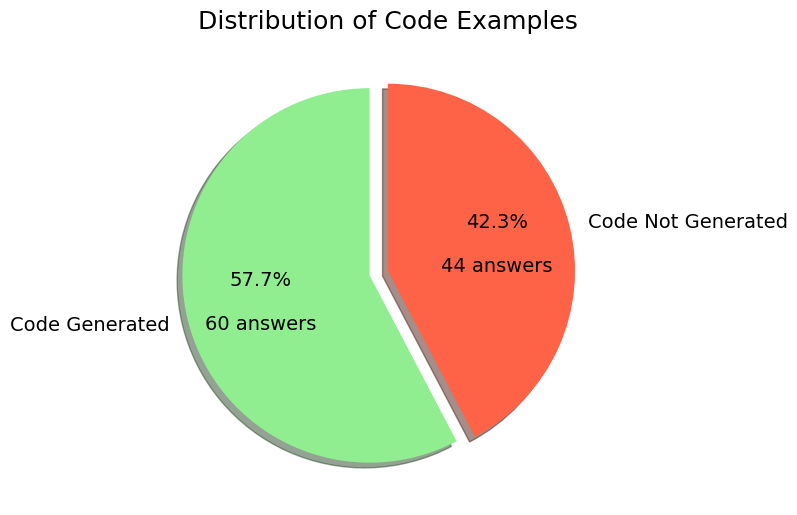

In [2]:
import matplotlib.pyplot as plt

# Increase font sizes globally
plt.rcParams.update({'font.size': 14,  # Adjust base font size as needed
                     'axes.titlesize': 18,  # Adjust for title
                     'axes.labelsize': 16,  # Adjust for x and y labels
                     'xtick.labelsize': 14,  # Adjust for x-axis tick labels
                     'ytick.labelsize': 14,  # Adjust for y-axis tick labels
                     'legend.fontsize': 14})  # Adjust for legend

# Data for the pie chart
sizes_asked_yes = [yes_yes_count, (104-yes_yes_count)]
labels_asked_yes = ['Code Generated', 'Code Not Generated']

# Custom autopct function to include both percentage and count with more vertical spacing
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # Adjust the vertical spacing with \n\n for more space
        return '{p:.1f}%\n\n{v:d} answers'.format(p=pct, v=val)
    return my_format

# Improved Pie Chart
plt.figure(figsize=(8, 8))
explode = (0.1, 0)  # Explode the 'Code Generated' slice slightly to draw attention to it
plt.pie(sizes_asked_yes, labels=labels_asked_yes, autopct=autopct_format(sizes_asked_yes), startangle=90, colors=['lightgreen', 'tomato'], explode=explode, shadow=True, textprops={'fontsize': 14})
plt.title('Distribution of Code Examples', fontweight='normal')
plt.tight_layout()  # Adjusts subplots to fit in the figure area.
plt.show()


In [3]:
import json

# Assuming the file path is still valid
file_path = "Further Json Outputs/valued_rephrased_data.json"

# Re-read the data
with open(file_path, 'r') as file:
    data = json.load(file)

# Initialize the sum and count for calculating the average
total_confidence_percentage = 0
count_valid_percentages = 0

# Iterate through each item to sum up and count valid "Confidence Percentage" values
for item in data:
    adjusted_percentage = adjust_confidence_percentage(item["Confidence Percentage"])
    total_confidence_percentage += adjusted_percentage
    count_valid_percentages += 1  # Increment for every item, since we adjust invalid values to 0

# Calculate the average, ensuring we don't divide by zero
average_confidence_percentage = (total_confidence_percentage / count_valid_percentages) if count_valid_percentages > 0 else 0

# Print the average "Confidence Percentage"
print(f'Average "Confidence Percentage" across the dataset: {average_confidence_percentage:.2f}%')

Average "Confidence Percentage" across the dataset: 65.90%


In [4]:
import numpy as np

# Assuming you have re-read the data and have the 'adjust_confidence_percentage' function ready
# Extract all valid "Confidence Percentage" values as a list
confidence_percentages = [adjust_confidence_percentage(item["Confidence Percentage"]) for item in data]

# Calculate percentiles
low_threshold = np.percentile(confidence_percentages, 25)
medium_threshold = np.percentile(confidence_percentages, 50)  # This is essentially the median
high_threshold = np.percentile(confidence_percentages, 75)

# Now, categorize the values based on these thresholds
low_count = len([x for x in confidence_percentages if x <= low_threshold])
medium_count = len([x for x in confidence_percentages if low_threshold < x <= medium_threshold])
high_count = len([x for x in confidence_percentages if x > medium_threshold])  # This includes values above the high_threshold

# Print the thresholds and counts
print(f'Low Threshold (25th percentile): {low_threshold}%')
print(f'Medium Threshold (50th percentile, Median): {medium_threshold}%')
print(f'High Threshold (75th percentile): {high_threshold}%')
print(f'Count of Low "Confidence Percentage": {low_count}')
print(f'Count of Medium "Confidence Percentage": {medium_count}')
print(f'Count of High "Confidence Percentage": {high_count}')

Low Threshold (25th percentile): 40.0%
Medium Threshold (50th percentile, Median): 75.0%
High Threshold (75th percentile): 100.0%
Count of Low "Confidence Percentage": 958
Count of Medium "Confidence Percentage": 1157
Count of High "Confidence Percentage": 1709


In [5]:
import numpy as np

# Calculate histogram bins and counts
bin_edges = np.linspace(0, 100, 11)  # Define 10 bins from 0 to 100
hist_counts, _ = np.histogram(confidence_percentages, bins=bin_edges)

# Print the counts for each bin
for i in range(len(bin_edges)-1):
    print(f'Confidence Percentage {bin_edges[i]:.0f}% to {bin_edges[i+1]:.0f}%: {hist_counts[i]} answers')


Confidence Percentage 0% to 10%: 391 answers
Confidence Percentage 10% to 20%: 75 answers
Confidence Percentage 20% to 30%: 198 answers
Confidence Percentage 30% to 40%: 134 answers
Confidence Percentage 40% to 50%: 252 answers
Confidence Percentage 50% to 60%: 377 answers
Confidence Percentage 60% to 70%: 276 answers
Confidence Percentage 70% to 80%: 419 answers
Confidence Percentage 80% to 90%: 233 answers
Confidence Percentage 90% to 100%: 1469 answers


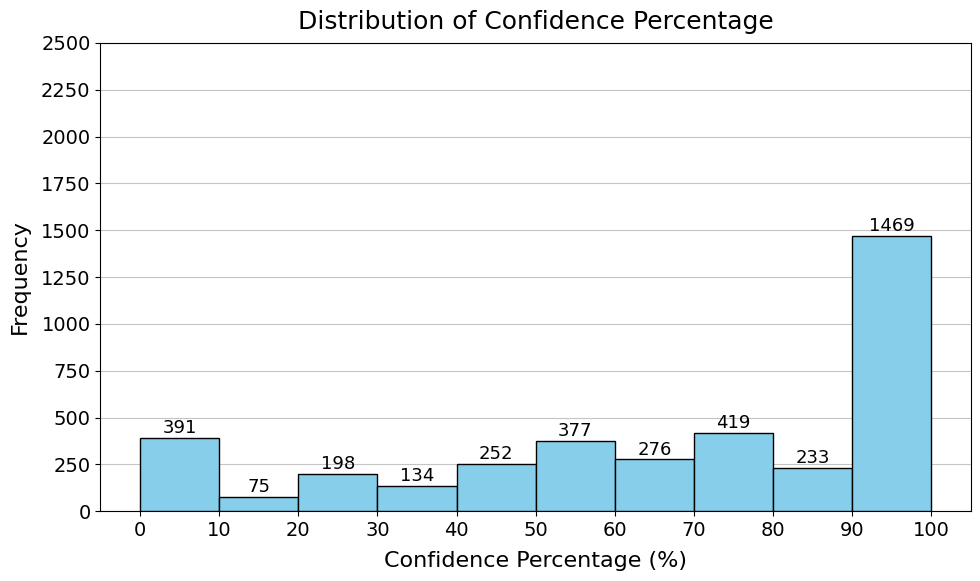

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Increase font sizes globally
plt.rcParams.update({'font.size': 13,  # Adjust base font size as needed
                     'axes.titlesize': 18,  # Adjust for title
                     'axes.labelsize': 16,  # Adjust for x and y labels
                     'xtick.labelsize': 14,  # Adjust for x-axis tick labels
                     'ytick.labelsize': 14,  # Adjust for y-axis tick labels
                     'legend.fontsize': 14})  # Adjust for legend
                     

plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(confidence_percentages, bins=10, color='skyblue', edgecolor='black', alpha=1 ,zorder=3)

# Calculate the center of each bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Increase the spacing value here, for example to 10 or more, to increase spacing between bars and numbers
spacing = 25  # Adjust this value to increase or decrease the spacing

# Add text for the label in the center of each bin with increased spacing
for count, x in zip(n, bin_centers):
    if count > 0:
        plt.text(x, count + spacing, str(int(count)), ha='center')

plt.title('Distribution of Confidence Percentage', fontweight='normal', pad=10)
plt.xlabel('Confidence Percentage (%)', labelpad=8)
plt.ylabel('Frequency', labelpad=8)
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, max(2750, max(n) + 100), max(250, (max(n) + 100)//10)))

plt.grid(axis='y', alpha=0.75, zorder=0)
plt.tight_layout()
plt.show()


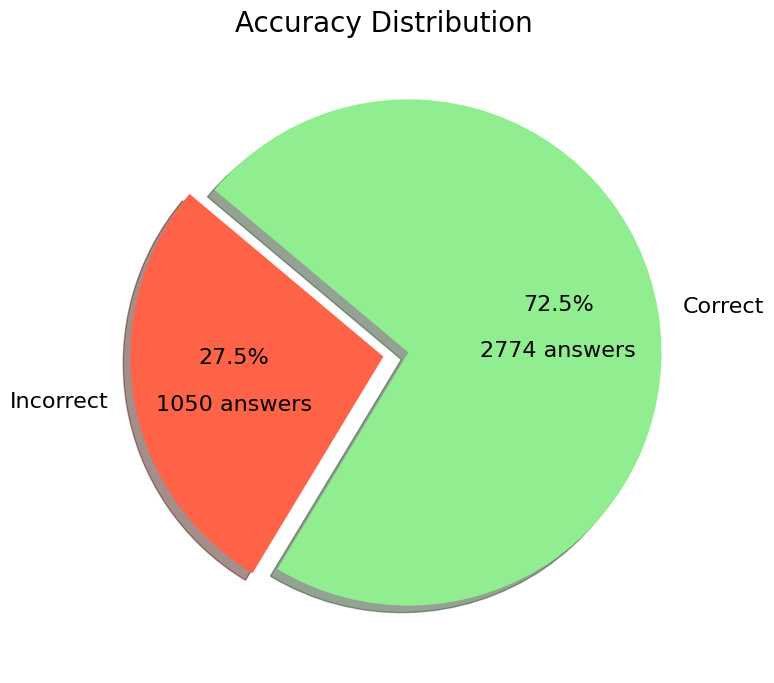

In [7]:
import matplotlib.pyplot as plt

# # Assuming gpt3_validation_0_count and gpt3_validation_1_count are defined somewhere in your code
# gpt3_validation_0_count = 1200  # Example value
# gpt3_validation_1_count = 2800  # Example value

# Increase font sizes globally
plt.rcParams.update({'font.size': 16,  # Adjust base font size as needed
                     'axes.titlesize': 20,  # Adjust for title
                     'axes.labelsize': 18,  # Adjust for x and y labels
                     'xtick.labelsize': 16,  # Adjust for x-axis tick labels
                     'ytick.labelsize': 16,  # Adjust for y-axis tick labels
                     'legend.fontsize': 14})  # Adjust for legend

# Data for plotting
gpt3_validation_counts = [gpt3_validation_0_count, gpt3_validation_1_count]
gpt3_labels = ['Incorrect', 'Correct']  # Use more descriptive labels

# Custom autopct function to include both percentage and count with more vertical spacing
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # Adjust the vertical spacing with \n\n for more space
        return '{p:.1f}%\n\n{v:d} answers'.format(p=pct, v=val)
    return my_format

# Improved Pie Chart
plt.figure(figsize=(8, 8))
explode = (0, 0.1)  # Only explode the 'Correct' slice
plt.pie(gpt3_validation_counts, labels=gpt3_labels, autopct=autopct_format(gpt3_validation_counts), startangle=140, colors=['tomato', 'lightgreen'], explode=explode, shadow=True, textprops={'fontsize': 16})
plt.title('Accuracy Distribution', fontweight='normal')
plt.tight_layout()  # Adjusts subplots to fit in the figure area.
plt.show()
